<a href="https://colab.research.google.com/github/rryeong/Counter-module/blob/main/Applied_Bioinformatics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Applied bioinformatics

This notebook has code for every lecture in the applied bioinformatics course held at TU Dresden. Enjoy!


In [ ]:
#@title Download whale data. Needed for most units

import requests,time,os,sys,re,random,math,statistics,cv2,glob
import seaborn as sns
from tqdm import tqdm
import IPython
from IPython.utils import io
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

def clean(acc):
  """
  Extract from sequence header the accession number, species, and taxid
  """
  # acc look like this:
  # >sp|P00673|RNAS1_BALAC Ribonuclease pancreatic OS=Balaenoptera acutorostrata OX=9767 GN=RNASE1 PE=1 SV=1
  # We want to extract RNAS1_BALAC and Balaenoptera acutorostrata
  # RNAS1_BALAC: Split at space, take first chunk, split this at | and take last chunk
  # Balaenoptera acutorostrata: Find OS= and OX= and take string inbetween
  # To get to the common name we extract the tax id (OX) and create a link to UniProt

  l = acc.split()[0].split("|")
  id = l[-1]
  uniprot = l[1]
  fr = acc.find("OS=")+3
  to = acc.find("OX=")
  fr2= acc.find("OX=")+3
  to2= fr2+acc[fr2:].find(" ")
  species = acc[fr:to].strip()
  taxid = acc[fr2:to2].strip()
  return (id, uniprot, species, taxid)

def clean_seq(s):
  for c in "UBZX*":
    s = s.replace(c, "")
  return s


def load_data(query):
  # For the url to the data go to UniProt RNAS1_BALAC and look for similar proteins.
  # When selecting download you can generate a url that downloads the sequences in fasta format and gzipped
  start = time.time()
  url = "https://rest.uniprot.org/uniprotkb/stream?compressed=true&format=fasta&query="+query


  acc2seq={}
  acc2uniprot = {}
  acc2species={}

  response = requests.get(url)
  with open("seq.txt.gz", "wb") as f:
    f.write(response.content)

  # unzip the downloaded file
  !gunzip -f seq.txt.gz

  acc_raw = ""
  seq=""
  for line in open("seq.txt"):
    if line.startswith(">"):
      if acc_raw != "":
        (acc, uniprot, species, taxid) = clean(acc_raw)
        acc2uniprot[acc] = uniprot
        acc2seq[acc] = clean_seq(seq)
        acc2species[acc] = (species, taxid)
      acc_raw = line.strip()
      seq = ""
    else:
      seq += line.strip()
  (acc, uniprot, species, taxid) = clean(acc_raw)
  acc2uniprot[acc] = uniprot
  acc2seq[acc] = clean_seq(seq)
  acc2species[acc] = (species, taxid)
  print("Downloading %d sequences took %d sec."%(len(acc2seq), time.time()-start))
  return acc2seq, acc2species, acc2uniprot



def add_selected_accs(acc2seq, acc2species=None):

  acc2seq["RNAS1_BALAC"] = "RESPAMKFQRQHMDSGNSPGNNPNYCNQMMMRRKMTQGRCKPVNTFVHESLEDVKAVCSQKNVLCKNGRTNCYESNSTMHITDCRQTGSSKYPNCAYKTSQKEKHIIVACEGNPYVPVHFDNSV"
  acc2seq["RNAS1_HORSE"] = "KESPAMKFERQHMDSGSTSSSNPTYCNQMMKRRNMTQGWCKPVNTFVHEPLADVQAICLQKNITCKNGQSNCYQSSSSMHITDCRLTSGSKYPNCAYQTSQKERHIIVACEGNPYVPVHFDASVEVST"
  acc2seq["RNAS1_HIPAM"] = "KETAAEKFQRQHMDTSSSLSNDSNYCNQMMVRRNMTQDRCKPVNTFVHESEADVKAVCSQKNVTCKNGQTNCYQSNSTMHITDCRETGSSKYPNCAYKTSQLQKHIIVACEGDPYVPVHYDASV"
  acc2seq["RNAS1_OSPRU"] = "ETPAEKFQRQHMDTEHSTASSSNYCNLMMKARDMTSGRCKPLNTFIHEPKSVVDAVCHQENVTCKNGRTNCYKSNSRLSITNCRQTGASKYPNCQYETSNLNKQIIVACEGQYVPVHFDAYV"

  if not acc2species is None:
    acc2species["RNAS1_BALAC"] = ("Balaenoptera acutorostrata", "9767")
    acc2species["RNAS1_HORSE"] = ("Equus caballus (Horse)", "9796")
    acc2species["RNAS1_HIPAM"] = ("Hippopotamus amphibius", "9833")
    acc2species["RNAS1_OSPRU"] = ("Osphranter rufus (Red kangaroo) (Macropus rufus)", "9321")

  print("Added selected sequences.")


##########################################
#
# Blsoum62 at biopython on github:
# https://github.com/biopython/biopython/tree/master/Bio/Align/substitution_matrices/data
#
##########################################

def get_substitution_matrix(filename):

  aminoacids = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V', 'B', 'Z', 'X', '*']

  with io.capture_output() as captured:
    !wget https://raw.githubusercontent.com/biopython/biopython/master/Bio/Align/substitution_matrices/data/{filename}

  sm = {}
  for line in open(filename):
    if line!="":
      aa1 = line[0]
      if aa1 in aminoacids:
        values = [int(s) for s in line[2:].split()]
        for aa2, value in zip(aminoacids, values):
          # BZX* are special symbols, which we do not want to consider
          if not aa1 in "BZX*" and not aa2 in "BZX*":
            sm[(aa1,aa2)] = value

  return sm


def download_structures():
  acc2af = {}
  for acc,id in [("RNAS1_BALAC","P00673"), ("RNAS1_HORSE", "P00674"), ("RNAS1_HIPAM","P00672"),("RNAS1_OSPRU","P00686")]:
    with io.capture_output() as captured:
      !wget https://alphafold.ebi.ac.uk/files/AF-{id}-F1-model_v4.pdb
      acc2af[acc]=id
  return acc2af



def items_sorted_by_value(d):
  return sorted(d.items(), key=lambda x:x[1], reverse=True)


def get_m_std(values):
  m = statistics.mean(values)
  std = statistics.stdev(values)
  return m,std




print("Getting whale data")

acc2seq_all,acc2species_all,acc2uniprot_all = load_data("%28%28taxonomy_id%3A9767%29%29")
!mv seq.txt whale2.txt


acc2seq,acc2species,acc2uniprot = load_data("%28uniref_cluster_50%3AUniRef50_P00669%29&size=500")
add_selected_accs(acc2seq, acc2species)
!mv seq.txt whale1.txt

whale = "RESPAMKFQRQHMDSGNSPGNNPNYCNQMMMRRKMTQGRCKPVNTFVHESLEDVKAVCSQKNVLCKNGRTNCYESNSTMHITDCRQTGSSKYPNCAYKTSQKEKHIIVACEGNPYVPVHFDNSV"
horse = "KESPAMKFERQHMDSGSTSSSNPTYCNQMMKRRNMTQGWCKPVNTFVHEPLADVQAICLQKNITCKNGQSNCYQSSSSMHITDCRLTSGSKYPNCAYQTSQKERHIIVACEGNPYVPVHFDASVEVST"
kangaroo = "ETPAEKFQRQHMDTEHSTASSSNYCNLMMKARDMTSGRCKPLNTFIHEPKSVVDAVCHQENVTCKNGRTNCYKSNSRLSITNCRQTGASKYPNCQYETSNLNKQIIVACEGQYVPVHFDAYV"

blosum62 =  get_substitution_matrix("BLOSUM62")

acc2af = download_structures()

s="""
The following variables are set:
- acc2seq: dictionary with RNAS1 sequences
- acc2species: dictionary with species of RNAS1 sequences
- acc2seq_all: dictionary with whale sequences
- acc2species_all: dictionary with species of whale sequences
- whale: whale RNAS1 sequence
- horse: horse RNAS1 sequence
- kangaroo: kangaroo RNAS1 sequence
- blosum62: substitution matrix
- acc2af: dictionary of Alphafold filenames for selected RNAS1 proteins

The whale sequences are in whale2.txt (all) and whale1.txt (RNAS1).
"""
print(s)




Getting whale data
Added selected sequences.

The following variables are set:
- acc2seq: dictionary with RNAS1 sequences
- acc2species: dictionary with species of RNAS1 sequences
- acc2seq_all: dictionary with whale sequences
- acc2species_all: dictionary with species of whale sequences
- whale: whale RNAS1 sequence
- horse: horse RNAS1 sequence
- kangaroo: kangaroo RNAS1 sequence
- blosum62: substitution matrix
- acc2af: dictionary of Alphafold filenames for selected RNAS1 proteins

The whale sequences are in whale2.txt (all) and whale1.txt (RNAS1).



In [ ]:
s=[len(v) for v in acc2seq_all.values()]
a=statistics.mean(s)
b=statistics.median(s)
print(a,b)

630.382227013707 463


In [ ]:
#@title Install PyMol in Colab

# Source: https://github.com/MooersLab/colabOpenSourcePyMOLpySnips

try:
  from pymol import cmd
  print("PyMOL already installed.")
except:
  from IPython.utils import io
  import os,time

  start = time.time()
  print("Installing PyMol takes some time.")

  # do not display all the output that installation generates
  with io.capture_output() as captured:

    # install condacolab
    !pip install -q condacolab
    import condacolab
    condacolab.install()

    # January 2024 there seems to be a problem between colab and cudatoolkit=12.2
    # https://stackoverflow.com/questions/77726543/trouble-installing-isce2-in-colab-cudatoolkit-12-2-is-missing-from-the-target
    # sed command below solves problem
    !sed -i '/cudatoolkit/d' /usr/local/conda-meta/pinned
    !conda create -n pymol310 python=3.10

    # Main command: !conda install -c conda-forge pymol-open-source
    !mamba install pymol-open-source

  # test whether install was successful
  ok = ""
  try: from pymol import cmd
  except: ok = "not "
  print("It took %d seconds.\nPyMol import %sok."%(time.time()-start, ok))

def get_aa_string(id):
  return "".join(cmd.get_fastastr(id).split("\n")[1:])

def get_ss_string(id):
  idx2resi = {}
  cmd.iterate(id, 'idx2resi[model, index] = [resi,name,ss]', space={'idx2resi': idx2resi})
  ss_string = "".join([ss for resi,ss in sorted([(int(resi),ss) for resi,name,ss in idx2resi.values() if name=="CA"], key=lambda x:x[0])])
  return ss_string

def save_png(png):
  if not png.endswith(".png"):
    png = png+".png"
  cmd.png(png, ray=1)

def show_png(png):
  img = cv2.imread(png)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.axis("off")
  plt.show()

PyMOL already installed.


In [ ]:
#@title Download selected whale structures and generate ss strings


def uniprot2af(id):
  return "AF-%s-F1-model_v4.pdb"%id


def download_selected_whale_structures():

  acc2af_all = {}

  selected_accs = random.sample(list(acc2seq_all.keys()), 100)

  if not os.path.exists("pdb"):
    os.mkdir("pdb")
  os.chdir("pdb")

  for acc in tqdm(selected_accs):

    uniprot = acc2uniprot_all[acc]
    fn = uniprot2af(uniprot)
    url = "https://alphafold.ebi.ac.uk/files/%s"%fn

    with io.capture_output() as captured:
      !wget {url}
      if os.path.exists(fn):
        acc2af_all[acc] = fn

  os.chdir("..")
  print("\nDownloaded %d randmly selected structures"%len(acc2af_all))

  return acc2af_all



def generate_ss_strings():

  acc2ss_all={}

  os.chdir("pdb")
  for acc,fn in tqdm(list(acc2af_all.items())):
    cmd.load(fn, acc)
    ss = get_ss_string(acc)
    acc2ss_all[acc]=ss
    cmd.delete(acc)

  os.chdir("..")

  return acc2ss_all

acc2af_all = download_selected_whale_structures()

acc2ss_all = generate_ss_strings()

print("\nVariables acc2af_all and acc2ss_all are avaiable now.")

100%|██████████| 85/85 [00:04<00:00, 17.60it/s]


Variables acc2af_all and acc2ss_all are avaiable now.


None


# AB01 Introduction to sequence

For the protein RNAS1 of a minke whale, we calculate the longest common subsequence to RNAS1 in other species to find the land-living animal that shares most with the whale. The longest common subsequence is defined as follows:

Let $a=a_1,...a_m$ and $b=b_1...b_n$. Then $lcs_{a,b} = lcs_{a,b}(m,n)$ is the length of the longest common subsequence of $a$ and $b$, where

\begin{equation}
   lcs_{a,b}(i,j) =
   \begin{cases}
     0 &\text{if } i=0 \text{ or } j=0\\
     lcs_{a,b}(i-1,j-1)+1 & \text{if } i>0, j>0 \text{ and }a_i=b_j\\
     max
     \begin{cases}
     lcs_{a,b}(i-1,j)\\
     lcs_{a,b}(i,j-1)\\
     \end{cases}
     &
     \text{if } i>0, j>0 \text{ and }a_i\neq b_j\\
   \end{cases}
\end{equation}

for $0\le i \le m$ and $0 \le j \le n$.


In [ ]:
#@title Longest common subsequence

a="Petra" #@param {type:"string"}
b="Michael" #@param {type:"string"}

def lcs(a,b):
  """Computes the longest common subsequence."""

  m = len(a)
  n = len(b)
  d={}

  # Initialise the first column
  for i in range(0,m+1):
    d[i,0] = 0

  # Initialise the first row
  for j in range(0,n+1):
    d[0,j] = 0

  # Fill all cells of the matrix
  for i in range(1,m+1):
    for j in range(1,n+1):

      if a[i-1] == b[j-1]:
        d[i,j]=d[i-1,j-1]+1
      else:
        d[i,j] = max(d[i-1,j],
                     d[i  ,j-1])

  return d[m,n]

print("lcs=%d"%lcs(a,b))

lcs=1


In [ ]:
#@title Which is closer to whale? Horse or kangaroo?

whale = "RESPAMKFQRQHMDSGNSPGNNPNYCNQMMMRRKMTQGRCKPVNTFVHESLEDVKAVCSQKNVLCKNGRTNCYESNSTMHITDCRQTGSSKYPNCAYKTSQKEKHIIVACEGNPYVPVHFDNSV"
horse = "KESPAMKFERQHMDSGSTSSSNPTYCNQMMKRRNMTQGWCKPVNTFVHEPLADVQAICLQKNITCKNGQSNCYQSSSSMHITDCRLTSGSKYPNCAYQTSQKERHIIVACEGNPYVPVHFDASVEVST"
kangaroo = "ETPAEKFQRQHMDTEHSTASSSNYCNLMMKARDMTSGRCKPLNTFIHEPKSVVDAVCHQENVTCKNGRTNCYKSNSRLSITNCRQTGASKYPNCQYETSNLNKQIIVACEGQYVPVHFDAYV"

wh=lcs(whale,horse)
wk=lcs(whale,kangaroo)

print("RNAS1")
print("lcs(whale,horse)=%d\nlcs(whale,kangaroo)=%d"%(wh,wk))


RNAS1
lcs(whale,horse)=97
lcs(whale,kangaroo)=84


In [ ]:
#@title Which is a closer to wooly mammoth? African or Asian elephants? lcs of NU4LM

# NU4LM_MAMPR, NU4LM_LOXAF, NU4LM_ELEMA
# NADH-ubiquinone oxidoreductase chain 4L
african = "MPYIYMNITLAFVISLIGTLMYRSHLMSSLLCLEGMMLSLFTLNALLSLNMNFTLSTTVPLILLVFAACEAAVGLALLVMISNTYGLDYVQNLNLLQC"
asian = "MPYIYMNITLAFVISLIGTLMYRSHLMSSLLCLEGMLLSLFTLNALLSLNMNFTLSTMVPLILLVFAACEAAVGLALLVMISNTYGLDYVQNLNLLQC"
mammoth = "MPYIYMNITLAFVISLIGTLMYRSHLMSSLLCLEGMMLSLFTLNALLSLNMNFTLSTTVPLILLVFAACEAAVGLALLIMISNTYGLDYVQNLNLLQC"

afas=lcs(african,asian)
afma=lcs(african,mammoth)
asma=lcs(asian, mammoth)

print("NU4LM\nlcs(mammoth,african)=%d\nlcs(mammoth,asian)=%d"%(afma,asma))


NU4LM
lcs(mammoth,african)=97
lcs(mammoth,asian)=95


In [ ]:
#@title Mitochoindrial DNA of African, Asian elephant and mammoth

african_mtdna="""
>NC_000934.1 Loxodonta africana mitochondrion, complete genome
GTTAATGTAGCTTAAAACAAAAGCAAGGTACTGAAAATACCTAGACGAGTATATCCAACTCCATAAACAA
CAAAGGTTTGGTCCCGGCCTTCTTATTGGTTACTAGGAAACTTATACATGCAAGTATCCGCCCGCCAGTG
AATACGCCTTCTAAATCATCACCGATCAAAGAGAGCTGGCATCAAGCACACACTCTAAGTGTAGCTCATG
ACGTCTCGCCTAGCCACACCCCCACGGGAAACAGCAGTAGTAAATATTTAGCAATTAACAAAAGTTAGAC
TAAGGTATCCTAATAAAGGACTGGTCAATTTCGTGCCAGCAACCGCGGCCATACGATTAGTCCAAATTAA
TAAGCATACGGCGTAAAGCGTATCAGAAGAATTAAGAAAATAAAGTTAAATCTTATACTAGCTGTTTAAA
GCTCAAGATAAGACATAAATAACCTACGAAAGTGACTTTAATAATCCTAAACATACGATAGCTAGGGTAC
AAACTGAGATTAGATACCTCACTATGCCTAGCCCTAAACTTTGATAGCTACCTTTACAAAGCTATCCGCC
AGAGAACTACTAGCCAGAGCTTAAAACTTAAAGGACTTGGCGGTGCTTTATATCCACCTAGGGGAGCCTG
TCTCGTAACCGATGAACCCCGATATACCTTACCGTCACTTGCTAATTCAGTCCATATACCACCATCTTCA
GCAAACCCCCATAGGGCACAAAAGTGAGCTTAATCATAACCCATGAAAAAGTTAGGCCGAGGTGTCGCCT
ACGTGACGGTCAAAGATGGGCTACATTTTCTATTATAGAACAGACAAACGGATATCACTCTGAAATGGGT
GGTTGAAGGCGGATTTAGTAGTAAACTAAGAATAGAGAGCTTAATTGAACAAGGCTATGAAGCGCGTACA
CACCGCCCGTCACTCTCCTCAAGTATCCCCACATCAAACAATCATATTACAGATTTAAACAAATACAAGA
GGAGACAAGTCGTAACAAGGTAAGCGTACTGGAAAGTGCGCTTGGATAACTCAAAGTGTAGCTTAACAAA
AAGCATCTGGCTTACACCTAGAAGACCTCATTTACAATGATCACTTTGAACTAAATCTAGCCCTACCAAC
CCTACACTCAATTCTCATATTATATTAAATCAAAACATTCACTTACCAAAAAGTATAGGAGATAGAAATT
TCACTAAGGCGCAATAGAGATAGTACCGCAAGGGAATGATGAAAGATAGTTTAATAGTAAAAAATAGCAA
GGATTAACCCCTTTACCTTTTGCATAATGAATTAACTAGAAAAATCTGACAAAGAGAACTATAGCCAGAA
ACCCCGAAATCAGACGAGCTATCTGATAGTAATCCCCAGGATCAATTCATCTATGTGGCAAAATAGTGAA
GAAACTTACAGATAGAGGTGAAATACCAATCGAGCCTGATGATAGCTGGTTGTCCAGAAATAGAATTTTA
GTTCTACCTAAAACTTACCACAAAAACAAAATAATTCCAATGTAAGTTTTAGAGATATTCAAAAGGGGTA
CAGCTCTTTTGACCAAGGACACAACCTTGATTAGCGAGTAAATTCACCATTAATTTCATAGTTGGCTTAG
AAGCAGCCATCAATTAAGAAAGCGTTAAAGCTCAACAACCAACCAAACTAAAAAGATTCCAAAATTAATT
AATGATCTCCTAAACATAATACTGGACTAATCTATATAAATAGAAGAAATAATGTTAGTATAAGTAATAA
GAAGTATTTCTCCCTGCATAAGCTTATATCAGGTCGGATGCCCGCTGATAGTTAACAACCGAATAATTAG
ATACAAAAATAGAACCTTTATTATACCAATTGTTAACCCAACACAGGCATGCTTAAGGGAAAGATTAAAA
GAAGGAAAAGGAACTCGGCAAACACAAACCCCGCCTGTTTACCAAAAACATCACCTCGAGCATTACTAGT
ATTCGAGGCACTGCCTGCCCAGTGACCAAGCGTTAAACGGCCGCGGTACTCTGACCGTGCAAAGGTAGCA
TAATCATTTGTTCCTTAATTAGGGACTTGTATGAACGGCCACACGAGGGTTTAACTGTCTCTTTCCTCTA
ATCAATGAAATTGACCTTCTCGTGAAGAGGCGAGAATAAACATATAAGACGAGAAGACCCTATGGAGCTT
AAATTAACTAATTTAATTGCTAGCCTATAAATCTATAAGATACAACTAAACAGCATGATAAATTAACAAT
TTTGGTTGGGGTGACCTCGGAGAAGAAAAAATCCTCCGAACGATATTATAATTTAGACTCTACAAGTCAA
AATTTACTAATCGCTTATTGACCCAATACTTGATCAACGGAACAAGTTACCCTAGGGATAACAGCGCAAT
CCTACTCTAGAGTCCCTATCGACAGCAGGGTTTACGACCTCGATGTTGGATCAGGACATCCTAATGGTGC
AGCCGCTATTAAGGGTTCGTTTGTTCAACGATTAAAGTCCTACGTGATCTGAGTTCAGACCGGAGCAATC
CAGGTCGGTTTCTATCTATAGTTTATTTATTCCAGTACGAAAGGACAGAAAAAATGAGGCCAATCTTACC
AAGACGCCTCCAGCTAAATTTATGAATAAATCTCAATCTAGATAAGCTAAACCACCCAATCCAAGAACAG
GATTTGTTAAGATAGCAAAAACTGGTCACTGCATAAAACTTAAGCTTTTACTCACGGAGGTTCAACTCCT
CTTCTTAACAATGTTCTTAATCAATGTCCTAACAGTAACCTTACCTATCCTCCTAGCAGTAGCCTTCCTT
ACCTTAGTTGAACGAAAGGCCTTAGGCTATATACAACTTCGTAAAGGTCCCAATGTAGTAGGACCTTACG
GTCTTCTCCAACCTATTGCAGATGCAATCAAGCTATTTACTAAAGAACCCATCTACCCACAAACCTCATC
AAAATTCCTATTTACCGTCGCCCCAATTCTAGCCCTAACCTTAGCCCTAACTGTATGAGCTCCTCTTCCA
ATACCATATCCTCTAATTAACTTAAATCTGAGCCTACTATTCATTCTCGCAATATCAAGTCTGATAGTTT
ATTCCATCCTATGATCAGGCTGAGCATCAAACTCAAAATATGCCCTCATAGGAGCCCTGCGAGCAGTAGC
CCAAACCATCTCCTATGAAGTCTCTATAACAACTATCACCTTATCAATAGTACTAATAAATGGGTCCTTC
ACACTAACCGCCTTCGCTATAACACAAGAACATCTATGACTAATCCTTCCTATATGACCCCTGATAATAA
TATGATTCACATCAACCTTAGCAGAAACTAACCGAGCCCCATTTGATTTAACCGAAGGAGAATCAGAATT
AGTTTCTGGCTTCAATGTCGAATACTCAGCTGGCCCTTTCGCCCTATTTTTTATAGCTGAATACGCTAAC
ATCATCATAATAAACGCTCTTACTGTGATTCTATTTATAGGAACCTCTTATGACCCCCAAATACCAGAAA
TTAGTACCATTAACTTTGTCATAAAAACTATTATCCTAACCATCTGCTTTCTATGAGTACGAGCATCTTA
CCCACGATTCCGATACGACCAACTAATACATCTCCTCTGAAAAAATTTTCTCCCACTAACTCTAGCTCTA
TGCATATGACACATCTCAGTCCTAATCTCACTAGCATGTATTCCACCACAAGCATAGAAATATGTCTGAC
AAAAGAATTACTTTGATAGAGTAAATTATAGAGGTCTGAACCCTCTTATTTCTAGAATTATAGGAATCGA
ACCTAAACTCGAGAATTCAAAAATCTCAGTGCTACCAATTACACCACGTTCTACTAGTAAGGTCAGCTAA
ATTAAGCTATCGGGCCCATACCCCGAAAATGTCGGATCACACCCCTCCCATACTAATAAACCCACTAGCT
CTTAGCCTAATCCTAACAACACTACTCGCAGGAACACTGATTACCATAATAAGCTCCCATTGATTGACAG
CCTGAATGGGACTAGAAATGAACATACTTACTATAATTCCCATTCTAATAAAGACAACCAATCCACGATC
CACAGAAGCCGCCACAAAGTACTTTATAACCCAAGCCATAGCATCCATAATACTTATAATGGCTTTAACA
ATTAACCTAATATACTCAGGACAATGATCAATTACAAAAATAACCAACCCTGTAGCATCAAACATAGCAT
TAATAGCTTTAATAACCAAACTAGGCTCAGCCCCATTCCACTTCTGAGTTCCAGAAGTAACGCAAGGAGT
CGAACTTACACCAGGGATGATCTTGTTAACCTGACAAAAATTAGCACCATTATCCCTACTATATCAAATG
GCCACCTACACTAACACTAACCTAATCTACCTTTCTGGTCTACTTTCAATCCTAATTGGGGGATGAGGAG
GCCTAAATCAAACACAACTACGAAAAATCTTAGCCTATTCATCAATCTCCCATATAGGCTGAATACTCAT
TATCTTGCCCTTCAATCCCACCCTTACCCTACTAAACTTAACCATTTACATTATACTAACACTGTCCATC
TTTATAATTCTAACAAATACTTTCACAACTTCAATATCATCCCTAACTCTAATATGAAACAAAACACCTG
CAATAACCATTATACTTATAACTACTTTACTATCTTTAGGAGGACTACCCCCACTATCGGGATTCATACC
CAAATGACTTATGATTCACGAACTAACCAAAAACAACAGTATTATCATACCACTAACCATGGCCATTATA
GCATTACTAAACATGTACTTCTACATACGACTAATCTACTACTCATCACTAACAATCCTACCATCTACAA
ATAATATGAAAATAACCTGACGATTTACTAATACTAAACACACAATAACATTACCCACCCTAATCACCCT
ATCTAACATACTACTTCCCCTAACCCCAATAATTTCAATGCTAGAATAGGAATTTAGGTTAAACAGACCA
AGAGCCTTCAAAGCCCCAAGTAAGTACATTATACTTAACTCCTGAAATAAGGACTGCAAGATACTATCTT
ACATCAACTGAATGCAAATCAGACGCTTTAACTAAACTAAGCCCTTCTAGATTGGAGGGCTTCAATCCCA
CGAAATTCTTAGTTAACAACTAAACACCCTAGCTAACTGGCTTCAATCTACTTCTCCCGCCTTGAGGGAG
GGGGAAAAAGGCGGGAGAAGCCCCGGCAGAATTGAAGCTGCTTCTTCGAATTTGCAGTTCGACATGTTTA
CACTTTCAAGGCCTGGCAAAAAGAGATTACTCTCTGTGGTTAGATTTACAGTCTAATGCCTACTCAGCCA
TTTTACCTATGTTTGCTAACCGCTGACTATATTCAACGAACCACAAAGATATCGGAACACTGTATCTATT
ATTTGGTGCTTGAGCTGGTATAGTAGGGACTGCTTTTAGTATCCTAATTCGGGCAGAACTAGGCCAACCA
GGCTCTCTTCTTGGAGATGATCAAATCTACAATGTTATTGTCACAGCACACGCCTTCGTAATAATCTTCT
TTATAGTCATGCCAATTATAATTGGAGGCTTTGGAAACTGGTTAATTCCACTTATAATTGGAGCACCTGA
TATAGCTTTTCCTCGAATAAACAATATGAGTTTTTGACTACTGCCTCCATCTTTCCTACTACTTTTAGCA
TCCTCTATAGTAGAAGCTGGGGCAGGCACTGGTTGGACCGTATACCCTCCCCTGGCAGGAAACCTGGCCC
ATGCAGGAGCTTCTGTGGATTTAACTATTTTTTCACTTCACCTTGCAGGAGTATCCTCTATTCTAAGTGC
AATTAATTTTATCACTACCATCATCAACATAAAACCTCCAGCTATATCTCAATACCATATACCCTTATTT
GTATGGTCCATTTTAATTACAGCCGTCCTTCTTCTTCTATCCCTCCCAGTTCTAGCAGCAGGTATTACAA
TATTACTAACGGATCGCAATCTCAATACTACTTTTTTTGATCCTGCAGGAGGAGGAGACCCAATTCTATA
TCAACACCTATTCTGGTTTTTTGGACACCCTGAAGTCTATATTCTAATTCTCCCAGGATTTGGAATAGTT
TCTCATATCGTTACATACTACTCAGGAAAAAAAGAACCCTTCGGTTATATAGGGATAGTATGGGCTATAA
TATCAATTGGCTTCCTAGGATTTATTGTATGAGCCCACCATATATTCACCGTAGGCATAGACGTTGACAC
TCGAGCTTACTTTACATCAGCTACTATAATTATTGCTATTCCAACTGGCGTAAAAGTCTTTAGTTGACTA
GCTACCCTTCATGGCGGTAATATTAAATGATCCCCCGCTATAATATGAGCTCTAGGATTTATCTTCTTGT
TTACAATTGGAGGATTAACTGGCATTGTTCTTGCTAATTCTTCACTAGACATTGTCCTACATGACACCTA
CTACGTTGTAGCTCACTTTCACTACGTCTTGTCTATAGGTGCAGTTTTCGCCATTATGGGTGGATTTATC
CACTGATTTCCACTATTTTCAGGATACACATTAAATTATACATGAGCTAAAATTCAATTCCTAGTTATAT
TTATTGGTGTTAATTTGACATTTTTTCCCCAACACTTTCTTGGACTATCTGGTATGCCACGTCGATATTC
TGACTATCCAGATGCCTATACTGCATGAAATACTGCCTCTTCTATAGGTTCATTTATCTCTTTAGTAGCC
GTAATTCTAATAGTCTTTATAATTTGAGAGGCATTTGCTTCTAAGCGCGAAGTTTCTGTGATAGAACTCA
CAACAACAAACGTAGAATGACTCAACGGATGTCCACCTCCACATCATACATTCGAAGAACCAGCCTACGT
AAAATCTAACTCGAGAAGGGAAGGAATCGAACCTCCAACAGTTAGTTTCAAGCCAACTCTATAACCTTTA
TGCCTTCCCCAGCAGGCATGGAATTTTAGTAAAACAATTACATAGCCTTGTCAAAGCTAAGCTACAGGTT
TAAATCCCGTAAATTTCTATGGCCTATCCGTTACAATTGGGGTTCCAAGATGCCACATCTCCTGTTATAG
AAGAACTCCTTCACTTCCATGACCACACCCTAATAATCATTTTCCTTATTAGCTCCTTAGTCTTGTATAT
TATTATGCTTATATTAACTTCTAAGCTAGTCCATACAAATATAATAAACGTCCAAGAGATAGAAATAATC
TGAACCATTCTCCCAGCTATTATCCTTATCTTAATTGCCCTGCCCTCTTTACACACTCTGTATATAATAG
ATGAAATCAATAACCCCCTATTAACAATCAAGACCATAGGACACCAATGATTCTGGAGTTATGAATATAC
TGATTACGAAGATTTAGCTTTCGACTCATACATAATCACTACTGATAGCCTAAAATTTGGAGAACTTCGA
TTATTAGAGGTAGACAATCGGATGGTATTACCTACAGACCTACCAGTTCGAGTACTAGTCTCATCAGAAG
ATGTTCTCCATTCATGGGCTGTTCCATCTCTAGGTCTAAAAACAGATGCAATTCCAGGACGACTTAATCA
AGTAACTTTAACATCAATACGACCTGGCTTATTTTATGGTCAGTGTTCCGAAATCTGCGGAGCAAACCAT
AGCTTCATACCAATTGTCCTAGAACTAGTTCCACTTAAATACTTTGAAAACTGGTCAGCATCACTAGCAC
AATCATTAAGAAGCTATAATAGCACTAACCTTTTAAGTTAGAGTATGAGAACACAGAATTCTCCTTAATG
AATGGAACGAATAGATATTATTATTTGATTACTAGCAGTCGTAATTGTACTTACGACACTAATAATCTTT
CTTCATCTTAAAACTCTGAAGATCATTCGCCTTCTTTTCCCAATCTCTAAAGAACTATCCAAGAAGTCAT
GTGTTTTCCCTTGAAAGAAGAAGTGAACGAAGAACTATCCACCTTCTTCTATGTACCCGTAGGTACAATA
ATACTAGCTATTGCATTTCCAGCAATCCTACTTCCAACCCCAAATCGCCTAATTACCAACCGTTGAATTA
CAATCCAACAATGACTAATCCAATTAATCATAAAACAACTTCTATCTATTCATAATACAAAAGGACTGTC
ATGATCTCTAATATTAATTACTCTAACTTTATTCATTGGTCTAACCAATCTACTAGGTCTATTACCCTAT
TCATTCGCTCCCACAACACAACTAACCGTAAACTTAAGCATAGCAATCCCCCTATGGACTGGTACAGTTG
TCCCGGGTTTCCGATATAAAACTAAAATCTCACTAGCCCATCTTCTCCCACAAGGAACACCTATATTCCT
TATCCCTATAATTATTATTATCGAAACCATTAGTCTCCTCATTCGACCAGTCACCCTAGCGGTTCGACTC
ACCGCCAATATCACGGCAGGTCACTCACTTATTCATTTAACCGGAACCGCCACACTAACTTTATCATCCA
TCCATTCAATAACAATTACAGTAACATTTGTTACAGTAATTCTACTTACGATCCTGGAACTTGCCGTAGC
ACTAATTCAGGCCTACGTCTTTGCTCTACTAATTAGCCTCTACCTACATGAGAATGCTTAATGACCCACC
AAACACATGCCTATCACATAGTAGATCCAAGCCCTTGACCTCTTACCGGAGCATTATCTGCCCTACTTAT
AACATCCGGCCTAACTATATGGTTTCATTATCACTCTGTAACCCTCCTGCTTTTAGGATTAACAACCAAT
ATCCTAACTATATTTCAATGATGACGAGATGTAGTTCGAGAAGGAACCTTCCAAGGCCACCATACACCTG
TCGTGCAAGAAAGTTTACGATATGGTATAATTTTATTTATCACCTCTGAAGTATTATTCTTCACAGGTTT
CTTCTGAGCCTTTTATCACTCCAGTCTAGCACCTACCCCTGAACTAGGAAGCTATTGACCTCCAGTAGGT
GTCTACCCACTAAATCCACTAGAAGTACCGCTTCTAAATACATCAGTCCTCCTAGCTTCAGGAGTGACTA
TTACCTGAGCTCACCATAGCTTAATAGAAGGAAACCGTAAAAATATACTTCAAGCCCTCCTTATTACTAT
TCTCTTAGGAGTCTACTTCACACTTCTCCAAATGTTTGAGTACTATGAAGCATCCTTTACAATCTCCGAT
GGCATCTACGGCTCAACTTTCTTTGTAACCACAGGATTCCATGGCCTACACGTTATTATTGGCTCTACAT
TTCTCCTAACCTGCTTTATTCGCCAACTTAAATTCCATTTTACATCCAACCATCACTTTGGCTTTGAAGC
AGCTGCTTGATATTGACATTTCGTAGATGTAGTATGACTATTCCTCTATCTATCCATTTACTGATGAGGA
TCCTATTTCTTTAGTATTAACTTAGTATAACTAACTTCCAATTAGTAGGCTTTGGTAAATCCCAAAAAGA
AATAATCAACCTTATAATCACGCTACTAACCAATACTATACTAACATCACTTATAGTTCTAATCGCATTT
TGACTGCCCCAAACATACAATTACTCAGAGAAAACAAGTCCATACGAATGCGGCTTTGATCCAGTAGGCT
CTGCTCGCTTACCATTCTCAATAAAATTCTTCTTAGTAGCTATCACATTTCTCCTATTTGACCTAGAAAT
TGCATTACTCCTACCTTTACCCTGAGCCATCCAAGCTAATAATACAAGTCTAACACTTTTGATATCATTT
ATATTAATCATTCTCTTAGCTATTGGCTTAGCCTATGAATGACTCCAAAAAGGCCTTGAATGAACCAAAT
ATGGTACTTAGTTTAAACAAAACAAATGATTTCGACTCATTAAACTATGAATATATCATAATTACCAATA
TGCCCTACATTTACATAAATATTACACTAGCCTTCGTTATTTCACTCATTGGTACCCTCATATACCGCTC
TCACCTAATATCTTCGTTACTATGCCTTGAAGGAATAATACTTTCACTATTTACCCTAAACGCACTATTA
TCCCTCAACATAAACTTCACATTATCTACTACAGTACCACTAATTCTACTAGTATTCGCAGCCTGTGAAG
CTGCAGTAGGCTTGGCACTTCTTGTTATAATCTCCAATACCTACGGACTAGACTACGTACAAAACTTAAA
CCTACTTCAGTGCTAAAAACTATCTTACCAACAATCATACTTATTCCCCTTGCCTGATTTACCTCTAACA
ATATAGTGTGAATTAATACTACTCTCTATAGCTTTGCAATTAGTCTAACTAGCCTCCACCTGCTCTACCA
ACCCCTTGACAATAGCCTAAACCTCTCCCCAGAATTCTTCTTAGACTCTCTATCTACCCCACTACTAATC
CTTACTATTTGACTACTCCCTCTAATACTAATCGCCAGCCAATCCCATCTATCCTCCGGATCAACTTTTC
AGAAAAAGTCCTATATCACTACAATTATCCTTTTACAAGTATCCCTAATTATAACATTTGCTGCTACAGA
CCTAATTCTACTGTACATTATATTTGAAACAACGCTTATCCCAACTATAGTTATCATTACTCGATGAGGA
AACCAACTGGAACGATTAAACGCAGGGTCATACTTCCTATTCTATACCCTAATAGGATCTCTCCCCCTAC
TAGTAACCCTCATGCTAATCCAAAATACCCTAGGGTCATTGAACTTAATAATACTACCATACCTAATTAA
ACCCATTGACAACCTATGATCCACTAATATATTATGACTAACATGTACTATAGCCTTCATAGTAAAAATA
CCTCTATATGGTCTCCACCTATGATTACCAAAAGCTCATGTAGAAGCACCAATCGCTGGATCTATAGTAT
TGGCTGCCATTCTCTTAAAACTAGGAGGGTATGGGATACTACGAATCACCATCCTCTTGGATCCCCTAAC
AACACACATATATTATCCATTCCTCATACTATCACTATGAGGTATGGTCATATCTAGCTCCATCTGCTTG
CGACAAACAGATATGAAATCCCTCATCGCTTATTCTTCAGTCAGCCACATAGCCTTAGTAATCATTGCTA
TTATACTTCAAACACCATGAAGTTTCATGGGGGCACTTACCCTAATAATCGCCCACGGCCTAACTTCCTC
AATACTTTTCTGTCTAGCAAATTCAAACTACGAGCGCATTCACAACCGAACTATAATTTTAGCACGAGGC
TTACAAACTCTTCTCCCACTAATAGCTACATGATGACTACTAGCTAGCTTAATTAACATGGCCCCACCAC
CCACTATTAATTTAATCGGAGAATTACTTATTATCACAACATCATTTTCATGATCTAATCTCACCATTTT
CCCTATAGGACTAAACGTATTAATTACTACAATATATACTCTCCACATAATAACCACAACTCAACGGGGA
AAGACATCTCACCACGCTAAATCCATTAAACCTTCATTTACCCGAGAGAACACCTTAATAGCCCTCCATT
TTCTACCCCTACTGCTCCTTTCCCTAAACCCCAAGATCATTCTAGGATTAACATATTGCAGACATAGTTT
AACCAAAACATTAGGTTGTGGACCTATAAATAAGAATTTAATCCTCTTTGTCTACCAAGAAAGAATTAAG
GAACTGCTAATCCCTTATACCTCATCTAATAATGTGGCTTTCTTAACTTTTAAAGGGTAAGAGCTACCCA
TTGGTCTTAGGCACCAAAAAACTGGTGCAACTCCAGATAAAAGTAATCAACCTAATCCCAACCCTAATAC
TAACATCACTAATCATTCTAACCCTACCCATTATCACAACATTACTACAAAACAACAAGACAAATTGCTT
TCTATATATCACCAAAACAGCTGTAACCTACGCCTTCGCAATCAGTCTAATTCCAACTCTGTTATTTATT
CAATCTAACCAAGAAGCCTATATCTCCAACTGACACTGAATAACAATCCACACCCTAAAGTTATCTATAA
GCTTTAAATTAGACTTCTTTTCCCTAACATTCATGCCAATTGCACTTTTTATTACCTGATCAATTATAGA
ATTTTCACTATGATATATACACTCAGATCCCCATATTAACCGTTTCTTCAAATACCTCCTGTTATTCCTA
ATCACTATACTAATTTTGGTAAGCGCTAATAATCTACTGCAACTATTTATAGGCTGAGAAGGAGTTGGCA
TTATGTCCTTCCTGCTAATCAGTTGATGACATGGACGAACAGACGCTAACACAGCAGCTCTACAAGCAAT
ACTCTATAACCGCATTGGCGATATAGGCTTTATTATAATAATAGCCTGATTTACTATCCATTTAAATTCT
TGAGAGTTTCAACAAATCTTCTTAACTAACCCCAAGAACACTACACTCCCACTACTAGGTCTTCTCCTGG
CCTCAGCAGGAAAATCAGCCCAATTCGGGCTTCATCCGTGACTTCCATCAGCCATAGAAGGTCCTACTCC
AGTATCGGCACTCCTTCATTCCAGTACAATAGTTATAGCTGGAGTATTTACCCTCATCCGCTTTTACCCA
CTAATAGAAAATAACCTCACTATTCAAACTTCAACACTATGCCTAGGGGCCATTACTACTTTATTTACAG
CTATCTGTGCTCTCACACAGAATGACATCAAAAAGATTATCGCACTCTCCACTTCCAGCCAACTAGGCTT
AATAATAGTAACCATCGGCATTAATCAGCCACAACTAGCCTTTATCCACATATGTACACACGCATTCTTC
AAGGCAATACTATTTCTCTCCTCTGGCTCTATCATCCACAACCTAAACAACGAACAAGACATCCGCAAAA
TAGGAGGACTCTATAAAACAATACCTATTACCTCAACAGCTATCATTATTGGCAGCTTAGCACTCACCGG
TATACCATTCCTAACAGGGTTTTACTCAAAAGACCCAATTATTGAAACTGCTAACATATCCTACATCAAC
ACCTGAGCACTACTAATTACTCTCATTGCCGTATCCATAACAGCAAGTTACAGTACCCGAATCATTTTCT
TTGCTCTCCTTGGGCAACCACGATACCCCCCACTAACCCAAGTCAACGAAAATAACCCGTATCTCGTCAA
CCCTATTAAACGATTAATCCTAGGCAGTATCTTCATGGGCTTCCTTATCTCAATAAATACTATCCCGCAC
ACAACACCCCAAATAACCATACCTCCTCACTTAAAATTTATAGCCCTGGCTGTAACCTTACTAGGATTTA
CGGTAGCAACAGAACTTAACAACATAACACACAATCTAATATTTAAGCAACCATCACGTATACACACATT
CTCAACCATATTAGGGTACTACCCAACTACCACTCATCGAGTCCTACCCTACCCAAGTCTTACTATAAGC
CAAAACCTAGCAACAACCATTATAGACTCAATTTGACTAGAAAAAATAATTCCTAAAAACCTAACAACTA
TGCAGAAAACAGCCGCCAGCCTGGTATCTAATCAAAAAGGCCTAATAAAACTCTACTTCCTATCATTTCT
TCTATCAATTACACTAGGTTTACTAATTGCCCTATAACGTTTTCGAGTAACCTCAATAGCAATAAAAATA
CTAACAAACAATATTCACCCAGCCATAGCCAAAAATCAAAACCCATAACTATACAAAGACGCTCCCCCAG
AATAATCCTCACGTACATACTCAAAACCCCCTTCACCAAGAACTATAAGATCTTCCAAACCACCAAAATA
AAAACCCACCAATTCATGCTCACCACTGAATAACCATATAATTATAAAAACCTCCATTAGTAAGCCTACT
AAAAATGCACCCAAAACTACAACATTTGACCCTCAAGTCTCAGGATACTCTTCAGTAGCCATAGCAATAG
TATAACCAAAAACCACTATCATCCCACCCAAATATACCAAAAATACAACCAGGCCCAAAAAAGACCCCCC
AGAACCCATAATAATCCCACATCCCAAGCCTCCACTCACAACCAAACTCATTCCCCCATAAACAGGGGAA
GGCTTAGACGAAAAACCAATGAAACCTACCACATAAAGCACACTCATAATAAAAACAATATACATCATTA
CTTCCACATGGACTCCTACCATGACTAATGATCTGAAAAACCATCGTTGTATTTCAACTATAGAAATAAT
CAAATAATGACCCACATTCGAAAATCTCACCCCTTACTTAAAATCATCAATAAATCCTTCATTGATCTAC
CTACCCCATCCAACATCTCAACATGATGAAATTTCGGCTCACTACTAGGAGCATGCCTAATTACCCAAAT
CCTAACAGGATTATTCCTAGCCATACATTATACACCCGACACAATAACTGCATTTTCATCTATATCCCAT
ATTTGCCGAGATGTGAACTACGGCTGAATTATTCGACAACTACACTCAAACGGAGCATCCATTTTCTTCC
TCTGCCTATACACACACATTGGACGAAACATCTACTATGGGTCCTACCTATACTCGGAAACTTGAAATAC
CGGCATTATATTACTACTAATCACCATAGCCACCGCCTTCATAGGATATGTCCTTCCGTGAGGACAAATA
TCATTCTGAGGGGCAACCGTAATCACTAACCTTTTCTCAGCAATCCCTTATATCGGCACAAACCTAGTAG
AATGAATCTGAGGAGGCTTTTCAGTAGATAAAGCAACCTTAAATCGATTTTTCGCCCTCCATTTCATTCT
TCCATTTACTATAATTGCACTAGCAGGAGTACACCTAACCTTTCTTCACGAAACAGGCTCAAACAATCCA
CTGGGCCTCACTTCAGACTCAGACAAAATCCCCTTTCACCCATACTATACCATTAAGGACTTCCTAGGAT
TACTTATCCTAATTTTACTTCTTCTACTCCTAGCCCTACTATCTCCTGACATACTAGGAGACCCTGACAA
CTACATACCAGCCGACCCACTAAATACTCCCCTACATATCAAGCCAGAGTGATATTTTCTCTTTGCTTAC
GCCATCCTACGATCTGTACCAAACAAACTAGGAGGCGTCCTAGCCCTACTCCTATCAATTCTAATCCTAG
GATTAATACCACTTCTCCATACATCCAAGCACCGAAGCATAATACTCCGACCTCTTAGCCAAGTCCTATT
CTGAACTCTAACAATAGATTTACTAACACTTACATGAATTGGCAGCCAACCAGTAGAATATCCTTACATC
ATTATTGGTCAAATAGCCTCAATTCTATATTTCTCCATTATCCTAGCCTTCCTGCCAATTGCAGGAGTAA
TCGAAAACTACCTCATTAAGTAACCCCTATAGTATAAGATATTACAATGGTCTTGTAAGCCATAAATGAA
AGCCATTTTCTAAGGGTATTCAGGGAAGAGGTCCACTTACCTCGCTATCAATACCCAAAACTGAAATTCT
TCTTAAACTATTCCCTGCAGGCAATCAACCCGCTATGTATATCGTGCATTAAATGCTTGTCCCCATACAT
AATGATATATATTACTAACTATACTTAATCTTACATAGACCATACTATGTATAATCGTGCATCACATTAT
TTACCCCATGCTTATAAGCAAGTACTGTTTAACTAATGTGTCAAGTCATATTCATGTAGATTCACAGGTC
ATGTTCTGGTTCATGGATATTATTTACCTACGATAAACCATAGTCTTACATAGCACATTAAAGCTCTTGG
TCGTACATAGCACATCACTGAGAAATCTCTAGTCACCATGCATATCACCTCCAATGGTTGTACCTTAACT
ACCTACCTCCGAGAAACCATCAACCCGCCCATCTTCGTGTCCCTCTTCTCGCTCCGGGCCCATCAATTGT
GGGGGTTTCTATACTGGATCTATACCTGGCATCTGGTTCTTTCTTCAGGACCATCTCACCTAAAATCGCC
CATTCTTTCCTCTTAAATAAGACATCTCGATGGATTAATGACTAATCAGCCCATGATCATAACATAACTG
TGGTGTCATGCATTTGGTATCTTTTTAATTTTGGGGATGCTGTGATTCAGCTATGGCCGTCTGAGGCCCT
AACACAGTCAAGCAACTTGTAGCTGAGCTTGAATTGAGTATTAAGATCTGGCACGGTATATATGGGGTAT
TATTCAGTCAATGCTCGGAGGACATAAAATTTTTTAAACCTAAATTCCCAGCGTACACACATACGCATAC
GCATACGTACACGTACACGTACACGCGTACACACGTACACGTACACGTACACGCGTACACACGTACACGT
ACACGTACACGTACACGTACACGTACACGCGTACACACGTACACGTACACGTACACGCATACGCATACGC
ATACGCATACGCATACGCATACGCATACGCATACGCATACGCATACGCATACGCATACGCATACGCATAC
GCATACGCATACGCATACGCATACGCATACGCATACGCATACGCATACGCATACGCATACGCATACGCAT
ACGCATACGCATACGCATACGCATACGCATACGCATACGCATACGCATACGCATACGCATACGCATACGC
ATACGCATACGCATACGCATACGCATACGCATACGTACACGTACACGTATACGTAACCACTATGTAACTA
TCTCTTCAAACCCCCCTTACCCCCCTTAGTTATCCTTGGCTCAATTTCTATAGGGATATTTTTTTATCCT
GTCAACCCCAAAAGCAGGCTATACTATAGATGAAACCAAGAGTACAAACGGGAGGCATAACTAGTTACAT
AGGGGTGAAAGCAAATCATTTTGCCTTCGATACTTGGTACTACTTAAAAAAATTTATTTTTTTTTCAAGA
GCCATGTTCCTAGATTTGAAAAAAAAACCCCGGAGACGCGTTTCTTATAAAATTCTACCCCATCTC
"""

asian_mtdna="""
>NC_005129.2 Elephas maximus mitochondrion, complete genome
GTTAATGTAGCTTAAAACAAAAGCAAGGTACTGAAAATACCTAGACGAGTATATCCAACTCCATAAACAA
CAAAGGTTTGGTCCCGGCCTTCTTATTGGTTACTAGGAAACTTATACATGCAAGTATCCGCCCGCCAGTG
AATACGCCTTCTAAATCATCGCTGATCAAAGAGAGCTGACATCAAGCACACACTCCAAGTGTAGCTCATA
ACGTCTCGCCTAGCCACACCCCCACGGGAAACAGCAGTAGTAAATATTTAGCAATTAACAAAAGTTAGAC
TAAGTTATCCTAATAAAGGACTGGTCAATTTCGTGCCAGCAACCGCGGCCATACGATTAGTCCAAATTAA
TAAGCATACGGCGTAAAGCGTATTAGAAGAGTTAAGAAAATAAAGTTAAATCTTATACTAGCTGTTTAAA
GCTCAAGATAAGACATAAATAGCCTACGAAAGTGACTTTAATAATCCTAAACATACGATAGCTAGGGTAC
AAACTGAGATTAGATACCTCACTATGCCTAGCCCTAAACTTTGATAGCTACCTTTACAAAGCTATCCGCC
AGAGAACTACTAGCCAGAGCTTAAAACTTAAAGGACTTGGCGGTGCTTTATATCCACCTAGGGGAGCCTG
TCTCATAACCGATGAACCCCGATACACCTTACCGTCACTTGCTAATTCAGTCCATATACCACCATCTTCA
GCAAACCCCTATAGGGCACAAAAGTGAGCTTAATCATAACCCATGAAAAAGTTAGGCCGAGGTGTCGCCT
ACGTGACGGTCAAAGATGGGCTACATTTTCTATTATAGAACAGATAAACGGATACCACTCTGAAATAGGT
GGTTGAAGGCGGATTTAGTAGTAAACTAAGAATAGAGAGCTTAATTGAACAAGGCCATGAAGCGCGTACA
CACCGCCCGTCACTCTCCTCAAGTACTTCCACATCTAACAATCATATTACAGATTTAAACAAATACAAGA
GGAGACAAGTCGTAACAAGGTAAGCGTACTGGAAAGTGTGCTTGGGAAACTCAAAGTGTAGCTTAACAAA
AAGCATCTGGCCTACACCCAGAAGACCTCATTTACAATGATCACTTTGAACTAAACCTAGCCCTACCAAC
TTTACACTCAACTCTCACACTACATTAAATTAAAACATTCACTTATCAAAAAGTATAGGAGATAGAAATT
TCACTAAGGCGCAATAGAGATAGTACCGCAAGGGAATGATGAAAGATAGTTTAATAGTAAAAAATAGCAA
GGATTAACCCCTTTACCTTTTGCATAATGAATTAACTAGAAAAATCTGACAAAGAGAACTACAGCCAGAA
ACCCCGAAATCAGACGAGCTATCTGATAGTAATCTCCAGGATCAATTCATCTATGTGGCAAAATAGTGAA
AAAACTTACAGATAGAGGTGAAATACCAATCGAGCCTGATGATAGCTGGTTGTCCAGAAATAGAATTTCA
GTTCTACCTAAAACTTACCACAAAAACAAAATAATTCTAATGTAAGTTTTAGAGGTATTCAAAAGGGGTA
CAGCTCTTTTGACCAAGGATACAACCTTGATTAGCGAGTAAATTCATCATTAATTTCATAGTTGGCTTGG
AAGCAGCCATCAATTAAGAAAGCGTTAAAGCTCAACAACTAACCAAACTAAAAAATCCCAAAATTAATTA
ATGATCTCCTAAACATAATACTGGACTAATCTATATAAATAGAAGAAATAATGTTAGTATAAGTAATAAG
AAGTATTTCTCCCTGCATAAGCTTATATCAGGTCGGATGCCCACTGATAGTTAACAATCAAATAATTAAA
TACAAAAATAAAACCTTTATTATACCAATTGTTAACCCAACACAGGCATGCTTAAGGGAAAGATTAAAAG
AAGGAAAAGGAACTCGGCAAACATAAACCCCGCCTGTTTACCAAAAACATCACCTCGAGCATTACTAGTA
TTCGAGGCACTGCCTGCCCAGTGACCAAGCGTTAAACGGCCGCGGTACTCTGACCGTGCAAAGGTAGCAT
AATCATTTGTTCCTTAATTAGGGACTTGTATGAACGGCCACACGAGGGTTTAACTGTCTCTTTCCTCTAA
TCAATGAAATTGACCTTCTCGTGAAGAGGCGAGAATAAACATATAAGACGAGAAGACCCTATGGAGCTTA
AATTAACTAATTTAATTGCTATACTATAAATCTACAAGATACAACTAAACAGCATAATAAATTAACAATT
TTGGTTGGGGTGACCTCGGAGAAGAAAAAAACCTCCGAACGATATTATAATTCAGACTCTACAAGTCAAA
ATTTACTAATCGCTTATTGACCCAATACTTGATCAACGGAACAAGTTACCCTAGGGATAACAGCGCAATC
CTACTCTAGAGTCCCTATCGACAGCAGGGTTTACGACCTCGATGTTGGATCAGGACATCCTAATGGTGCA
GCCGCTATTAAGGGTTCGTTTGTTCAACGATTAAAGCCCTACGTGATCTGAGTTCAGACCGGAGCAATCC
AGGTCGGTTTCTATCTATAGTTTATTTATTCCAGTACGAAAGGACAGAAAAAATGGGGCCAATCTTACCA
AGACGCCTTCAGCTAAATTTATGAATAAATCTCAATCTAGATAAGCTAAACCACCCAATCCAAGAACAGG
ATTTGTTAAGATAGCAAAAATTGGTCACTGCATAAAACTTAAGCTTTTACTCACAGAGGTTCAACTCCTC
TTCTTAACAATGTTCCTGATCAATGTCCTAACAGTAACCTTACCTATCCTCCCAGCAGTGGCCTTCCTTA
CCTTAGTTGAACGAAAGGCCCTAGGCTATATACAACTTCGCAAAGGCCCTAACGTAGTAGGACCTTATGG
TCTTCTTCAACCTATTGCAGACGCAATCAAACTATTTACCAAAGAACCCATCTATCCACAAACCTCCTCA
AAATTCCTATTTACCGTCGCCCCAATTCTAGCCCTAACCTTAGCCTTAACTGTATGAGCCCCTCTTCCAA
TACCATATCCTCTAATTAACTTAAATCTAAGCCTACTATTTATTCTCGCAATATCAAGTCTAATAGTTTA
CTCCATCCTATGATCAGGCTGAGCATCAAATTCAAAATACGCCCTCATAGGAGCCCTACGAGCAGTAGCC
CAAACCATCTCCTATGAAGTCTCTATGACAACTATCACCTTATCAATAGTACTAATAAATGGGTCCTTCA
CACTAACCGCCTTCGCTACAACACAAGAACATCTATGACTAATCTTTCCCATATGACCCCTAATAATAAT
ATGATTCACGTCAACTTTAGCAGAAACTAACCGAGCCCCATTTGATTTAACCGAAGGAGAATCAGAATTA
GTTTCTGGCTTCAACGTCGAATACTCAGCTGGCCCTTTTGCCCTATTTTTTATAGCCGAATACGCTAACA
TTATCATAATAAACGCCCTTACTGTAATTCTATTTATAGGAACCTCTTGTGACCCTCAAATACCAGAAAT
CAGCACCATCAACTTTGTTATAAAAACTATCATCCTAACCATCTGCTTTCTATGAGTACGAGCATCCTAC
CCACGATTCCGATACGACCAACTAATATATCTCCTCTGAAAAAATTTTCTTCCACTAACTCTAGCTCTAT
GTATGTGACACATCTCAATCCTAATTTCACTAGCATGCATTCCACCACAAGCATAGAAATATGTCTGACA
AAAGAATTACTTTGATAGAGTAAATTATAGAGGTCTAAACCCTCTTATTTCTAGAATCGCAGGAATCGAA
CCTAAACTCGAGAATTCAAAAATCTCAGTGCTACCAATTACACCACATCCTACTAGTAAGGTCAGCTAAA
TTAAGCTATCGGGCCCATACCCCGAAAATGTCGGATCACACCCCTCCCATACTAATAAACCCACTAGCCC
TTAGTCTAATCCTAACAACACTATTCACAGGAACACTAATTACCATAATAAGCTCCCACTGACTAACAGC
CTGAATAGGACTAGAAATGAACATGCTTACTATAATTCCTATTCTAATAAAGACAACCAATCCACGATCC
ACAGAAGCCGCCACAAAGTACTTTATAACCCAAGCCACAGCATCCATAATACTTATAATAGCTTTAACAA
TCAACCTAATATACTCAGGACAATGATCAATTACAAAAATAACCAATCCTGTAGCATCAAATGTAGCATT
AATAGCTCTAATAACCAAACTAGGCTCAGCCCCATTCCACTTCTGAGTCCCAGAAGTAACGCAAGGAGTC
GAACTCACACCAGGAATAATTTTGCTAACCTGACAAAAATTAGCACCATTATCCCTACTATATCAAATAG
CCACCTATACCAACACCAACCTAATCTACCTTTCTGGTCTACTTTCAATTCTAATTGGAGGGTGAGGAGG
CCTAAATCAAACACAACTACGAAAAATCCTAGCCTACTCATCAATCTCCCATATAGGTTGAATACTCATT
ATTTTACCCTTTAACCCCACCCTTACTCTCCTAAACTTAGCCATTTACATTTTACTAACACTATCCATCT
TTATAATCCTAGCAAATACCTTCACAACTTCAATATCATCCCTAACTCTAATATGAAACAAAACACCTGC
AATAACCATCATACTTATAACTACCTTACTATCCTTAGGAGGACTACCCCCACTATCGGGATTCACACCT
AAATGACTTATAATCCACGAACTGACCAAAAACAACAGTATTATCATACCACTAACCATGGCCATTATAA
CACTACTGAACATGTACTTCTACACACGACTAATCTACTATTCATCACTCACAATCTTACCATCTACAAA
CAATATGAAAATAACCTGACAATTTACTAATACTAAACACACAATAATATTACCCACCCTAATCACCCTA
TCTAACATACTACTTCCCCTAACCCCAATAATTTCAATGCTAGAATAGGAATTTAGGTTAAAACAGACCA
AGAGCCTTCAAAGCCCTAAGTAAGTACATTATACTTAACTCCTGAAATAAGGACTGCAAGATATCACCTT
ACATCAACTGAATGCAAATCAGACGCTTTAACTAAACTAAGCCCTTCTAGATTGGAGGGCTTCAATCCCA
CGAAAATCTTAGTTAACAACTAAACACCCTAACTAACTGGCTTCAATCTACTTCTCCCGCCTTGAGGGGG
GGGGAAAAAGGCGGGAGAAGCCCCGGCAGAATTGAAGCTGCTTCTTCGAATTTGCAGTTCGACATGTTTA
CACTTTCAAGGCCTGGTAAAAAGAGATTACTCTCTGTGGTTAGATTTACAGTCTAATACTTACTCAGCCA
TTTTACCTATGTTTGCTAACCGCTGACTATATTCAACAAACCACAAAGATATTGGAACACTGTATCTACT
ATTTGGTGCTTGAGCTGGTATAGTAGGGACTGCTTTTAGTATTCTAATTCGGGCAGAATTAGGTCAACCA
GGCTCTCTTCTTGGAGACGACCAAATCTATAATGTCATTGTCACAGCACACGCCTTTGTAATAATCTTCT
TTATAGTTATGCCAATCATAATTGGAGGCTTTGGAAACTGGTTAATTCCACTTATAATTGGAGCACCTGA
TATAGCTTTTCCTCGAATAAACAATATAAGTTTCTGACTACTGCCTCCGTCTTTCCTACTACTTTTGGCA
TCCTCCATAGTAGAAGCTGGAACAGGCACTGGTTGGACCGTATATCCTCCTCTGGCAGGAAACTTAGCCC
ATGCAGGAGCTTCTGTAGATTTAACTATTTTTTCACTTCACCTTGCAGGAGTATCCTCTATTCTAAGTGC
AATTAATTTTATCACTACCATCATCAACATAAAACCCCCAGCCATGTCTCAATATCATATACCCTTATTT
GTATGATCCATTTTAGTTACAGCCGTTCTTCTTCTTCTATCTCTCCCAGTTCTAGCAGCAGGTATTACAA
TACTATTAACGGATCGCAATCTCAATACTACTTTCTTTGACCCTGCAGGAGGAGGAGACCCAGTTCTATA
CCAACACCTATTCTGGTTTTTTGGACACCCTGAAGTCTATATTCTAATTCTCCCAGGATTTGGAATAGTT
TCTCATATCGTTACGTACTACTCAGGGAAAAAAGAACCCTTTGGCTATATAGGGATAGTGTGGGCTATAA
TATCAATTGGTTTCCTAGGGTTCATTGTATGAGCCCACCATATATTCACCGTAGGTATAGACGTTGACAC
TCGAGCTTACTTTACATCAGCTACTATAATTATTGCTATTCCAACTGGCGTAAAAGTCTTTAGCTGACTA
GCTACCCTTCATGGCGGTAATATTAAATGATCCCCCGCTATAATATGAGCCCTAGGATTTATCTTCTTAT
TTACAATTGGGGGGTTAACTGGCATTGTCCTTGCTAATTCTTCACTAGACATTGTCCTACATGACACTTA
CTACGTTGTAGCTCACTTTCACTACGTCTTATCTATAGGTGCAGTTTTTGCCATTATAGGTGGGTTTATT
CACTGATTTCCACTATTTTCAGGATACACATTAAATTATACATGAGCTAAAATTCAATTTCTAGTTATAT
TTATCGGTGTTAATTTGACATTTTTTCCCCAACACTTTCTTGGACTATCTGGCATACCACGTCGATATTC
TGACTATCCAGATGCCTACACTGCATGAAACACTGCTTCTTCTATAGGTTCATTTATCTCTTTAGTAGCC
GTAATTCTAATAGTCTTTATAATTTGAGAGGCATTTGCTTCTAAGCGCGAAGTTTCTATGATAGAACTCA
TAACAACAAACGTAGAATGACTCAACGGGTGTCCACCTCCACATCATACATTCGAAGAACCAGCCTACGT
AAAATCTAACTCGAGAAGGGAAGGAATCGAACCTCCAACAGTTAGTTTCAAGCCAACTCTATAACCTTTA
TGCCTTCTCCAACAGGCATGAAATTTTAGTAAAACAATTACATAGCCTTGTCAAAGCTAAACTACAGGTT
TAAATCCCGTAAATTTCTATGGCCTATCCGTTACAACTGGGGTTCCAAGATGCCACATCTCCTGTTATAG
AAGAACTTCTTCACTTCCATGACCACACCCTAATAATTATTTTCCTTATTAGCTCCTTAGTCTTGTATAT
TATTATACTTATATTAACTACTAAGCTAATCCACACAAATATAATAAACGTCCAAGAAATAGAAATAATC
TGAACCATTCTCCCAGCTATTATCCTTATCTTAATTGCCCTACCCTCTTTACATACTTTATATATAATAG
ATGAAATTAATAACCCCCTACTAACAATCAAAACCATAGGACACCAATGATTCTGAAGCTATGAATATAC
TGATTACGAAGATTTAGCTTTCGACTCATACATAATTACTACTGACAGCCTAAAATTTGGAGAACTTCGA
TTACTAGAGGTAGATAATCGAATAGTATTACCCACAGATCTCCCAGTTCGAGTACTAGTCTCATCAGAAG
ATGTTCTCCATTCATGGGCTGTCCCATCCCTAGGCCTAAAAACAGATGCAATTCCAGGACGACTTAACCA
AGTAACTTTAACATCAATACGACCTGGTTTATTTTATGGCCAGTGTTCCGAAATCTGCGGAGCAAACCAT
AGCTTTATACCAATTGTCCTAGAACTAGTTCCACTTAAGTACTTTGAAAGTTGGTCAGCATCACTAGCAT
AATCATTAAGAAGCTATAATAGCACTAACCTTTTAAGTTAGAGTGTGAGAACATAGAATTCTCCTTAATG
AATGGAACGAATAGATATTATTATTTGATTACTAGCAGTCGTGATTGTACTTACGACACTAATAATCTTT
CTTCATCTTAAAACTCTGAAGATCATTCGCCTTCTTTTCCCAATCTCTAAAGAACTATCCAAGAAATCAT
GTGTTTTCCCTTGAAAAAAGAAGTGAACGAAGAACTATCCGCCTTCTTCGATGTACCCGTAGGTACAATA
ATACTAGCTATTGCATTTCCAGCAATTCTACTTCCAACCCCAAATCGCCTAATTACCAACCGTTGAATTA
CAATCCAACAATGACTAATCCAATTAATCATAAAACAACTTCTGTCTATTCATAATATAAAAGGACTCTC
ATGATCTCTAATATTAATTACCCTAACCTTATTCATTGGTCTAACCAATCTACTAGGTCTATTACCTTAT
TCATTCGCCCCTACAACACAACTAACCGTAAACTTAAGCATAGCAATCCCCCTATGGACTGGTACAGTTG
TCCTGGGCTTCCGGTATAAAACTAAAATCTCACTAGCCCATCTTCTCCCACAAGGAACACCTACATTCCT
TATCCCTATAATCATTATTATCGAGACCATTAGTCTCCTTATTCGACCAATCACTCTAGCGGTTCGACTT
ACCGCCAATATTACGGCAGGTCACTTACTTATTCACTTAACCGGAAGCGCCGCACTAACTTTACTATCGG
TTCATTTAATAACAATTACAGTAACATTCATTACTGTGGTTATACTTACGATCCTGGAACTTGCCGTGGC
ACTAATTCAGGCCTACGTCTTCGCTCTACTAATTAGCCTCTACCTACATGAGAGTGCCTAATGACTCACC
AAATACATGCCTATCACATAGTAGACCCAAGTCCCTGACCTCTTACCGGAGCATTATCTGCCCTACTTAT
AACATCCGGCCTAACTATATGATTTCATTACCACTCCGTAATTCTCCTGCTTTTAGGATTAACAACTAAT
ATCCTAACTATATTCCAATGATGACGAGATGTGGTTCGAGAAGGAACCTTCCAGGGCCACCATACACCTA
TCGTGCAAGAAAGTTTACGATATGGTATAATTTTATTTATCACCTCTGAAGTACTATTCTTCACAGGTTT
CTTCTGAGCCTTTTATCACTCTAGTCTAGCACCTACTCCTGAGCTAGGAAGTTACTGACCTCCAGTAGGT
GTATACCCACTAAATCCGCTAGAAGTACCACTTCTAAATACATCAGTCCTCCTAGCCTCAGGAGTGACTA
TTACCTGAGCTCATCACAGCTTAATAGAGGGAAGCCGTAAAAATATACTCCAAGCCCTCCTTATTACTAT
TCTCCTAGGAGTCTACTTCACACTTCTCCAAATATTTGAGTACTATGAAGCGTCCTTTACAATCTCCGAC
GGCATCTATGGCTCAACTTTCTTTGTAACTACAGGATTCCATGGTCTACACGTTATTATTGGCTCTACAT
TTCTCCTAATCTGCTTTATCCGCCAACTTAAATTCCATTTTACATCCAACCACCACTTTGGCTTTGAAGC
AGCTGCTTGATATTGACATTTCGTAGATGTAGTATGACTATTCCTCTATTTATCTATTTACTGATGAGGA
TCCTATTTCTTTAGTATTAACTTAGTATAACTAACTTCCAATTAGTAGGCTTTGGTAGACCCCAAAAAGA
AATAATCAACCTTATAACTACACTACTAACCAATACTATACTAACATCACTTATAGTTCTAATCGCATTT
TGACTACCCCAAACATACACTTATTCAGAAAAAACAAGTCCATACGAATGCGGCTTTGATCCAATGGGTT
CTGCTCGCCTACCATTCTCTATAAAATTCTTTCTAGTAGCTATCACGTTTCTCCTATTTGACCTAGAAAT
CGCATTACTCCTACCTCTACCCTGAGCTATCCAAGCTAATAATACAAATCTAACACTTTTAATATCATTT
ATATTAATTATTCTCTTAGCTATTGGCCTAGCCTACGAGTGACTCCAAAAAGGCCTTGAATGAACTAAAT
ATGGTACTTAGTTTAAACAAAACAAATGATTTCGACTCATTAAACTATGAACATATCATAATTACCAATA
ATGCCCTACATTTACATAAATATCACACTAGCCTTCGTTATTTCACTCATTGGTACCCTCATATACCGCT
CTCACCTAATATCTTCGTTACTATGCCTTGAAGGAATATTACTCTCACTATTTACCTTAAATGCACTATT
ATCTCTCAATATAAACTTCACGTTATCTACTATAGTACCACTAATTCTACTAGTATTCGCAGCCTGTGAA
GCCGCAGTAGGCTTGGCACTTCTCGTTATAATCTCCAATACCTACGGACTAGACTACGTACAAAACTTAA
ATCTACTTCAGTGCTAAAAACCATTTTACCAACAATCATACTTATTCCCCTTGCCTGATTTACCTCTAAC
AATATAGTATGAATTAATACTACTCTTTATAGCTTTGCAATTAGCCTAGCTAGCCTTCATCTCCTCCATC
AACCCCTTGACAATAGCCTAAACCTCTCCCCAGAATTTTTCCTAGACTCTCTATCCACCCCACTACTAAT
CCTCACTATTTGACTACTTCCCCTAATACTAATCGCTAGCCAAGCCCATCTATCCTCCGGATCAACTTTT
CAGAAAAAATCCTATATCACTACAATTATCCTCCTACAAGTATCCCTAATTATAACATTTGCTGCTACAG
ACCTAATTCTACTATACATTATATTTGAAGCAACGCTTATCCCAACTATAATCATCATTACTCGATGAGG
AAATCAACTGGAACGGTTAAACGCAGGATCATACTTCCTGTTCTACACCCTAATAGGATCCCTCCCCCTA
CTGGTAACCCTTATACTAATCCAAAATACCCTAGGATCATTAAACCTAATAATACTACCATACCTAACGA
AATCTATCGACAACCTATGATCCACTAATATACTATGACTGACATGTACTATAGCTTTCATAGTAAAAAT
ACCTCTATATGGTCTCCACCTATGATTACCAAAAGCTCATGTAGAAGCACCAATCGCCGGATCCATAGTA
TTAGCTGCCATTCTCTTAAAACTAGGAGGGTATGGGATACTACGAATTACCATCCTCCTAGATCCATTAA
CAATACACATATATTACCCATTCCTCATATTATCATTATGAGGTATAGTCATAACCAGTTCCATCTGCTT
GCGACAAACAGATATGAAATCTCTTATCGCTTACTCTTCAGTCAGCCACATGGCCTTAGTAATTATTGCT
ATTATACTTCAAACACCATGAAGTTTTATAGGGGCACTCACCCTAATAATCGCCCACGGCCTAACCTCCT
CAATACTTTTCTGTCTAGCAAATTCAAACTACGAGCGCATTCATAGCCGAACTATAATTTTAGCACGAGG
CTTACAAACCCTTCTCCCACTAATAGCTGCATGATGATTACTAGCTAGCTTAATCAACATGGCCCCACCA
CCTACCATTAACCTAATCGGAGAATTACTCATTATCACAACATCGTTCTCATGGTCCAATCTTACTATTT
TCCCTATAGGACTAAACGTGTTAATTACTACAATATATACCCTGCACATAATAACCACAACTCAACGGGG
AAAAACATCACACCACGCTAAATCCATTAAACCTTCATTTACCCGAGAGAATACCTTAATAGCCCTTCAT
CTTCTACCCCTACTACTCCTTTCCCTAAATCCCAAGATCATCCTAGGATTAATATATTGTAGACATAGTT
TAACCAAAACATTAGGTTGTGAGCCTACAAATAAGAATTTAATCCCCTTTGTCTACCAAGAAAGAACCAA
GGAACTGCTAATCCCTTATACCCCATCTAACAATGTGGCTTTCTTAACTTTTAAAGGGTAAGAGCTACCC
GTTGGTCTTAGGCACCAAAAAACTGGTGCAACTCCAGATAAAAGTAATTAACCTAATCCCAACCCTAACA
CTAACATCACTAATTATCCTAACCCTACCCATTACCATAACATTACTACAAAACAACAAGACAAACTGCT
TTTTATATATCACCAAAATAGCTGTAACCTGCGCCTTCGCAATCAGTCTAATCCCAACTCTGTTATTTCT
TCAATCTAACCAAGAAGCCTATATCTCTAATTGACACTGAATAACAATTCAGACTCTAAAATTATCTCTA
AGCTTTAAATTAGACTTCTTTTCCCTAACATTCATGCCAATTGCACTCTTTATTACCTGATCAATTATAG
AGTTTTCACTATGATACATACACTCAGACCCCCATATTAACCGTTTCTTCAAATACCTCCTATTATTCCT
AATCACTATACTAATCTTGGTAAGCGCTAATAATCTATTACAACTATTTATAGGCTGAGAAGGAGTTGGC
ATTATGTCCTTTCTGCTAATCAGTTGATGACACGGACGAACAGATGCTAACACAGCAGCTCTACAAGCAA
TACTTTATAATCGTATTGGCGATATAGGCTTCATTATAATAATAGCCTGGTTTATTATCCATTTAAACTC
CTGAGAATTTCAACAAATCTTTTTAACTAACCCCAAGAACACTACACTCCCACTACTAGGTCTTCTCCTA
GCCTCAGCAGGAAAATCAGCCCAATTTGGACTTCATCCATGACTTCCATCAGCTATAGAAGGCCCTACCC
CAGTATCAGCACTCCTTCACTCTAGTACAATAGTTATAGCTGGAGTATTTACCCTCATCCGCTTTTACCC
ACTAATAGAAAACAACCTCACTATTCAAACCTCAACACTATGCCTAGGAGCCATTACTACTTTATTCACA
GCTATCTGTGCTCTCACACAGAACGACATCAAAAAGATTATCGCACTCTCCACTTCCAGTCAACTAGGCC
TAATAATAGTAACCATCGGCATTAATCAACCACATCTAGCCTTTACCCACATATGTACACACGCATTCTT
CAAGGCAATACTATTTCTCTCCTCTGGCTCTATCATCCACAACCTAGACAACGAACAAGACATCCGCAAA
ATAGGAGGACTTTATAAAACAATACCCATTACTTCAACAGCTATCATTATTGGTAGCTTAGCACTTACCG
GCATGCCATTCCTAACAGGATTTTACTCAAAAGACCCAATTATTGAAACTGCTAATATATCCTACATCAA
CACCTGAGCACTACTAATTACCCTTATTGCTGTATCCATAACGGCAAGTTACAGCACCCGAATCATTTTC
TTTGCTCTCCTCGGACAACCACGATACCCCACACTAATCCAAGTCAACGAAAATAACCCGTACCTCATTA
ACCCTATTAAACGATTAATCCTAGGCAGTATCTTCATAGGCTTCTTCATCTCAATAAATACTATCCCGCA
CACAACACCCCAAATAACCATACCTCCACATTTAAAATTTATAGCCCTGGCAGTAACCTTACTAGGATTT
ACCGTAGCAACAGAACTTAACAATATAACACACAACCTAACATTTAAACAACCATCACGTATGCACACAT
TCTCAACCACATTAGGATATTACCCAACTACCACTCATCGAATCCTACCCTATCTAAGTCTCACTATAAG
CCAAAACCTAGCAACAACCATTATAGACTCAATTTGACTAGAAAAAATAATTCCTAAAAACCTAACAACT
ATGCAAAAAACAGCCGCCAGCCTGGTATCCAACCAAAAAGGCTTAATAAAACTCTACTTCCTATCATTTC
TTCTATCAATTACACTAGGCCTACTAATCACCCTATAACGTTTTCGAGTAATCTCAGTAGCAATAAAAAT
ACTAACAAACAATATTCACCCAGCCATAGCCAAAAATCAAAATCCACAACTATATAAAGACGCTCCCCCA
GAATAATCCTCACGTACATACTCAAAACCCCCTTCACCAAGAGTTACAAAACTTTCCAAACCACCGAAAT
AAAAACCTACCAATTCATGCTCACCACTGAATAACCATACAACTATAAAAACCTCCATTAATAAACCTAC
TAAAAATGCACTTAAAACTACAACATTTGACCCTCAAGTCTCAGGATACTCCTCAGTAGCCATAGCAATA
GTATAACCAAAAACTACCATCATCCCACCTAAATATACTAAAAACACAACTAAGCCCAAGAAAGATCCCC
CAGAACTCATAATAATTCCACATCCCAAGCCTCCACTCACAACCAAACTCATTCCCCCATAAACAGGGGA
AGGCTTAGACGAAAAACCAATGAAACCTACCACATAAAGCACACTCATAATAAAAACAATATATATCATT
ACTTCTACATGGACTCCTACCATGACTAATGATCTGAAAAACCATCGTTGTATTTCAACTATAGAAATAA
CCGAATAATGACCCACACCCGAAAATCTCACCCCCTGTTTAAAATCATCAACAAATCCTTCATTGATCTA
CCCACCCCATCTAACATCTCAACATGATGAAATTTCGGCTCACTACTAGGAGCGTGCCTAATTACCCAAA
TCCTAACAGGATTATTCCTAGCCATACATTACACACCTGACACAATAACTGCATTTTCATCTATATCCCA
TATCTGCCGAGACGTCAACTACGGCTGAATTATTCGACAACTGCACTCAAACGGAGCATCTATCTTTTTC
CTCTGCCTATACACACACATTGGACGAAACATCTACTATGGATCCTATCTATACTCAGAAACCTGAAACA
CAGGTATTATACTACTACTAATCACCATAGCCACCGCCTTCATAGGATATGTCCTTCCATGAGGACAAAT
ATCATTCTGAGGGGCAACCGTAATTACTAACCTCTTCTCAGCAATTCCCTACATCGGCACAAACCTAGTA
GAATGAATTTGAGGAGGCTTTTCGGTAGATAAAGCAACCTTAAACCGATTCTTCGCCTTCCATTTCATCC
TTCCATTTACTATAGTTGCACTAGCAGGAGTGCACCTAACCTTTCTTCACGAAACAGGCTCAAACAACCC
ACTAGGTCTCACTTCAAACTCAGACAAAATTCCCTTTCACCCGTACTATACTATCAAAGACTTCCTAGGA
CTACTTATCCTAATTTTACTCCTTCTACTCTTAGCCCTACTATCTCCAGACATACTAGGAGACCCTGACA
ACTACATACCAGCTGATCCACTAAATACTCCCCTACATATCAAACCAGAGTGATACTTCCTTTTTGCTTA
CGCCATTCTACGATCTGTACCAAATAAACTAGGAGGCGTCCTAGCCCTATTCCTATCAATTCTGATTTTA
GGATTAATACCATTTCTCCATACATCCAAGCACCGAAGTATAATACTCCGACCTCTCAGCCAGGTCCTAT
TCTGAACTCTAACAATAGATTTACTAACACTTACATGAATTGGCAGTCAACCAGTAGAATACCCCTACAC
CATTATCGGCCAAATAGCCTCAATTCTATACTTCTCCATTATTCTAGCTTTCCTACCAATTGCAGGAATA
ATCGAAAACTACCTCATCAAGTAACCCCTATAGTATAAGACATTACAATGGTCTTGTAAGCCATAAATGA
AAGCCACTTTCTAAGGGTATTCAGGGAAGAGGTCCACTTACCTCGCTATCAATACCCAAAACTGAGATTC
TTCTTAAACTATTCCCTGCAAGTAAATCAATCCGCTATGTACATCGTGCATTAAATGCTCGTCCCCATAC
ATAATGATATATAATACTAACTATACTTAATCTTACATAGACCATACTATGTATAATCGTGCATCACATT
ATTTACCCCATGCTTATAAGCAAGCACTGTTTAATCAATGTGTCAAGTCATATTCCTGTAGATTCACAGG
TTATGTTTTAGTTCATGGATATTGTTCACCTACGATAAACCATAGTCTTACATAGCACATTAAAGCTCTT
GATCGTGCATAGCGCATTACTGAGAAATCTCTAGTCATCATGCATATCACCTCCAACGGTTGTACCTTAA
CTACCTACCTCCGAGAAACCATCAACCCGCCCATCTTCGTGTCCCTCTTCTCGCTCCGGGCCCATCAATT
GTGGGGGTTTCTATACTGGATCTATACCTGGCATCTGGTTCTTACTTCAGGACCATCTCACCTAAAATCG
CCCATTCTTTCCTCTTAAATAAGACATCTCGATGGATTAATGACTAATCAGCCCATGATCATAACATAAC
TGTGGTGTCATGCATTTGGTATCTTTTTAATTTTGGGGATGCTGTGATTCAGCTATGGCCGTCTGAGGCC
TTAACACAGTCAAGCAACTTGTAGCTGAGCTTGAATTGAGTATTAAGATCTGGCACGGTATATATGGGGT
ATTATTCAGTCAATGCTCGGAGGACATAGAATTTTTTAAACCTAAATTCCCAGCGTACACGCATACGCAT
ATGCATACGTACACACGTACACACACGTACACGCACACGCACACGTACACACACGTACACGCACACGCAC
ACGTACACGTACACGTACACACACGTACACGCACACGCACACGTACACACACGTACACACACGCACACGC
ACGTACACGTACGTACACGTACGTACACGCACGTACACGTACACGTACACGTACACGCGTACGCATACGC
ATACGCATACGCATACGCATACGCATACGCATACGCATACGCATACGCATACGCATACGCATACGCATAC
GCATACGCATACGCATACGCATACGCATACGCATACGCATACGCATACGCATACGCATATGCATACGCAT
ACGCATACGCATACGCATACGCATACGCATACGCATACGCATACGCATACGCATACGCATACGCATACGT
ATACGTATACGTAACCACTATGTAACTATCTCTTCAAACCCCCCTTACCCCCCTTACTTACCCTTGGCTC
AATTTCTATAGGTATATTTTTTTATCCTGTCAAACCCCAAAAGCAGGACTATACTATAGATGAAACCAAG
AGTAGAATATAAACGGGAGGCATAACTAGTTACATAGGGGTGAAAGCAAATTATTTTGCCTTCGATACTT
GGGTACTACTTAAAAAAATTTATTTTCTTTTCAAGAGCCATGTTCCTAGATTTGAAAAAAAAACCCCGGA
GACGCGTTTCTTATAAAATTCTACCCCATCTC
"""

mammoth_mtdna="""
>EU153446.1 Mammuthus primigenius isolate M15 mitochondrion, complete genome
GTTAATGTAGCTTAAAACAAAAGCAAGGTACTGAAAATACCTAGACGAGTATATCCAACTCCATAAACAA
CAAAGGTTTGGTCCCGGCCTTCTTATTGGTTACTAGGAAACTTATACATGCAAGTATCCGCCCGCCAGTG
AATACGCCTTCTAAATCATCACTGATCAAAGAGAGCTGGCATCAAGCACACACCCCAAGTGTAGCTCATG
ACGTCTCGCCTAGCCACACCCCCACGGGAAACAGCAGTAGTAAATATTTAGCAATTAACAAAAGTTAGAC
TAAGTTATCCTAATAAAGGACTGGTCAATTTCGTGCCAGCAACCGCGGCCATACGATTAGTCCAAATTAA
TAAGCATACGGCGTAAAGCGTATTAGAAGAATTAAAAAAATAAAGTTAAATCTTATACTAGCTGTTTAAA
GCTCAAGATAAGACATAAATAGCCTACGAAAGTGACTTTAATAATCCTAAACATACGATAGCTAGGGTAC
AAACTGAGATTAGATACCTCACTATGCCTAGCCCTAAACTTTGATAGCTACCTTTACAAAGCTATCCGCC
AGAGAACTACTAGCCAGAGCTTAAAACTTAAAGGACTTGGCGGTGCTTTATATCCACCTAGGGGAGCCTG
TCTCGTAACCGATGAACCCCGATACACCTTACCGTCACTTGCTAATTCAGTCCATATACCACCATCTTCA
GCAAACCCCTATAGGGCACAAAAGTGAGCTTAATCATAACCCATGAAAAAGTTAGGCCGAGGTGTCGCCT
ACGTGACGGTCAAAGATGGGCTACATTTTCTATTATAGAATAGACAAACGGATACCACTCTGAAATGGGT
GGTTGAAGGCGGATTTAGTAGTAAACTAAGAATAGAGAGCTTAATTGAACAAGGCCATGAAGCGCGTACA
CACCGCCCGTCACTCTCCTCAAGTACCTCCACATCAAACAATCATATTACAGATTTAAACAAATACAAGA
GGAGACAAGTCGTAACAAGGTAAGCGTACTGGAAAGTGTGCTTGGGTAACTCAAAGTGTAGCTTAACAAA
AAGCATCTGGCTTACACCTAGAAGACCTCATTCACAATGATCACTTTGAACTAAATCTAGCCCTACCAAC
CTTACACCCAACTCTCACACTACATTAAATTAAAACATTCATTTATCAAAAAGTATAGGAGATAGAAATT
TCACTAAGGCGCAATAGAGATAGTACCGCAAGGGAATGATGAAAGATAATTTAATAGTAAAAAATAGCAA
GGATTAACCCCTTTACCTTTTGCATAATGAATTAACTAGAAAAATCTGACAAAGAGAACTACAGCCAGAA
ACCCCGAAATCAGACGAGCTATCTGATAGTAATCCCCAGGATCAATTCATCTATGTGGCAAAATAGTGAA
AAAACTTACAGATAGAGGTGAAATACCAATCGAGCCTGATGATAGCTGGTTGTCCAGAAATAGAATTTCA
GTTCTACCTAAAACTTACCACAAAAACAAAATAATTCCAATGTAAGTTTTAGAGATATTCAAAAGGGGTA
CAGCTCTTTTGACCAAGGATACAACCTTGATTAGCGAGTAAATTCACCATTAATTTCATAGTTGGCTTGG
AAGCAGCCATCAATTAAGAAAGCGTTAAAGCTCAACAACCAACCAAACTAAAAAATCCCAAGAATTAATT
AATGATCTCCTAAACATAATACTGGACTAATCTATATAAATAGAAGAAATAATGTTAGTATAAGTAATAA
GAAGTATTTCTCCCTGCATAAGCTTATATCAGATCGGATGCCCACTGATAGTTAACAATCAAATAATTAA
ATACAAAAATAAAACCTTTATTACACCAATTGTTAACCCAACACAGGCATGCTTAAGGGAAAGATTAAAA
GAAGGAAAAGGAACTCGGCAAACATAAACCCCGCCTGTTTACCAAAAACATCACCTCGAGCATTACTAGT
ATTCGAGGCACTGCCTGCCCAGTGACCAAGTGTTAAACGGCCGCGGTACTCTGACCGTGCAAAGGTAGCA
TAATCATTTGTTCCTTAATTAGGGACTTGTATGAACGGCCACACGAGGGTTTAACTGTCTCTTTCCTCTA
ATCAATGAAATTGACCTTCTCGTGAAGAGGCGAGAATAAACATATAAGACGAGAAGACCCTATGGAGCTT
AAATTAACTAATTTAATTGCTATCCTATAAATCTACAAGATACAACTAAACAGCATAATAAATTAACAAT
TTTGGTTGGGGTGACCTCGGAGAAGAAAAAAACCTCCGAACGATATTATAATTCAGACTTTACAAGTCAA
GATTCACTAATCGCTTATTGACCCAATACTTGATCAACGGAACAAGTTACCCTAGGGATAACAGCGCAAT
CCTACTCTAGAGTCCCTATCGACAGCAGGGTTTACGACCTCGATGTTGGATCAGGACATCCTAATGGTGC
AGCCGCTATTAAGGGTTCGTTTGTTCAACGATTAAAGTCCTACGTGATCTGAGTTCAGACCGGAGCAATC
CAGGTCGGTTTCTATCTATAGTTTATTTATTCCAGTACGAAAGGACAGAAAAAATGAGGCCAATCTTACC
AAGACGCCTTCAGCTAAATTTATGAATAAATCTCAATCTAGATAAGCTAAACCACCCAATCCAAGAACAG
GATTTGTTAAGATAGCAAAAATTGGTTACTGCATAAAACTTAAGCTTTTACTTACGGAGGTTCAACTCCT
CTTCTTAACAATGTTCTTGATTAATGTCCTAACAGTAACCTTGCCTATCCTTCTAGCAGTAGCCTTCCTC
ACCTTAGTTGAACGAAAGGCCTTAGGCTACATACAACTTCGTAAAGGCCCCAATGTAGTAGGACCCTACG
GTCTTCTTCAACCTATCGCAGATGCAATCAAGCTATTTACCAAAGAACCCGTCTATCCACAAACCTCCTC
AAAATTCCTATTTACCGTTGCCCCAATTCTAGCCCTAACCTTAGCCCTAACTGTATGAGCTCCTCTTCCA
ATACCATATCCCCTAATTAACTTAAATCTAAGCCTATTATTTATTCTCGCAATATCAAGTCTGATAGTTT
ACTCCATCCTATGATCAGGCTGAGCATCAAATTCAAAATACGCCCTCATAGGAGCCCTACGAGCAGTAGC
CCAAACCATCTCCTATGAAGTCTCTATAACAACTATTATCTTATCAATAGTACTAATAAATGGGTCCTTT
ACACTAACCGCCTTCGCTACAACACAAGAACATCTATGACTAATCTTTCCTATATGACCCCTAATAATAA
TATGATTTACATCAACTTTAGCAGAAACTAACCGAGCTCCATTTGATTTAACCGAAGGAGAATCAGAACT
AGTTTCCGGCTTCAACGTCGAATATTCAGCTGGCCCTTTCGCCCTATTTTTTATAGCCGAATACGCTAAC
ATTATCATAATAAATGCCCTTACTGTAATTCTATTTATAGGAACCTCTTGTAACCCCCAAATACCAGAAA
TTAGCACCATCAACTTTGTCGTAAAAACTATCATCTTAACTATCTGCTTTTTATGAGTACGAGCATCTTA
CCCACGATTCCGATACGACCAACTAATATATCTCCTCTGAAAAAATTTTCTTCCACTAACTCTAGCCCTA
TGCATGTGACACATCTCAATCTTGATTTCACTAGCATGCATCCCACCACAAGCATAGAAATATGTCTGAC
AAAAGAATTACTTTGATAGAGTAAATTATAGAGGTCTAAACCCTCTTATTTCTAGAATTGCAGGAATCGA
ACCTAAACTCGAGAATTCAAAAATCTCAGTGCTACCAATTACACCATATCCTACTAGTAAGGTCAGCTAA
ATTAAGCTATCGGGCCCATACCCCGAAAATGTCGGATTACACCCCTCCCATACTAATAAACCCACTAGCC
CTTAGCCTAATCCTAACAACACTACTCGCAGGAACACTAATTACTATAATAAGCTCCCATTGACTAACAG
CCTGAATAGGACTAGAAATGAACATACTTACTATAATTCCTATTCTAATAAAGACAACCAATCCACGATC
CACAGAAGCCGCCACGAAATACTTTATAACCCAAGCCACAGCATCCATAATACTTATAATAGCTTTAACA
ATTAATCTAATATACTCAGGACAATGATCAATTATAAAAATAACCAACCCTGTAGCATCAAATGTAGCAT
TAATAGCTCTAATAACCAAACTAGGCTCAGCCCCATTCCACTTCTGAGTCCCAGAAGTAACGCAAGGAGT
CGAACTCACATCAGGAATGATCTTATTAACCTGACAAAAATTAGCACCATTATCTCTATTATATCAAATA
GCCACCTACACCAACACCAACCTAATCTATCTTTCTGGCCTACTTTCAATCCTAATTGGAGGATGAGGAG
GCCTAAACCAAACACAACTACGAAAAATCTTAGCCTACTCTTCAATCTCCCATATAGGCTGAATACTTAT
TATTTTACCCTTTAACCCTACCCTTACTCTCCTGAACTTAGCCATTTACATTTTACTAACACTATCCATC
TTTATAATCCTAACAAATACCCTCACAACTTCAATATCATCCCTAACTCTAATATGAAACAAAACACCTG
CAATAACCATTATACTTATAACTACCTTGCTATCCTTAGGAGGACTACCTCCACTTTCAGGATTCACACC
TAAATGACTTATAATCCATGAACTGACTAAAAACAACAGTATTATCATACCACTAACCATAGCCATTATA
ACACTACTAAACATGTACTTCTACATACGACTAATCTACTACTCATCACTCACAATTCTTCCATCTACAA
ATAATATGAAAATAACCTGACAATTTACTAATACTAAACACACAATAATATTACCAACTCTAATCACCCT
ATCTAACATACTACTTCCCCTAACCCCAATAATTTCAATGCTAGAATAGGAATTTAGGTTAAAACAGACC
AAGAGCCTTCAAAGCCCTAAGTAAGTGCATTATACTTAACTCCTGAAATAAGGACTGCAAGATATCACCT
TACATCAACTGAATGCAAATCAGACGCTTTAACTAAACTAAGCCCTTCTAGATTGGAGGGCTTCAATCCC
ACGAAAATCTTAGTTAACAACTAAACACCCTAGCTAACTGGCTTCAATCTACTTCTCCCGCCTTGAAGGA
GGGGGAAAAAGGCGGGAGAAGCCCCGGCAGAATTGAAGCTGCTTTTTTTCGAATTTGCAGTTCGACATGT
TTACACTTTCAAGGCCTGGTAAAAAGAGATTACTCTCTGTGGTTAGATTTACAGTCTAATACTTACTCAG
CCATTTTACCTATGTTTGCTAACCGCTGACTATATTCAACAAACCACAAAGACATTGGGACACTGTATCT
ATTATTTGGTGCTTGAGCTGGTATAGTAGGGACTGCTTTTAGTATCCTAATTCGGGCAGAACTAGGTCAA
CCAGGCTCTCTTCTTGGAGACGACCAAATCTATAATGTTATTGTCACAGCACACGCCTTTGTAATAATCT
TCTTTATAGTTATGCCAATTATAATTGGAGGCTTTGGAAACTGATTAATTCCACTTATAATCGGAGCACC
TGATATAGCTTTTCCTCGAATAAACAATATGAGTTTTTGACTACTACCTCCATCTTTCCTACTACTCTTG
GCATCTTCCATAGTAGAAGCTGGGACAGGCACTGGTTGGACCGTATACCCTCCCCTGGCAGGAAACCTAG
CCCATGCAGGAGCTTCTGTAGATTTAACTATTTTTTCACTTCACCTTGCAGGAGTATCCTCTATTTTAAG
TGCAATTAATTTTATCACTACCATCATTAACATAAAACCTCCAGCTATGTCTCAATATCACATACCCTTA
TTTGTATGGTCCATTTTAGTTACAGCCGTCCTTCTTCTTCTATCCCTCCCAGTTCTAGCAGCAGGTATTA
CAATATTATTAACGGACCGCAACCTCAATACTACTTTCTTTGACCCTGCAGGAGGAGGAGACCCAATTCT
ATACCAACACCTATTCTGGTTTTTTGGACACCCTGAAGTCTATATTCTAATTCTCCCAGGATTTGGAATA
GTTTCTCATATCGTTACGTACTACTCAGGGAAAAAAGAACCCTTCGGTTATATAGGAATAGTATGGGCTA
TAATATCAATTGGCTTCCTAGGGTTCATTGTATGAGCCCACCATATATTCACTGTAGGCATAGACGTCGA
CACTCGAGCCTACTTTACATCCGCTACTATAATTATTGCTATTCCAACTGGCGTAAAAGTCTTTAGTTGA
CTAGCTACCCTTCATGGCGGTAATATTAAATGATCCCCCGCTATAATATGAGCCCTAGGATTTATCTTCT
TATTTACAATTGGAGGGTTAACTGGCATTGTTCTTGCCAATTCTTCACTAGACATTGTCCTACATGATAC
CTACTACGTTGTAGCTCACTTTCACTACGTCCTATCTATAGGTGCAGTTTTCGCCATTATGGGTGGGTTT
ATCCACTGGTTTCCACTATTTTCAGGGTACACATTAAACCATACATGAGCCAAAATTCAATTTCTAGTTA
TATTTATCGGTGTTAATTTGACATTCTTTCCTCAACACTTTCTTGGACTATCTGGTATACCACGTCGATA
TTCTGACTATCCAGATGCCTACACTGCATGAAATACTGCTTCTTCTATAGGCTCATTTATCTCTTTAGTA
GCCGTAATTCTAATGGTCTTCATAATTTGAGAGGCATTTGCTTCTAAGCGCGAAGTTTCTGTGATAGAAC
TCACAACAACAAACGTAGAATGACTCAACGGATGTCCACCTCCACATCATACATTCGAAGAACCAGCCTA
CGTAAAATCTAACTCGAGAAGGGAAGGAATCGAACCTCCAACAGTTAGTTTCAAGCCAACTCTATAACCT
TTATGCCTTCTCCAGCAGGCATGAAATTTTAGTAAAACAATTACATAGCCTTGTCAGAGCTAAACTACAG
GTTTAAATCCCGTAAATTTCTATGGCCTATCCGTTACAACTGGGATTCCAAGATGCCACATCTCCTGTTA
TAGAAGAACTCCTTCACTTCCATGATCATACCCTAATAATTATTTTCCTTATTAGCTCCTTAGTCTTGTA
TATTATCATACTTATATTAACTACTAAGCTAGTCCACACAAATATAATAAACGTCCAAGAGATAGAAATA
ATCTGAACCATTCTTCCAGCTATTATCCTTATTTTAATTGCCCTGCCCTCTCTACACACTTTATATATAA
TAGATGAAATTAATAACCCCCTACTAACAATCAAAACCATAGGACACCAATGATTCTGGAGCTATGAATA
TACTGATTACGAAGATTTAGCTTTCGACTCATACATAATCACTACTGATAGCCTAAAATTTGGAGAACTT
CGATTACTAGAAGTAGACAATCGAATGGTACTACCTACAGATCTCCCAGTTCGAGTATTAGTCTCATCAG
AAGATGTCCTCCATTCATGGGCTGTCCCATCCTTAGGTCTAAAAACAGATGCAATTCCAGGACGACTTAA
TCAAGTAACTTTAACATCAATACGACCTGGTTTATTCTATGGTCAATGTTCCGAAATCTGTGGGGCAAAT
CATAGCTTTATACCAATTGTCCTAGAACTAGTTCCACTTAAGTACTTTGAAAGCTGGTCAGCATCACTAG
CATAATCATTAAGAAGCTATAATAGCACTAACCTTTTAAGTTAGAGTATGAGAACATAGAATTCTCCTTA
ATGAATGGAACGAATAGATATYATTATCTGATTACTAGCAGTCGTAATTGTTCTTACGACACTAATAATC
TTCCTTCATCTTAAAACCCTAAAGATTATTCGCCTTCTTTTCCCAGTTTCTAAAGAACTATCCAAAAAGT
CATGTGTTTTCCCTTGAAAGAAGAAGTGAACGAAGAACTATCCGCCTTCTTCGATGTACCCGTAGGTACA
ATAATACTAGCTATTGCGTTTCCAGCAATTCTACTTCCAACTCCAAATCGCCTAATTACCAACCGTTGAA
TTACAATCCAACAATGACTAGTCAAATTAATTATAAAACAACTTCTGTCTATTCATAATACAAAAGGACT
GTCATGATCTCTAATATTAATTACTCTAACTTTATTCATTGGTCTAACCAATCTACTAGGTCTATTACCC
TATTCATTCGCTCCTACAGCACAACTAACCGTAAACTTAAGCATAGCAATCCCCCTATGGACTGGTACAG
TTATCCTGGGCTTCCGATATAAAACTAAAATCTCACTAGCCCATCTTCTCCCACAAGGAACACCTACATT
CCTTATCCCTATAATTATTATTATCGAAACCATTAGTCTCCTCATTCGACCAGTCACTCTAGCGGTTCGA
CTCACCGCTAATATCACGGCAGGTCACTTACTTATTCATTTAACCGGAACCGCCGCACTAACTTTACTAT
CAATTCATTCAATAACAATTACAGTAACATTTATTACTGTAGTTGTACTTACGATCCTGGAACTTGCCGT
AGCACTAATTCAGGCCTACGTCTTTGCCCTACTAATTAGCCTCTACCTACATGAGAGTGCTTAATGACTC
ACCAAACACATGCCTATCACATAGTAGATCCAAGTCCCTGACCTCTTACCGGAGCATTATCTGCCCTACT
TATAACATCTGGCCTAACTATATGGTTCCACTACCACTCTGTAATTCTCCTATTTTTAGGATTAATAACT
AATACCCTAACTATATTCCAATGATGACGAGATGTGGTTCGAGAAGGAACCTTCCAGGGCCACCATACAC
CTGTCGTGCAAGAAGGTTTACGATATGGTATAATTTTATTTATCACCTCTGAAGTACTATTCTTTACAGG
TTTCTTCTGAGCCTTTTATCACTCTAGCCTAGCACCTACCCCTGAGCTAGGAAGCTATTGACCTCCAGTA
GGTGTATACCCACTAAATCCACTAGAAGTACCACTCCTAAATACGTCAGTCCTCTTAGCTTCAGGAGTGA
CTATTACCTGAGCTCATCACAGTTTAATAGAAGGAAATCGTAAAAATATACTCCAAGCCCTCCTTATTAC
TATTCTCTTAGGAGTCTACTTCACACTTCTCCAAATGTTTGAATACTATGAAGCATCCTTTACAATCTCC
GACGGTATCTATGGCTCAACTTTCTTTGTAACCACAGGATTCCATGGTCTACACGTTATTATTGGCTCTA
CATTTCTCCTAACCTGCTTTATTCGCCAACTTAAATTCCATTTTACATCCAACCATCACTTCGGCTTTGA
AGCAGCTGCTTGATATTGACATTTCGTAGACGTAGTATGACTATTCCTCTATTTATCCATTTACTGATGA
GGATCCTATTTCTTTAGTATTAACTTAGTATAACTAACTTCCAATTAGTAGGCTTTGGCAGACTCCAAAA
AGAAATAATCAACCTTATAACTACACTACTAACCAATACTATACTAACATCACTTATAGTTCTAATTGCA
TTTTGATTACCTCAAACATACACCTATTCAGAAAAGACAAGTCCATATGAATGCGGCTTTGATCCAATAG
GTTCTGCTCGCCTACCATTCTCAATAAAATTCTTTTTAGTAGCCATCACGTTTCTCCTATTTGACCTAGA
AATCGCATTACTCCTACCTTTACCCTGAGCTATCCAAGCTAATAATACAAATCTGACACTCTTGATATCA
TTCATATTAATCATTCTCTTAGCTATTGGCCTAGCCTATGAATGACTCCAAAAAGGCCTTGAATGAACTA
AATATGGTACTTAGTTTAAACAAAACAAATGATTTCGACTCATTAAACTATGAATACATCATAATTACCA
AATAATGCCCTACATTTACATAAATATCACATTAGCCTTCGTTATTTCACTCATTGGTACCCTCATATAC
CGCTCTCACCTAATATCTTCATTACTATGCCTTGAAGGAATAATACTATCACTGTTTACCTTAAATGCAC
TATTATCCCTCAATATAAACTTCACGTTGTCTACTACAGTACCATTAATTCTACTAGTATTCGCAGCCTG
TGAAGCCGGAGTAGGTTTGGCACTTCTTATTATAATCTCCAATACCTACGGACTAGACTACGTACAAAAC
TTAAACCTACTTCAGTGCTAAAAACTATTCTACCAACAATCATACTTATTCCCCTTGCCTGACTCACCTC
TAACAACATAGTATGAATCAACACTACCCTTTATAGCTTCGCAATTAGTCTAACTAGCCTCCACCTCCTC
CATCAACCCCTTGACAATAGCCTAAACCTCTCCCCAGAATTCTTTTTAGACTCTCTATCTACCCCACTAT
TAATCCTTACCATTTGACTACTTCCCCTAATACTAATCGCTAGCCAATCCCATCTATCCTCCGGATCAAC
TTTTCAGAAAAAGTCCTATATCACTACAATCATCCTCTTACAAGTATCCCTAATCATGACATTCGCTGCT
ACAGACCTAATCCTACTATACATTATATTTGAAACAACACTTATCCCAACTATAATCATCATTACTCGAT
GAGGAAACCAACTGGAACGGTTAAACGCAGGATCATACTTTCTATTCTACACCCTAGTAGGATCTCTCCC
CCTACTAGTAACCCTCATACTAATCCAAAATACCCTAGGATCACTAAACCTAATAATACTACCATACCTA
GCCAAATCCATTAACAATTTATGATCCACTAATATACTATGACTGACATGTATTATAGCTTTCATAGTAA
AAATACCTCTATATGGTCTCCACCTATGACTACCAAAAGCTCATGTAGAAGCACCAATCGCTGGATCTAT
AGTGTTAGCTGCCATTCTCTTAAAACTAGGAGGGTATGGAATACTACGAATCACCATCCTCTTAGATCCC
CTAACAACACACATATACTACCCATTCCTCATACTATCACTATRAGGCATGGTCATAACCAGTTCTATCT
GCTTGCGACAAACAGATATGAAGTCCCTCATCGCTTATTCTTCAGTCAGCCACATAGCCTTAGTAATCAT
TGCTATTATACTTCAAACACCATGAAGTTTTATAGGGGCACTTGCCCTAATAATCGCCCATGGCCTAACT
TCCTCAATACTTTTCTGTCTAGCAAATTCAAACTACGAACGCATTCATAGCCGAACTATAATTTTAGCAC
GAGGCTTACAAACCCTTCTCCCACTAATAGCTACATGATGACTACTAGCTAGCTTAATTAACATGGCTCC
ACCACCCACCATTAATCTAATCGGAGAATTACTCATTATCACAACATCATTTTCATGGTCCAATCTCACC
ATTTTCCCTATAGGACTGAACGTATTAATTACTACAATATACACCCTTCACATAATAACCACAACTCAAC
GAGGAAAAACGTCACACCACGCTAAATCCATTAAACCTTCATTTACCCGAGAGAACACCTTGATAGCTCT
TCATCTTCTACCCCTACTACTCCTTTCCCTAAACCCCAATATTATCCTAAGATCAACATACTGTAGACAT
AGTTTAACCAAAACATTAGGTTGTGGGCCTACAAATAAGAATTTAATCCTCTTTGCCTACCAAGAAAGAA
TTAAGGAACTGCTAATTCCTTATACCTCATCTAACAATGTGGCTTTCTTAACTTTTAAAGGGTAAGAGCT
ACCCATTGGTCTTAGGCACCAAAAAACTGGTGCAACTCCAGATAAAAGTAATCAACCCAATCTCAACCCT
AACACTAGCATCACTAATTATTCTAACCCTACCTATTACCACAACACTACTACAAAATAACAAGACAAAC
TGCTTTTTATATATCACCAAAACAGCTGTAACCTACGCCTTCGTAATCAGTCTAATCCCAACTCTATTAT
TTGTTCAATCTAACCAAGAAGCCTATATCTCTAACTGACACTGAATAACAATCCACACCCTAAAGTTATC
TCTAAGCTTTAAACTAGACTTCTTTTCCCTAACATTCATGCCAATTGCACTTTTTATTACCTGATCAATC
ATAGAATTTTCACTATGATATATACACTCAGATCCCCATATTAATCGCTTCTTCAAATACCTCCTGTTAT
TTCTAATCACTATACTAATCCTGGTAAGCGCTAATAACCTACTACAACTATTTATGGGCTGAGAGGGAGT
TGGCATTATGTCCTTTCTCCTAATCAGTTGATGGCACGGACGAACAGACGCTAACACAGCGGCTCTACAA
GCAATACTTTATAATCGTATCGGTGATATAGGCTTCATTATAATAATAGCCTGATTTATTATCCACTTAA
ATTCCTGAGAATTCCAACAAATCTTTTTAACTAACCCTAAAAACACTACACTCCCACTACTAGGTCTTCT
CTTAGCCTCAACAGGAAAATCAGCCCAATTTGGACTTCATCCGTGACTTCCATCAGCTATAGAAGGCCCT
ACCCCAGTATCAGCACTCCTTCATTCCAGTACAATAGTTATAGCTGGAGTATTTACCCTCATCCGCTTTT
ATCCACTAATAGAAAACAACCTCACTGTTCAAACTTCAACACTATGCCTAGGAGCCATTACCACTTTATT
CACAGCTATCTGTGCTCTTACACAGAACGACATCAAAAAGATTATCGCACTCTCCACTTCCAGCCAACTA
GGCCTAATGATAGTAACCATCGGCATTAATCAACCACATCTAGCCTTTACCCACATATGTACACACGCAT
TCTTCAAGGCAATACTATTTCTCTCCTCTGGCTCTATCATCCACAACCTAGACAACGAACAAGACATCCG
CAAAATAGGAGGACTCTATAAAACAATACCCATTACTTCAACAGCTATCATTATTGGCAGCTTAGCACTC
ACTGGCATGCCATTCCTAACAGGGTTTTACTCAAAAGACCCAATTATTGAAACTGCTAACATATCCTATA
TCAACACCTGAGCACTACTGGTTACTCTCATTGCCGTATCCATAACGGCAAGTTACAGTACCCGAATCAT
TTTCTTTGCTCTCCTTGGACAACCACGATACCCCACACTAACTCGAATCAACGAGAATAACCCGCACCTC
GTTAATCCTATTAAACGATTAATCCTAGGCAGCATTTTTATAGGCTTCTTCATCTCAATAAATACTATTC
CGCATACAACACCCCAAATAACCATACCTCCACATTTAAAATTTATAGCCCTAGCAGTAACCTTACTAGG
ATTTACAGTAGCAACAGAACTTAATAATATAACACACAATCTAATATTTAAACAACCATCACGTATATAC
ACATTCTCAACCACATTAGGGTATTACCCAACTACCACTCATCGAATCCTGCCCTACCTAAGCCTCACTA
TAAGCCAAAATCTAGCAACAACCATTATAGACTCAATTTGACTAGAAAAAATAATCCCCAAAAACCTAAC
AACTATACAAAAAACAGCCGCCAGCCTGGTATCTAACCAAAAAGGCCTAATAAAACTCTACTTTTTATCA
TTCCTTCTATCAATTACACTAGGTTTACTAATCGCCCTATAACGTTTTCGAGTAACCTCAATAGCAATAA
AAATACTAACAAACAGTATTCACCCAGCCATAGCCAAAAATCAAAACCCATAGCTATACAAAGACGCTCC
CCCAGAATAATCCTCACGTACATACCCAAAACTCCCTTCACCAAGAACTACAAGATCTTCCAGACCACCA
AAATAAAAACCCACCAATTCGTGCTCACCACTGAACAATCATACAATTATAAAAATCTCCATTAACAAAC
CTACTAAAAATGCACTCAAAACTACAACATTTGACCCTCAAGTCTCAGGATACTCCTCAGTAGCCATAGC
AATAGTATAACCAAAAACCACTATCATCCCACCCAAATATACTAAAAATACAACTAGACTCAAGAAAGAT
CCCCCAGAACTCATAATAATCCCACATCCCAAGCCTCCACTTACAATCAAACTCATCCCCCCATAAACAG
GGGAAGGCTTAGACGAAAAACCAATGAAACCTACCACATAAAGCACACTCATAATAAAAACAATATACAT
CATTACCTCTACATGGACTCCTACCATGACTAATGATCTGAAAAACCATCGTTGTATTTCAACTATAGAA
ATAACTAAATAATGACCCACATTCGAAAATCTCACCCCCTACTTAAAATCCTTAATAAATCCTTCATTGA
TCTACCTACCCCATCTAACATCTCAACATGATGAAATTTCGGCTCACTACTAGGAGCATGCCTAATTACC
CAAATCCTAACAGGGTTATTTCTAGCCATACATTATACACCTGACACAATAACTGCATTTTCATCTATAT
CCCATATCTGCCGGGATGTCAACTACGGTTGAATTATTCGACAACTACACTCAAACGGAGCATCTATTTT
CTTCCTCTGCCTATACACACACATTGGACGAAACATCTACTATGGGTCCTACCTATACTCGGAAACCTGA
AATACCGGCATTATACTACTACTAATCACCATAGCCACCGCCTTCATAGGATATGTCCTTCCGTGAGGAC
AAATATCATTCTGAGGGGCAACCGTAATCACTAACCTCTTCTCAGCAATTCCCTACATCGGCACAGACCT
AGTAGAATGAATCTGAGGAGGCTTTTCGGTAGATAAAGCAACCTTAAATCGATTCTTCGCCCTCCATTTT
ATTCTTCCATTTACTATAATTGCACTAGCAGGAGTACACCTAACCTTCCTTCACGAAACAGGCTCAAATA
ACCCACTAGGCCTCACTTCAGACTCAGACAAAATCCCCTTTCACCCGTACTATACCATCAAAGACTTCCT
AGGACTACTTATCCTAATCCTATTCCTTCTACTCTTAGCCCTACTATCTCCTGACATACTAGGAGACCCC
GACAACTACATACCAGCTGATCCACTTAATACTCCCCTACACATCAAACCAGAGTGATACTTCCTCTTTG
CTTACGCCATCCTACGATCTGTACCAAACAAACTAGGAGGCGTCCTAGCCCTACTCCTATCAATCCTAAT
CCTAGGAATTATACCACTTCTACATACATCTAAACACCGAAGTATGATACTTCGACCTCTTAGCCAAGTC
CTATTCTGAACTCTAGCAACAGATCTACTAATACTTACATGAATTGGCAGTCAACCAGTAGAATATCCCT
ACATCATTATCGGCCAAATAGCCTCAATTCTATATTTCTCCATTATCCTAGCTTTCCTGCCAATTGCAGG
AATGATCGAAAACTACCTCATTAAGTAACCCCTATAGTATAAGACATTACAATGGTCTTGTAAGCCATAA
ATGAAAGCCATTTTCTAAGGGTATTCAGGGAAGAGGTCCATTTACCCCGCTATCAATACCCAAAACTGAA
ATTCTTCTTAAACTATTCCCTGCAAACAAATCAACCCGCTATGTACATCGTGCATTAAATGCTCGTCCCC
ATACATAATGATATATAATACTAACTATACTTAATCTTACATAGACCATACCATGTATAATCGTGCATCA
CATTATTTACCCCATGCTTATAAGCAAGTACTGTTTAATCAATGTGTCAAGTCATATTCGTGTAGATTCA
CAAGTCATGTTTCAGCTCATGGATATTATTCACCTACGATAAACCATAGTCTTACATAGCACATTAAAGC
TCTTGATCGTACATAGCGCATTACTGAGAAATCTCTAGTCATCATGCATATCACCTCCAATGGTTGTATC
TTAACTACCTACCTCCGAGAAACCATCAACCCGCCCATCTTCGTGTCCCTCTTCTCGCTCCGGGCCCATC
AATTGTGGGGGTTTCTATACTGGATCTATACCTGGCATCTGGTTCTTACTTCAGGACCATCTCACCTAAA
ATCGCCCACTCTTTCCTCTTAAATAAGACATCTCGATGGATTAATGACTAATCAGCCCATGATCATAACA
TAACTGTGGTGTCATGCATTTGGTATCTTTTTAATTTTGGGGATGCTGTGATTCAGCTATGGCCGTCTGA
GGCCCTAACACAGTCAAGCAACTTGTAGCTGAGCTTGAATTGAGTATTAAGATCTGGCACGGTATATATG
GGGTATTATTCAGTCAATGCTCGGAGGACATAAAATTTTTTAAACCTAAATTCCCAGNNNNNTATGTAAC
TATCTCTTCAAACCCCCCTTACCCCCCTTAGTTACCCTTGGCTCAATTTCTATAGGTATATTTTTTTATC
CTGTCAAACCCCAAAAGCAGGACTATACTATAGATGAAATCAAGAGTATAAACGGGAGGCGTAACTAGTT
ACATAGGGGTGAAAGCAAATCATTTTGCCTTCGATACTTGGGTACTACTTAAAAAAATTTATTTTCTTTT
CAAGAGCCATGTTCCTAGATTTGAAAAAAAAACCCCGGAGACGCGTTTCTTATAAAATTCTACCCCATCT
CGTTAAT"""

In [ ]:
#@title Which is a closer to wooly mammoth? African or Asian elephants? lcs of mtDNA

# Fasta = header starting with > and sequence spread over several lines
# Remove header and line breaks to get sequence
def fasta2seq(s):
  if s.startswith(">"):
    l = s.split("\n")
    return ("".join(l[1:]))
  return s

def check(a,b):
  mb = 1024*1024
  ms2h = 60*60*1000
  l1=len(a)
  l2=len(b)
  print("The sequences have lengths %d and %d"%(l1,l2))
  print("LCS has to store %d entries, which corresponds to %d MB"%(l1*l2, l1*l2/mb))
  print("If checking each entries takes 0.1ms, it takes %d hours"%(l1*l2*0.1/ms2h))

african_mtdna = fasta2seq(african_mtdna)
asian_mtdna = fasta2seq(asian_mtdna)
mammoth_mtdna = fasta2seq(mammoth_mtdna)

check(african_mtdna,asian_mtdna)

# An n-mer is a substring of length n
# Often it is also called k-mer
# Return all k-mers of string s as a set
def nmers(s,k):
  return set([s[i:i+k] for i in range(len(s)-k)])

# Turn strings s1 and s2 into sets of k-mers
# and determine how many are in common
def common_nmers(s1,s2,k):
  s1_nmer = nmers(s1,k)
  s2_nmer = nmers(s2,k)
  return len(s1_nmer.intersection(s2_nmer))

# For DNA a k-mer size of 9 is appropriate
# BLAST uses e.g. length 9 for DNA (and 3 for proteins)
k=9
print("Computing k-mers")
afas=common_nmers(african_mtdna,asian_mtdna,k)
afma=common_nmers(african_mtdna,mammoth_mtdna,k)
asma=common_nmers(asian_mtdna, mammoth_mtdna,k)

print("Common %d-mers of mtDNA of African-Asian %d, African-Mammoth %d, Asian-Mammoth %d"%(k,afas,afma,asma))


The sequences have lengths 17171 and 17205
LCS has to store 295427055 entries, which corresponds to 281 MB
If checking each entries takes 0.1ms, it takes 8 hours
Computing k-mers
Common 9-mers of mtDNA of African-Asian 9808, African-Mammoth 9576, Asian-Mammoth 9438


In [ ]:
#@title Get data and compare whale RNAS1 to RNAS1 of other species. Which land-living animals come top?

def apply_to_all(lcs, query, acc2seq):
  start = time.time()
  acc2lcs={}
  print("Computing %s for %d sequences."%(lcs.__name__, len(acc2seq)))
  for acc,seq in tqdm(acc2seq.items()):
    acc2lcs[acc] = lcs(query,seq)
  print("\nTook %d sec."%((time.time()-start)))
  return acc2lcs


acc2lcs = apply_to_all(lcs, whale, acc2seq)

Computing lcs for 27 sequences.


100%|██████████| 27/27 [00:00<00:00, 80.98it/s]


Took 0 sec.


In [ ]:
#@title Print sequence by similarity
import statistics

show_top_n = 30  #@param {type:"integer"}
show_z_score = False #@param {type:"boolean"}





def print_top(acc2lcs, acc2species=None, selected_accs=[], top=10, z=False):

  species, taxid_url, z_score = "","", ""
  i=0

  if z:
    m,std=get_m_std(acc2lcs.values())
    print("Mean is %.2f, stdev is %.2f"%(m,std))


  for acc,score in items_sorted_by_value(acc2lcs):
    i+=1
    if i<=top or top<=0 or acc in selected_accs:
      marker = "   "
      if acc in selected_accs:
         marker = "-->"
      if not acc2species is None:
        (species, taxid) = acc2species[acc]
        taxid_url = "https://www.uniprot.org/taxonomy?query=tax_id:%s"%taxid
      if z:
        z_score = "%.2f"%((score-m)/std)
      print("%s %3d %3d %s %s %s %s"%(marker, i, score, z_score, acc, species, taxid_url))

selected_accs=["RNAS1_BALAC", "RNAS1_HORSE", "RNAS1_HIPAM", "RNAS1_OSPRU"]
print_top(acc2lcs, acc2species, selected_accs, top=show_top_n, z=show_z_score)

-->   1 124  RNAS1_BALAC Balaenoptera acutorostrata https://www.uniprot.org/taxonomy?query=tax_id:9767
-->   2 101  RNAS1_HIPAM Hippopotamus amphibius https://www.uniprot.org/taxonomy?query=tax_id:9833
      3  99  RNS_BOVIN Bos taurus https://www.uniprot.org/taxonomy?query=tax_id:9913
      4  99  A0A4W2ENM6_BOBOX Bos indicus x Bos taurus https://www.uniprot.org/taxonomy?query=tax_id:30522
      5  99  RNBR_GIRCA Giraffa camelopardalis https://www.uniprot.org/taxonomy?query=tax_id:9894
      6  99  Q712N5_BUBBU Bubalus bubalis https://www.uniprot.org/taxonomy?query=tax_id:89462
      7  99  W0UV03_BOVIN Bos taurus https://www.uniprot.org/taxonomy?query=tax_id:9913
      8  98  A0A6P3H2I0_BISBB Bison bison bison https://www.uniprot.org/taxonomy?query=tax_id:43346
      9  98  A0A6P5CEK2_BOSIN Bos indicus https://www.uniprot.org/taxonomy?query=tax_id:9915
     10  98  L8I917_9CETA Bos mutus https://www.uniprot.org/taxonomy?query=tax_id:72004
-->  11  97  RNAS1_HORSE Equus caballus (Hors

In [ ]:
#@title How significant are lcs-scores in comparison to random selected whale sequences?

n = 10 #@param {type:"integer"}

random_accs = random.sample(list(acc2seq_all.keys()), n)
acc2seq_all_random = {acc: acc2seq_all[acc] for acc in random_accs}
print("Selecting %d random whale sequences"%n)

add_selected_accs(acc2seq_all_random)

acc2lcs_random = apply_to_all(lcs, whale, acc2seq_all_random)

print("The %d whale sequences and lcs scores are now in dictionaries acc2seq_all_random and acc2lcs_random"%len(acc2seq_all_random))
print()
print_top(acc2lcs_random, selected_accs=selected_accs, top=10, z=True)


Selecting 10 random whale sequences
Added selected sequences.
Computing lcs for 14 sequences.


100%|██████████| 14/14 [00:02<00:00,  4.67it/s]


Took 3 sec.
The 14 whale sequences and lcs scores are now in dictionaries acc2seq_all_random and acc2lcs_random

Mean is 83.64, stdev is 24.23
-->   1 124 1.67 RNAS1_BALAC  
      2 119 1.46 A0A384A3L0_BALAS  
      3 102 0.76 A0A383ZTG1_BALAS  
-->   4 101 0.72 RNAS1_HIPAM  
      5  99 0.63 A0A383Z7X1_BALAS  
-->   6  97 0.55 RNAS1_HORSE  
      7  88 0.18 A0A383ZEW6_BALAS  
-->   8  84 0.01 RNAS1_OSPRU  
      9  66 -0.73 A0A384ALI9_BALAS  
     10  66 -0.73 A0A384API1_BALAS  


Distribution of lcs scores of 104 sequences


<Axes: ylabel='Count'>

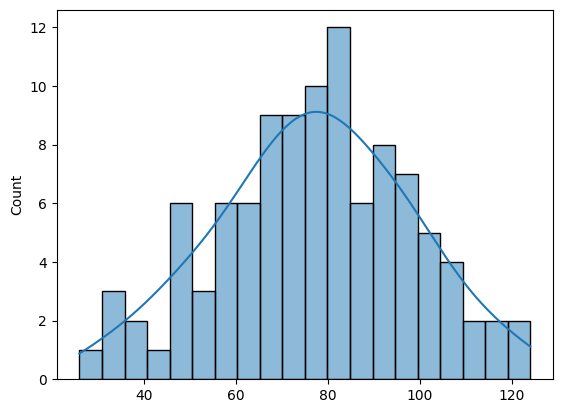

In [ ]:
#@title Plot distribution of random lcs-scores

import seaborn as sns

print("Distribution of lcs scores of %d sequences"%(len(acc2lcs_random)))

sns.histplot(data=acc2lcs_random.values(), kde=True, legend=False, binwidth=5)

In [ ]:
#@title Are there whale sequences with the Walker A motif?

walkerA = "G....GK[TS]"

atp_synthases = [acc for acc in acc2seq_all if len(re.findall(walkerA, acc2seq_all[acc]))>0]
print("There are %d sequences with the WalkerA motif G....GK[TS]"%len(atp_synthases))
print("Selected sequences: %s ..."%(" ".join(atp_synthases[:5])))

There are 1611 sequences with the WalkerA motif G....GK[TS]
Selected sequences: A0A383YN21_BALAS A0A383YN22_BALAS A0A383YN30_BALAS A0A384AWF6_BALAS A0A383YTX4_BALAS ...


In [ ]:
#@title Comparing the viral sarcoma sequence v-sis to whale

k=3 #@param {type:"integer"}

#P01128 · TSIS_WMSV
vsis="MTLTWQGDPIPEELYKMLSGHSIRSFDDLQRLLQGDSGKEDGAELDLNMTRSHSGGELESLARGKRSLGSLSVAEPAMIAECKTRTEVFEISRRLIDRTNANFLVWPPCVEVQRCSGCCNNRNVQCRPTQVQLRPVQVRKIEIVRKKPIFKKATVTLEDHLACKCEIVAAARAVTRSPGTSQEQRAKTTQSRVTIRTVRVRRPPKGKHRKCKHTHDKTALKETLGA"

# A0A384AP25_BALAS is second best Platelet-derived growth factor subunit B

acc2nmer_vsis = common_nmers_db(vsis,k, acc2seq_all)

print_top(acc2nmer_vsis, top=10, z=True)

Computing number of shared 3-mers for 32465 sequences


100%|██████████| 32465/32465 [00:05<00:00, 6402.10it/s]


Comparing 32465 nmers took 5 sec.
Mean is 24.26, stdev is 18.32
      1 202 9.70 A0A452CN02_BALAS  
      2 157 7.24 A0A384AP25_BALAS  
      3 152 6.97 A0A452C5T0_BALAS  
      4 151 6.92 A0A383YPL7_BALAS  
      5 151 6.92 A0A383YPR4_BALAS  
      6 151 6.92 A0A383YPX5_BALAS  
      7 151 6.92 A0A383YPY0_BALAS  
      8 151 6.92 A0A383YPY6_BALAS  
      9 151 6.92 A0A452C9A8_BALAS  
     10 151 6.92 A0A452C9B3_BALAS  


# AB02 Introduction to structures

We visualise proteins with PyMOL and highlight mutations and conformational changes.


Residues defining pocket: 45 88 169 170 171 175 
DYAMSVIVGRALPDVRDGLKPVHRRVLYAMNVLGNDWNKAYKKSARVVGDVIGKYHPHGDSAVYDTIVRMAQPFSLRYMLVDGQGNFGSIDGDSAAAMRYTEIRLAKIAHELMADLEKETVDFVDNYDGTEKIPDVMPTKIPNLLVNGSSGIAVGMATNIPPHNLTEVINGCLAYIDDEDISIEGLMEHIPGPDFPTAAIINGRRGIEEAYRTGRGKVYIRARAEVEVDAKTGRETIIVHEIPYQVNKARLIEKIAELVKEKRVEGISALRDESDKDGMRIVIEVKRDAVGEVVLNNLYSQTQLQVSFGINMVALHHGQPKIMNLKDIIAAFVRHRREVVTRRTIFELRKARDRAHILEALAVALANIDPIIELIRHAPTPAEAKTALVANPWQLGNVAAMLEDAARPEWLEPEFGVRDGLYYLTEQQAQAILDLRLQKLTGLEHEKLLDEYKELLDQIAELLRILGSADRLMEVIREELELVREQFGDKRRTEIT
                                             *              X   X                       *                                                                                ***   *                                                                                                                                                                                                                                                                                      

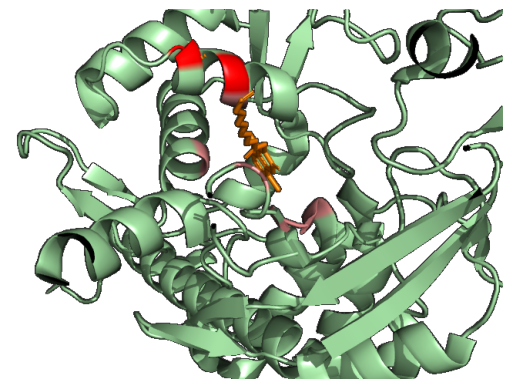

Took 8 sec.


In [ ]:
#@title Display antibiotic resistance mutations in E. coli GyrA

start=time.time()
cmd.delete("all")

try:
  cmd.load("2y3p.pdb", "gyra")
except:
  cmd.fetch("2y3p", "gyra", type="pdb")

cmd.remove("chain B")

cmd.hide("everything")
cmd.bg_color("white")

cmd.set("cartoon_color", "palegreen", "gyra")
cmd.set("surface_color", "palegreen", "gyra")

cmd.select("resis", "gyra and resi 83+87")
cmd.set("cartoon_color", "red", "resis")
cmd.set("surface_color", "red", "resis")

cmd.select("sm8", "resn SM8")
cmd.set("stick_color", "orange", "sm8")

cmd.select("pocket", "gyra and chain A within 5.0 of sm8")
cmd.set("cartoon_color", "salmon", "pocket")
cmd.set("surface_color", "salmon", "pocket")

cmd.orient("gyra")
cmd.zoom("gyra", -30)
cmd.show("cartoon", "gyra")
#cmd.show("surface", "gyra")
cmd.show("sticks", "sm8")




##################################################
#
# Marking the resistance mutations and
# residues of the quinolone binding pocket
# in sequence.
#
# The mutations are in position 83 and 87 in the
# Uniprot sequence. The PyMol/PDB sequences have
# a different numbering.
#
# The PDB sequence begins with DYAMSVIVGRAL.
# We search for this in the Uniprot sequence
# and find it at position 22. This is the offset
# we have to deduce from the PDB numbering to find
# the resistance residiues, i.e. instead of 83 and 87
# it is in the PDB sequence 61 and 65 and since we
# start count at 0 and not at 1 it is 60 and 64.
#
##################################################

# P0AES4 · GYRA_ECOLI
seq_uniprot = "MSDLAREITPVNIEEELKSSYLDYAMSVIVGRALPDVRDGLKPVHRRVLYAMNVLGNDWNKAYKKSARVVGDVIGKYHPHGDSAVYDTIVRMAQPFSLRYMLVDGQGNFGSIDGDSAAAMRYTEIRLAKIAHELMADLEKETVDFVDNYDGTEKIPDVMPTKIPNLLVNGSSGIAVGMATNIPPHNLTEVINGCLAYIDDEDISIEGLMEHIPGPDFPTAAIINGRRGIEEAYRTGRGKVYIRARAEVEVDAKTGRETIIVHEIPYQVNKARLIEKIAELVKEKRVEGISALRDESDKDGMRIVIEVKRDAVGEVVLNNLYSQTQLQVSFGINMVALHHGQPKIMNLKDIIAAFVRHRREVVTRRTIFELRKARDRAHILEALAVALANIDPIIELIRHAPTPAEAKTALVANPWQLGNVAAMLERAGDDAARPEWLEPEFGVRDGLYYLTEQQAQAILDLRLQKLTGLEHEKLLDEYKELLDQIAELLRILGSADRLMEVIREELELVREQFGDKRRTEITANSADINLEDLITQEDVVVTLSHQGYVKYQPLSEYEAQRRGGKGKSAARIKEEDFIDRLLVANTHDHILCFSSRGRVYSMKVYQLPEATRGARGRPIVNLLPLEQDERITAILPVTEFEEGVKVFMATANGTVKKTVLTEFNRLRTAGKVAIKLVDGDELIGVDLTSGEDEVMLFSAEGKVVRFKESSVRAMGCNTTGVRGIRLGEGDKVVSLIVPRGDGAILTATQNGYGKRTAVAEYPTKSRATKGVISIKVTERNGLVVGAVQVDDCDQIMMITDAGTLVRTRVSEISIVGRNTQGVILIRTAEDENVVGLQRVAEPVDEEDLDTIDGSAAEGDDEIAPEVDVDDEPEEE"
offset = seq_uniprot.find("DYAMSVIVGRAL")


print("Residues defining pocket: ", end="")
cmd.iterate("pocket and name CA", "print(resi, end=' ')")
print()

seq=cmd.get_fastastr("gyra")
seq_one_line="".join(seq.split("\n")[1:])

l = list(" "*len(seq_one_line))
for i in [45,88,169,170,171,175]:
  l[i]="*"
l[83-offset-1]="X"
l[87-offset-1]="X"
annotation = "".join(l)


print(seq_one_line)
print(annotation)

#print(seq.replace("DSAVYD","DsAVYd"))
#print("Search for sAVYd. s and d are the well-known resistance mutations")


cmd.rotate("x",190,"gyra")
cmd.rotate("y",310,"gyra")
cmd.rotate("z",10,"gyra")

save_png("gyra.png")
show_png("gyra.png")

print("Took %d sec."%(time.time()-start))


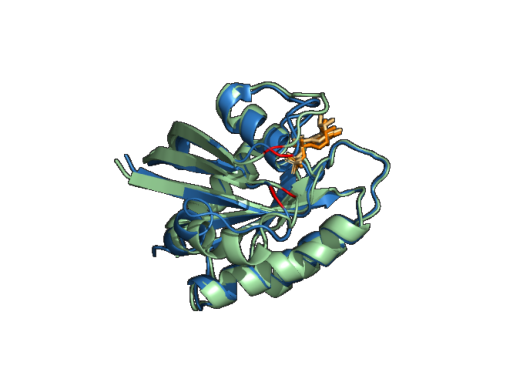

Took 4 sec.


In [ ]:
#@title Conformational changes in Ras upon ligand-binding


start=time.time()

if not "ras_gnp" in cmd.get_names("all") or not "ras_gdp" in cmd.get_names("all"):
  try:
    cmd.load("5p21.pdb", "ras_gnp")
    cmd.load("4q21.pdb", "ras_gdp")
  except:
    cmd.fetch("5p21", "ras_gnp", type="pdb")
    cmd.fetch("4q21", "ras_gdp", type="pdb")


cmd.orient("ras_gnp")
cmd.zoom("ras_gnp")

cmd.cealign("ras_gnp", "ras_gdp")
cmd.remove("hydrogens")
cmd.hide("everything")
cmd.bg_color("white")

cmd.select("gnp", "resn gnp")
cmd.select("gdp", "resn gdp")
cmd.select("resis", "resi 35+60")

cmd.set("cartoon_color", "palegreen", "ras_gnp")
cmd.set("surface_color", "palegreen", "ras_gnp")
cmd.set("cartoon_color", "skyblue", "ras_gdp")
cmd.set("surface_color", "skyblue", "ras_gdp")

# switch 1 residues
cmd.set("cartoon_color", "red", "resis")
cmd.set("surface_color", "red", "resis")

cmd.set("stick_color", "lightorange", "gnp")
cmd.set("stick_color", "orange", "gdp")

cmd.show("cartoon", "ras_gnp")
cmd.show("cartoon", "ras_gdp")
#cmd.show("surface", "ras_gnp")
#cmd.show("surface", "ras_gdp")
cmd.show("sticks", "gnp")
cmd.show("sticks", "gdp")


save_png("ras.png")
show_png("ras.png")
print("Took %d sec."%(time.time()-start))



In [ ]:
#@title Fetch single-strand annealing proteins Rad52 and Redbeta

start=time.time()

cmd.delete("all")
cmd.fetch("1kn0", "rad52")
cmd.fetch("7ujl", "redb")

cmd.select("resis", "rad52 and resi 55+65+152+156+153")
cmd.select("resis2", "redb and chain A within 5.0 of (redb and chain B) or (redb and chain C)")

cmd.remove("hydrogens")
cmd.bg_color("white")

cmd.set("cartoon_color", "palegreen", "redb")
cmd.set("cartoon_color", "skyblue", "rad52")
cmd.set("cartoon_color", "red", "resis")
cmd.set("cartoon_color", "red", "resis2")

cmd.set("surface_color", "palegreen", "redb")
cmd.set("surface_color", "skyblue", "rad52")
cmd.set("surface_color", "red", "resis")
cmd.set("surface_color", "red", "resis2")
print("Took %d sec."%(time.time()-start))


In [ ]:
#@title Visulaise SSAPs. Apply dropdown menu in order from ring to monomer.

dropdown = 'redb_monomer' # @param ["ring_top", "ring_side", "ring_side_cartoon", "rad52_monomer", "rad52_monomer_close", "both_monomers", "redb_monomer"]
start=time.time()


def a():
    cmd.hide("everything")
    cmd.orient("rad52")
    cmd.zoom("rad52",10)
    cmd.show("surface", "rad52")

def b():
    cmd.rotate("x",-45,"rad52")

def c():
    cmd.hide("everything")
    cmd.show("cartoon", "rad52")


def d():
    cmd.hide("everything")
    cmd.show("cartoon","rad52 and chain A")

def e():
    cmd.zoom("rad52 and chain A")

def f():
    cmd.cealign("rad52 and chain A","redb and chain A")
    cmd.hide("everything")
    cmd.show("cartoon","rad52 and chain A")
    cmd.show("cartoon","redb and chain A")

def g():
    cmd.hide("everything")
    cmd.show("cartoon","redb and chain A")

if dropdown == "ring_top": a()
elif  dropdown ==  "ring_side": b()
elif  dropdown ==  "ring_side_cartoon": c()
elif  dropdown ==  "rad52_monomer": d()
elif  dropdown ==  "rad52_monomer_close": e()
elif  dropdown ==  "both_monomers": f()
elif  dropdown ==  "redb_monomer": g()

png = "ssap_"+dropdown+".png"
save_png(png)
show_png(png)
print("Took %d sec."%(time.time()-start))

In [ ]:
!wget http://www.rcsb.org/pdb/files/2y3p.pdb.gz # gyrA
!gunzip 2y3p.pdb.gz

In [ ]:
!pip install biopython

#Here, we import Bio.PDB to use it to manipulate PDB files
from Bio.PDB import *
#And we set up a parser for our PDB
parser = PDBParser()
io=PDBIO()
structure = parser.get_structure('X', '2y3p.pdb')

#This will separate each chain into its own PDB file
for chain in structure.get_chains():
    io.set_structure(chain)
    io.save("2y3p" + chain.get_id() + ".pdb")

In [ ]:
!pip install py3Dmol

In [ ]:
import py3Dmol

view=py3Dmol.view()
view.addModel(open('2y3pA.pdb', 'r').read(),'pdb')
#view.zoomTo({'chain':'A','resi':83})
view.setBackgroundColor('white')
view.setStyle({'chain':'A'},{'cartoon': {'color':'palegreen'}})
view.addStyle({'chain':'A','resi':'83-87'}, {'cartoon':{'color':'red'}})
view.addStyle({'chain':'A'},{'resi':'901'},{'sticks': {'color':'orange'}}) #SM8
view.addSurface(py3Dmol.VDW,{'opacity':0.5,'color':'palegreen'}, {'chain':'A'})
view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

#AB03 Python and Computing


In [ ]:
# The first programme "hello world"
print("Hello world!")

In [ ]:
#@title Resources. Check read/write/retrieve speed. how_many_mb=10
import time, os
from tqdm import tqdm

how_many_mb = 10 #@param {type:"integer"}

print("Go to the menu entry runtime/Laufzeit and select resources and check how much RAM and disk space you have.")

mb = 1024*10124
n = how_many_mb * mb

def write_file(n):
  start = time.time()
  f = open("delete_me.txt","w")
  for i in tqdm(range(n)):
    f.write("\n")
  f.close()
  duration = time.time()-start
  print("Writing took %d sec, i.e. %.2f MB/s"%(duration, how_many_mb/duration))

def read_file():
  start = time.time()
  f = open("delete_me.txt","w")
  for line in open("delete_me.txt"):
    continue
  duration = time.time()-start
  print("Reading took %d sec, i.e. %.2f MB/s"%(duration, how_many_mb/duration))

def retrieve_file():
  start = time.time()
  acc2seq_all,acc2species_all,acc2uniprot_all = load_data("%28%28taxonomy_id%3A9767%29%29")
  duration = time.time()-start
  how_many_mb = os.path.getsize("seq.txt") / mb
  print("Retrieving took %d sec, i.e. %.2f MB/s"%(duration, how_many_mb/duration))


write_file(n)
read_file()

try:
  retrieve_file()
except:
  print("Make sure 'Code to download sequences from UniProt' from AB01 was executed.")


Go to the menu entry runtime/Laufzeit and select resources and check how much RAM and disk space you have.


100%|██████████| 103669760/103669760 [00:44<00:00, 2320953.66it/s]


Writing took 44 sec, i.e. 0.22 MB/s
Reading took 0 sec, i.e. 435.19 MB/s
Retrieving took 13 sec, i.e. 0.19 MB/s


In [ ]:
#@title Similar sequences are more compressible than dissimilar ones. Gzip for science.
import os

# How large are the whale files? How compressible are they?

# get file size uncompressed
w1=os.path.getsize("whale1.txt")
w2=os.path.getsize("whale2.txt")


!gzip whale*.txt

# get file size compressed
w1gz=os.path.getsize("whale1.txt.gz")
w2gz=os.path.getsize("whale2.txt.gz")

!gunzip whale*.txt.gz

# print compression rate, ratio zipped to unzipped
print("Compression rate:")
print("RNAS1 sequences: %.2f%%"%(100*w1gz/w1))
print("All whale sequences: %.2f%%"%(100*w2gz/w2))


Compression rate:
RNAS1 sequences: 20.87%
All whale sequences: 38.88%


In [ ]:
#@title Complexity. Get a feeling for runtimes. For exponential n=22 is good.
import time

n=22 #@param {type:"integer"}
include_quadratic = True #@param {type:"boolean"}
include_exponential = True #@param {type:"boolean"}


l = list(range(n))

start = time.time()
a = l[0]
print("Constant. Took %d sec"%(time.time()-start))

start = time.time()
a = sum(l)
print("Linear. Took %d sec"%(time.time()-start))

if include_quadratic:
  start = time.time()
  for i in l:
    for j in l:
      continue
  print("Quadratic. Took %d sec"%(time.time()-start))


def powerset(l):
  if l==[]:
    return [[]]
  else:
    e = l[0]
    ps1 = powerset(l[1:])
    ps2 = [ps+[e] for ps in ps1]
    return ps1+ps2

if include_exponential:
  start = time.time()
  print("There are %d powersets"%(len(powerset(l))))
  print("Exponential. Took %d sec"%(time.time()-start))



Constant. Took 0 sec
Linear. Took 0 sec
Quadratic. Took 0 sec
There are 4194304 powersets
Exponential. Took 9 sec


In [ ]:
#@title Some basic python

s = "This is a string"
i = 2
f = 1.1234
b = True

# And some example uses
print(s, i, f, b, i/f, not b)
print(s[i], s[0], s[0:6], s[-1], s[-17:])

# As we print a lot, there are some convient formatting options
# Use %s %d %f as placeholder for strings, integers, and floats
print("s = %s, i = %d, f = %.2f"%(s,i,f))

print("------------------------")

# Data structures
l = [1,2,3,"green", "acgt", 1.2]
print(l)
print(l[0])
print(l[-1])
print(l[0:4])

# Very useful is something called list comprehension
# It's a combination of lists and loops
l2 = [e for e in l if isinstance(e,int)]
print(l2)
l2 = [e for e in l if isinstance(e,str)]
print(l2)
l2 = [2*e for e in l if isinstance(e,int)]
print(l2)

print("------------------------")

# There are many functions for lists
print(min([1,2,3,4]))
print(sum([1,2,3,4]))
print(len([1,2,3,4]))


print("------------------------")

# Lists can be sorted
print(sorted([5,4,3,7]))

# List can be tuples and can still be sorted
t = ("Michael", 1)
print(t[0])
print(t[1])
l = [("Maria",3), ("Sue",2)]
l.append(t)
print(sorted(l, key = lambda t: t[1]))


print("------------------------")

# Dictionaries are useful data structures

d = {}
d["Michael"] = 180
d["Maria"] = 168
d["Sue"] = 183
print(d["Sue"])
print(list(d.keys()), list(d.values()), list(d.items()))
if not "Pete" in d: print("Pete is not in the dictionary")

print("------------------------")


Hello world!
------------------------
This is a string 2 1.1234 True 1.7803097739006588 False
i T This i g This is a string
s = This is a string, i = 2, f = 1.12
------------------------
[1, 2, 3, 'green', 'acgt', 1.2]
1
1.2
[1, 2, 3, 'green']
[1, 2, 3]
['green', 'acgt']
[2, 4, 6]
------------------------
1
10
4
------------------------
[3, 4, 5, 7]
Michael
1
[('Michael', 1), ('Sue', 2), ('Maria', 3)]
------------------------
183
['Michael', 'Maria', 'Sue'] [180, 168, 183] [('Michael', 180), ('Maria', 168), ('Sue', 183)]
Pete is not in the dictionary
------------------------
False
True


# AB04 Substitution matrices

In [ ]:
#@title Frequency distribution of amino acids in whale proteins
from collections import defaultdict

aa_freq=defaultdict(int)

print("Frequencies of amino acids from %d whale protein sequences"%(len(acc2seq_all)))

for seq in acc2seq_all.values():
  for aa in seq:
    aa_freq[aa]+=1

aa_total = sum(aa_freq.values())

for aa,freq in sorted(aa_freq.items(), key=lambda x:x[1], reverse=True):
  if aa not in "XUZB": # don't print undefined AA
    print("%s %.1f%%"%(aa,100*freq/aa_total))

Amino acid substitution matrices from protein blocks, Henikoff et al. PNAS, 1992

Total number of amino acid $i,j$ pairs ($1\le j \le i \le 20$) for each entry of the frequency table be $f_{ij}$. Then the observed probability is:

$$ q_{ij} = f_{ij} / \sum_{i=1}^{20} \sum_{j=1}^{i} f_{ij}$$

The probablity of the occurance of amino acid in an $i,j$ pair, is

$$ p_i = q_{ii} + \sum_{j\neq i} q_{ij}/2$$

The expected probability of occurance  is

$$e_{ij} = \begin{cases}
p_ip_j &\text{ for } i=j\\
2p_ip_j &\text{ for } i\neq j
\end{cases}$$

A lod ratio is then calculated in bit units as $$s_{ij} = log_2(q_{ij}/e_{ij})$$

All the formulae in one go:

$$f_{ij} \text{ for } 1\le j \le i \le 20$$

$$q_{ij} = f_{ij} / \sum_{i=1}^{20} \sum_{j=1}^{i} f_{ij}$$

$$ p_i = q_{ii} + \sum_{j\neq i} q_{ij}/2$$

$$e_{ij} = \begin{cases}
p_ip_j &\text{ for } i=j\\
2p_ip_j &\text{ for } i\neq j
\end{cases}$$

$$s_{ij} = log_2(q_{ij}/e_{ij})$$

In [ ]:
#@title Generating a substituion matrix from whale proteins with k-mers

from collections import defaultdict
from tqdm import tqdm
import math
from itertools import combinations_with_replacement, product
from tabulate import tabulate

how_many = 100 #@param {type:"integer"}
k = 3 #@param {type:"integer"}

n = 2*k+1

amino_acids = "ACDEFGHIKLMNPQRSTVWY"

def print_tab(d):
  rows=[]
  row = [""]
  row.extend(amino_acids)
  rows.append(row)
  for aa1 in amino_acids:
    row = [aa1]
    for aa2 in amino_acids:
      if (aa1,aa2) in d:
        v=d[aa1,aa2]
      else:
        v=""
      row.append(v)
    rows.append(row)
  print(tabulate(rows))

def create_f(how_many):
  d = defaultdict(list)
  for seq in tqdm(list(acc2seq_all.values())[:how_many]):
    length = len(seq)
    for i in range(length-n):
      word = seq[i:i+n]
      aa = word[k]
      word = word[:k]+"*"+word[k+1:]
      if aa not in "XUZB":
        d[word].append(aa)

  f={pair:0 for pair in combinations_with_replacement(amino_acids, 2)}

  for aas in tqdm(d.values()):
    d2 = defaultdict(int)
    for aa in aas:
      d2[aa]+=1
    for (aa1,aa2) in combinations_with_replacement(sorted(d2.keys()),2):
        f[(aa1,aa2)]+=d2[aa1]*d2[aa2]
  return f


def sum_q(aa,q):
  s=0
  for aa2 in amino_acids:
    if aa!=aa2:
      if (aa,aa2) in q:
         s+=q[aa,aa2]
      elif (aa2,aa) in q:
         s+=q[aa2,aa]
  return s/2

f = create_f(how_many)
total_f = sum(f.values())


q = {pair: f[pair] / total_f for pair in combinations_with_replacement(amino_acids, 2)}

p = {aa: q[aa,aa] + sum_q(aa,q) for aa in amino_acids}

e = {(aa1,aa2): p[aa1] * p[aa2] for (aa1,aa2) in combinations_with_replacement(amino_acids, 2)}

def score(pair):

  if not pair in q and not pair in e and pair[::-1] in q and pair[::-1] in e:
    pair = pair[::-1]
  if pair in q and q[pair]!=0 and pair in e:
    return round(math.log2(q[pair] / e[pair]))
  else:
    return 0

whale_sm = {pair: score(pair) for pair in product(amino_acids, repeat=2)}



print_tab(whale_sm)



100%|██████████| 37241/37241 [00:00<00:00, 282384.90it/s]

-  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --
   A   C   D   E   F   G   H   I   K   L   M   N   P   Q   R   S   T   V   W   Y
A  4   0   0   -6  -8  -8  -6  -7  0   -7  -6  -5  0   -8  -6  -7  -9  -8  0   -7
C  0   5   0   0   0   0   0   0   0   0   -4  0   -7  0   0   0   0   0   0   0
D  0   0   4   -8  0   -5  0   0   0   0   0   0   -6  -7  0   0   0   0   0   -6
E  -6  0   -8  4   0   0   0   0   0   0   -4  0   0   -6  -9  -9  -9  -8  0   0
F  -8  0   0   0   5   0   0   -6  0   -9  0   -8  0   -8  0   0   0   -8  0   -6
G  -8  0   -5  0   0   4   0   0   -9  -8  0   0   0   0   0   -9  0   0   0   0
H  -6  0   0   0   0   0   5   0   0   -8  0   0   0   -6  0   0   -6  0   0   -6
I  -7  0   0   0   -6  0   0   4   0   -7  -3  0   0   0   -6  0   -6  -4  0   0
K  0   0   0   0   0   -9  0   0   4   0   -6  -5  0   -7  -4  -9  0   0   0   0
L  -7  0   0   0   -9  -8  -8  -7  0   3   -3  -9  0   -7  -7  0   0   -6  -7  0
M  -6  -4  0   -4  0   

In [ ]:
#@title Load substitution matrices

fns=['BLOSUM45', 'BLOSUM50', 'BLOSUM62', 'BLOSUM80', 'BLOSUM90','PAM30', 'PAM70', 'PAM250']

sm={}
for fn in fns:
  sm[fn] = get_substitution_matrix(fn)

print("Loaded matrices %s"%", ".join(fns))

BLOSUM62 min: -4, max: 11
Whale min: -9, max: 6

Distribution of values in BLOSUM62 (blue) and Whale (orange)


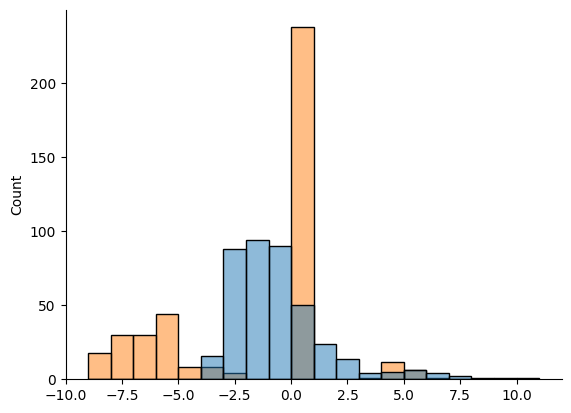

Correlation of BLOSUM62 and Whale (correlation coefficient is 0.11 (Pearson) and -0.10 (Spearman))


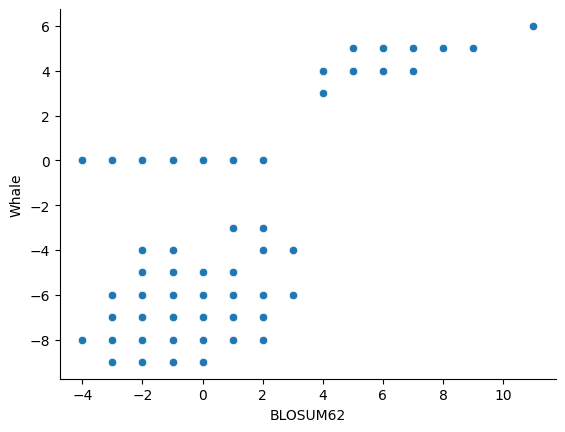

BLOSUM62 wrt. Whale


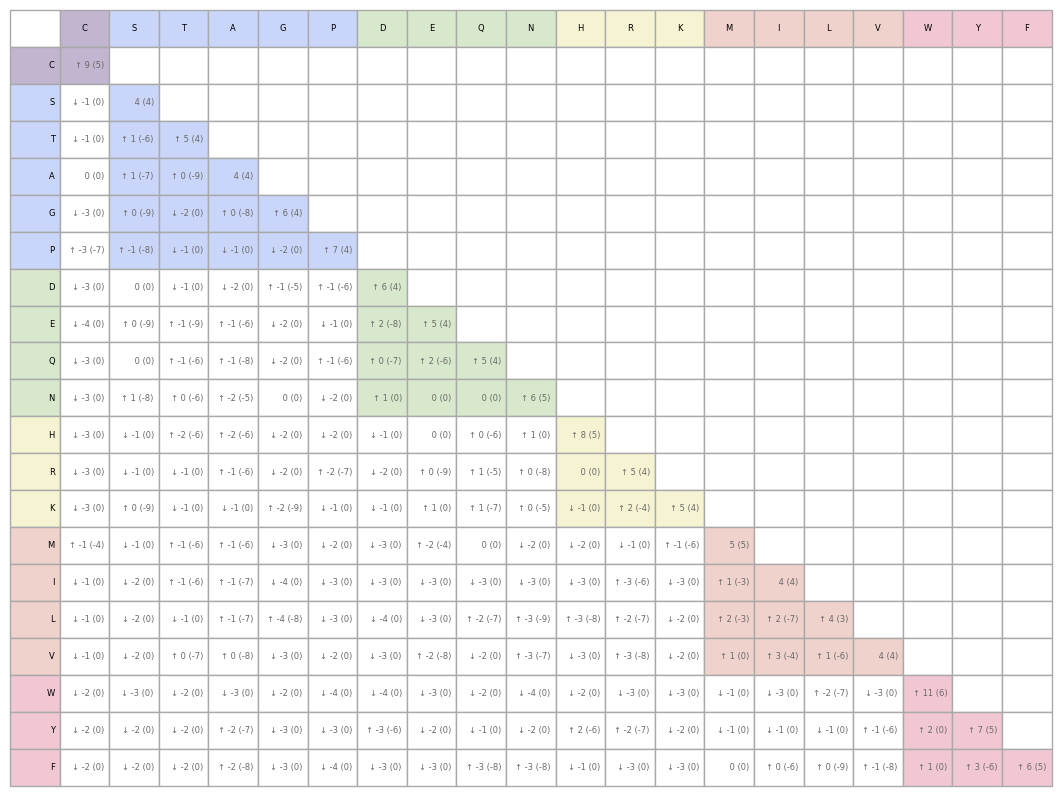

In [ ]:
#@title Compare substitution matrices

from tabulate import tabulate
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sys

sm1 = 'BLOSUM62' # @param ['BLOSUM45', 'BLOSUM50', 'BLOSUM62', 'BLOSUM80', 'BLOSUM90','PAM30', 'PAM70', 'PAM250','Whale']
sm2 = 'Whale' # @param ['BLOSUM45', 'BLOSUM50', 'BLOSUM62', 'BLOSUM80', 'BLOSUM90','PAM30', 'PAM70', 'PAM250','Whale']
style = 'all' # @param ['all', 'one', 'diff', 'arrow']

aminoacids = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
aminoacids = list("CSTAGPDEQNHRKMILVWYF")

ARROW_N = "\u2191"
ARROW_S="\u2193"

LIGHTGREY="#DCDCDC"
GREY="#A9A9A9"
DARKGREY="#696969"
BLACK ="#000000"
BLUE="#cad6f9"
RED = "#f2c7d4"
PURPLE = "#c1b5d0"
GREEN="#d8e8cc"
YELLOW="#f6f3d2"
ORANGE="#efd2cc"


def aa2str(aa1,aa2,fn1,fn2,style="one"):
    if style== "one":
      return sm[fn1][(aa1,aa2)]
    elif style == "diff":
      return sm[fn1][(aa1,aa2)]-sm[fn2][(aa1,aa2)]
    elif style == "arrow":
      if sm[fn1][(aa1,aa2)] == sm[fn2][(aa1,aa2)]: return ""
      elif sm[fn1][(aa1,aa2)] > sm[fn2][(aa1,aa2)]: return ARROW_N
      elif sm[fn1][(aa1,aa2)] < sm[fn2][(aa1,aa2)]: return ARROW_S
    elif style == "all":
      if sm[fn1][(aa1,aa2)] == sm[fn2][(aa1,aa2)]: arrow = ""
      elif sm[fn1][(aa1,aa2)] > sm[fn2][(aa1,aa2)]: arrow = ARROW_N
      elif sm[fn1][(aa1,aa2)] < sm[fn2][(aa1,aa2)]: arrow = ARROW_S
      return "%s %d (%d)"%(arrow,sm[fn1][(aa1,aa2)], sm[fn2][(aa1,aa2)])

def aa2col(aa):
  if aa in "C": return PURPLE
  elif aa in "STAGP": return BLUE
  elif aa in "DEQN": return GREEN
  elif aa in "HRK": return YELLOW
  elif aa in "MILV": return ORANGE
  elif aa in "WFY": return RED
  return ""

def aaaa2col(aa1,aa2):
  if aa2col(aa1)==aa2col(aa2): return aa2col(aa1)
  else: return ""


def print_sm2(fn1,fn2):

  fig, ax = plt.subplots()

  columns =    ["  "]+aminoacids

  colors =    [list("w"*(21)) for i in range(20)]
  cell_text = [list(" "*(21)) for i in range(20)]

  the_table = ax.table(cellText=cell_text, cellColours=colors, colLabels=columns, cellLoc='right', loc='center')

  for i in range(21):
    for j in range(21):
      the_table[i,j].set_edgecolor(GREY)
      the_table[i,j].get_text().set_color(DARKGREY)
      the_table[i,j].set_height(0.1)
      the_table[i,j].set_width(0.1)

  # first row
  for j in range(20):
    aa = aminoacids[j]
    the_table[0,j+1].set_facecolor(aa2col(aa))
    the_table[0,j+1].get_text().set_color(BLACK)
    the_table[0,j+1].loc="center"

  # first column
  for i in range(20):
    aa = aminoacids[i]
    the_table[i+1,0].get_text().set_text(aa)
    the_table[i+1,0].loc="center"
    the_table[i+1,0].set_facecolor(aa2col(aa))
    the_table[i+1,0].get_text().set_color(BLACK)

  for i in range(20):
      for j in range(i+1):
        aa1 = aminoacids[i]
        aa2 = aminoacids[j]
        if aaaa2col(aa1,aa2)!="":
          the_table[i+1,j+1].set_facecolor(aaaa2col(aa1,aa2))

        s = aa2str(aa1,aa2,fn1,fn2, style=style)
        the_table[i+1,j+1].get_text().set_text(s)



  ax.axis('tight')
  the_table.set_fontsize(10)
  ax.axis('off')
  fn_png=fn1+".png"
#  plt.savefig(fn_png)
  if style == "one":
    print(sm1)
  else:
    print("%s wrt. %s"%(sm1,sm2))
  plt.show()
#  plt.close()


if sm1=="Whale" or sm2=="Whale":
  if not "whale_sm" in locals() and not "whale_sm" in globals():
    print("First compute a whale subsitution matrix")
    sys.exit()
  else:
    sm["Whale"]=whale_sm



print("%s min: %d, max: %d"%(sm1, min(sm[sm1].values()), max(sm[sm1].values())))
print("%s min: %d, max: %d"%(sm2, min(sm[sm2].values()), max(sm[sm2].values())))
print()

print("Distribution of values in %s (blue) and %s (orange)"%(sm1,sm2))
sns.histplot([sm[sm1].values(),sm[sm2].values()], color=['r','b'], legend=False, binwidth=1, alpha=0.5)
sns.despine()
plt.show()


x=[]
y=[]
for pair,score in sm[sm1].items():
    x.append(score)
    y.append(sm[sm2][pair])

import scipy.stats
(r1,p1) =scipy.stats.pearsonr(x, y)
(r2,p2)= scipy.stats.spearmanr(x, y)

print("Correlation of %s and %s (correlation coefficient is %.2f (Pearson) and %.2f (Spearman))"%(sm1,sm2,r1,r2))

plt.xlabel(sm1)
plt.ylabel(sm2)

sns.scatterplot(x=x,y=y)
sns.despine()
plt.show()

print_sm2(sm1,sm2)


In [ ]:
#@title Whale, horse, and kangaroo RNAS1 with substitution matrix

w=acc2seq["RNAS1_BALAC"]
h=acc2seq["RNAS1_HORSE"]
k=acc2seq["RNAS1_OSPRU"]

def print_matches(s1,s2):
  print(s1)
  for i in range(min(len(s1), len(s2))):
    s=" "
    if s1[i]==s2[i]: s="*"
    elif blosum62[(s1[i],s2[i])]>0: s="."
    print(s, end="")
  print()
  print(s2)

print_matches(w,h)
print()
print_matches(w[1:],k)

RESPAMKFQRQHMDSGNSPGNNPNYCNQMMMRRKMTQGRCKPVNTFVHESLEDVKAVCSQKNVLCKNGRTNCYESNSTMHITDCRQTGSSKYPNCAYKTSQKEKHIIVACEGNPYVPVHFDNSV
.*******.*******..  .** ****** ** **** ********** * **.*.* ***. ****..***.*.*.******* *  ********.*****.***************** **
KESPAMKFERQHMDSGSTSSSNPTYCNQMMKRRNMTQGWCKPVNTFVHEPLADVQAICLQKNITCKNGQSNCYQSSSSMHITDCRLTSGSKYPNCAYQTSQKERHIIVACEGNPYVPVHFDASVEVST

ESPAMKFQRQHMDSGNSPGNNPNYCNQMMMRRKMTQGRCKPVNTFVHESLEDVKAVCSQKNVLCKNGRTNCYESNSTMHITDCRQTGSSKYPNCAYKTSQKEKHIIVACEGNPYVPVHFDNSV
*.** ********. .*  .. **** **  * ** *****.***.**    * *** *.** *********.*** . **.*****.****** *.**   * *******           
ETPAEKFQRQHMDTEHSTASSSNYCNLMMKARDMTSGRCKPLNTFIHEPKSVVDAVCHQENVTCKNGRTNCYKSNSRLSITNCRQTGASKYPNCQYETSNLNKQIIVACEGQYVPVHFDAYV


In [ ]:
#@title Needleman-Wunsch Algorithm

a="PETRA" #@param {type:"string"}
b="PETER" #@param {type:"string"}



def nw(a,b):
  """Computes the Needleman-Wunsch algorithm."""

  gap = -1
  m = len(a)
  n = len(b)
  d={}

  # Initialise the first column
  for i in range(0,m+1):
    d[i,0] = i*gap

  # Initialise the first row
  for j in range(0,n+1):
    d[0,j] = j*gap

  # Fill all cells of the matrix
  for i in range(1,m+1):
    for j in range(1,n+1):
      # Get the maximum of the scores N, W, and NW .
      d[i,j] = max(d[i-1,j]+gap,
                   d[i ,j-1]+gap,
                   d[i-1,j-1] + blosum62[a[i-1],b[j-1]])

  return d[m,n]

print("NW=%d"%nw(a,b))

NW=20


In [ ]:
#@title Needleman-Wunsch of RNAS1 against random whale proteins
acc2nw_random = apply_to_all(nw, whale, acc2seq_all_random)

print()
print_top(acc2nw_random, selected_accs=selected_accs, top=10, z=True)


Computing nw for 14 sequences.


100%|██████████| 14/14 [00:01<00:00,  7.52it/s]


Took 1 sec.

Mean is -89.43, stdev is 822.45
-->   1 688 0.95 RNAS1_BALAC  
-->   2 563 0.79 RNAS1_HIPAM  
-->   3 553 0.78 RNAS1_HORSE  
-->   4 470 0.68 RNAS1_OSPRU  
      5 168 0.31 A0A452CAB7_BALAS  
      6 158 0.30 A0A384B3Y1_BALAS  
      7 142 0.28 A0A384ALI9_BALAS  
      8 125 0.26 A0A384ADP5_BALAS  
      9 106 0.24 A0A384API1_BALAS  
     10  65 0.19 A0A383Z7B6_BALAS  


In [ ]:
#@title print_d. Generate gif for matrix d. For short strings only

import matplotlib.pyplot as plt
from tqdm import tqdm
import contextlib
from PIL import Image
import IPython
import os
from tabulate import tabulate


a="PER" #@param {type:"string"}
b="PE" #@param {type:"string"}
duration=500 #@param {type:"integer"}
algorithm  = 'lcs' # @param ["nw", "lcs"]
show_path=False #@param {type:"boolean"}

LIGHTGREY="#DCDCDC"
GREY="#A9A9A9"
DARKGREY="#696969"
BLACK ="#000000"
ARROW_N = "\u2191"
ARROW_W="\u2190"
ARROW_NW="\u2196"


def print_d(d,a,b,k,highlight=[]):

  m=len(a)
  n=len(b)

  fig, ax = plt.subplots()

  columns =    list("  "+b)
  colors =    [list("w"*(n+2)) for i in range(m+1)]
  cell_text = [list(" "*(n+2)) for i in range(m+1)]

  for i in range(m+1):
    for j in range(n+1):
      if (i,j) in d:
        (score,dir) = d[i,j]
        cell_text[i][j+1] = dir+str(score)

  the_table = ax.table(cellText=cell_text, cellColours=colors, colLabels=columns, cellLoc='right', loc='center')

  for i in range(m+2):
    for j in range(n+2):
      the_table[i,j].set_edgecolor(GREY)
      the_table[i,j].get_text().set_color(DARKGREY)
      the_table[i,j].set_height(0.1)
      the_table[i,j].set_width(0.1)

  # first row
  for j in range(n+2):
    the_table[0,j].set_facecolor(LIGHTGREY)
    the_table[0,j].get_text().set_color(BLACK)
    the_table[0,j].loc="center"

  # first column with centered characters in black on grey background
  for i in range(m+2):
    the_table[i,0].get_text().set_text(list("  "+a)[i])
    the_table[i,0].loc="center"
    the_table[i,0].set_facecolor(LIGHTGREY)
    the_table[i,0].get_text().set_color(BLACK)

  for (i,j,face_color, text_color) in highlight:
    the_table[i+1,j+1].set_facecolor(face_color)
    the_table[i+1,j+1].get_text().set_color(text_color)


  ax.axis('tight')
  the_table.set_fontsize(10)
  ax.axis('off')
  fn_png=k2fn(k)
  plt.savefig(fn_png)
  plt.close()
  return k+1




def get_path(d,i,j):
  if i==0 and j==0:
    return [(0,0)]
  else:
    (score,dir) = d[i,j]
    path = [(i,j)]
    if ARROW_NW in dir: next_path = get_path(d,i-1,j-1)
    elif ARROW_N in dir: next_path = get_path(d,i-1,j)
    elif ARROW_W in dir: next_path = get_path(d,i,j-1)
    return path + next_path


def max_dir(a,b,c):
  dir = ""
  m = max(a,b,c)
  if a==m: dir+=ARROW_N
  if b==m: dir+=ARROW_W
  if c==m: dir+=ARROW_NW
  return (m,dir)


def col4dir(arrow, dir):
  if arrow in dir:
    return "red"
  else:
    return "mistyrose"



def print_nw(a,b):

  if algorithm == "lcs":
    gap = 0 # lcs
  elif algorithm == "nw":
    gap = -1 # nw

  m = len(a)
  n = len(b)
  d={}

  k = 0

  k=print_d(d,a,b,k)

  for i in range(0,m+1):
    d[i,0] = (i*gap,"")
    ij=[(i,0,"red","black")]
    k=print_d(d,a,b,k, highlight=ij)

  for j in range(0,n+1):
    d[0,j] = (j*gap,"")
    ij=[(0,j,"red","black")]
    k=print_d(d,a,b,k, highlight=ij)

  for i in tqdm(range(1,m+1)):
    for j in range(1,n+1):

      if algorithm == "lcs":
        match_score = int(a[i-1]==b[j-1]) # lcs
      elif algorithm == "nw":
        match_score = blosum62[a[i-1],b[j-1]] # nw

      (score,dir) = max_dir(d[i-1,j][0]  + gap,
                            d[i ,j-1][0]  + gap,
                            d[i-1,j-1][0] + match_score)

      n_w_nw = [(i-1,j,"mistyrose","black"),(i,j-1,"mistyrose","black"),(i-1,j-1,"mistyrose","black")]#, (i,j,"mistyrose","black")]
      k=print_d(d,a,b, k, highlight=n_w_nw)

      n_w_nw = [(i-1,j,col4dir(ARROW_N,dir),"black"),(i,j-1,col4dir(ARROW_W,dir),"black"),(i-1,j-1,col4dir(ARROW_NW,dir),"black")]#, (i,j,"mistyrose","black")]
      k=print_d(d,a,b,k, highlight=n_w_nw)

      n_w_nw = [(i-1,j,col4dir(ARROW_N,dir),"black"),(i,j-1,col4dir(ARROW_W,dir),"black"),(i-1,j-1,col4dir(ARROW_NW,dir),"black"), (i,j,"mistyrose","black")]
      k=print_d(d,a,b,k, highlight=n_w_nw)

      d[i,j] = (score,dir)


      ij=[(i,j,"red","black")]
      k=print_d(d,a,b,k, highlight=ij)

  k=print_d(d,a,b,k)
  if show_path:
    path = get_path(d,m,n)

    ijs = []
    for (i,j) in tqdm(path):
      ijs.append((i,j,"red","black"))
      k=print_d(d,a,b,k, highlight=ijs)

  png2gif(k)



def k2fn(k):
  return "pic%04d.png"%k



def png2gif(k):

  fp_in = [k2fn(i) for i in range(k)]
  fp_out = "pic.gif"
  with contextlib.ExitStack() as stack:
    imgs = (stack.enter_context(Image.open(f)) for f in fp_in)
    img = next(imgs)
    img.save(fp=fp_out, format='GIF', append_images=imgs, save_all=True, duration=duration, loop=0)
  tar_files = " ".join(fp_in)
  !tar -czf pic.tar.gz {tar_files}
  for i in range(k): os.remove(k2fn(i))

if len(a)>10 or len(b)>10:
  print("Limit a and b to short strings (<10) otherwise it takes too long")
else:
  print_nw(a,b)
  IPython.display.Image(filename="pic.gif",embed=True)
  print("pic.gif and pic.tar.gz ready for download.")

100%|██████████| 3/3 [00:03<00:00,  1.14s/it]


pic.gif and pic.tar.gz ready for download.


In [ ]:
#@title print_d_txt: Textual print out of matrix d. Works also for larger sequences

from tqdm import tqdm
from tabulate import tabulate

algorithm  = 'nw' # @param ["nw", "lcs"]

# RNAS1
#whale = "RESPAMKFQRQHMDSGNSPGNNPNYCNQMMMRRKMTQGRCKPVNTFVHESLEDVKAVCSQKNVLCKNGRTNCYESNSTMHITDCRQTGSSKYPNCAYKTSQKEKHIIVACEGNPYVPVHFDNSV"
#horse = "KESPAMKFERQHMDSGSTSSSNPTYCNQMMKRRNMTQGWCKPVNTFVHEPLADVQAICLQKNITCKNGQSNCYQSSSSMHITDCRLTSGSKYPNCAYQTSQKERHIIVACEGNPYVPVHFDASVEVST"
#kangaroo = "ETPAEKFQRQHMDTEHSTASSSNYCNLMMKARDMTSGRCKPLNTFIHEPKSVVDAVCHQENVTCKNGRTNCYKSNSRLSITNCRQTGASKYPNCQYETSNLNKQIIVACEGQYVPVHFDAYV"

whale = "RESPAMKFQRQHMDSGNSPGNNPNY"
horse=  "KESPAMKFERQHMDSGSTSSSNPTY"


ARROW_N = "\u2191"
ARROW_W="\u2190"
ARROW_NW="\u2196"


def print_d_txt(d,a,b,m,n):
  rows=[]
  rows.append(list("  "+b))
  a = " "+a
  for i in range(m+1):
    row=[a[i]]
    for j in range(n+1):
      (score,dir) = d[i,j]
      row.append(dir+" "+str(score))
    rows.append(row)
  return tabulate(rows, stralign="right")


def max_dir(a,b,c):
  dir = ""
  m = max(a,b,c)
  if a==m: dir+=ARROW_N
  if b==m: dir+=ARROW_W
  if c==m: dir+=ARROW_NW
  return (m,dir)


def print_nw_txt(a,b):

  if algorithm == "lcs":
    gap = 0 # lcs
  elif algorithm == "nw":
    gap = -1 # nw

  m = len(a)
  n = len(b)
  d={}

  k = 0

  for i in range(0,m+1):
    d[i,0] = (i*gap,"")

  for j in range(0,n+1):
    d[0,j] = (j*gap,"")

  for i in tqdm(range(1,m+1)):
    for j in range(1,n+1):

      if algorithm == "lcs":
        match_score = int(a[i-1]==b[j-1]) # lcs
      elif algorithm == "nw":
        match_score = blosum62[a[i-1],b[j-1]] # nw

      (score,dir) = max_dir(d[i-1,j][0]  + gap,
                            d[i ,j-1][0]  + gap,
                            d[i-1,j-1][0] + match_score)

      d[i,j] = (score,dir)

  s=print_d_txt(d,a,b,m,n)
  print()
  print(s)
  f = open("d.txt","w")
  f.write(s)
  f.close()

print_nw_txt(whale,horse)

100%|██████████| 25/25 [00:00<00:00, 5548.61it/s]


-  ---  -----  -----  -----  -----  ----  -----  -----  ----  -----  ----  -----  ----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  ------  -----
            K      E      S      P     A      M      K     F      E     R      Q     H      M      D      S      G      S      T      S      S      S      N      P       T      Y
     0     -1     -2     -3     -4    -5     -6     -7    -8     -9   -10    -11   -12    -13    -14    -15    -16    -17    -18    -19    -20    -21    -22    -23     -24    -25
R   -1    ↖ 2    ← 1    ← 0   ← -1  ← -2   ← -3  ←↖ -4  ← -5   ← -6  ↖ -4   ← -5  ← -6   ← -7   ← -8   ← -9  ← -10  ← -11  ← -12  ← -13  ← -14  ← -15  ← -16  ← -17   ← -18  ← -19
E   -2    ↑ 1    ↖ 7    ← 6    ← 5   ← 4    ← 3    ← 2   ← 1   ←↖ 0  ← -1  ←↖ -2  ← -3   ← -4  ←↖ -5   ← -6   ← -7   ← -8   ← -9  ← -10  ← -11  ← -12  ← -13  ← -14   ← -15  ← -16
S   -3    ↑ 0    ↑ 6   ↖ 11   ← 10   ← 9    ← 8    ← 7   ← 6    ← 5   ← 4    ← 3   ← 2    ← 1    ← 0  ←↖

#AB05 Significance

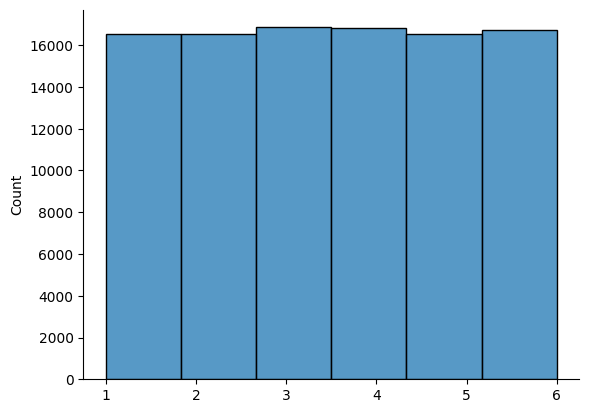

In [ ]:
#@title Uniform distribution of tossing a die

import random
import seaborn as sns
k=100000 #@param {type:"integer"}

scores=random.choices(range(1,7), k=k)
sns.histplot(data=scores, legend=False, bins=6)
sns.despine()


100%|██████████| 10000/10000 [00:00<00:00, 169859.39it/s]


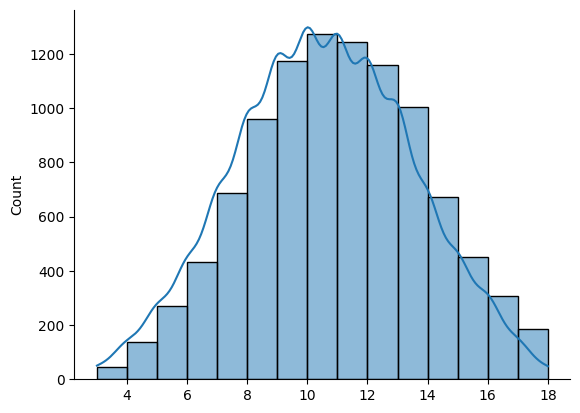

In [ ]:
#@title Normal distribution as sum of k uniformly distributed random variables

import random
import seaborn as sns
from tqdm import tqdm
k=3 #@param {type:"integer"}
n=10000 #@param {type:"integer"}


scores=[]

for _i in tqdm(range(n)):
  scores.append(sum(random.choices(range(1,7), k=k)))

sns.histplot(data=scores, kde=True, legend=False, binwidth=1)
sns.despine()


100%|██████████| 1000/1000 [00:00<00:00, 124504.39it/s]


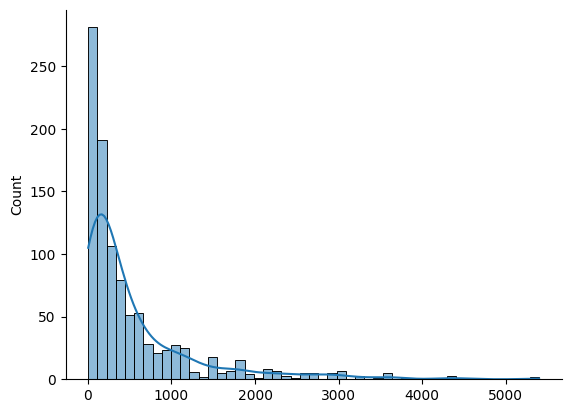

In [ ]:
#@title Log-normal distribution as product of k uniformly distributed random variables

import random,math
import seaborn as sns
from tqdm import tqdm
k=5 #@param {type:"integer"}
n=1000 #@param {type:"integer"}

def prod(scores):
  p=1
  for score in scores:
    p=p*score
  return p

scores=[]

for _i in tqdm(range(n)):
  #random_scores = [random.random() for _j in range(k)]
  random_scores = random.choices(range(1,7), k=k)
  scores.append(prod(random_scores))

sns.histplot(data=scores, kde=True, legend=False)
sns.despine()


In [ ]:
#@title Load PDB file, e.g. 2y3p, 1kn0, 1osn,
pdb="2y3p" #@param {type:"string"}

with io.capture_output() as captured:
  !wget http://www.rcsb.org/pdb/files/{pdb}.pdb.gz
  !gunzip -f {pdb}.pdb.gz
print("Loaded PDB file")

Loaded PDB file


delta x: 106.61, delta y: 51.67, delta z: 56.29
Volume: 310100 cubic A
Density: 0.001599 atoms per cubic A
Globularity: 0.48 (0=long, 1=globular)


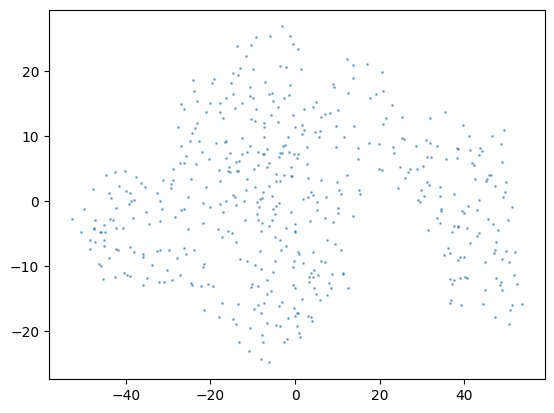

In [ ]:
#@title -->MOVE THIS PCA on structure

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

coordinates = []
for line in open(pdb+".pdb"):
  if line.startswith('ATOM'):
    x = float(line[30:38])
    y = float(line[38:46])
    z = float(line[46:54])
    chain = line[21]
    atom_type = line[12:16].strip()
    if chain=="A" and atom_type=="CA":
      coordinates.append([x,y,z])


coordinates2 = PCA(n_components=3).fit_transform(coordinates)

(xs,ys,zs) = zip(*coordinates2)

delta_x = max(xs)-min(xs)
delta_y = max(ys)-min(ys)
delta_z = max(zs)-min(zs)

volume = delta_x*delta_y*delta_z
density = len(coordinates) / volume
globularity = min(delta_x,delta_y,delta_z) / max(delta_x,delta_y,delta_z)

print("delta x: %.2f, delta y: %.2f, delta z: %.2f"%(delta_x,delta_y,delta_z))
print("Volume: %d cubic A"%volume)
print("Density: %f atoms per cubic A"%density)
print("Globularity: %.2f (0=long, 1=globular)"%globularity)

plt.scatter(xs, ys, s=1, alpha=0.5)
plt.show()


Distribution of atom distances between 2024 atoms in pdb 1kn0


100%|██████████| 2024/2024 [00:01<00:00, 1123.23it/s]


2047276 distances plotted


<Axes: ylabel='Count'>

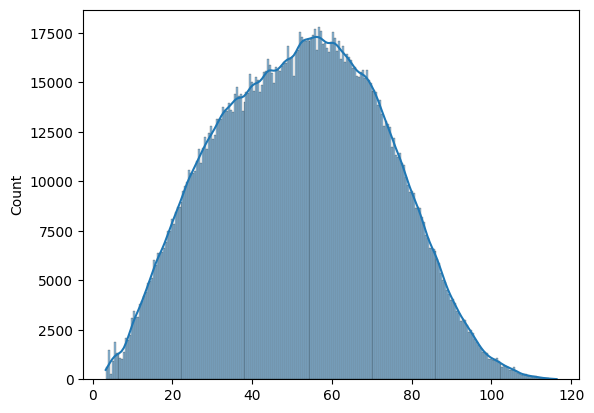

In [ ]:
#@title Distribution of inter-atom distances of carbon alphas in a PDB structure

import math, random
from tqdm import tqdm

def distance(coord1,coord2):
  (x1,y1,z1)=coord1
  (x2,y2,z2)=coord2
  return math.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)

coordinates = []
for line in open(pdb+".pdb"):
  if line.startswith('ATOM'):
    x = float(line[30:38])
    y = float(line[38:46])
    z = float(line[46:54])
    atom_type = line[12:16].strip()
    if atom_type=="CA":
      coordinates.append((x,y,z))

print("Distribution of atom distances between %d atoms in pdb %s"%(len(coordinates),pdb))
distances = []

for i in tqdm(range(len(coordinates))):
  for j in range(i):
    distances.append(distance(coordinates[i],coordinates[j]))

print("%d distances plotted"%len(distances))

sns.histplot(data=distances, kde=True, legend=False)




Distribution of probability (in %) for amino acid Y across all whale protiens


<Axes: ylabel='Count'>

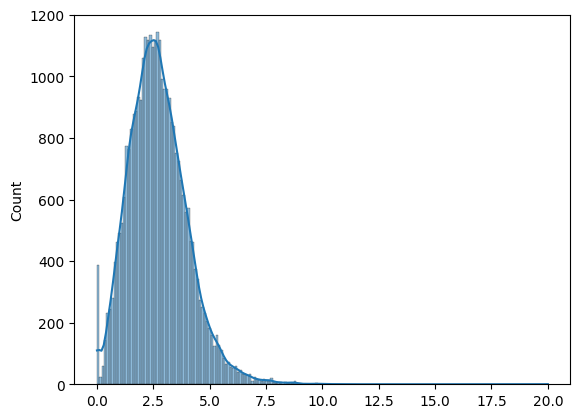

In [ ]:
#@title Distribution of AA freq
import seaborn as sns
aa= "Y" #@param ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']
print("Distribution of probability (in %%) for amino acid %s across all whale protiens"%aa)
freqs = [100*seq.count(aa) / len(seq) for seq in acc2seq_all.values()]
sns.histplot(data=freqs, kde=True, legend=False)#, binwidth=0.01)

<Axes: ylabel='Count'>

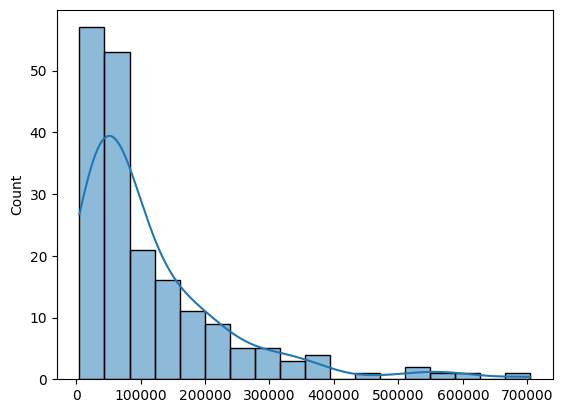

In [ ]:
#@title Distribution of substitutions in whale proteins

values = [v for (aa1,aa2), v in f.items() if aa1!=aa2]
sns.histplot(data=values, kde=True, legend=False)

100%|██████████| 10000/10000 [1:20:28<00:00,  2.07it/s]


[72, 60, 156, 302, 98, 309, 70, 173, 144, 133, 73, 187, 254, 317, 179, 103, 149, 272, 97, 311, 97, 87, 549, 118, 252, 182, 77, 348, 120, 61, 290, 421, 173, 121, 291, 128, 361, 159, 51, 118, 103, 88, 70, 104, 197, 74, 311, 369, 227, 196, 88, 101, 155, 567, 117, 139, 175, 208, 368, 291, 205, 266, 98, 133, 637, 205, 128, 667, 326, 299, 101, 148, 140, 107, 154, 376, 102, 282, 114, 396, 186, 167, 165, 107, 385, 98, 214, 243, 170, 197, 170, 112, 121, 101, 121, 108, 363, 312, 229, 426, 127, 80, 112, 133, 165, 135, 74, 109, 296, 258, 52, 456, 78, 265, 152, 177, 279, 100, 198, 119, 197, 261, 135, 84, 145, 66, 440, 185, 65, 55, 66, 132, 551, 261, 327, 96, 164, 150, 93, 101, 159, 163, 116, 84, 146, 89, 207, 355, 134, 217, 47, 133, 103, 112, 177, 381, 114, 151, 169, 134, 95, 185, 586, 70, 151, 359, 139, 99, 165, 86, 342, 111, 379, 217, 78, 191, 75, 68, 149, 308, 536, 111, 279, 89, 108, 169, 51, 37, 272, 69, 90, 175, 210, 290, 45, 199, 107, 283, 210, 134, 111, 96, 64, 172, 90, 218, 344, 171, 316, 2

<Axes: ylabel='Count'>

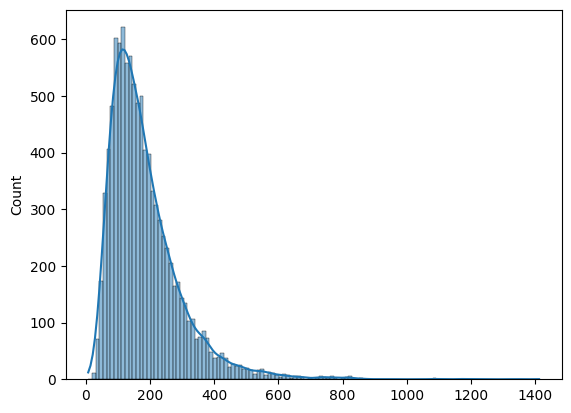

In [ ]:
#@title Random lcs scores

n = 10000 #@param {type:"integer"}
import random
from tqdm import tqdm
import seaborn as sns



scores=[]
lengths=[]

seqs = list(acc2seq_all.values())

for i in tqdm(range(n)):
  a = random.choice(seqs)
  b = random.choice(seqs)
  c = lcs(a,b)
  lengths.append(len(a))
  lengths.append(len(b))
  scores.append(c)
print(scores)

print("lcs length distribution")
sns.histplot(data=scores, kde=True, legend=False) #, binwidth=10)



Sequence lengths distribution


<Axes: ylabel='Count'>

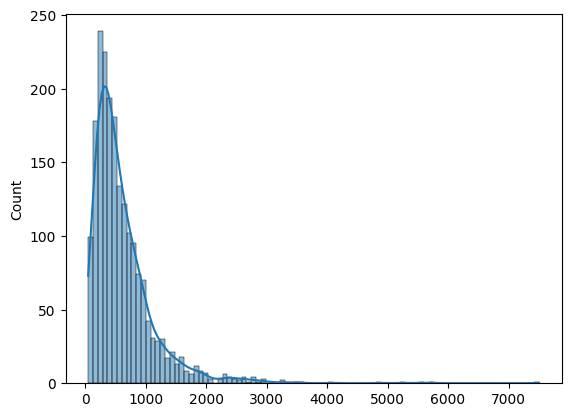

In [ ]:
print("Sequence lengths distribution")
sns.histplot(data=lengths, kde=True, legend=False) #, binwidth=10)

#AB06 From scores to alignment

In [ ]:
#@title Generate alignment

a="PETRA" #@param {type:"string"}
b="PETER" #@param {type:"string"}
m = len(a)
n = len(b)

ARROW_N = "\u2191"
ARROW_W="\u2190"
ARROW_NW="\u2196"


def max_dir(a,b):
  dir = ""
  m = max(a,b)
  if a==m: dir+=ARROW_N
  if b==m: dir+=ARROW_W
  #if c==m: dir+=ARROW_NW
  return (m,dir)

def lcs(a,b):
  m = len(a)
  n = len(b)
  d={}
  for i in range(0,m+1):
    d[i,0] = (0,"")
  for j in range(0,n+1):
    d[0,j] = (0,"")
  for i in range(1,m+1):
    for j in range(1,n+1):
      if a[i-1] == b[j-1]:
        d[i,j]=(d[i-1,j-1][0]+1, ARROW_NW)
      else:
        d[i,j] = max_dir(d[i-1,j][0],d[i,j-1][0])
  return d

def get_lcs(d,a,b,i,j):
  if i==0 and j==0:
    return ""
  else:
    (score,dir) = d[i,j]
    if ARROW_NW in dir:
      return get_lcs(d,a,b,i-1,j-1)+a[i-1]
    elif ARROW_N in dir:
      return get_lcs(d,a,b,i-1,j)
    elif ARROW_W in dir:
      return get_lcs(d,a,b,i,j-1)

d=lcs(a,b)
s=get_lcs(d,a,b,m,n)
print(s)

PETR


In [ ]:
#@title Generate alignment for nw

GENERATE_ALIGNMENT_FOR_NW=True

a="PETRA"
b="PETER"

whale = "RESPAMKFQRQHMDSGNSPGNNPNYCNQMMMRRKMTQGRCKPVNTFVHESLEDVKAVCSQKNVLCKNGRTNCYESNSTMHITDCRQTGSSKYPNCAYKTSQKEKHIIVACEGNPYVPVHFDNSV"
horse = "KESPAMKFERQHMDSGSTSSSNPTYCNQMMKRRNMTQGWCKPVNTFVHEPLADVQAICLQKNITCKNGQSNCYQSSSSMHITDCRLTSGSKYPNCAYQTSQKERHIIVACEGNPYVPVHFDASVEVST"
kangaroo = "ETPAEKFQRQHMDTEHSTASSSNYCNLMMKARDMTSGRCKPLNTFIHEPKSVVDAVCHQENVTCKNGRTNCYKSNSRLSITNCRQTGASKYPNCQYETSNLNKQIIVACEGQYVPVHFDAYV"

a=whale
b=horse

m = len(a)
n = len(b)

ARROW_N = "\u2191"
ARROW_W="\u2190"
ARROW_NW="\u2196"

def max_dir(a,b,c):
  dir = ""
  m = max(a,b,c)
  if a==m: dir+=ARROW_N
  if b==m: dir+=ARROW_W
  if c==m: dir+=ARROW_NW
  return (m,dir)


def nw(a,b):
  gap = -1
  m = len(a)
  n = len(b)
  d={}
  for i in range(0,m+1):
    d[i,0] = (i*gap,"")
  for j in range(0,n+1):
    d[0,j] = (j*gap,"")
  for i in range(1,m+1):
    for j in range(1,n+1):
      d[i,j] = max_dir(d[i-1,j][0]+gap,
                   d[i ,j-1][0]+gap,
                   d[i-1,j-1][0] + blosum62[(a[i-1],b[j-1])])

  return d


def get_alignment(d,a,b,i,j):

  if i==0 and j==0:
    return ("","","")

  elif i==0:
    return ("-"*j," "*j,b[0:j])

  elif j==0:
    return (a[0:i]," "*i,"-"*i)

  else:
    (score,dir) = d[i,j]

    if ARROW_NW in dir:
      (s1,s2,s3) = get_alignment(d,a,b,i-1,j-1)

      if a[i-1]==b[j-1]: c="*"
      elif blosum62[(a[i-1],b[j-1])]>0: c="."
      else: c=" "

      s1+=a[i-1]
      s2+=c
      s3+=b[j-1]

    elif ARROW_N in dir:
      (s1,s2,s3) = get_alignment(d,a,b,i-1,j)

      s1+=a[i-1]
      s2+=" "
      s3+="-"

    elif ARROW_W in dir:
      (s1,s2,s3) = get_alignment(d,a,b,i,j-1)

      s1+="-"
      s2+=" "
      s3+=b[j-1]

    return (s1,s2,s3)


d=nw(a,b)
(s1,s2,s3)=get_alignment(d,a,b,m,n)
print("%s\n%s\n%s"%(s1,s2,s3))

RESPAMKFQRQHMDSGN-SPGNNPNYCNQMMMRRKMTQG-RCKPVNTFVHESLEDVKAVCSQKNVLCKNGRTNCYESNSTMHITDCRQT-GSSKYPNCAYKTSQKEKHIIVACEGNPYVPVHFDNS--V--
.*******.*******. *  .** ****** ** ****  ********** * **.*.* ***. ****..***.*.*.******* * * ********.*****.***************** *  *  
KESPAMKFERQHMDSGSTS-SSNPTYCNQMMKRRNMTQGW-CKPVNTFVHEPLADVQAICLQKNITCKNGQSNCYQSSSSMHITDCRLTSG-SKYPNCAYQTSQKERHIIVACEGNPYVPVHFDASVEVST


In [ ]:
# move or delete

# https://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/complete/

#AB07 Fast sequence comparison

In [ ]:
#@title Longest common subsequence without dynamic programming

a="Petrus" #@param {type:"string"}
b="Per" #@param {type:"string"}


m = len(a)
n = len(b)
k=0


def lcs_naive(i,j):
  global k
  if i==0 or j==0:
    print("%4d lcs(%d,%d)=0"%(k,i,j))
    k+=1
    return 0
  else:
    lcs_ij = max(lcs_naive(i-1,j),
                 lcs_naive(i ,j-1),
                 lcs_naive(i-1,j-1) + int(a[i-1] == b[j-1]))

    print("%4d lcs(%d,%d)=%d"%(k,i,j,lcs_ij))
    k+=1
    return lcs_ij

if m<6 and n<6:
  lcs_naive(m,n)
else:
  print("Take strings with max. 5 characters. Otherwise the computation is too large.")

Take strings with max. 5 characters. Otherwise the computation is too large.


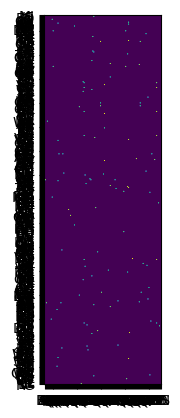

In [ ]:
#@title Dot plot of whale RNAS1 against another sequence

seq = "horse" #@param ["horse", "kangaroo", "random"]
k=2 #@param {type:"integer"}

def nmer_seq(s,k):
  return [s[i:i+k] for i in range(len(s)-k)]

seq1 = whale
if seq=="horse":
  seq2 = horse
elif seq=="kangaroo":
  seq2 = kangaroo
elif seq=="random":
  seq2 = random.choice(list(acc2seq_all.values()))

X, Y = np.array(nmer_seq(seq1,k)), np.array(nmer_seq(seq2,k))

plt.imshow(X==Y[:,None])        # the magic happens here, contourf should work similarly
plt.xticks(np.arange(len(X)), X)
plt.yticks(np.arange(len(Y)), Y)
plt.show()

In [ ]:
#@title Are ESP and KES frequent?

esp=0
kes=0

for seq in  acc2seq_all.values():
  esp+=seq.count("ESP")
  kes+=seq.count("KES")

print("ESP, which is shared by whale and horse, appears %d times in all sequences"%esp)
print("KES, which is not shared by whale and horse, appears %d times in all sequences"%kes)

ESP, which is shared by whale and horse, appears 5686 times in all sequences
KES, which is shared by whale and horse, appears 6063 times in all sequences


Most frequent 3-mers
SSS 31139
EEE 28662
LLL 24944
PPP 21579
SSL 18912
AAA 17985
SLL 17973
LEE 17846
LLS 17600
LSS 17446
Least frequent 3-mers
VSU 1
AUG 1
GAU 1
UGS 1
CUG 1
SCU 1
URV 1
SUR 1
MSU 1
ULG 1


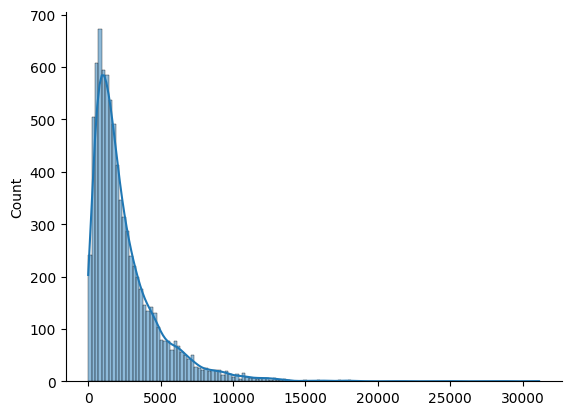

In [ ]:
#@title Distribution of 3-mers

d = defaultdict(int)
for seq in  acc2seq_all.values():
  for i in range(len(seq)-3):
    word=seq[i:i+3]
    d[word]+=1

print("Most frequent 3-mers")
for k,v in list(my_sort(d))[:5]:
  print(k,v)

print()
print("Least frequent 3-mers")
for k,v in list(reversed(my_sort(d)))[:5]:
  print(k,v)

sns.histplot(data=d.values(), kde=True, legend=False) #, binwidth=10)
sns.despine()

In [ ]:
#@title Code for computing nmers

def nmers(s,k):
  return set([s[i:i+k] for i in range(len(s)-k)])

def common_nmers(s1,s2,k):
  s1_nmer = nmers(s1,k)
  s2_nmer = nmers(s2,k)
  return len(s1_nmer.intersection(s2_nmer))

def common_nmers_db(s,k, acc2seq):
  start = time.time()
  s_nmer = nmers(s,k)
  acc2nmer = {}
  print("Computing number of shared %d-mers for %d sequences"%(k,len(acc2seq)))
  for acc in tqdm(acc2seq.keys()):
    common = len(s_nmer.intersection(nmers(acc2seq[acc],k)))
    acc2nmer[acc] = common
  print("Comparing %d nmers took %d sec."%(len(acc2seq),time.time()-start))
  return acc2nmer

def blank_out(nmer):
  return nmer[:3]+"*"+nmer[4:]

def fuzzy_sevenmers(s):
  return set([blank_out(s[i:i+7]) for i in range(len(s)-6)])

def common_fuzzy_sevenmers(s1,s2):
  s1_nmer = fuzzy_sevenmers(s1)
  s2_nmer = fuzzy_sevenmers(s2)
  return len(s1_nmer.intersection(s2_nmer))


In [ ]:
#@title How many nmers do whale/horse RNAS1, whale/kangaroo RNAS1 share?

k=3 #@param {type:"integer"}

print("Number of shared %d-mers with whale RNAS1"%k)
for acc,score in [(acc, common_nmers(whale,acc2seq[acc],k)) for acc in selected_accs]:
  print("%3d %s"%(score, acc))



Number of shared 3-mers with whale RNAS1
120 RNAS1_BALAC
 57 RNAS1_HORSE
 68 RNAS1_HIPAM
 38 RNAS1_OSPRU


Computing number of shared 3-mers for 32465 sequences


100%|██████████| 32465/32465 [00:11<00:00, 2896.46it/s]


Comparing 32465 nmers took 11 sec.
Shared 3-mers with whale RNAS1 for 32465 sequences
Mean is 8.97, stdev is 7.68
Distribution of nmer scores of 32465 sequences


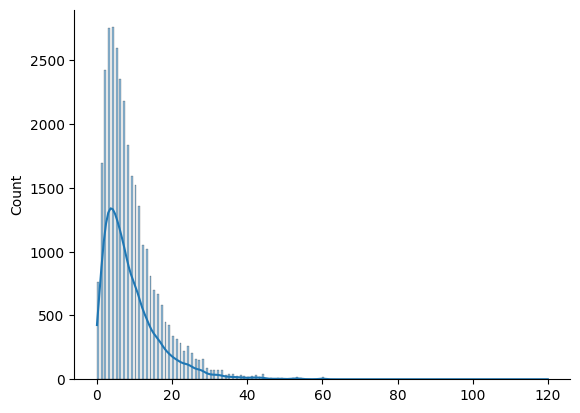

In [ ]:
#@title Is this a little or a lot? How many nmers do randomly selected whale sequences share with whale RNAS1?
import seaborn as sns

k=3 #@param {type:"integer"}

acc2nmer = common_nmers_db(whale,k,acc2seq_all)

print("Shared %d-mers with whale RNAS1 for %d sequences"%(k,len(acc2nmer)))
m,std=get_m_std(acc2nmer.values())
print("Mean is %.2f, stdev is %.2f"%(m,std))

print("Distribution of nmer scores of %d sequences"%(len(acc2nmer)))
sns.histplot(data=acc2nmer.values(), kde=True, legend=False)
sns.despine()


100%|██████████| 1001/1001 [02:06<00:00,  7.94it/s]


Similarity of random whale sequences and whale RNAS1 to horse RNAS1


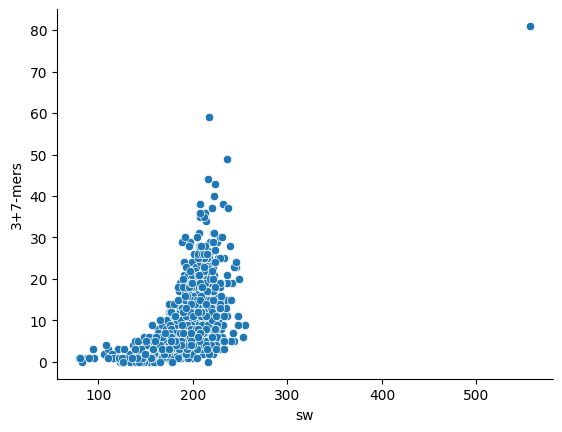

In [ ]:
#@title How do nw and nmers relate to each other?

n=1000 #@param {type:"integer"}
nmer = "3+7" #@param ["3+7", "7","3"]
algorithm = "sw" #@param ["lcs", "nw", "sw"]

def lcs(a,b):
  m, n, d = len(a), len(b), {}
  for i in range(0,m+1): d[i,0] = 0
  for j in range(0,n+1): d[0,j] = 0
  for i in range(1,m+1):
    for j in range(1,n+1):
      if a[i-1] == b[j-1]:
        d[i,j]=d[i-1,j-1]+1
      else:
        d[i,j] = max(d[i-1,j], d[i,j-1])
  return d[m,n]

def nw(a,b):
  m, n, d, gap = len(a), len(b), {}, -1
  for i in range(0,m+1): d[i,0] = i*gap
  for j in range(0,n+1): d[0,j] = j*gap
  for i in range(1,m+1):
    for j in range(1,n+1):
      d[i,j] = max(d[i-1,j]+gap, d[i,j-1]+gap, d[i-1,j-1]+blosum62[(a[i-1],b[j-1])])
  return d[m,n]

def sw(a,b):
  m, n, d, gap = len(a), len(b), {}, -1
  for i in range(0,m+1): d[i,0] = 0
  for j in range(0,n+1): d[0,j] = 0
  for i in range(1,m+1):
    for j in range(1,n+1):
      d[i,j] = max(0, d[i-1,j]+gap, d[i,j-1]+gap, d[i-1,j-1]+blosum62[(a[i-1],b[j-1])])
  return max(d.values())

random_accs = random.sample(list(acc2seq_all.keys()), n)
random_accs += ["RNAS1_BALAC"]

xs,ys=[],[]
for acc in tqdm(random_accs):

  if algorithm == "lcs":
    xs.append(lcs(horse, acc2seq_all[acc]))
  elif algorithm == "nw":
    xs.append(nw(horse, acc2seq_all[acc]))
  elif algorithm == "sw":
    xs.append(sw(horse, acc2seq_all[acc]))

  if nmer == "3":
    ys.append(common_nmers(horse,acc2seq_all[acc],3))
  elif nmer == "7":
    ys.append(common_fuzzy_sevenmers(horse,acc2seq_all[acc]))
  elif nmer == "3+7":
    score = common_nmers(horse,acc2seq_all[acc],3)
    score += common_fuzzy_sevenmers(horse,acc2seq_all[acc])
    ys.append(score)


print("Similarity of random whale sequences and whale RNAS1 to horse RNAS1")
plt.xlabel(algorithm)
plt.ylabel("%s-mers"%nmer)
sns.scatterplot(x=xs, y=ys)
sns.despine()

In [ ]:
#@title From words to high-scoring pairs

if not "horse" in globals(): print("First run initial script 'Download whale data'")



a=horse
a=kangaroo
b=whale

a="WWWWWQERTWWWWW"
b="WWWWWWWWWW"
max_len=6 #@param {type:"integer"}
max_mismatch=3 #@param {type:"integer"}


def with_num(s):
  step_size = 5
  n = ""
  for ten in range(0,len(s), step_size):
    n = n+str(ten)+" "*(step_size-len(str(ten)))
  return n+"\n"+s

def with_region(region):
  (i,l) = region
  return " "*i + "-"*l

def print_with_regions(a, regions):
  print(with_num(a))
  for region in regions:
    print(with_region(region))

def less_than_k_mismatches(s1,s2,k):
  m=0
  for aa1,aa2 in zip(s1,s2):
    if aa1!=aa2: m+=1
  return m<k

def index_3mers(s):
  d=defaultdict(list)
  for i in range(len(s)-3):
    word=a[i:i+3]
    d[word].append(i)
  return d

def get_words(d,s):
  words=defaultdict(list)
  for j in range(len(s)-3):
    word=s[j:j+3]
    if word in d:
      for i in d[word]:
        diagonal_n = i-j
        words[diagonal_n].append((i,j))
  return words


def words2extended_words(words,a,b):

  sorted_words = list(sorted(words, key=lambda x:x[0]))
  (i,j) = sorted_words[0]
  ew = (i,j,3)
  ews=[]
  for k in range(1,len(sorted_words)):
    (i,j,l) = ew
    (i2,j2) = sorted_words[k]
    if i2<i+l+1:
      ew = (i,j,i2+3-i)
    else:
      ews.append(ew)
      ew=(i2,j2,3)
  ews.append(ew)

  return ews



# get a list of words, which are on the same diagonal and turn them into hsps if possible
def ews2hsps(ews,a,b):

  sorted_ews = list(sorted(ews, key=lambda x:x[0]))
  hsp = sorted_ews[0]
  hsps=[]
  for k in range(1,len(sorted_ews)):
    (i,j,l) = hsp
    (i2,j2,l2) = sorted_ews[k]
    a_between_words = a[i+l:i2]
    b_between_words = b[j+l:j2]
    # two neighboring words are within distance max_len and in between there are few enough mismatches
    if len(a_between_words)<max_len and len(b_between_words)<max_len and less_than_k_mismatches(a_between_words,b_between_words, max_mismatch):
      hsp = (i,j,i2+l2-i)
    else:
      hsps.append(hsp)
      hsp=(i2,j2,l2)
      # if we are at the last word, which cannot be further extended, then add it to the hsps
  hsps.append(hsp)

  return hsps


def get_extended_words(index_of_ab,a,b):
  ews=defaultdict(list)
  for diagonal,matching_words in index_of_ab.items():
    ews[diagonal] = words2extended_words(matching_words,a,b)
  return ews

def get_hsps_from_extended_words(ews,a,b):
  hsps=defaultdict(list)
  for k,v in ews.items():
    hsps[k] = ews2hsps(v,a,b)
  return hsps

index_of_a = index_3mers(a)
#print(index_of_a)

index_of_ab = get_words(index_of_a,b)
#print("ab",index_of_ab)

ews = get_extended_words(index_of_ab,a,b)
#print("ews",ews)

hsps = get_hsps_from_extended_words(ews,a,b)
#print("hsp",hsps)

regions=[]
for regions_on_diagonal in ews.values():
  regions.extend(regions_on_diagonal)
print_with_regions(a, [(i,l) for (i,j,l) in regions])
#print(with_regions(b, [(j,l) for (i,j,l) in regions]))

regions=[]
for regions_on_diagonal in hsps.values():
  regions.extend(regions_on_diagonal)
#print_with_regions(a, [(i,l) for (i,j,l) in regions])





defaultdict(<class 'list'>, {'WWW': [0, 1, 2, 9, 10], 'WWQ': [3], 'WQE': [4], 'QER': [5], 'ERT': [6], 'RTW': [7], 'TWW': [8]})
ab defaultdict(<class 'list'>, {0: [(0, 0), (1, 1), (2, 2)], 1: [(1, 0), (2, 1)], 2: [(2, 0)], 9: [(9, 0), (10, 1)], 10: [(10, 0)], -1: [(0, 1), (1, 2), (2, 3)], 8: [(9, 1), (10, 2)], -2: [(0, 2), (1, 3), (2, 4)], 7: [(9, 2), (10, 3)], -3: [(0, 3), (1, 4), (2, 5)], 6: [(9, 3), (10, 4)], -4: [(0, 4), (1, 5), (2, 6)], 5: [(9, 4), (10, 5)], -5: [(0, 5), (1, 6)], 4: [(9, 5), (10, 6)], -6: [(0, 6)], 3: [(9, 6)]})
ews defaultdict(<class 'list'>, {0: [(0, 0, 5)], 1: [(1, 0, 4)], 2: [(2, 0, 3)], 9: [(9, 0, 4)], 10: [(10, 0, 3)], -1: [(0, 1, 5)], 8: [(9, 1, 4)], -2: [(0, 2, 5)], 7: [(9, 2, 4)], -3: [(0, 3, 5)], 6: [(9, 3, 4)], -4: [(0, 4, 5)], 5: [(9, 4, 4)], -5: [(0, 5, 4)], 4: [(9, 5, 4)], -6: [(0, 6, 3)], 3: [(9, 6, 3)]})
hsp defaultdict(<class 'list'>, {0: [(0, 0, 5)], 1: [(1, 0, 4)], 2: [(2, 0, 3)], 9: [(9, 0, 4)], 10: [(10, 0, 3)], -1: [(0, 1, 5)], 8: [(9, 1, 4)],

100%|██████████| 32465/32465 [00:10<00:00, 2955.93it/s]


Screening 32465 sequences, RNAS1_BALAC has the longest hsp of size 13

Alignment:
-ETPAEKFQRQHMDTEHSTASSSNYCN-LMMKARDMTSGRCKPLNTFIHEPKSVVD--AVCHQENVTCKNGRTNCYKSNSRLSITNCRQTGASKYPNCQYETSNLNKQIIVACEGQ-YVPVHFD-AYV
 *.** ********. .*  .. **** .**. * ** *****.***.**  *. *  *** *.** *********.*** . **.*****.****** *.**   * *******  ******* . *
RESPAMKFQRQHMDSGNSPGNNPNYCNQMMMR-RKMTQGRCKPVNTFVHE--SLEDVKAVCSQKNVLCKNGRTNCYESNSTMHITDCRQTGSSKYPNCAYKTSQKEKHIIVACEGNPYVPVHFDNS-V


Distribution of hsp length scores


<Axes: ylabel='Count'>

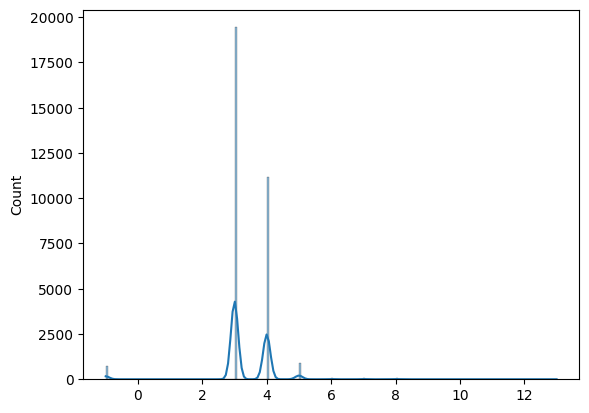

In [ ]:
#@title Screen whale genes for the longest high scoring pair

a = kangaroo
a = horse

# Human Rad52 RAD52_HUMAN
# a = "MSGTEEAILGGRDSHPAAGGGSVLCFGQCQYTAEEYQAIQKALRQRLGPEYISSRMAGGGQKVCYIEGHRVINLANEMFGYNGWAHSITQQNVDFVDLNNGKFYVGVCAFVRVQLKDGSYHEDVGYGVSEGLKSKALSLEKARKEAVTDGLKRALRSFGNALGNCILDKDYLRSLNKLPRQLPLEVDLTKAKRQDLEPSVEEARYNSCRPNMALGHPQLQQVTSPSRPSHAVIPADQDCSSRSLSSSAVESEATHQRKLRQKQLQQQFRERMEKQQVRVSTPSAEKSEAAPPAPPVTHSTPVTVSEPLLEKDFLAGVTQELIKTLEDNSEKWAVTPDAGDGVVKPSSRADPAQTSDTLALNNQMVTQNRTPHSVCHQKPQAKSGSWDLQTYSADQRTTGNWESHRKSQDMKKRKYDPS"

# Mammoth NU4LM_MAMPR
# a = "MPYIYMNITLAFVISLIGTLMYRSHLMSSLLCLEGMMLSLFTLNALLSLNMNFTLSTTVPLILLVFAACEAAVGLALLIMISNTYGLDYVQNLNLLQC"

if not "get_words" in globals():
  print("Please run cell 'From words to high-scoring pairs'.")
  sys.exit(-1)

def longest_hsp(index_of_a, b):
  words = get_words(index_of_a,b)
  ews = get_extended_words(words,a,b)
  hsps = get_hsps_from_extended_words(ews,a,b)
  list_of_hsps = []
  for hsps in hsps.values():
    list_of_hsps.extend(hsps)
  if list_of_hsps != []:
    return max([l for (i,j,l) in list_of_hsps])
  else:
    return -1

index_of_a = index_3mers(a)
scores=[]
for acc,seq in tqdm(acc2seq_all.items()):
  scores.append((acc, longest_hsp(index_of_a, seq)))

(max_acc, max_hsp) = max(scores, key=lambda x:x[1])

print("Screening %d sequences, %s has the longest hsp of size %d"%(len(acc2seq_all), max_acc, max_hsp))


if "get_alignment" in globals():
  b = acc2seq_all[max_acc]
  m, n = len(a), len(b)
  d = nw(a,b)
  (s1,s2,s3)=get_alignment(d,a,b,m,n)
  print("\nAlignment:\n%s\n%s\n%s\n\n"%(s1,s2,s3))
else:
  print("Cannot print alignment for %s. Please run cell 'Generate alignment for nw'."%max_acc)


print("Distribution of hsp length scores")
sns.histplot(data=[l for acc,l in scores], kde=True, legend=False)


Computing number of shared 3-mers for 32465 sequences


100%|██████████| 32465/32465 [00:05<00:00, 5489.17it/s]


Comparing 32465 nmers took 5 sec.
Shared 3-mers with whale RNAS1 for 32465 random sequences
Mean is 8.97, stdev is 7.68
Distribution of nmer scores of 32465 sequences


<Axes: ylabel='Count'>

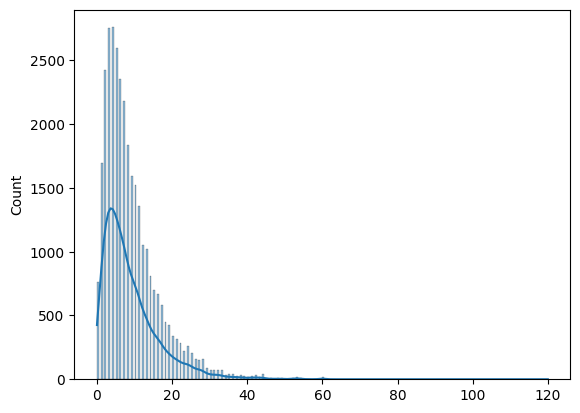

In [ ]:
#@title What is the distribution of shared nmers between whale RNAS1 and all whale proteins?
import seaborn as sns

k=3 #@param {type:"integer"}

w = acc2seq["RNAS1_BALAC"]
acc2nmer = common_nmers_db(w,k,acc2seq_all)

print("Shared %d-mers with whale RNAS1 for %d random sequences"%(k,len(acc2nmer)))
m,std=get_m_std(acc2nmer.values())
print("Mean is %.2f, stdev is %.2f"%(m,std))

print("Distribution of nmer scores of %d sequences"%(len(acc2nmer)))
sns.histplot(data=acc2nmer.values(), kde=True, legend=False)


In [ ]:
  d=defaultdict(int)
  for acc,seq in acc2seq_all.items():
    for i in range(len(seq)-n):
      word = seq[i:i+n]
      d[word]+=1
  xs.append(n)
  ks = len(d.keys())
  vs = sum(d.values())
  y_in_bits = ks * how_many_bits_to_represent_up_to(ks) + vs * bits_per_id_pos
  y_in_bytes = y_in_bits /8
  y_in_mb = y_in_bytes / mb
  ys.append(y_in_mb)
  if n>5:
    for word,freq in list(items_sorted_by_value(d))[:int(0.05*ks)]:
      frequent.add(word)

100%|██████████| 9/9 [03:01<00:00, 20.19s/it]


whale2.txt is 24.20 mb
whale2.txt if amino aicds would use 5 bits (instead of 8 bits (1 byte)) 12 mb are needed.
whale2.txt.gz is 9.41 mb
whale2.txt if amino aicds would use 22 bits for frequent n-mers and 5 bits for individual aa 12 mb are needed.
Size of n-mer indices


<Axes: >

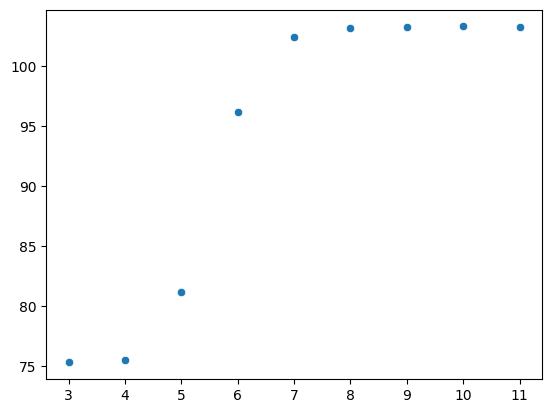

In [ ]:
#@title How much memory does an index need?

def how_many_bits_to_represent_up_to(n):
  return math.ceil(math.log(n,2))

mb = 1024*1024
# How many mb are needed to store the sequence as they are?
total_aa = sum([len(seq) for seq in acc2seq_all.values()])
bits_per_aa = how_many_bits_to_represent_up_to(20)
total_aa_in_bits = total_aa * bits_per_aa
total_aa_in_bytes = total_aa_in_bits / 8
total_aa_in_mb = total_aa_in_bytes/ mb

bits_per_id = how_many_bits_to_represent_up_to(len(acc2seq_all.keys()))
bits_per_pos = how_many_bits_to_represent_up_to(max([len(seq) for seq in acc2seq_all.values()]))
bits_per_id_pos = bits_per_id + bits_per_pos

#print("bits per aa", bits_per_aa)
#print("bits per id", bits_per_id)
#print("bits per pos", bits_per_pos)
#print("bits per id+pos", bits_per_id_pos)

min_n = 3
max_n = 12

xs,ys=[],[]
frequent = set([])
for n in tqdm(range(min_n, max_n)):
  d=defaultdict(int)
  for acc,seq in acc2seq_all.items():
    for i in range(len(seq)-n):
      word = seq[i:i+n]
      d[word]+=1
  xs.append(n)
  ks = len(d.keys())
  vs = sum(d.values())
  y_in_bits = ks * how_many_bits_to_represent_up_to(ks) + vs * bits_per_id_pos
  y_in_bytes = y_in_bits /8
  y_in_mb = y_in_bytes / mb
  ys.append(y_in_mb)
  for word,freq in list(items_sorted_by_value(d))[:int(0.05*ks)]:
    frequent.add(word)

d=defaultdict(int)
bits_per_freq = how_many_bits_to_represent_up_to(len(frequent))
total_freq_bits = 0
for seq in acc2seq_all.values():
  i=0
  while i < len(seq):
    for n in range(max_n, min_n):
      word = seq[i:i+n]
      if word in frequent:
        total_freq_bits += bits_per_freq
        i+=n
        break
    total_freq_bits+=bits_per_aa
    i+=1
total_freq_bits_in_mb = total_freq_bits / (8*mb)

w=os.path.getsize("whale2.txt") / mb
!gzip whale2.txt
w_gz=os.path.getsize("whale2.txt.gz") / mb
!gunzip whale2.txt.gz

print("whale2.txt is %.2f mb"%(w))
print("whale2.txt if amino aicds would use %d bits (instead of 8 bits (1 byte)) %d mb are needed."%(bits_per_aa, total_aa_in_mb))
print("whale2.txt.gz is %.2f mb"%(w_gz))
print("whale2.txt if amino aicds would use %d bits for frequent n-mers and %d bits for individual aa %d mb are needed."%(bits_per_freq, bits_per_aa, total_freq_bits_in_mb))

print("Size of n-mer indices")
sns.scatterplot(x=xs,y=ys)
sns.despine()


#AB08 PyMOL

compare structure horse, kngaroo, whale
compare random
plddt, tm score, rmsd
root median square deviation


In [ ]:
#@title Selected proteins have a disordered regions

# Dunker et al. 2001 (PMID 11381529):
# >30% of eukaryotic proteins have disordered region of >50 residues


shl = defaultdict(int)
for ss in acc2ss_all.values():
  for sss in ss:
    shl[sss]+=1

print("Distribution of S, H, L in selected whale structures")
t = sum(shl.values())
for k,v in shl.items():
  print("%s: %d (%.f%%)"%(k,v,100*v/t))
print()

if "acc2ss_all" in globals():
  dos = []
  for acc,ss in acc2ss_all.items():
    if ss.find("L"*51)>-1:
      dos.append(acc)
  print("%d out of %d selected whale structures are disordered"%(len(dos),len(acc2ss_all)))
  print(" ".join(dos))
else:
  print("First you have to download AF structures (Download selected whale...)")


Distribution of S, H, L in selected whale structures
L: 20864 (52%)
H: 14999 (37%)
S: 4612 (11%)

44 out of 85 selected whale structures are disordered
A0A384AEG6_BALAS A0A452CLS5_BALAS A0A452CI55_BALAS A0A384A634_BALAS A0A383ZQM5_BALAS A0A384AK68_BALAS A0A452CJC8_BALAS A0A383YZI0_BALAS A0A383ZCW6_BALAS A0A384BC55_BALAS A0A384B4N5_BALAS A0A383ZAU0_BALAS A0A383ZS71_BALAS A0A384B016_BALAS A0A384B249_BALAS A0A383ZU86_BALAS A0A383ZL24_BALAS A0A383YNA1_BALAS A0A384A893_BALAS A0A384AA35_BALAS A0A384B7E4_BALAS A0A452CDG1_BALAS A0A452C630_BALAS A0A452CAV3_BALAS A0A452CII0_BALAS A0A383ZT00_BALAS A0A383ZC92_BALAS A0A384BBW0_BALAS A0A383Z4W4_BALAS A0A384AMB5_BALAS A0A383ZDD5_BALAS A0A383Z073_BALAS A0A384B5U9_BALAS A0A384AXX8_BALAS A0A383YQB3_BALAS A0A384B500_BALAS A0A383YZV5_BALAS A0A384B8V3_BALAS A0A383YQZ8_BALAS A0A384AQ27_BALAS A0A384A1H5_BALAS A0A383Z8H2_BALAS A0A384BC91_BALAS A0A384AYD4_BALAS


https://alphafold.ebi.ac.uk/files/AF-A0A383ZCW6-F1-model_v4.pdb
A0A383ZCW6_BALAS
MAPRRLLLVGEGNFSFAAALSENLDPSTSITATCPHRPADLAQDPLARENLQRLRERGAEVRFGVDCTQLVDAFELQDREFDRIYFNFPHCGRKAGVAKNRELLAKFFQSCADVLAEEGEVHVALCRGQGGTPADKPMREWHNSWQVVAMAALGGFILSDVHLFSCEAVPGYKCTGYRSQDKSFHVEGALNHIFTRSLPYEGLQPRISRIKLGDQWFSFLEPEVLVGKLNRGFLEAPSYHPIKTINEKLIAELGKAFPLKRLKCSSPLLPQGDTSVLTSCHCDILSSAFWISLREDNSNFESLTGGTTQDMEDFLVSFSELSLPKNPRRDSKEEAQEGMYGQAKVCLRPSLLVHVQALIQAPDFLPGSLYILSGPVFQKCRISPFTMPAFHETLFILGFNKNLKDGCLQSLLDHLKGVLDSLLTQTLLKGSKLGSSVEFVFQPRGEDYMIIVKSQNFGPDCVKDLIIGSVTTSATSIIHKDQCFVCVSMNLDLLAMLVWGISDWRMLWTFDKRFLKNFAPGKIEPFKSYSLYPPYYVHDISFWLDTKKRFDEVEFHTVARAVSQDTVISIQFLSRFQHPKTEQVSLCYRLTYQTCDKALTQQQVASMQSQLRKEIQQRLHVTPR
LLLSSSSSSLLLLLHHHHHHHHLLLLLSSSSSSSLLLHHHHHLLHHHHHHHHHHHHHLLSSSSLLLLLLHHHHLLHHHLLLLSSSSSLLLLLLLLLHHHHHHHHHHHHHHHHHHLLLLLSSSSSSLLLLLLLLLLLLLLLHHHLLLHHHHHHHHLSSSSSSSSLLHHHLLLLLLLLLLLLLLLLLLLLLSSSSSSSLLLLLLLLLLSSSSSSLLSSSSSSLLHHHLLLLLLLLLLLLLLLHHHHHHHHHHHHHHHHLLSSSLLLLLLSSSHHHHHHLLLLLHHHHHHLLSSSLL

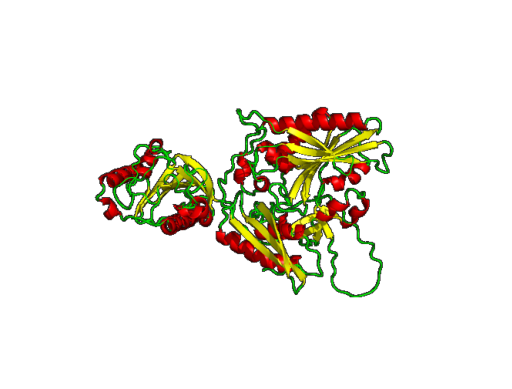

In [ ]:
#@title Load a selected whale PDB structure

what = "acc" #@param ["random","RNAS1","acc"]
acc = "A0A383ZCW6_BALAS" #@param {type:"string"}

if what == "random":
  id = random.choice(list(acc2seq_all.keys()))
elif what == "RNAS1":
  id="RNAS1_BALAC"
else:
  id = acc


uniprot = acc2uniprot_all[id]
fn = "AF-%s-F1-model_v4.pdb"%uniprot
url = "https://alphafold.ebi.ac.uk/files/%s"%fn
print(url)
if not os.path.exists(fn):
  with io.capture_output() as captured:
    !wget {url}
if not os.path.exists(fn):
  print("Could not retrieve %s"%fn)
  sys.exit(-1)

DEFAULT         = "\033[39m"
WHITE           = "\033[37m"
BLACK           = "\033[30m"
GREEN           = '\033[92m'
BLUE            = '\033[94m'
PINK            = '\033[95m'

BG_DEFAULT      = "\033[49m"
BG_BLACK        = "\033[40m"
BG_GREEN        = "\033[42m"
BG_BLUE         = "\033[44m"
BG_RED          = "\033[41m"
BG_YELLOW       = "\033[43m"

def color_ss(aa,ss1,ss2):
  if ss1!=ss2:
    if ss2=="H": return BG_RED+aa
    elif ss2=="S": return BG_YELLOW+aa
    elif ss2=="L": return BG_GREEN+aa
  else:
    return aa

def color_aa_by_ss_string(aa,ss):
  aa_col = WHITE+color_ss(aa[0],"",ss[0])
  for aa,ss1,ss2 in zip(aa[1:],ss,ss[1:]):
    aa_col += color_ss(aa,ss1,ss2)
  return aa_col

cmd.delete("all")
cmd.hide("everything")
cmd.bg_color("white")
cmd.load(fn, "a")

#cmd.set("cartoon_color", "palegreen", "a")
#cmd.set("surface_color", "palegreen", "a")
cmd.color("green", "a and ss l")
cmd.color("yellow", "a and ss s")
cmd.color("red", "a and ss h")
cmd.orient("a")
cmd.show("cartoon", "a")

seq = get_aa_string("a")
ss = get_ss_string("a")

print("%s\n%s\n%s"%(id,seq,ss))
print(color_aa_by_ss_string(seq,ss))

png="%s.png"%id
save_png(png)
show_png(png)


In [ ]:
#@title Does current protein have a disordered region?

# Dunker et al. 2001 (PMID 11381529):
# >30% of eukaryotic proteins have disordered region of >50 residues

if ss.find("L"*51)>-1:
  yes_no = "a"
else:
  yes_no = "no"

print("%s (%s) has %s disordered region (>50 consecutive loop residues)"%(id, uniprot,yes_no))


A0A384APE7_BALAS (A0A384APE7) has a disordered region (>50 consecutive loop residues)


Phi and Psi angles for A0A384ADE3_BALAS (A0A384ADE3)


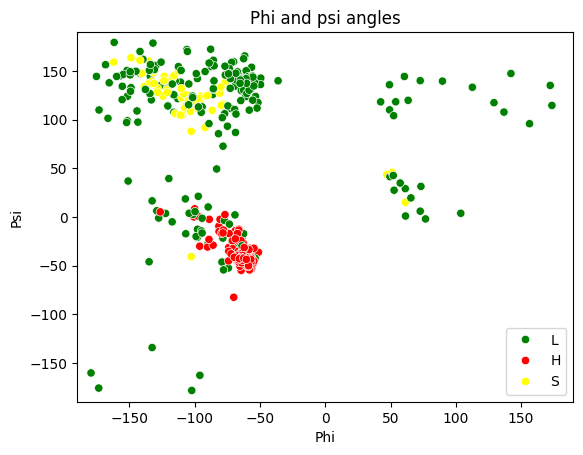

In [ ]:
#@title Phi Psi Angles

def degrees(rad_angle) :
    if rad_angle is None :
        return None
    angle = rad_angle * 180 / math.pi
    while angle > 180 :
        angle = angle - 360
    while angle < -180 :
        angle = angle + 360
    return angle

def yield_phi_psi(model):
    for chain in model:
          polypeptides = Bio.PDB.PPBuilder().build_peptides(chain)
          for poly_index, poly in enumerate(polypeptides):
            phi_psi = poly.get_phi_psi_list()
            for res_index, residue in enumerate(poly):
                phi, psi = phi_psi[res_index]
                yield dict(chain_id=chain.id,
                           poly_index=poly_index,
                           residue_name=residue.resname,
                           author_residue_number=residue.id[1],
                           phi_radian=phi, psi_radian=psi)


try:
  import Bio.PDB
except:
  !pip install Bio
  import Bio.PDB
import math


ss2c = {"H": "red", "S": "yellow", "L": "green"}


def phipsi(id,fn):

  plt.title("Phi and psi angles")
  plt.xlabel("Phi")
  plt.ylabel("Psi")
  plt.xlim(-190,190)
  plt.ylim(-190,190)


  # get phi psi angles from BioPython
  with io.capture_output() as captured:
    s = Bio.PDB.PDBParser().get_structure('', fn)
  model = s[0]
  pp=[]
  pp = [(degrees(residue['phi_radian']), degrees(residue['psi_radian'])) for residue in yield_phi_psi(model)]
  x = [x for x,y in pp]
  y = [y for x,y in pp]
  c = [ss2c[sss] for sss in ss]
  print("Phi and Psi angles for %s (%s)"%(id,uniprot))
  sns.scatterplot(x=x,y=y,hue=list(ss), palette=ss2c)


phipsi(id,fn)

Distance between two points $a = (x,y,z)$ and $a' = (x',y',z')$:

$d(a,a')$ $=\sqrt{(x-x')^2 + (y-y')^2 + (z-z')^2}$

RMSD between $n$ pairs of points $(a_i,a'_i)$:

$\sqrt{\frac{1}{n}\sum_{i=1}^n d(a_i, a'_i)^2}$

Kyte-Doolittle hydrophobicity plot for A0A384ADE3_BALAS (A0A384ADE3)


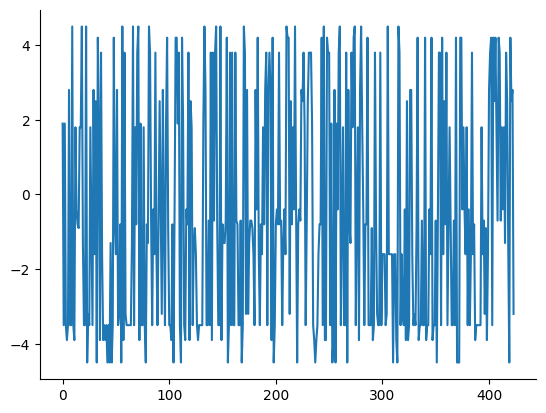

In [ ]:
#@title Hydrophobicity per residue

kyte_doolittle_hydrophobicity = {
    'A': 1.8,
    'R': -4.5,
    'N': -3.5,
    'D': -3.5,
    'C': 2.5,
    'Q': -3.5,
    'E': -3.5,
    'G': -0.4,
    'H': -3.2,
    'I': 4.5,
    'L': 3.8,
    'K': -3.9,
    'M': 1.9,
    'F': 2.8,
    'P': -1.6,
    'S': -0.8,
    'T': -0.7,
    'W': -0.9,
    'Y': -1.3,
    'V': 4.2
}

print("Kyte-Doolittle hydrophobicity plot for %s (%s)"%(id,uniprot))
x = range(len(seq))
y = [kyte_doolittle_hydrophobicity[aa] for aa in seq]
sns.lineplot(x=x, y=y, legend=False)
sns.despine()

SASA plot for A0A384ADE3_BALAS (A0A384ADE3)


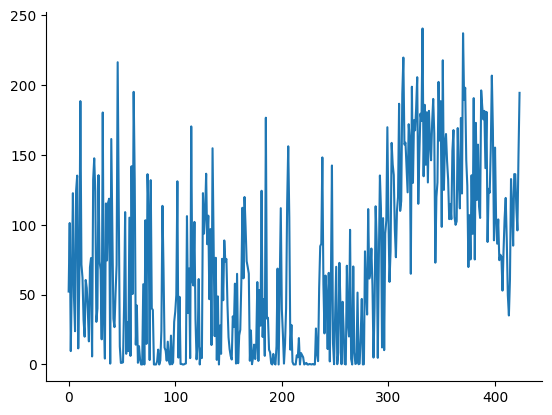

In [ ]:
#@title Solvent accessible surface area per residue

cmd.set('dot_solvent', 1)
cmd.set('dot_density', 3)
resis = []
cmd.iterate('a and name ca', 'resis.append(resi)', space={'resis': resis})

sasa_per_residue = []
for i in tqdm(resis):
    sasa_per_residue.append(cmd.get_area('a and resi %s' % i))


print("SASA plot for %s (%s)"%(id,uniprot))

y = sasa_per_residue
sns.lineplot(x=x, y=y, legend=False)
sns.despine()

delta x: 106.28A, delta y: 91.99A, delta z: 72.62A
Volume of bounding box after PCA: 710058 A^3
Density: 0.004839 atoms per A^3
Globularity: 0.68 (0=long, 1=globular)
Surface area: 30765.71


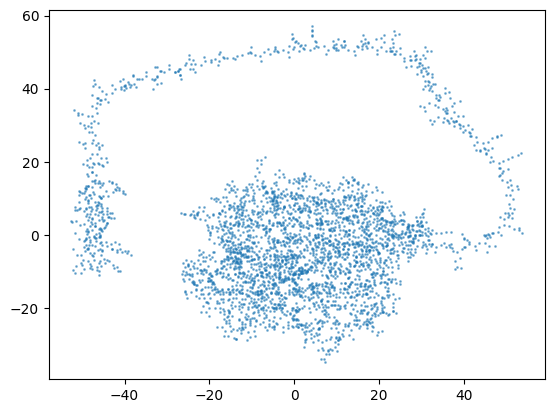

In [ ]:

#@title Length, width, height, volume of bounding box, density, globularity, surface area


from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

coordinates = [(atom.coord[0], atom.coord[1], atom.coord[2]) for atom in cmd.get_model("a").atom]

# Extract x,y,z for CA on chain A for PDB file fn
#coordinates = [(float(line[30:38]), float(line[38:46]), float(line[46:54])) for line in open(fn) if line.startswith('ATOM') and line[21] == "A" and line[12:16].strip() == "CA"]

coordinates2 = PCA(n_components=3).fit_transform(coordinates)

(xs,ys,zs) = zip(*coordinates2)

delta_x = max(xs)-min(xs)
delta_y = max(ys)-min(ys)
delta_z = max(zs)-min(zs)

volume = delta_x*delta_y*delta_z
sasa = cmd.get_area('a')

density = len(coordinates) / volume
globularity = min(delta_x,delta_y,delta_z) / max(delta_x,delta_y,delta_z)

print("delta x: %.2fA, delta y: %.2fA, delta z: %.2fA"%(delta_x,delta_y,delta_z))
print("Volume of bounding box after PCA: %d A^3"%volume)
print("Density: %f atoms per A^3"%density)
print("Globularity: %.2f (0=long, 1=globular)"%globularity)
print("Surface area: %.2f"%sasa)

plt.scatter(xs, ys, s=1, alpha=0.5)
plt.show()

In [ ]:
#@title Domain information

from urllib import request
import json

url="https://www.ebi.ac.uk/interpro/api/entry/all/protein/unreviewed/"+uniprot

req = request.Request(url)
response = request.urlopen(req)
encoded_response = response.read()
decoded_response = encoded_response.decode()
payload = json.loads(decoded_response)
results = payload["results"]

for result in results:
  db = result["metadata"]["source_database"]
  name = result["metadata"]["name"]
  dom = result["metadata"]["type"]
  if dom=="domain":
    start = int(result["proteins"][0]["entry_protein_locations"][0]["fragments"][0]["start"])
    end = int(result["proteins"][0]["entry_protein_locations"][0]["fragments"][0]["end"])
    print(start,end,dom,db,name)


16 292 domain cdd catalytic domain of tyrosine-protein phosphatase non-receptor type 1
3 279 domain interpro Tyrosine-specific protein phosphatase, PTPase domain
189 268 domain interpro Tyrosine-specific protein phosphatases domain
170 276 domain interpro Protein-tyrosine phosphatase, catalytic
40 276 domain pfam Protein-tyrosine phosphatase
3 277 domain profile PTP type protein phosphatase domain profile
189 268 domain profile Tyrosine specific protein phosphatases domain profile
15 279 domain smart Protein tyrosine phosphatase, catalytic domain
170 276 domain smart Protein tyrosine phosphatase, catalytic domain motif


In [ ]:
for k,v in acc2seq.items():
  if len(v)>180:
    print(k)
    break

#AB09 Multiple sequence alignment

The code implements progressive alignment. Given a list of strings, they are one by one aligned. The base is the Levenshtein distance and alignment function, but instead of strings alignments are compared. Overall, the code looks very similar to the basic Levenshtein, yet all of the indices may be confusing. But it works! The key is that we move from using a[i] to access a letter in string a, we now have an alignment, which is represented as a list of strings and the function get(a,i) takes this list and returns a list of the letters at position i for all of the strings in a.

In [ ]:
#@title Multiple sequence alignment


ARROW_N = "\u2191"
ARROW_W="\u2190"
ARROW_NW="\u2196"

def cmp(a,b):
    """Returns the score for comparing a and b, which may characters or the gap symbol.

    cmp defines the scoring scheme for the string distance."""
    if a==b and a!="-":
        return 1
    elif a=="-" or b=="-":
        return 0
    else:
        return 0


def sum_of_pairs(aa,bb):
    """Computes the sum of pairs of all characters in string aa against all characters in string bb.

    aa and bb are alignments and may contain the gap symbol."""
    c=0
    for a in aa:
        for b in bb:
            c+=cmp(a,b)
    return c

def max_dir(a,b,c):
    """Returns the minimum value of a, b, and c and which are minimal.

    c is encoded as NW, b as N and a as W.
    More than one can be the minimum.
    Preference is given to NW, then N, then W.
    This means that alignments with match/mismatch
    from end to front are preferred. If all alignments
    are needed, then the function has to return a set of directions
    instead of single direction."""
    if c==max(a,b,c):
        return (c,"NW")
    if b==max(a,b,c):
        return (b,"N")
    if a==max(a,b,c):
        return (a,"W")

def align(a,b,d_dir,i,j):
    """Outputs the alignment of alignments a and b up to position i and j given the direction matrix d_dir.

    Alignments a and b are lists of strings with the original character sequences possibly with gaps."""
    if i==0 and j==0:
        return [[""]*len(a),[""]*len(b)]
    elif d_dir[i,j]=="N":
        (a2,b2)=align(a,b,d_dir,i,j-1)
        return [add(a2,gap(a)),add(b2,get(b,j-1))]
    elif d_dir[i,j]=="W":
        (a2,b2)=align(a,b,d_dir,i-1,j)
        return [add(a2,get(a,i-1)), add(b2,gap(b))]
    elif d_dir[i,j]=="NW":
        (a2,b2)=align(a,b,d_dir,i-1,j-1)
        return [add(a2,get(a,i-1)), add(b2,get(b,j-1))]

def get(a,i):
    """Returns the list of characters at position i in the alignment a, which is a list of strings."""
    return [s[i] for s in a]

def add(a,aas):
    """Given a list of n strings (an alignment) and a list of n characters, add appends character i to string i."""
    a2=[]
    for i in range(len(a)):
        a2.append(a[i]+aas[i])
    return a2

def ins(a,b):
    """Returns the penalty for inserting/deleting into alignment a or b."""
    return len(a)*len(b)*gap

def gap(a):
    """Returns n gaps for an alignment of n sequences."""
    return ["-"]*len(a)

def lcs_msa(a, b):
    """Align the two alignments a and b and return the common alignment and its score."""
    m = len(a[0])
    n = len(b[0])
    d = {}
    d_dir = {}
    d[(0, 0)] = 0
    d_dir[(0, 0)] = ""
    for i in range(1, m + 1):
        d[(i, 0)] = 0
        d_dir[(i, 0)] = "W"
    for j in range(1, n + 1):
        d[(0, j)] = 0
        d_dir[(0, j)] = "N"
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            (d[(i, j)],d_dir[(i, j)]) = max_dir(d[(i - 1, j)] + sum_of_pairs(get(a,i-1),gap(b)),
                                            d[(i, j - 1)] + sum_of_pairs(gap(a),get(b,j-1)),
                                            d[(i - 1, j - 1)] + sum_of_pairs(get(a,i-1),get(b,j-1)))
    (a1,a2)=align(a,b,d_dir,m,n)
    a1.extend(a2)
    return (d[(m, n)], a1)


def msaList(a):
    """Progressive alignment of the sequences in a.

    Succesively, the sequences in a are added to an alignment.
    The final alignment is returned."""
    b=[a[0]]
    for i in range(1,len(a)):
        (score,b) = lcs_msa(b,[a[i]])
    return (score,b)


names=["Februar","February","Febbraio","Febrero","Fevrier"]

names=["Peter","Pete","Per","Petra","Pierre"]

(s,a)=msaList(names)

for aa in a:
  print(aa)


P-eter-
P-ete--
P---er-
P-et-ra
Pie-rre


#AB10 Hierarchical clustering

In [ ]:
#@title Hierarchical clustering

import random

all = list("abcd")

# initialise and print the pairwise distances
d = {}
for a in all:
  for b in all:
    if a<b:
      d[(a,b)] = random.randint(1,100)
for k in d:
  print("%s, %s"%(k, d[k]))

# get the key of the minimal value in d
def getMin():
  return min(d.keys(), key = lambda k: d[k])

# make sure a < b in node label (a,b)
def label(a,b):
  if str(a)<str(b): return (a,b)
  else: return (b,a)


# main loop for hierarchical clustering
while len(all)>1:
  (a,b)=getMin()
  del d[(a,b)]
  all.remove(a)
  all.remove(b)
  for c in all:
    ac=d[label(a,c)]
    bc=d[label(b,c)]
    del d[label(a,c)]
    del d[label(b,c)]
    d[label((a,b),c)] = min(ac,bc)
  all.append(label(a,b))

# print the result
print("\n%s"%(str(all[0])))



('a', 'b'), 7
('a', 'c'), 20
('a', 'd'), 90
('b', 'c'), 40
('b', 'd'), 10
('c', 'd'), 95

((('a', 'b'), 'd'), 'c')


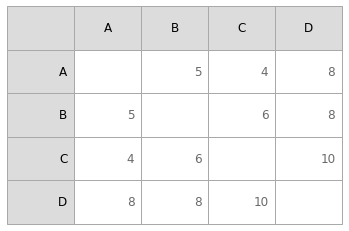

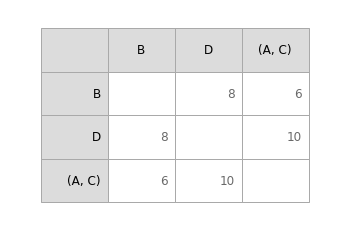

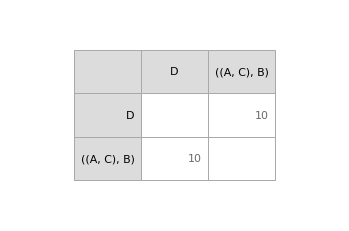

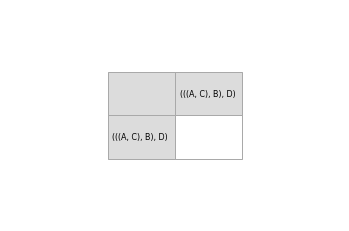


Hierarchical clustering tree: ((('A', 'C'), 'B'), 'D')


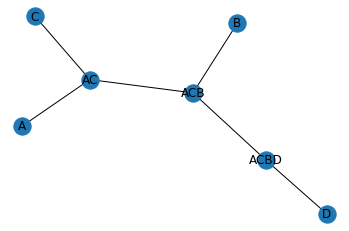

(<toyplot.canvas.Canvas at 0x7f36fbad1898>,
 <toytree.Render.ToytreeMark at 0x7f36fb9d5898>)

<svg class="toyplot-canvas-Canvas" height="275.0px" id="t6e8dbb0f5d0d484e8886858cdc661dc9" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 255.0 275.0" width="255.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> C A B D

In [ ]:
#@title  Hierarchical clustering with details
import random
from tabulate import tabulate
import networkx as nx
import matplotlib.pyplot as plt
!pip -q install toytree
import toytree

all = list("abcd")

def label(a,b):
  """For a node (a,b) in a tree, a is less than b, so that they are ordered."""
  if str(a)<str(b): return (a,b)
  else: return (b,a)

# initialise the pairwise distances
d = {}
for a in all:
  for b in all:
    if a<b:
      d[label(a,b)] = random.randint(1,100)

all = list("ABCD")
d = {}
d={("A","B"):5, ("A","C"):4, ("A","D"):8, ("B","C"):6, ("B","D"):8, ("C","D"):10}



# get the key of the minimal value in d
def getMin():
  return min(d.keys(), key = lambda k: d[k])

def nice(label):
  if type(label)==str: return label
  else: return nice(label[0])+nice(label[1])

def nice2(tree):
  if type(tree)==str: return tree
  else: return "(%s, %s)"%(nice2(tree[0]),nice2(tree[1]))

# print the matrix with all distances
def print_distance_matrix():
  row = [" "]+[nice2(a) for a in all]
  rows=[row]
  for a in all:
    row = [nice2(a)]
    for b in all:
      if label(a,b) in d:
        row.append(d[label(a,b)])
      else:
        row.append("")
    rows.append(row)
  print("\n\nd=\n"+tabulate(rows, tablefmt="pretty", numalign="right"))

# print the matrix with matplotlib
def print_distance_matrix2():
  fig, ax = plt.subplots()
  columns = [" "]+[nice2(a) for a in all]
  n = len(all)
  colors = [list("w"*(n+1)) for i in range(n)]
  cell_text = [list(" "*(n+1)) for i in range(n)]
  for i in range(n):
    for j in range(n):
        if label(all[i],all[j]) in d:
          s = str(d[label(all[i],all[j])])
          cell_text[i][j+1] = s
  the_table = ax.table(cellText=cell_text,
                       cellColours=colors,
                       colLabels=columns,
                       cellLoc='right',
                       loc='center')
  for i in range(n+1):
    for j in range(n+1):
      the_table[i,j].set_edgecolor("#A9A9A9")
      the_table[i,j].get_text().set_color("#696969")
      the_table[i,j].set_height(0.2)
      the_table[i,j].set_width(0.2)
  # first row
  for j in range(n+1):
    the_table[0,j].set_facecolor("#DCDCDC")
    the_table[0,j].get_text().set_color("#000000")
    the_table[0,j].loc="center"
  # first column with centered characters in black on grey background
  for i in range(n+1):
    the_table[i,0].get_text().set_text(nice2(([("")]+all)[i]))
    the_table[i,0].loc="center"
    the_table[i,0].set_facecolor("#DCDCDC")
    the_table[i,0].get_text().set_color("#000000")

  ax.axis('tight')
  the_table.set_fontsize(12)
  ax.axis('off')
  plt.show()

# initialise the graph for visualisation
G = nx.Graph()
for a in all:
  G.add_node(a)

#print_distance_matrix()
print_distance_matrix2()

# main loop for hierarchical clustering
while len(all)>1:
  (a,b)=getMin()
  del d[(a,b)]
  all.remove(a)
  all.remove(b)
  for c in all:
    ac=d[label(a,c)]
    bc=d[label(b,c)]
    del d[label(a,c)]
    del d[label(b,c)]
    d[label((a,b),c)] = max(ac,bc)
  all.append(label(a,b))
  G.add_node(nice(label(a,b)))
  G.add_edge(nice(label(a,b)),nice(a))
  G.add_edge(nice(label(a,b)),nice(b))
  #print_distance_matrix()
  print_distance_matrix2()

print("\nHierarchical clustering tree: %s"%(str(all[0])))
plt.subplot(111)
nx.draw(G, with_labels=True)
plt.show()

# I found this nice library which plots the trees as should be ;-)
t=toytree.tree(nice2(all[0])+";")
t.draw()


# AB11 Neighbour joining

Neighbour joining is closely related to hierarchical clustering. The main while loop is more or less the same as in AB10. The key difference is how the minimum is chosen. For this NJ computes the Q matrix, which takes a global perspective on mutual distances and picks the two nodes with best Q value. The second difference to HC is that NJ sets different lengths to branches. This is captured in the variable d_a_ab e.g., which defines the distance of the node a to its new parent (a,b). You should be able to spot the formulae from the lecture.

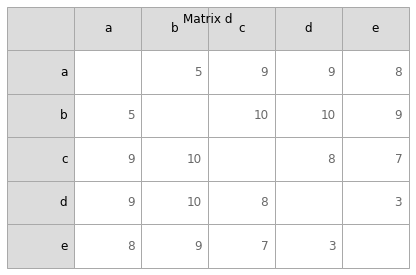

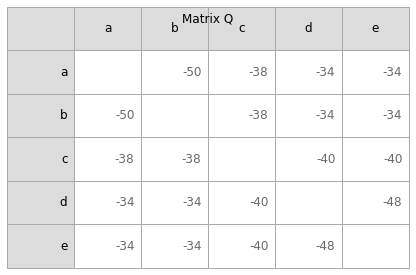

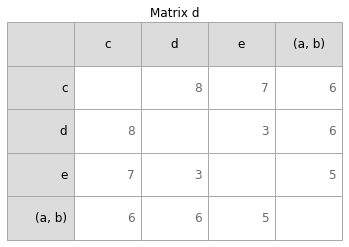

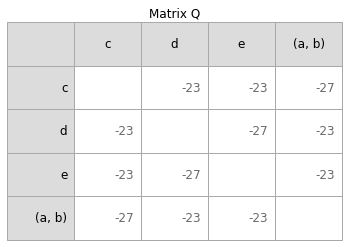

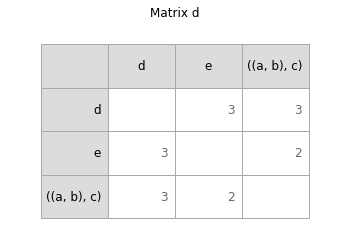

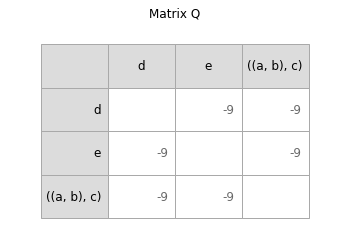

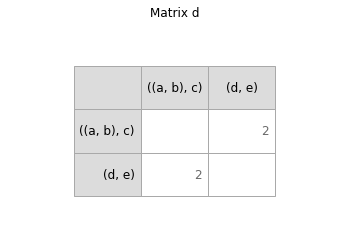

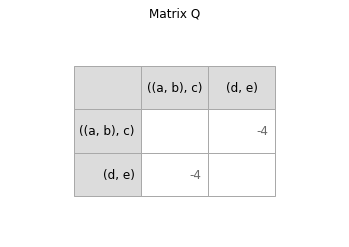


Neighbour joining tree: (('d', 'e'), (('a', 'b'), 'c'))


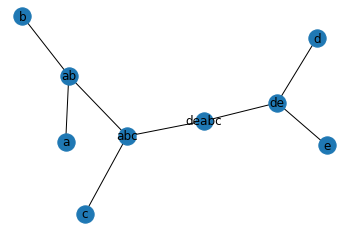

In [ ]:
#@title Neighbour joining

import random
from tabulate import tabulate
import networkx as nx
import matplotlib.pyplot as plt

all = list("abcde") # The nodes to be clustered
d = {} # The distance matrix
Q = {} # The Q matrix

def label(a,b):
  """For a node (a,b) in a tree, a is less than b, so that they are ordered."""
  if str(a)<str(b): return (a,b)
  else: return (b,a)

# initialise the pairwise distances
for a in all:
  for b in all:
    if a<b:
      d[label(a,b)] = random.randint(1,100)

#d = {("a","b"):5, # This is the example from the lecture
#     ("a","c"):9,
#     ("a","d"):9,
#     ("a","e"):8,
#     ("b","c"):10,
#     ("b","d"):10,
#     ("b","e"):9,
#     ("c","d"):8,
#     ("c","e"):7,
#     ("d","e"):3
#     }


def nice(label):
  if type(label)==str: return label
  else: return nice(label[0])+nice(label[1])

def nice2(tree):
  if type(tree)==str: return tree
  else: return "(%s, %s)"%(nice2(tree[0]),nice2(tree[1]))

# print the matrix with matplotlib
def print_matrix(dQ, name):
  fig, ax = plt.subplots()
  columns = [" "]+[nice2(a) for a in all]
  n = len(all)
  colors = [list("w"*(n+1)) for i in range(n)]
  cell_text = [list(" "*(n+1)) for i in range(n)]
  for i in range(n):
    for j in range(n):
        if label(all[i],all[j]) in dQ:
          cell_text[i][j+1] = str(int(dQ[label(all[i],all[j])]))
  the_table = ax.table(cellText=cell_text,
                       cellColours=colors,
                       colLabels=columns,
                       cellLoc='right',
                       loc='center')
  for i in range(n+1):
    for j in range(n+1):
      the_table[i,j].set_edgecolor("#A9A9A9")
      the_table[i,j].get_text().set_color("#696969")
      the_table[i,j].set_height(0.2)
      the_table[i,j].set_width(0.2)
  # first row
  for j in range(n+1):
    the_table[0,j].set_facecolor("#DCDCDC")
    the_table[0,j].get_text().set_color("#000000")
    the_table[0,j].loc="center"
  # first column with centered characters in black on grey background
  for i in range(n+1):
    the_table[i,0].get_text().set_text(nice2(([("")]+all)[i]))
    the_table[i,0].loc="center"
    the_table[i,0].set_facecolor("#DCDCDC")
    the_table[i,0].get_text().set_color("#000000")
  ax.axis('tight')
  plt.title("Matrix "+name)
  the_table.set_fontsize(12)
  ax.axis('off')
  plt.show()


def u(a):
  """sums up all distances from a"""
  return sum([d[label(a,b)] for b in all if label(a,b) in d])

def getQ():
  """calculates Q matrix and returns tuple (i,j) of the two nodes i and j with minimal Q value."""
  Q={}
  for a in all:
    for b in all:
      if label(a,b) in d:
        Q[label(a,b)] = (len(all)-2)*d[label(a,b)] - u(a) - u(b)
  return Q

def minQ(Q):
  return min(Q.items(), key=lambda x:x[1])[0]

# initialise the graph for visualisation
G = nx.Graph()
for a in all:
  G.add_node(a)

# main loop for hierarchical clustering
while len(all)>1:
  print_matrix(d, "d")
  Q=getQ()
  print_matrix(Q, "Q")
  (a,b)=minQ(Q)
  d_a_ab = 0.5*d[label(a,b)] + (1/(2*len(all)-2))*(u(a)-u(b))
  d_b_ab = 0.5*d[label(a,b)] + (1/(2*len(all)-2))*(u(b)-u(a))
  all.remove(a)
  all.remove(b)
  del d[(a,b)]
  for c in all:
    d[label((a,b),c)] = d[label(a,c)] - d_a_ab
    del d[label(a,c)]
    del d[label(b,c)]
  all.append(label(a,b))
  G.add_node(nice(label(a,b)))
  G.add_edge(nice(label(a,b)),nice(a), length=d_a_ab)
  G.add_edge(nice(label(a,b)),nice(b), length=d_b_ab)

print("\nNeighbour joining tree: %s"%(str(all[0])))
plt.subplot(111)
nx.draw(G, with_labels=True)
plt.show()


#AB13 Co-evolution

We are getting to the final lab and to a very exiting one. Sofar we have covered the sequence world with its masses of data, which is set apart from the structure world, which has far less data. But current research shows that sequence may be the key to structure. In fact, multiple sequence alignments! One of the coolest results in bioinformatics is that statistical analysis of the co-evolution of residues in multiple sequence alignments holds sufficient information to predict contacts in 3D structure and that is sufficient information to fold the protein correctly. Check out https://evcouplings.org/ for this work. In this final lab we will pull all of these things together and implement a very simple co-evolution analysis, which explains the principles of these recent scientific break-throughs.

The starting point are multiple sequence alignments, which we take from PFAM. Step one: visit PFAM and select a family, which you  find interesting. Here, we chose thymidine kinases of a herpes virus. We download the aligment and filter out sequences, which are too short. Next, we turn columns in the alignment into binary vectors: 0 of the residue is the main conserved residue for this position and 1 otherwise. If we compare to of these binary vectors then matching 1's mean that both columns deviated from the conserved residue both at the same time. We count how frequently it happens. The more often the better, the more likely, that these changes are coordinated and depend on each other. We plot this in a heat map.

For comparison we plot a heat map for the real contact in a 3D structure.

There are still some todos: The heat map of the structure uses all chains. Just use one. The color scheme is different and needs adjustment.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     |████████████████████████████████| 2.1MB 2.8MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 61kB 1.7MB/s 
     |████████████████████████████████| 10.4MB 6.8MB/s 
ERROR: google-colab 1.0.0 has requirement pandas~=1.0.0; python_version >= "3.0", but you'll have pandas 0.25.3 which is incompatible.



Alignment has 808 sequences.
Sequences range from 37 to 290 amino acids. Average is 235, median 274, stdev 62.56.
152 (43 percent) of the 352 columns in the alignment are conserved at more than 50 percent.



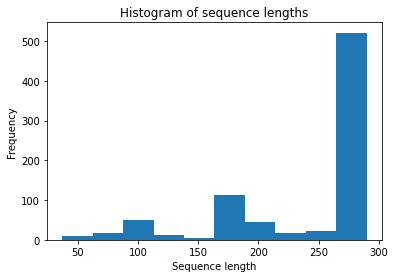


Removing sequences deviating too much from median sequence length.


Alignment has 559 sequences.
Sequences range from 217 to 290 amino acids. Average is 272, median 274, stdev 10.22.
266 (75 percent) of the 352 columns in the alignment are conserved at more than 50 percent.



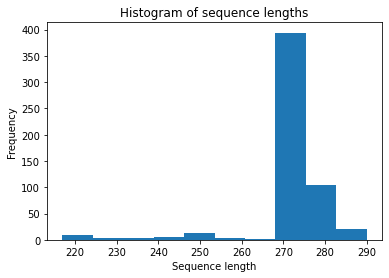

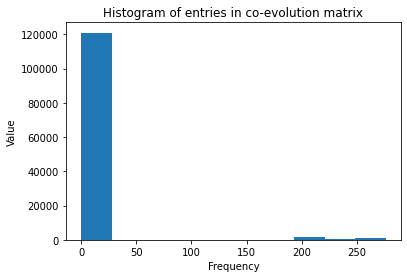


Co-evolution matrix for Pfam family PF00693


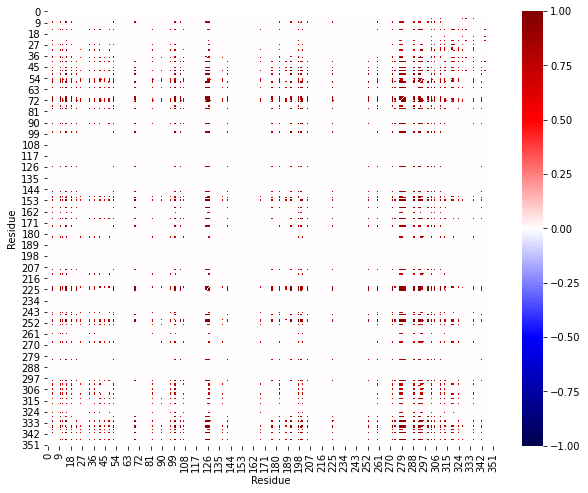

/usr/local/lib/python3.6/dist-packages/contact_map/contact_count.py:132: RuntimeWarning: The number of pixels in the figure is insufficient to show all the contacts.
 Please save this as a vector image (such as a PDF) to view the correct result.
 Another option is to increase the 'dpi' (currently: 72.0), or the 'figsize' (currently: (10.0, 8.0)).
 Recommended minimum amount of pixels = (1278, 1278) (width, height).
  warnings.warn(msg, RuntimeWarning)


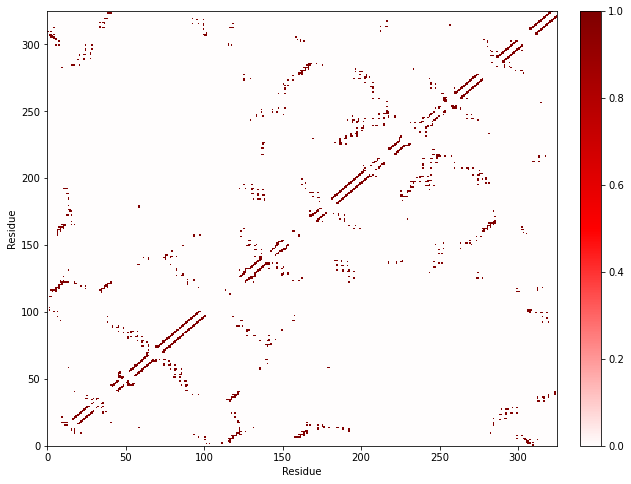

In [ ]:
#@title Co-evolution

from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import requests # to retrieve data from a url
import os.path  # to check if a file exists
import math
from statistics import median, stdev
!pip -q install mdtraj
!pip -q install contact_map
import mdtraj as md # protein structure code
from contact_map import ContactMap


pfam_id = "PF00693" # Herpes thymidine kinase
minConservation = 0.5 # Minimal conservation for a column in the multiple sequence alignment
pdb_id = "1OSN" # The structure of a herpes thymidine kinase

##########################################
#
# PFAM DATA
#
# Our starting point is a mutliple sequence alignment from PFAM.
# Visit PFAM and identify a suitable family.
# Here we go with herpes thymidine kinases: PF00693.
# (to learn more just search the internet for the ID and PFAM).
##
##########################################


pfam = [
"A2FX79_TRIVA/20-146       YYD-KQ-QFLQLRATLCQMSSKIKR-------------NKKISKFAEALEIIKRWAIRGDYEDHKRCLACGVLWFDQE---IAINTQQLKFLLFKCKSS-----INSTLHDSGLQPAPREAL--QKLLMERYP----YLKN--NMGEIR-KWTLRTYQP",
"A2EL50_TRIVA/14-141       ESD-QR-MYRKIQEVLSQLSTKNKR-------------NTKIDDFRELVDAIDIFENYDKESKWRRCLACGLVKFDGG---IAVNTSQLSILALRCKTS-----INTSLKGMGYTIISGNSSE-SEEFLKEIP----YISG--NPSEMR-QWTVRYLEE",
"A2DCS1_TRIVA/23-150       EAD-KQ-TYDRICAALTAPSNKNKK-------------NKRADEFREILEAISLFENHDEVDKWKRCLVCGVYQFEGG---IAVNISALKRLVFKCKSS-----INGSLKAIGYPNVTYKSST-CEELLKGIP----ILRG--NTAELR-QWTVRYQAP",
"A2F449_TRIVA/18-145       DTD-KM-TYDRIRQAITAPSNKNKK-------------NKRADEFREILEAIELYENHDQADKWKRCLVCGVFIFDKG---IAIKISALKQLIYKCKSS-----INGSLKAIGYPNVDYKSSM-CDELLNGIP----FLRG--NLVELR-QWTVRFRDR",
"A2EU97_TRIVA/13-140       ETD-KE-KYNELHQEFSSGVMKRAR-------------NGRAESFEEMLENIKKYCIRNDEDDWKRYLVCGVCWMDEA---IAINTRQLRLLVCKCKSS-----INGSLQKMGFSTNMAHSES-WKILFPKIP----LLKD--HFSELR-KWTIRYKPK",
"A2DGT4_TRIVA/24-151       PRD-KE-EYLSLKSLLDESSTKRNR-------------GHRMEAFDGILEAIHRYAERHDDDDWRRFLVCGVCWMDNM---IAINTRQLRLLISKCKSS-----INGSFQKMGYTTSQSHTES-RKFLFGKIP----LLKG--NFNELR-QWTIRSRAP",
"A2FBZ9_TRIVA/24-151       ETD-KN-SYKTLKLALDASISKRNR-------------GHRMEAFDSVLNAIHRFAERHDENDWRRFLVCGLCWMDNM---IAINTRQLRLLISKCKSS-----INGSLHKLGYTTNQSHTES-WKYLFDRIP----YLKD--NFPELR-QWTLRSRAS",
"A2DX95_TRIVA/16-143       DAD-KY-QYNCLRYSIATTASKNQR-------------NKRISTFNEAMDAIKMFAIRGDANDKLRSLVCGICWLNEG---IAINTHQLKTLLGKCKSS-----INGSLQKIGFSSNISRAET-TNAMTRFFP----FLNE--NSSELR-KWSVRNYPQ",
"A2E640_TRIVA/20-147       PID-MQ-RYNYLRLALSSSETKNQR-------------NRRIATFTEAMEAVRGFAIRGDSNDKLRCLVCGIAWLPEG---IAINTHQLKLLISRCKSS-----INGSLQKLGFTENLGRTAA-ANAMIAQYS----FLKE--NSTELR-KWSVRRKPS",
"A2DX21_TRIVA/22-149       KAD-LH-QYNCLRLALTSSESKNQR-------------NRRIATFTEAIEAVRVFAVRGDQYDRIRCLVCGIAWLPEG---LAINTHQLKLLISRCKSS-----INGSFQKLGFTEKLRRLAA-ANALISVYP----FLNE--NTSELR-KWSVRKRPA",
"A2EQ67_TRIVA/19-146       DMD-KY-HYNCLRMSISSQYSKNIR-------------NKRVENFTEIIDIIKRYCIRGQPDDWRRCLVCGVAWLHEG---IAINTRQLRLLIFKCKSS-----INGSLHKMGFTVNIGRTEA-ANALVMAIP----ILKD--NTNELR-QWTVRQTGN",
"A2FFZ1_TRIVA/19-146       DFD-KY-QYNCLRANLSANYSKNQR-------------NKRIENFTEILEIIRRFCVRGDGDDWRRFLVCGYCCFPDG---IAINTRQLKLLIFKCKSS-----INGSLHKMGLSSNIAKNEA-TNSLIMAIP----ILRD--NINEMR-QWTVRKFIK",
"A2DT03_TRIVA/19-146       DFD-KF-QYGILRVSLSTHYAKNQR-------------NKRVGNFTEILELIKRFCIRGDADDWRRCLVCGVCWLPNG---IAVNTRQLKLLIFKCKSS-----INGSLHKMGYSVNFGRAEP-TNSLVMAIP----ILKD--NINELR-QWTIRQCVG"
]

def url(id): # id e.g. "PF00693"
  """returns the url to retrieve an alignment for Pfam family."""
  return "https://pfam.xfam.org/family/"+id+"/alignment/uniprot/format?format=pfam&alnType=uniprot&order=t&case=l&gaps=dashes&download=0"

def cleanSeq(seq):
  """removes dashes from a sequence from an alignment."""
  return "".join([aa for aa in seq if aa != "-"])

def getCol(pfam, i):
  """returns the ith column from the list of aligned sequences"""
  return [p[i] for p in pfam]

def conserved(col):
  """takes a column of a multiple sequence alignment as input and
  returns the most conserved residue if that residue is conserved in more than X percent of
  the sequences. Otherwise it returns a dash."""
  freq = defaultdict(int)
  for c in col:
    freq[c]+=1
  (residue,count) = max(freq.items(), key=lambda x:x[1])
  if residue != "-" and count>int(minConservation*len(col)):
    return residue
  else: return "-"

def modifiedZscore(s,med,std):
  return abs(s-med)/std

def printPfamStats(pfam):
  print("\nAlignment has %d sequences."%(len(pfam)))
  seqLen = [len(cleanSeq(seq)) for seq in pfam]
  print("Sequences range from %d to %d amino acids. Average is %d, median %d, stdev %.2f."%(min(seqLen), max(seqLen), int(sum(seqLen)/len(seqLen)), median(seqLen), stdev(seqLen)))
  lenAlignment = len(pfam[0])
  noConserved = sum([1 for i in range(lenAlignment) if conserved(getCol(pfam,i))!="-" ])
  print("%d (%d percent) of the %d columns in the alignment are conserved at more than %d percent.\n"%(noConserved, int(100*noConserved/lenAlignment), lenAlignment, int(100*minConservation)))
  sns.despine()
  plt.hist(seqLen)
  plt.xlabel("Sequence length")
  plt.ylabel("Frequency")
  plt.title("Histogram of sequence lengths")
  plt.show()

def cleanPfam(pfam):
  """keeps only sequences which have the median length."""
  print("\nRemoving sequences deviating too much from median sequence length.\n")
  seqLen = [len(cleanSeq(seq)) for seq in pfam]
  med = median(seqLen)
  std = stdev(seqLen)
  return [seq for seq in pfam if modifiedZscore( len(cleanSeq(seq)), med, std) < 1]

def getPfam(id):
  """downloads or loads Pfam alignment given by id. If the alignment exists locally
  as a file, then just load it. Otherwise get it from the internet and store it in a file
  to avoid retrieval at next run."""
  fn = id+".txt"
  if os.path.exists(fn):
    print("\n\nLoading Pfam alignment %s"%(id))
    f = open(fn)
    data = f.read()
  else:
    print("\n\nDownloading Pfam alignment %s"%(id))
    r = requests.get( url(id) )
    data = str(r.content, encoding = 'utf-8')
    f = open(fn, "w")
    f.write(data)
    f.close()
  rows=[]
  for line in data.split("\n"):
    if line!="":
      seq = line.split()[1]
      rows.append(seq)
  printPfamStats(rows)
  rows = cleanPfam(rows)
  printPfamStats(rows)
  return rows

def res2bin(col,res):
  """turns a columns of an alignment into a binary vector. The residue res is the
  conserved residue. Each entry in the column is compared to res. If the entry is equal
  to res it becomes 0 and otherwise 1."""
  return [int(res2!=res) for res2 in col]

def sizeIntersection(vec1, vec2):
  """returns the size of the intersection of vec1 and vec2."""
  return sum([1 for (i,j) in zip(vec1,vec2) if i==1 and j==1])

def align2coev(pfam):
  """compares all columns in an alinment with each other and counts how frequently both
  columns agree in terms of conserved residue or change. This is an extremely simplified
  approach to co-evolution, but you start playing from here."""
  coev = defaultdict(int)
  noCol = len(pfam[0])
  for i in range(noCol):
    for j in range(i+1, noCol):
      col_i = getCol(pfam, i)
      col_j = getCol(pfam, j)
      res_i = conserved(col_i)
      res_j = conserved(col_j)
      if res_i!="-" and res_j!="-":
        value = sizeIntersection(res2bin(col_i, res_i), res2bin(col_j, res_j))
        if value<200: value=0
        coev[(i,j)] = value
        coev[(j,i)] = value
  rows = []
  for i in range(noCol):
    row = []
    for j in range(noCol):
      if (i,j) in coev:
        row.append(coev[i,j])
      else:
        row.append(0)
    rows.append(row)
  rows.reverse()
  return rows

##########################################
#
# Main programme to compute co-evolution matrix
# from a Pfam alignment.
#
###########################################

# Get the Pfam alignment
pfam = getPfam(pfam_id)

# Compute the coevolution matrix from the Pfam alignment
contactMatrix = align2coev(pfam)

# Display a histogram of the values in the co-evolution matrix
values = [value for row in contactMatrix for value in row]
maxVal = max(values)
plt.hist(values)
plt.title("Histogram of entries in co-evolution matrix")
plt.xlabel("Frequency")
plt.ylabel("Value")
plt.show()

# Display the co-evolution matrix
print("\nCo-evolution matrix for Pfam family %s"%pfam_id)
plt.rcParams["figure.figsize"] = (10,8) # make it large
normalisedContactMatrix = [[val/maxVal for val in row] for row in contactMatrix]
ax = sns.heatmap(normalisedContactMatrix, cmap='seismic', vmin=-1, vmax=+1, annot=False)
plt.xlabel("Residue")
plt.ylabel("Residue")
plt.show()













##########################################
#
# Contact map from PDB
#
# Next, we show the real contact map from a PDB file.
#
##########################################


def getPDB(id):
  """Get a PDB file"""
  fn = id+".pdb"
  if os.path.exists(fn):
    print("Loading PDB structure %s"%id)
    pdb = md.load_pdb(fn)
  else:
    print("Downloading PDB structure %s"%fn)
    pdb = md.load_pdb('https://files.rcsb.org/view/'+fn)
    pdb.save(fn)
  return pdb

def getSeq(pdb):
  """Return the sequence of the PDB file"""
  chain0 = [a.index for a in pdb.topology.chain(0).atoms]
  top = pdb.topology.subset(chain0)
  return "".join([r.code for r in top.residues if r and r.code])

def cmap(pdb):
  """Display the contact map of a PDB file using mdtraj and contactmap modules."""
  chain0 = [a.index for a in pdb.topology.chain(0).atoms]
  contacts = ContactMap(pdb[0], query=chain0) #haystack=chain0
  (fig, ax) = contacts.residue_contacts.plot(cmap='seismic', vmin=-1, vmax=1)#, figsize=(20, 20))#, dpi=454)
  plt.xlabel("Residue")
  plt.ylabel("Residue")
  plt.xlim(right=pdb.topology.chain(0).n_residues)
  plt.ylim(top=pdb.topology.chain(0).n_residues)
  plt.show()

pdb = getPDB(pdb_id)
cmap(pdb)





# OLD MATERIAL FROM HERE BELOW

In [ ]:
#@title ids of YBX1 proteins (as of 23.03.2024)

s="A0A096NDV6 A0A0D9RB41 A0A286Y3L3 A0A2I3LIW5 A0A2J8SMJ2 A0A2K5DE74 A0A2K5KVT2 A0A2K5N230 A0A2K5S2N1 A0A2K5ULD0 A0A2K5ZPG6 A0A2K6AYZ0 A0A2K6G709 A0A2K6KDC0 A0A2K6N9M6 A0A2K6SCQ6 A0A2R8MBG2 A0A2R9BJA3 A0A2Y9LPB1 A0A2Y9SS23 A0A2Y9T8Q1 A0A3Q7RF82 A0A452E3F5 A0A452R460 A0A4W2F9C0 A0A4W2ILA8 A0A4X2LSF7 A0A5G2QC41 A0A8C5UWH3 A0A8C5XEH7 A0A8C8WCV4 A0A8C9M390 A0A8I3RZ88 A0A8I6ANG4 A1YES6 A1YFZ3 A2T6Y4 A2T7I6 B0JYP5 B5ABI3 B5DE31 B5DF91 F6VPM9 F6WXU2 F7H579 G1LEP7 G1QLE6 G1RP00 G3QQ03 G3R705 G3T0A8 G3TAB5 G3W6U2 H0WXD0 H2PRA2 H2QWS0 I3MB33 M3VZ48 M3XS64 O00571 O15156 O15355 O35295 O35980 O60506 O70133 O77503 O88477 O95793 P03086 P11940 P13693 P14678 P17136 P19712 P23196 P27048 P27695 P28352 P29341 P35922 P42669 P43138 P51858 P51859 P62310 P62500 P62960 P62961 P63208 P67808 P67809 P70372 P78549 P83369 P86252 P97440 P97868 Q00577 Q00839 Q01149 Q06066 Q06787 Q07021 Q08211 Q08J23 Q09472 Q0IIK5 Q13148 Q13616 Q14103 Q14493 Q15327 Q15366 Q15717 Q1HFZ0 Q28141 Q28618 Q3ZBX7 Q4R7L5 Q58DW4 Q5NVJ8 Q5R874 Q5R9B4 Q61990 Q62167 Q64092 Q641Y8 Q64318 Q64321 Q68A21 Q68SB1 Q6IMY8 Q6PEC4 Q6QME8 Q7T2L8 Q7TMF2 Q7TMK9 Q7TP47 Q7Z6E9 Q80WE1 Q8BUV6 Q8CGX0 Q8CJ67 Q8CJG0 Q8CJG1 Q8IV48 Q8R560 Q8VEK3 Q8VHK7 Q91VR5 Q91Z31 Q92499 Q96QR8 Q96SB4 Q99697 Q9CR42 Q9EPH8 Q9GZV1 Q9JKP5 Q9NR56 Q9NUL3 Q9NZI8 Q9PTF7 Q9PV94 Q9QZ81 Q9TU66 Q9UKA9 Q9UKV8 Q9UL18 Q9UN81 Q9WTX5 Q9WTX6 Q9WV06 Q9Y315 Q9Z108 A0A091EH33 A0A096MUR2 A0A096NL04 A0A0D9RF82 A0A0P6JUJ6 A0A1D5Q8I3 A0A1D5QH79 A0A1S3A244 A0A1S3AAU4 A0A1S3ETT4 A0A1S3FXC0 A0A1U7R8B7 A0A1U7SMY5 A0A1U7V1X7 A0A212CYK7 A0A250YLH9 A0A286ZQ43 A0A287AY99 A0A287B5S7 A0A287D7Q5 A0A2I2ZFC5 A0A2I2ZSA7 A0A2I3NHU3 A0A2I3S0Z1 A0A2J8INL8 A0A2J8LFA6 A0A2K5CLL4 A0A2K5DE84 A0A2K5ECR8 A0A2K5IF52 A0A2K5IFB4 A0A2K5IFI8 A0A2K5N2I1 A0A2K5NC89 A0A2K5PZJ8 A0A2K5S2I0 A0A2K5S2L3 A0A2K5S2P3 A0A2K5S2R0 A0A2K5UL92 A0A2K5ULH4 A0A2K5V0J3 A0A2K5YA63 A0A2K5ZP87 A0A2K5ZP96 A0A2K5ZPA6 A0A2K5ZPB9 A0A2K5ZPC5 A0A2K6AYX5 A0A2K6AYX8 A0A2K6AYY8 A0A2K6AYZ2 A0A2K6D920 A0A2K6E4C2 A0A2K6FM47 A0A2K6G703 A0A2K6G713 A0A2K6G718 A0A2K6KD92 A0A2K6KD94 A0A2K6KDA6 A0A2K6KDB2 A0A2K6KDB7 A0A2K6MQR3 A0A2K6N9H6 A0A2K6N9J3 A0A2K6N9L3 A0A2K6QIK4 A0A2K6SCP7 A0A2K6SCS6 A0A2K6SCU2 A0A2K6SCU9 A0A2K6TCI9 A0A2R8MUU9 A0A2R8N5J5 A0A2R8Z7L4 A0A2R9BJB6 A0A2R9BJC8 A0A2U3W5D4 A0A2U3WB47 A0A2U3YE14 A0A2Y9DFJ5 A0A2Y9E5F1 A0A2Y9EEP3 A0A2Y9F0R0 A0A2Y9H5D8 A0A2Y9HVI1 A0A2Y9JAC6 A0A2Y9JAC8 A0A2Y9KN13 A0A2Y9LNE6 A0A2Y9LRA7 A0A2Y9LW03 A0A2Y9M1G6 A0A2Y9PTL0 A0A2Y9QQ38 A0A2Y9T2J1 A0A337S6G1 A0A340WW24 A0A341B1M7 A0A341B1R1 A0A341B558 A0A341CJX1 A0A341CL36 A0A384A2Z4 A0A384A3D2 A0A3G9GRT6 A0A3Q0DGA6 A0A3Q0DM88 A0A3Q1M1Q7 A0A3Q1MDA1 A0A3Q1MM22 A0A3Q7NZ26 A0A3Q7NZS6 A0A3Q7PGD2 A0A3Q7QY11 A0A3Q7REW2 A0A3Q7SG73 A0A452E3K3 A0A452E3L3 A0A452E3Q2 A0A452EMB6 A0A452R3J2 A0A452R3N9 A0A452R3W3 A0A452R427 A0A452R451 A0A452R476 A0A452R4F4 A0A452SBN0 A0A452SBN3 A0A452V2W2 A0A452VB21 A0A480TL99 A0A480UQE0 A0A485NDW3 A0A485PPW4 A0A485PV54 A0A493TX89 A0A4U1FQE9 A0A4W2C406 A0A4W2DQM3 A0A4W2E371 A0A4W2F5P4 A0A4X1SLH5 A0A4X1SLK2 A0A4X1SLK8 A0A4X1SLM4 A0A4X1SLS2 A0A4X1SLX2 A0A4X1SLZ3 A0A4X1SMZ4 A0A4X2KQM0 A0A5E4B2V7 A0A5E4BZW8 A0A5F5PW75 A0A5G2R5E3 A0A5G2RM57 A0A5N3VIP9 A0A5N4BZB6 A0A663DG72 A0A667HMF1 A0A671F4V6 A0A671F8K7 A0A671G2R6 A0A673TNL1 A0A673VA91 A0A6B0QX02 A0A6B0RQ55 A0A6I9I641 A0A6I9LHK5 A0A6I9M856 A0A6J0DDQ5 A0A6J0E401 A0A6J0E9K0 A0A6J0EBI4 A0A6J0WZT1 A0A6J1Y319 A0A6J1ZSN7 A0A6J1ZTY2 A0A6J2DG83 A0A6J2DIL2 A0A6J2DK36 A0A6J2EK20 A0A6J2EK22 A0A6J2EM07 A0A6J2EUP4 A0A6J2LW92 A0A6J2ND23 A0A6J3B799 A0A6J3BCG5 A0A6J3BEA9 A0A6J3FBG0 A0A6J3FBH6 A0A6J3H0Q4 A0A6J3H2L2 A0A6J3PZN9 A0A6J3Q0A9 A0A6J3Q8J3 A0A6J3Q901 A0A6J3Q9B4 A0A6P3F181 A0A6P3GU08 A0A6P3R4I3 A0A6P3R4V8 A0A6P3R6A8 A0A6P3RCY9 A0A6P3RCZ4 A0A6P5E184 A0A6P5IVV4 A0A6P5LVJ2 A0A6P5NR66 A0A6P5NWE5 A0A6P5R563 A0A6P6BQ06 A0A6P6DM91 A0A6P6E5W1 A0A6P6F5F2 A0A6P6H9V2 A0A6P7QFI5 A0A7E6E7U5 A0A7F8RJ77 A0A7J7THI6 A0A7J7THL6 A0A7J7TIB2 A0A7J7VM37 A0A7J7YZ93 A0A7J8C0U2 A0A7J8C0U9 A0A7J8DSR0 A0A811Z0Y6 A0A812A018 A0A833ZKB5 A0A834B446 A0A835ZXX9 A0A8B6ZPT6 A0A8B6ZUA6 A0A8B7EAR9 A0A8B7EUS9 A0A8B7EUT2 A0A8B7EUT5 A0A8B7RSP6 A0A8B7RUI6 A0A8B7SLT4 A0A8B7UZR1 A0A8B8RDL8 A0A8B8RDS8 A0A8B8RFP2 A0A8B8RG57 A0A8B8S215 A0A8B8V5Q3 A0A8B8V6A2 A0A8B8VP71 A0A8B8VPY1 A0A8B9YW43 A0A8B9Z227 A0A8C0AKL6 A0A8C0DF38 A0A8C0KMP0 A0A8C0KPM4 A0A8C0KQV6 A0A8C0KR21 A0A8C0KR57 A0A8C0KRA6 A0A8C0KRJ1 A0A8C0KRV0 A0A8C0KRZ2 A0A8C0KTW5 A0A8C0LQR6 A0A8C0LR70 A0A8C0PEW6 A0A8C0RQE2 A0A8C0RQG0 A0A8C2M349 A0A8C2ULH4 A0A8C2VTB7 A0A8C3W6Z7 A0A8C3WEB6 A0A8C3X4M4 A0A8C4LDF4 A0A8C4PHP4 A0A8C5L0X9 A0A8C5W6A8 A0A8C5Y1Y3 A0A8C5Z001 A0A8C5ZEH1 A0A8C6AQ00 A0A8C6AUA8 A0A8C6CEB7 A0A8C6CFP2 A0A8C6CGZ3 A0A8C6GP70 A0A8C6MZ39 A0A8C6R3U2 A0A8C6S182 A0A8C7B863 A0A8C7BT34 A0A8C7C792 A0A8C8T7Q2 A0A8C8WCS5 A0A8C8WCX2 A0A8C8X587 A0A8C8XMY1 A0A8C9AJ76 A0A8C9AKG8 A0A8C9ARF4 A0A8C9AS74 A0A8C9AUL8 A0A8C9AVT9 A0A8C9C3M2 A0A8C9C6T5 A0A8C9CAG4 A0A8C9CX60 A0A8C9DUH8 A0A8C9HX85 A0A8C9IGQ6 A0A8C9JQD9 A0A8C9JRA9 A0A8C9LU53 A0A8C9PVZ5 A0A8C9QA51 A0A8D0GYT4 A0A8D0IBG9 A0A8D0ILB2 A0A8D0IQC3 A0A8D0IQR1 A0A8D0T5M0 A0A8D0T854 A0A8D0V8K9 A0A8D1B544 A0A8D1DW70 A0A8D1DY09 A0A8D1DYL8 A0A8D1JDP4 A0A8D1JDV6 A0A8D1JJF1 A0A8D1K6P5 A0A8D1MVM9 A0A8D1MWV8 A0A8D1X3K9 A0A8D1YYA3 A0A8D1YYB3 A0A8D1Z0K4 A0A8D2DK41 A0A8D2DK99 A0A8D2DL24 A0A8D2EE13 A0A8D2F9X9 A0A8D2I134 A0A8D2K1N3 A0A8D2KEK7 A0A8D2KEX3 A0A8I3NHV6 A0A8I3NPS8 A0A8I3NQZ2 A0A8I3P318 A0A8I3S2E2 A0A8I3XET5 A0A8I5ZN55 A0A8I6ANZ1 A0A8J6L2X9 A0A8J6L3I0 A0A8M1FFB8 A0A8M1FFE2 A0A8M1FJD5 A0A8M1FNN2 A0A8M1G752 A0A8M1G753 A0A8M1G9E5 A0A8M1GHX9 A0A8P0S756 A0A8P0SN38 A0A8P0SV33 A0A8P0TFS3 A0A8U0MIT3 A0A8U0RRT4 A0A8U0RSK5 A0A8U0S055 A0A8U0S0F8 A0A8U0SRG2 A0A8U0SUR1 A0A8U0UTZ9 A0A9B0SVD2 A0A9B0SXD9 A0A9B0WZ14 A0A9J7GUR3 A0A9L0J5T1 A0A9L0JTN7 A0A9L0JUG5 A0A9L0KH12 A0A9L0REA8 A0A9L0S5J6 A0A9L0SV92 A0A9L0T548 A0A9L0T6B7 A0A9L0TGP3 A0A9L0TSW3 A6HCU4 A6HRV1 A6HRV2 B2RSG2 D4A4E8 D9YJ45 E5KTI5 F1LRP7 F1QB54 F1RFB3 F1RSJ1 F6QM52 F6QQV2 F6R5P5 F6YUY4 F6ZFN1 F7BU40 F7ENS3 F7H204 F7H341 G1P1Y4 G1RCQ5 G3HBQ7 G3I7E3 G3SGX3 G3TF42 G3WNJ5 G3WTH1 G5BY48 H0V0C1 H0VGV5 H0XFQ8 H1A3T0 H2NPS9 H2QAC2 H9CTV2 H9EXT7 H9Z1E3 I3MK68 K7BSE1 K7ESW2 K7FW37 K9IX73 K9IZT1 L5KLK9 L5LVN8 L5MIJ1 L9KYD5 M3VY36 M3YVM0 P21573 P61286 P63209 Q2KID2 Q3UBT1 Q3ZCF3 Q4R5B9 Q5FVR4 Q5R512 Q5R8F7 Q66H20 Q7ZYX3 Q9N1Q0 Q9TU67 Q9XSK7 S7PGB7 U3CA08 U3DTC5 U3FEL8 U3K6V2 W5P0S5 A0A1A6HQV4 A0A250YCD3 A0A2K5JLU1 A0A2K6LJR1 A0A2Y9PXJ6 A0A5E4BZU0 A0A5J5MSU0 A0A6J0WWQ2 A0A6J2ER25 A0A6J3PZP3 A0A6P7DEX9 A0A7J7YXP2 A0A7J8F1S1 A0A7J8F226 A0A7J8F232 A0A7J8J1N5 A0A7J8J1W6 A0A834B8D7 A0A8D0K4D9 A0A8D0NBU5 A0A8D0WQZ7 A0A8W4FNR8 A0A9V1G513 A0A9V1GJV4 A0A9W2V1Q6 A0A9W2V1X7 A0A9W2X6Q6 A0A9W3EI07 A0A9W3FXZ3 A0A9W3HEG1 A0A9X9LFP5 A0A9X9Q7A5 H0Y449 P38271 Q08705 Q3T0V9 Q5R4G6 Q7Z6M2 Q865U8 Q8VE08 Q91YP3 A0A0D9S7K7 A0A0H2UKD6 A0A1S2ZXH8 A0A1S3F6F5 A0A1S3WG90 A0A212CGM4 A0A250YFP2 A0A287AZS5 A0A287CX69 A0A287D5W2 A0A2F0AXW9 A0A2I3HLC4 A0A2I3REJ1 A0A2I3SCS0 A0A2I3SHP1 A0A2I3TEL2 A0A2R8ZXE3 A0A2R9AD49 A0A2R9AH17 A0A2U4BK65 A0A2Y9DC67 A0A2Y9GL21 A0A2Y9I0K8 A0A2Y9IWL9 A0A2Y9IXC3 A0A2Y9N8P6 A0A337SIW1 A0A340WZH8 A0A341BFU5 A0A383YQ24 A0A384AFZ8 A0A3Q0D8X0 A0A3Q0EFE8 A0A3Q2HLZ3 A0A3Q2LEY7 A0A3Q7MY79 A0A3Q7NPV7 A0A3Q7P7R0 A0A3Q7RLE3 A0A3Q7SDA7 A0A3Q7T839 A0A3Q7TWR2 A0A452DNY6 A0A452EK19 A0A484GN01 A0A4U1EQU2 A0A4U1ERV1 A0A4U1F877 A0A4X1U883 A0A4X1U892 A0A4X1W190 A0A4X1W661 A0A5F7ZNK7 A0A5F9DAW2 A0A5F9DDF1 A0A5F9DJA2 A0A5F9DLN2 A0A5G2QVX8 A0A5J5MJP1 A0A5N3VQY4 A0A5N3WPI2 A0A5N3XDH2 A0A5N3XWM4 A0A5N4DCV3 A0A5N4EJI7 A0A667H2Z8 A0A671E6V2 A0A6B0RGW2 A0A6H1X4M5 A0A6I8NDA4 A0A6I8NEL2 A0A6J0AXF1 A0A6J0CN49 A0A6J0CYF6 A0A6J0Z9S4 A0A6J1ZCS5 A0A6J1ZDY6 A0A6J2CQZ8 A0A6J2LI27 A0A6J2LJC0 A0A6J3FBQ1 A0A6J3FCA3 A0A6P3J3H7 A0A6P3RM64 A0A6P5BAB2 A0A6P5K1V5 A0A6P5K2H5 A0A6P5PI99 A0A6P5PL46 A0A6P5PPB0 A0A6P6I2K6 A0A6P9F9X4 A0A6P9FA63 A0A6P9FB09 A0A6P9FC15 A0A6P9FEU2 A0A6P9FHL7 A0A6P9FKR2 A0A6P9FLT6 A0A7E6DUP7 A0A7F8Q945 A0A7F8R0Z7 A0A7N4NWI9 A0A7N5JYT3 A0A811YWE2 A0A833RYT0 A0A8B7B1I4 A0A8B7F7P9 A0A8B7REE0 A0A8B7RJ57 A0A8B7XCR1 A0A8B8SQY7 A0A8B8U5L3 A0A8B8U6Q8 A0A8B8VI10 A0A8B8X213 A0A8B8X239 A0A8B8X298 A0A8B9XBS5 A0A8B9XCN8 A0A8C0C7N5 A0A8C0DC42 A0A8C0MGN4 A0A8C0QM00 A0A8C0RYH2 A0A8C0S9B8 A0A8C2LH34 A0A8C2NC46 A0A8C2NC56 A0A8C2ND40 A0A8C2UU13 A0A8C3W321 A0A8C3YE40 A0A8C3YLM4 A0A8C4KU20 A0A8C5VLI8 A0A8C5XTK4 A0A8C5XWI0 A0A8C5YHP5 A0A8C5Z109 A0A8C6B554 A0A8C6BX45 A0A8C6C2N6 A0A8C6DJJ6 A0A8C6DR79 A0A8C6E7K9 A0A8C6EJ23 A0A8C7BIC1 A0A8C9BDT3 A0A8C9C0J5 A0A8C9LWL0 A0A8D0Q7L4 A0A8D0Q805 A0A8D0QFX4 A0A8D0WBW5 A0A8D0ZJL7 A0A8D1CDI2 A0A8D1CX00 A0A8D1F717 A0A8D1IIN3 A0A8D1LS53 A0A8D1LSS2 A0A8D1MUW7 A0A8D1QYH5 A0A8D1S4P8 A0A8D1T9R6 A0A8D1UQ15 A0A8D1VRH0 A0A8D1VTM0 A0A8D2BZ17 A0A8D2H5F4 A0A8D2H7Z2 A0A8D2HA73 A0A8I3NXV5 A0A8I5ZPD8 A0A8I5ZRA5 A0A8I6ABQ3 A0A8I6AJV4 A0A8I6GL75 A0A8J1L9Z0 A0A8J5ZUU5 A0A8M1FJ01 A0A8M1FSM8 A0A8M1GXN6 A0A8M1MES5 A0A8P0PBU3 A0A8P0SVU2 A0A8U0R7T0 A0A8U0R9C3 A0A8U0RJ82 A0A9B0GX96 A0A9B0LV61 A0A9B0X1U3 A0A9J7FAM2 A0A9L0JDY8 A6JZM8 B8JM95 C9J5V9 D2GVP7 D3ZEV0 F1RWB7 F6YGU6 F7C883 G1L0Z2 G1U1V6 G3RPW0 G3RZ15 G3S2R7 G3UNB9 G8FUN5 H0WUW6 H0XC89 H0XJM1 H0XM59 H0XNG3 H0XNG5 H0XPI6 H0XTP5 H0XTV6 H0XUN3 H0XUN5 H0Y145 H0Y150 H2REF1 H9FB52 I3LFV4 I3LW01 M3XAB2 M3YR58 Q00436 Q10200 Q28IU4 Q3ZAV2 Q60950 Q60951 Q6PFS8 Q6PKI6 Q71V06 Q76MJ6 Q7T2E0 Q7ZVX7 Q803Y3 Q810K5 Q8AVY9 Q9CTL4 Q9DGM9 Q9TU71 S9WEG8 S9XGM1 V9GZA0 W5QGW4 A0A095AI16 A0A096ML38 A0A0A1WQJ2 A0A0K8U1K2 A0A0P7VJF5 A0A0U2JFY5 A0A0U2RH35 A0A0U2RQN0 A0A0U2S2S0 A0A0U2S2W9 A0A0V0S5X7 A0A1A6HKP1 A0A1A7Z274 A0A1A8B603 A0A1A8BRD4 A0A1A8GES3 A0A1A8HU36 A0A1A8L519 A0A1A8PKB0 A0A1A8Q1I7 A0A1A8UTI4 A0A1U7SDK7 A0A218ULF4 A0A2D0QYP5 A0A2I0LLP0 A0A2I4ANP6 A0A2I4ANQ4 A0A2I4ANR8 A0A2I4ANT8 A0A2J8LZ84 A0A2J8LZA3 A0A2J8SMK1 A0A2K5D3M0 A0A2K5E055 A0A2K5ESF8 A0A2K5FA34 A0A2K5HWF1 A0A2K5HWN9 A0A2K5IKL1 A0A2K5IL35 A0A2K5IL50 A0A2K5J6P2 A0A2K5M1Q8 A0A2K5M1S2 A0A2K5MYA3 A0A2K5PBC6 A0A2K5PQM6 A0A2K5QBB6 A0A2K5QCN5 A0A2K5QK20 A0A2K5RSB7 A0A2K5TKN7 A0A2K5XID4 A0A2K5ZYQ5 A0A2K6BIC3 A0A2K6BIK1 A0A2K6BIN1 A0A2K6CAY3 A0A2K6CB08 A0A2K6DND0 A0A2K6DND9 A0A2K6DNE0 A0A2K6DNG7 A0A2K6EMM5 A0A2K6FX36 A0A2K6FX47 A0A2K6G4J3 A0A2K6G4M9 A0A2K6G8G6 A0A2K6G8H3 A0A2K6GIA5 A0A2K6GJ46 A0A2K6GJ89 A0A2K6KKP5 A0A2K6NBT4 A0A2K6PKL8 A0A2K6PW95 A0A2K6S1S8 A0A2K6S1T7 A0A2K6TEB4 A0A2K6TEC0 A0A2K6TQJ2 A0A2K6TRW5 A0A2K6TRY5 A0A2K6TS60 A0A2K6TYE4 A0A2R9ANF4 A0A2U9BZ13 A0A367JDP3 A0A3B4FU42 A0A3B5BBE5 A0A3B5K6C0 A0A3B5KFS8 A0A3Q0DGS6 A0A3Q1MU45 A0A452RW88 A0A452VJC0 A0A485P8N4 A0A4W4GRC8 A0A4W4GTV8 A0A4X1W8D2 A0A4X2LVB4 A0A4Y2J7V7 A0A4Z2IEK0 A0A5B0NJ20 A0A5B0P455 A0A5B0P6M5 A0A5B0PDH7 A0A5B0QI83 A0A5B8KAL3 A0A5E4BR55 A0A5E4C6N7 A0A5E4C705 A0A5E4CHL8 A0A5E4CWK9 A0A5F4W8W6 A0A5F9C420 A0A5F9CVI0 A0A5G2QN07 A0A5N3W8R8 A0A5P3LVS7 A0A5P3LY71 A0A5P5ZWX0 A0A663E3P6 A0A665USZ9 A0A665UT56 A0A665UTJ2 A0A667XS53 A0A667XZ13 A0A667Y1U5 A0A667Y1U8 A0A667Y8Q1 A0A669BKI1 A0A669BQB5 A0A670K5Y3 A0A670ZIL1 A0A671KMT7 A0A671KQX1 A0A671KTA1 A0A671TH58 A0A671THS3 A0A671TKV3 A0A672FG33 A0A672FHE5 A0A672FME6 A0A672THD8 A0A672YU09 A0A672YU23 A0A672YU57 A0A672YUA5 A0A673TKJ2 A0A673TKK7 A0A673U573 A0A674PKF0 A0A6A1Q3G9 A0A6A1Q9H1 A0A6G1BDT2 A0A6G1SBU4 A0A6H1X4A2 A0A6H1X4A3 A0A6H1X4G8 A0A6I8R475 A0A6I9N0Q4 A0A6I9YRC3 A0A6I9YRS6 A0A6J0ILI6 A0A6J0INF1 A0A6J0SKK2 A0A6J1VE20 A0A6J1VEZ1 A0A6J2HXB8 A0A6J2HXQ6 A0A6J2Q3A6 A0A6J2Q3H2 A0A6J2W626 A0A6J3E6D3 A0A6J3E7K2 A0A6J8AZJ9 A0A6P3W6I4 A0A6P3YEL1 A0A6P7I9Y8 A0A6P7IHH7 A0A6P7IJS3 A0A6P7IUR2 A0A6P7MXW9 A0A6P7MXY4 A0A6P7N009 A0A6P7N0J2 A0A6P7ZVW5 A0A6P8PTI2 A0A6P8U221 A0A6P9CBM4 A0A6P9CM35 A0A7J7F5G7 A0A7J7IVD8 A0A7J8A3R2 A0A7J8ACP3 A0A7J8FE19 A0A7J8KJN7 A0A7J8KJP6 A0A7J8KJT0 A0A7J8KJV3 A0A7J8KJV4 A0A7J8KJV8 A0A7J8KJW9 A0A7J8KK35 A0A7K4JF92 A0A7K4KB54 A0A7K4LUU5 A0A7K4Q3B7 A0A7K4QDR3 A0A7K4SET7 A0A7K4SH85 A0A7K4UMW7 A0A7K4VA20 A0A7K4W5A4 A0A7K4XU12 A0A7K4Y8N0 A0A7K5A6R0 A0A7K5B7K7 A0A7K5CLG9 A0A7K5DIZ7 A0A7K5E5B5 A0A7K5FUY2 A0A7K5I9H1 A0A7K5JFM8 A0A7K5JU43 A0A7K5KU43 A0A7K5MTR4 A0A7K5NYF9 A0A7K5R0A2 A0A7K5RUB0 A0A7K5THK6 A0A7K5U9L3 A0A7K5UIT6 A0A7K5VMP6 A0A7K5WAU4 A0A7K5X6N4 A0A7K5Z7D5 A0A7K6BJ46 A0A7K6CFL1 A0A7K6CXJ6 A0A7K6E8M8 A0A7K6G0W8 A0A7K6GFL0 A0A7K6ID72 A0A7K6ITG5 A0A7K6KEW9 A0A7K6L6M7 A0A7K6MHK7 A0A7K6NAB9 A0A7K6NWH0 A0A7K6Q6U9 A0A7K6R051 A0A7K6TBA2 A0A7K6TTV6 A0A7K6VI72 A0A7K6VZK9 A0A7K6X558 A0A7K6YMT3 A0A7K6ZTE1 A0A7K7AWI9 A0A7K7CIK1 A0A7K7EUP7 A0A7K7F8N4 A0A7K7GHU8 A0A7K7IHK0 A0A7K7K3Z6 A0A7K7KW68 A0A7K7MKH8 A0A7K7NTY4 A0A7K7PUD3 A0A7K7R1B3 A0A7K7RGK9 A0A7K7SW62 A0A7K7UC06 A0A7K7VMG0 A0A7K7WMT1 A0A7K7XIS5 A0A7K7Y1D9 A0A7K7ZYG0 A0A7K8B2P2 A0A7K8BH19 A0A7K8D8C0 A0A7K8ELE6 A0A7K8FFJ3 A0A7K8GP28 A0A7K8HR08 A0A7K8J408 A0A7K8KGE6 A0A7K8LR43 A0A7K8MIU3 A0A7K8NM40 A0A7K8Q1X5 A0A7K8QXP0 A0A7K8RI38 A0A7K8SXC2 A0A7K8UEH6 A0A7K8WAQ5 A0A7K8XKI7 A0A7K8Y7S7 A0A7K8ZDR4 A0A7K9BCH1 A0A7K9BMA7 A0A7K9CPQ6 A0A7K9E9D2 A0A7K9FU25 A0A7K9G9U0 A0A7K9HB84 A0A7K9J7T7 A0A7K9KIZ5 A0A7K9L134 A0A7K9MVR2 A0A7K9NIJ7 A0A7K9P7G7 A0A7K9QGC9 A0A7K9SAW2 A0A7K9SHE0 A0A7K9TQU6 A0A7K9VBM6 A0A7K9WR68 A0A7K9X4U8 A0A7K9XP86 A0A7K9YXA7 A0A7K9Z6U5 A0A7L0AWQ2 A0A7L0C1E3 A0A7L0DP40 A0A7L0EQ85 A0A7L0FAC9 A0A7L0GXL5 A0A7L0HKL1 A0A7L0IY69 A0A7L0K9I3 A0A7L0LID2 A0A7L0MVK7 A0A7L0NF34 A0A7L0PCY7 A0A7L0QGG1 A0A7L0S2M8 A0A7L0VDK6 A0A7L0W8X8 A0A7L0XJB5 A0A7L0Y7J8 A0A7L0ZGD4 A0A7L1AYJ8 A0A7L1BKF0 A0A7L1CLV2 A0A7L1DMC5 A0A7L1DR02 A0A7L1F2D3 A0A7L1GFC6 A0A7L1HN12 A0A7L1IU25 A0A7L1KDU7 A0A7L1LKR4 A0A7L1LQ21 A0A7L1P3Z9 A0A7L1QS45 A0A7L1SEW6 A0A7L1SXB2 A0A7L1TVX9 A0A7L1VHB6 A0A7L1W1W0 A0A7L1XKD5 A0A7L1Y4W3 A0A7L1YE22 A0A7L2CG24 A0A7L2D4H1 A0A7L2DYH8 A0A7L2FMY4 A0A7L2G190 A0A7L2HUM6 A0A7L2ICT1 A0A7L2JR65 A0A7L2K7R6 A0A7L2L969 A0A7L2N4T4 A0A7L2NZM9 A0A7L2Q396 A0A7L2S0Z1 A0A7L2SF16 A0A7L2TQK0 A0A7L2VQ28 A0A7L2WCW0 A0A7L2YA25 A0A7L2YB74 A0A7L2ZIB5 A0A7L3APX1 A0A7L3CB53 A0A7L3D6K0 A0A7L3E9E1 A0A7L3FG85 A0A7L3GAH5 A0A7L3H8F0 A0A7L3IV27 A0A7L3J7C3 A0A7L3K531 A0A7L3MG19 A0A7L3P386 A0A7L3QUA8 A0A7L3SAD9 A0A7L3TEH6 A0A7L3UN83 A0A7L3V3C0 A0A7L3W7C0 A0A7L3XEG7 A0A7L3YTK3 A0A7L4A553 A0A7L4BLR8 A0A7L4CP10 A0A7L4DLF2 A0A7L4E7K8 A0A7L4G4J2 A0A7L4H3D1 A0A7L4I951 A0A7L4J5F4 A0A7L4KCX4 A0A7L4KXT8 A0A7L4MTZ9 A0A7L4NRX6 A0A7M4FC50 A0A7N5K784 A0A7N9CU48 A0A7N9DBT5 A0A7R8CGH2 A0A7R8H1Y7 A0A803JXP6 A0A803KGT7 A0A811Y437 A0A811YS83 A0A811YXN3 A0A811Z3V0 A0A811Z8K0 A0A812CL52 A0A850TTX1 A0A850V3B0 A0A850VPJ0 A0A850XK19 A0A850YNJ2 A0A850YZW4 A0A851A5U7 A0A851BA15 A0A851CA75 A0A851DT66 A0A851EIY6 A0A851FJH5 A0A851J7Z6 A0A851KQR0 A0A851LGD2 A0A851M2Y7 A0A851NRA8 A0A851QBX3 A0A851RFC7 A0A851RZE2 A0A851TF76 A0A851URB2 A0A851VNN9 A0A851WVI8 A0A851YKS5 A0A851Z8U2 A0A852AB94 A0A852B1V0 A0A852C5P9 A0A852DUT5 A0A852E141 A0A852FV41 A0A852H645 A0A852HUM3 A0A852J4K2 A0A852JWN2 A0A852LA80 A0A852M6G3 A0A852N1V9 A0A852NN51 A0A8B9I3Q4 A0A8B9SX99 A0A8C0JNW4 A0A8C0LF63 A0A8C0NMZ8 A0A8C0R7J0 A0A8C0SQ00 A0A8C0T183 A0A8C0V5M2 A0A8C0ZFN9 A0A8C2NC48 A0A8C2T327 A0A8C3NF13 A0A8C3T0X5 A0A8C4BXT4 A0A8C4C028 A0A8C4C4D9 A0A8C4KK24 A0A8C4LEQ6 A0A8C4LHX8 A0A8C4LN64 A0A8C4MXW5 A0A8C4SFY8 A0A8C5GW40 A0A8C5JYK3 A0A8C5K0V3 A0A8C5KYB0 A0A8C5N886 A0A8C5N887 A0A8C5P2W4 A0A8C5RQF5 A0A8C6ETF9 A0A8C6GWR6 A0A8C6GXI3 A0A8C6QD62 A0A8C6YW58 A0A8C7A1W6 A0A8C7A5P5 A0A8C7AB97 A0A8C7ABX4 A0A8C7AZP0 A0A8C7BVD9 A0A8C8T3P2 A0A8C8TFX5 A0A8C8ZXY1 A0A8C9ALW8 A0A8C9AQ75 A0A8C9CQW5 A0A8C9DS10 A0A8C9K554 A0A8C9NSR5 A0A8C9NUE1 A0A8C9VUQ8 A0A8C9VZI1 A0A8C9Y500 A0A8C9Y724 A0A8C9Y744 A0A8C9Y7W4 A0A8C9YAA4 A0A8D0BVK9 A0A8D0QUK8 A0A8D1LQZ9 A0A8D2CSA3 A0A8D2CSD6 A0A8D2G979 A0A8D2JDF5 A0A8D2QG39 A0A8D3AI06 A0A8D3AI38 A0A8H7BI63 A0A8H7EPG5 A0A8I3PF62 A0A8I5TD52 A0A8J4ICU7 A0A8J4JS44 A0A8J4KCR4 A0A8J4L399 A0A8J4PG77 A0A8J4U6B3 A0A8J6GJ57 A0A8J6GVY3 A0A8J6KJZ9 A0A8J7NRN6 A0A8K0BNM7 A0A8N5I2D9 A0A8P0TNB6 A0A8S3R8X2 A0A8S3TBN4 A0A8S9EC35 A0A8T2LLM6 A0A8U1C7Q8 A0A8U1EMK3 A0A8V0Z1X8 A0A8W4FLW3 A0A8W4FPA2 A0A8X6HSK8 A0A8X6NCQ0 A0A8X7BXN5 A0A922LUI3 A0A922LUK7 A0A922LV99 A0A922S560 A0A973Y6S7 A0A9F3QVZ2 A0A9L0IAP1 A0A9L0ITZ2 A0A9L0JG87 A0A9L0K030 A0A9L0K3Y9 A0A9L0KGP6 A0A9L0S802 A0A9L0T6U4 A0A9L0TPE3 A0A9L0TS97 A0A9P5RCS1 A0A9P5RQ36 A0A9P5RSI5 A0A9P5RTB5 A0A9P5US45 A0A9P5VWK6 A0A9P5WMU6 A0A9P6FGS9 A0A9P6K2Z3 A0A9P6M558 A0A9P6N0S5 A0A9P6P9S2 A0A9P6PC71 A0A9P6Q661 A0A9P6RNP3 A0A9P6S481 A0A9P6S763 A0A9P6SS96 A0A9P6TV22 A0A9P6U4V5 A0A9P6UKI0 A0A9P6UTK9 A0A9P6W6E3 A0A9P6W9P8 A0A9P7XR32 A0A9P7XTA5 A0A9V1EML6 A0A9W2WHL1 A0A9W3G771 A0A9W3GW60 A0A9Y3VHF7 A0A9Y3VJY9 A0A9Y4K3E4 A0A9Y4K505 A0A9Y4KDW4 A0A9Y6JA78 A0AA40L9K1 A0JLU4 A2BGG7 A4UTS9 A6HEK6 A6JZM7 B5FW74 D2HX94 F1C7H9 G1PZB4 G1QCU4 G1U873 G5AQI3 G8F479 H0XIG1 H0XUH3 H3BFG7 H3BFG8 I3J134 K7FW22 L5K627 L5LD82 L5LXH8 L9KPS6 L9LDP2 P97752 Q08C86 Q08ES4 Q10207 Q15905 Q2VIK7 Q2VIK8 Q4LDH0 Q7KZ24 Q8AXS2 Q8BRJ5 Q91956 S7MW49 T2MEH8 U3IB18"

ids = s.split()

In [ ]:
#@title Download all YBX1 structures to colab

import os
from tqdm import tqdm

def id2fn(id):
  return "AF-%s-F1-model_v4.pdb"%id

start=time.time()

for id in tqdm(ids):
  if not os.path.exists(id2fn(id)):
    with io.capture_output() as captured:
      !wget https://alphafold.ebi.ac.uk/files/AF-{id}-F1-model_v4.pdb

print()
print("Downloading %d structures took %d seconds."%(len(ids),time.time()-start))


100%|██████████| 1601/1601 [01:35<00:00, 16.76it/s]

In [ ]:
#@title Download all YBX1 structures to client (ca. 66MB)
from google.colab import files

!rm ybx1_pdb.tar.gz
#fns = " ".join([id2fn(id) for id in ids[:100]])
!tar -czf ybx1_pdb.tar.gz A*.pdb
!ls -l ybx1_pdb.tar.gz
files.download("ybx1_pdb.tar.gz")


['ref', 'A0A096NDV6']
['ref', 'A0A096NDV6', 'A0A0D9RB41']
['ref', 'A0A096NDV6', 'A0A0D9RB41', 'A0A286Y3L3']
['ref', 'A0A096NDV6', 'A0A0D9RB41', 'A0A286Y3L3', 'A0A2I3LIW5']
['ref', 'A0A096NDV6', 'A0A0D9RB41', 'A0A286Y3L3', 'A0A2I3LIW5', 'A0A2J8SMJ2']
['ref', 'A0A096NDV6', 'A0A0D9RB41', 'A0A286Y3L3', 'A0A2I3LIW5', 'A0A2J8SMJ2', 'A0A2K5DE74']
['ref', 'A0A096NDV6', 'A0A0D9RB41', 'A0A286Y3L3', 'A0A2I3LIW5', 'A0A2J8SMJ2', 'A0A2K5DE74', 'A0A2K5KVT2']
['ref', 'A0A096NDV6', 'A0A0D9RB41', 'A0A286Y3L3', 'A0A2I3LIW5', 'A0A2J8SMJ2', 'A0A2K5DE74', 'A0A2K5KVT2', 'A0A2K5N230']
['ref', 'A0A096NDV6', 'A0A0D9RB41', 'A0A286Y3L3', 'A0A2I3LIW5', 'A0A2J8SMJ2', 'A0A2K5DE74', 'A0A2K5KVT2', 'A0A2K5N230', 'A0A2K5S2N1']
['ref', 'A0A096NDV6', 'A0A0D9RB41', 'A0A286Y3L3', 'A0A2I3LIW5', 'A0A2J8SMJ2', 'A0A2K5DE74', 'A0A2K5KVT2', 'A0A2K5N230', 'A0A2K5S2N1', 'A0A2K5ULD0']


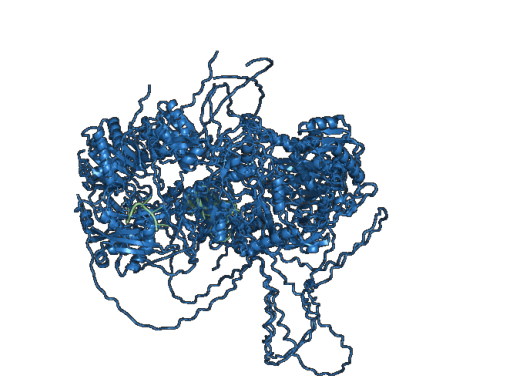

It took 80 seconds.


In [ ]:
#@title Superpose
from google.colab import files
import cv2

start=time.time()
cmd.delete("all")

try:
  cmd.load("3pf5.pdb", "ref")
except:
  cmd.fetch("3pf5", "ref", type="pdb")

cmd.remove("ref and chain B")
cmd.hide("everything")
cmd.bg_color("white")

cmd.set("cartoon_color", "palegreen", "ref")
cmd.set("surface_color", "palegreen", "ref")

cmd.orient("ref")
cmd.show("cartoon", "ref")

print("Aligning")
for id in ids[:10]:
  fn = id2fn(id)
  cmd.load(fn,id)
  cmd.set("cartoon_color", "skyblue", id)
  cmd.cealign("ref",id)

cmd.zoom()
cmd.show("cartoon")
#cmd.png("ybx1.png")
#from google.colab import files
#files.download("ybx1.png")

print("Generating image")
save_png("ybx1.png")
show_png("ybx1.png")
print("It took %d seconds."%(time.time()-start))


In [ ]:
#@title Download all Scop files with wget
import os
fns = ['scop-cla-latest.txt', 'scop-des-latest.txt', 'scop-represented-structures-latest.txt', 'scop_fa_represeq_lib_latest.fa']
for fn in fns:
  if not os.path.exists(fn):
    !wget https://scop.mrc-lmb.cam.ac.uk/files/{fn}


#AB02.3 Programming primer: The benefits of dynamic programming
Here we have three implementations for the fibonacci numbers, which differ a lot in their runtime behavior.
fib1 is very elegant and uses recursion. fib2 uses dynamic programming instead and is faster.

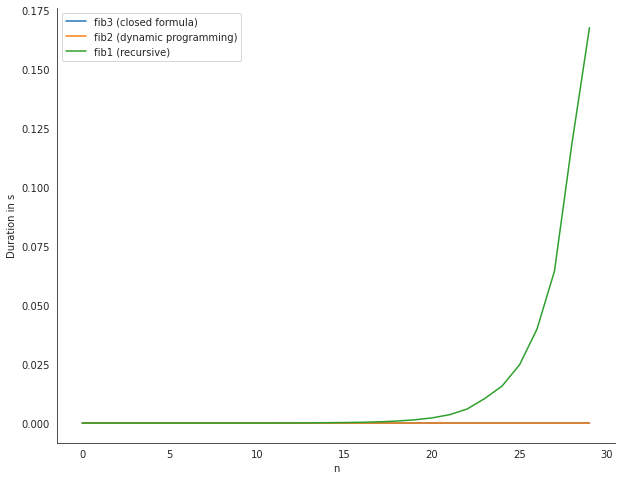

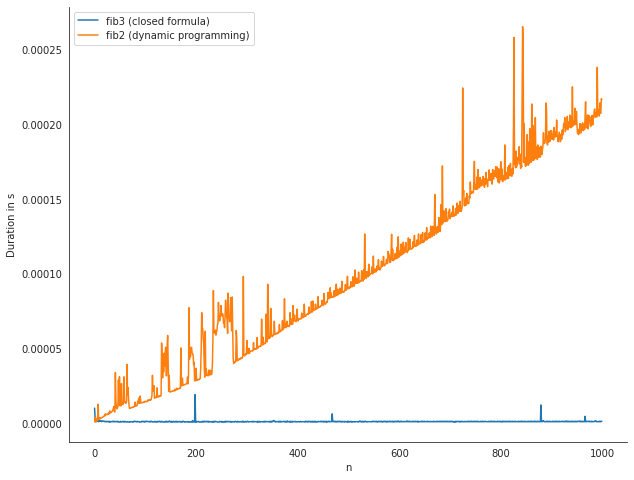

In [ ]:
# AB02.3

import time
import seaborn as sns
import matplotlib.pyplot as plt
import math

# Compute the fibonacci numbers recursively. Very elegant, but slow
def fib1(n):
  if n<2: return n
  return fib1(n-1) + fib1(n-2)


# Compute the fibonacci numbers with dynamic programming (d)
def fib2(n):
  fib={}
  fib[0]=0
  fib[1]=1
  if n<2: return fib[n]
  for i in range(2,n+1):
    fib[i] = fib[i-1]+fib[i-2]
  return fib[n]

# Compute the fibonacci number with a closed formula
def fib3(n):
  return int(1/math.sqrt(5) * ( ((1+math.sqrt(5))/2)**n - ((1-math.sqrt(5))/2)**n ))

def test(m,ns):
  took = []
  for n in ns:
    start = time.time()
    if m==1: f=fib1(n)
    if m==2: f=fib2(n)
    if m==3: f=fib3(n)
    took.append(time.time()-start)
  return took

name={1:"fib1 (recursive)", 2:"fib2 (dynamic programming)", 3:"fib3 (closed formula)"}
sns.set_style("white")
ns=range(30)
for m in [3,2,1]:
    plt.plot(ns, test(m,ns), label=name[m])
sns.despine()
plt.ylabel('Duration in s')
plt.xlabel('n')
plt.legend()
plt.show()

# Dynamic programming vs. closed formula
# The latter is faster, but due to accuracy, it has problems for large n. But up to n=1000 it is fine
# The dynamic programming solution fib2 does not have this problem of number accuracy
ns=range(0,1000,1)
for m in [3,2]:
    plt.plot(ns, test(m,ns), label=name[m])
sns.despine()
plt.ylabel('Duration in s')
plt.xlabel('n')
plt.legend()
plt.show()


#AB02.4 Prgramming Primer: Downloading data

Colab is nice, but it needs data to be fun. You access Google drive or upload files (just google how to do this). Or you simply retrieve data from remote websites. Below we get data from Pfam and PDB. The Pfam data we cache. I.e. if you run the script a second time, it will no longer retrieve the file remotely, but load a local copy.

In [ ]:
#AB02.4

# Downloading data


import requests # to retrieve data from a url
import os.path  # to check if a file exists

pfam_id = "PF00693" # Herpes thymidine kinase
pdb_id = "1OSN" # The structure of a herpes thymidine kinase

def urlPdbSeq(id):
  return "https://www.rcsb.org/fasta/entry/"+id+"/download"

def getPDBSeq(id):
  print("\n\nDownloading sequence for %s from PDB"%(id))
  r = requests.get( urlPdbSeq(id) )
  data = str(r.content, encoding = 'utf-8')
  return data

seq = getPDBSeq(pdb_id)
print("\n\nPDB %s has sequence:\n%s\n\n"%(pdb_id, seq))





def url(id): # id e.g. "PF00693"
  """returns the url to retrieve an alignment for Pfam family."""
  return "https://pfam.xfam.org/family/"+id+"/alignment/uniprot/format?format=pfam&alnType=uniprot&order=t&case=l&gaps=dashes&download=0"

def getPfam(id):
  """downloads or loads Pfam alignment given by id. If the alignment exists locally
  as a file, then just load it. Otherwise get it from the internet and store it in a file
  to avoid retrieval at next run."""
  fn = id+".txt"
  if os.path.exists(fn):
    print("\n\nLoading Pfam alignment %s"%(id))
    f = open(fn)
    data = f.read()
  else:
    print("\n\nDownloading Pfam alignment %s"%(id))
    r = requests.get( url(id) )
    data = str(r.content, encoding = 'utf-8')
    f = open(fn, "w")
    f.write(data)
    f.close()
  rows=[]
  for line in data.split("\n"):
    if line!="":
      seq = line.split()[1]
      rows.append(seq)
  return rows

pfam = getPfam(pfam_id)
print("\n\nPfam %s (%d lines):"%(pfam_id, len(pfam)))
for line in pfam[:7]:
  print(line[:40]+"...")
print("...")





PDB 1OSN has sequence:
>1OSN_1|Chains A,B,C,D|Thymidine kinase|Human herpesvirus 3 (10335)
MSTDKTDVKMGVLRIYLDGAYGIGKTTAAEEFLHHFAITPNRILLIGEPLSYWRNLAGEDAICGIYGTQTRRLNGDVSPEDAQRLTAHFQSLFCSPHAIMHAKISALMDTSTSDLVQVNKEPYKIMLSDRHPIASTICFPLSRYLVGDMSPAALPGLLFTLPAEPPGTNLVVCTVSLPSHLSRVSKRARPGETVNLPFVMVLRNVYIMLINTIIFLKTNNWHAGWNTLSFCNDVFKQKLQKSECIKLREVPGIEDTLFAVLKLPELCGEFGNILPLWAWGMETLSNCLRSMSPFVLSLEQTPQHAAQELKTLLPQMTPANMSSGAWNILKELVNAVQDNTS





Loading Pfam alignment PF00693


Pfam PF00693 (808 lines):
GPHGVGKTTTSAQLMEALGPR-DNI-VYVPEPMTYWQVLG...
----------------------------------------...
GAYGIGKTTAAEEFLHHFAITpNRI-LLIGEPLSYWRNLA...
GAYGIGKTTAAEEFLHHFAITsNRI-LLIGEPLSYWRNLA...
GAYGIGKTTATEEFLHHFAITpNRI-LLIGEPLSYWRNLA...
GAYGIGKTTAAEEFLHHFAITpNRI-LLIGEPLSYWRNLA...
GAYGIGKTTAAEEFLHHFAITpNRI-LLIGEPLSYWRNLA...
...


#AB02.5 Programming Primer: Matplotlib

Matplotlib is a great module for quick generation of nice figures.
A histogram in just one line! There are many parameters that can be set to get it into the shape you want. Very useful for your final year thesis. Also check out seaborn, which build on matplotlib and adds many nice visualisations.

A histogram in one line of code with Matplotlib!


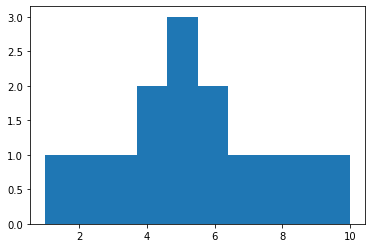


Let's add some labels.


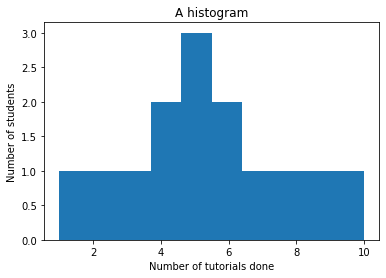

Two data sets in a histogram


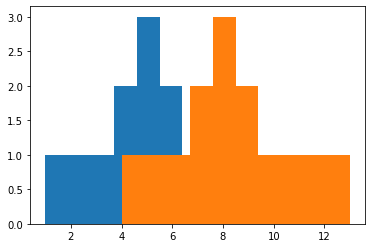

And a plot in Matplotlib


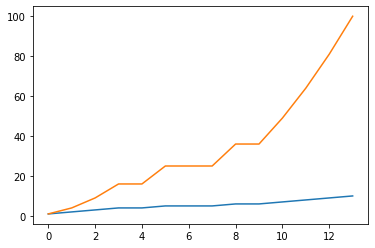

Seaborn is a module which makes Matplotlib a little more beautiful.


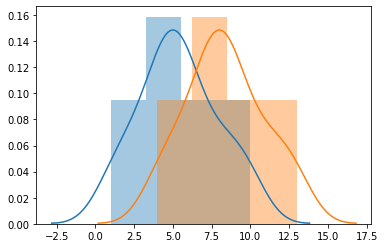

In [ ]:
import matplotlib.pyplot as plt
l= [1,2,3,4,4,5,5,5,6,6,7,8,9,10]
print("A histogram in one line of code with Matplotlib!")
plt.hist(l)
plt.show()

print("\nLet's add some labels.")
plt.hist(l)
plt.title("A histogram")
plt.xlabel("Number of tutorials done")
plt.ylabel("Number of students")
plt.show()


print("Two data sets in a histogram")
l2 = [e+3 for e in l]
plt.hist(l)
plt.hist(l2)
plt.show()

print("And a plot in Matplotlib")
x = range(len(l))
plt.plot(x, l)
plt.plot(x, [e*e for e in l])
plt.show()



import seaborn as sns
print("Seaborn is a module which makes Matplotlib a little more beautiful.")
sns.distplot(l)
sns.distplot(l2)
plt.show()


#AB03.1 Levenshtein distance

The script below computes the Levenshtein distance using a recursive formula.

In [ ]:
#AB03.1

#@title Input strings for Levensthein distance{ display-mode: "both" }
a = "Lisboa" #@param {type:"string"}
b = "Berlin" #@param {type:"string"}

def lev(a,b):
  if len(a) == 0 or len(b) == 0:
    return len(a)+len(b)
  return min(lev(a[:-1], b)      + 1,
             lev(a,      b[:-1]) + 1,
             lev(a[:-1], b[:-1]) + (a[-1]!=b[-1])
            )

print("Levenshtein distance between %s and %s is %d."%(a,b,lev(a,b)))

Levenshtein distance between Lisboa and Berlin is 6.


#AB03.2 Levenshtein distance and the count of necessary plus operations

We are extending the script to count the number of plus operations needed.

In [ ]:
# AB03.2

#@title Input strings for Levensthein distance { display-mode: "both" }
a = "Peter weoi" #@param {type:"string"}
b = "Petra er" #@param {type:"string"}

def lev(a,b):
  if len(a) == 0 or len(b) == 0:
    return (len(a)+len(b), 1)
  (lev1, ops1) = lev(a[:-1], b)
  (lev2, ops2) = lev(a,      b[:-1])
  (lev3, ops3) = lev(a[:-1], b[:-1])
  return (min(lev1+1,lev2+1,lev3+(a[-1]!=b[-1])), ops1+ops2+ops3)

import time
(lev4,ops4) = lev(a,b)
print("Levenshtein distance between %s and %s is %d.\nTook %d plus operations."%(a,b,lev4,ops4))

Levenshtein distance between Peter weoi and Petra er is 5.
Took 1256465 plus operations.


#AB03.3 Levenshtein distance in one line and fast

Enjoy the shortest implementation of Levenshtein. And it is fast, too.
Thanks to a cool Python feature, we can use dynamic programming without implementing it ourselves. Instead, we use a cache for functions. We can ask Python to store function results with the lru_cache keyword.

In a nutshell: Ultra short code, ultra fast.

In [ ]:
# AB03.3
#@title Input strings for Levensthein distance { display-mode: "both" }
a = "Peter M\xFCller" #@param {type:"string"}
b = "Petra Meyer" #@param {type:"string"}

from functools import lru_cache

@lru_cache(maxsize=None)
def l(a,b): return len(b) if not a else len(a) if not b else min(l(a[:-1], b)+1, l(a, b[:-1])+1, l(a[:-1], b[:-1])+(a[-1] != b[-1]))

print("Levenshtein distance with cache between %s and %s is %d."%(a,b,l(a,b)))


Levenshtein distance with cache between Peter Müller and Petra Meyer is 5.


#AB03.4 Levenshtein distance with dynamic programming

Now we use dynamic programming to store intermediate results and avoid recomputation.

Levenshtein distance between Lisbon and Berlin is 5


Matrix d



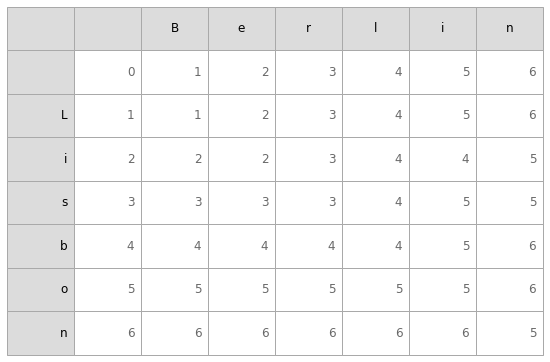

In [ ]:
#AB03.4
#@title Input strings for Levensthein distance { display-mode: "code" }
a = "Lisbon" #@param {type:"string"}
b = "Berlin" #@param {type:"string"}

d={} # The dynamic programming matrix (as a dictionary).
db = None
m = len(a)
n = len(b)

def lev(a,b):
  # Initialise top left cell to zero
  d[0,0] = 0

  # Initialise the first column
  for i in range(1,m+1):
    d[i,0] = i

  # Initialise the first row
  for j in range(1,n+1):
    d[0,j] = j

  # Fill all cells of the matrix
  for i in range(1,m+1):
    for j in range(1,n+1):
      # if letters are the same, no edit operation is used,
      # otherwise it is one (replace operation)
      if a[i-1] == b[j-1]:
        s = 0
      else:
        s = 1
      # Get the minimum of the scores N, W, and NW.
      d[i,j] = min(d[i-1,j  ]+1,
                   d[i  ,j-1]+1,
                   d[i-1,j-1]+s)
  return d[m,n]

print("Levenshtein distance between %s and %s is %d"%(a,b,lev(a,b)))

try:
  print_d()
except:
  print("\nError: You have to run the print_d script at the top of the notebook to print the matrix nicely.")

#AB03.5 Levenshtein distance with dynamic programming and counting plus operations

Now we do the same as for the recursive piece of code. We count the number of plus operations needed.
You will be surprised (or not ;-).

In [ ]:
#AB03.5

#@title Input strings for Levensthein distance { display-mode: "both" }
a = "Peter sass im Garten und ass einen Apfel, da kam Maria durch das Gartentor und sang froehlich ein Lied." #@param {type:"string"}
b = "Peter sass im Auto und ass einen Marsriegel, da kam Maria auf dem Rad daher und sang froehlich ein Lied." #@param {type:"string"}

d={} # The dynamic programming matrix (as a dictionary).

def lev(a,b):
  # Initialise number of plus operations needed
  ops = 0

  # Initialise top left cell to zero
  d[0,0] = 0

  # Initialise the first column
  m = len(a)
  for i in range(1,m+1):
    d[i,0] = i
    ops += 1

  # Initialise the first row
  n = len(b)
  for j in range(1,n+1):
    d[0,j] = j
    ops += 1

  # Fill all cells of the matrix
  for i in range(1,m+1):
    for j in range(1,n+1):
      # if letters are the same, no edit operation is used,
      # otherwise it is one (replace operation)
      if a[i-1] == b[j-1]:
        s = 0
      else:
        s = 1
      # Get the minimum of the scores N, W, and NW.
      d[i,j] = min(d[i-1,j  ]+1,
                   d[i  ,j-1]+1,
                   d[i-1,j-1]+s)
      ops += 3 # In the three lines above we used three plus ops
  return (d[m,n], ops)

(lev1,ops1) = lev(a,b)

print("Levenshtein distance between %s and %s is %d.\nTook %d plus operations."%(a,b,lev1,ops1))

Levenshtein distance between Peter sass im Garten und ass einen Apfel, da kam Maria durch das Gartentor und sang froehlich ein Lied. and Peter sass im Auto und ass einen Marsriegel, da kam Maria auf dem Rad daher und sang froehlich ein Lied. is 26.
Took 32343 plus operations.


#AB04.1 Levenshtein distance and alignment with dynamic programming

We know how to compute the Levenshtein distance fast (or better, it has complexity O(n * m) for two input strings of lengths n and m, respectively.)
Now we want to get an alignment. We have to extend the code to record the direction, where the minimal value was found. To do this, we introduce
a second matrix db (it is called db to reflect that it is related to the dynamic programming matrix d and that we will use it for backtracking.). Since, the minimal
value can be found in more than oen direction, the entries of db have to be sets of directions, rather than single directions. The empty set is set([]), which
is a bit cumbersome to write. Unfortunately, python could not use {}, as this is already in place for an empty dictionary. We can add elements to a set using
the command "add" and we can check whether an element is in a set with the command "in". The function print_lev prints the alignment. Please note, that it uses
the variable db, which is a global variable visible throughout the whole programme.

Dynamic programming to compute the Levenshtein distance of two strings.

arrive and river have the Levenshtein distance 3.
One alignment is:
a -
r -
r r
i i
v v
e e
- r


Matrix d for alignment
  arrive-
  -r-iver




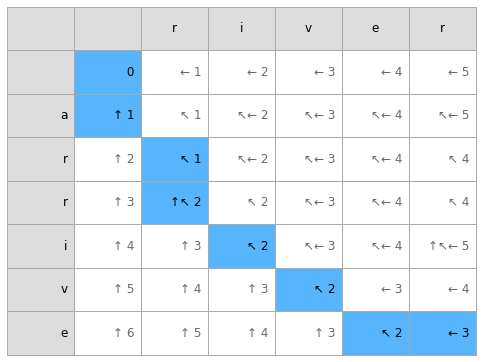



Matrix d for alignment
  arrive-
  --river




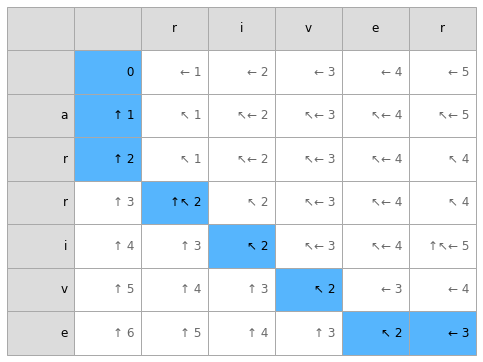

In [ ]:
# AB04.1

#@title Input strings for Levensthein distance { display-mode: "both" }
a = "arrive" #@param {type:"string"}
b = "river" #@param {type:"string"}
m = len(a)
n = len(b)
d={}  # we store the dynamic programming matrix in a dictionary
db={} # and the backtracking matrix, too.

def min_dir(dN,dW,dNW):
  """Returns the minimum of dN, dW, dNW and a set with the directions N, W, NW, which held the minimal value.
  E.g. min_dir(2,2,3) return {"N","W"} and min_dir(3,2,1) {"NW"}.
  """
  direction = set([]) # empty set
  if dN == min(dN,dW,dNW):
    direction.add("N")
  if dW == min(dN,dW,dNW):
    direction.add("W")
  if dNW == min(dN,dW,dNW):
    direction.add("NW")
  return (min(dN,dW,dNW), direction)

def lev(a,b):
  """Computes the Levenshtein distance (and backtracking matrix) between strings a and b."""
  d[0,0] = 0
  db[0,0] = set([]) # empty set

  # Initialise the first column
  for i in range(1,m+1):
    d[i,0] = i
    db[i,0] = {"N"}

  # Initialise the first row
  for j in range(1,n+1):
    d[0,j] = j
    db[0,j] = {"W"}

  # Fill all cells of the matrix
  for i in range(1,m+1):
    for j in range(1,n+1):
      # if letters are the same, no edit operation is used, otherwise it is one (replace operation)
      if a[i-1] == b[j-1]:
        s = 0
      else:
        s = 1
      # Get the minimum of the scores N, W, and NW and remember the direction.
      (d[i,j], db[i,j]) = min_dir(d[i-1,j  ]+1,
                                  d[i  ,j-1]+1,
                                  d[i-1,j-1]+s)
  return d[m,n]


def print_lev(a,b,i,j):
  if "NW" in db[i,j]:
    print_lev(a,b,i-1,j-1)
    print(a[i-1], b[j-1])    # print a match or replace
  elif "W" in db[i,j]:
    print_lev(a,b,i  ,j-1)
    print("-",    b[j-1])    # print an insert/delete
  elif "N" in db[i,j]:
    print_lev(a,b,i-1,j)
    print(a[i-1], "-")       # print an insert/delete


print("Dynamic programming to compute the Levenshtein distance of two strings.\n")

print("%s and %s have the Levenshtein distance %d."%(a,b,lev(a,b)))
print("One alignment is:")
print_lev(a,b,len(a),len(b))

try:
  print_d(path="all")
except:
  print("\nError: You have to run the print_d script at the top of the notebook to print the matrix nicely.")


#AB04.2 Levenshtein distance and all alignments with dynamic programming

To print all alignments, we only have to change the print_lev function. The rest of the code stays the same.
In print_lev, instead of printing match, replace, insertion/deletion directly,
we add this output to two strings (line1 and line2), which we pass recursively. And most important, instead of pursuing directions
exclusively as done above (if, elif, elif), we go for all possibilities (if, if, if).

Dynamic programming to compute the Levenshtein distance of two strings.

Pete and Petra have the Levenshtein distance 2.
All alignments:

Pete-
Petra

Pet-e
Petra


Matrix d for alignment
  Pete-
  Petra




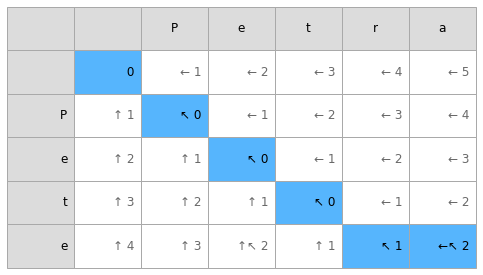



Matrix d for alignment
  Pet-e
  Petra




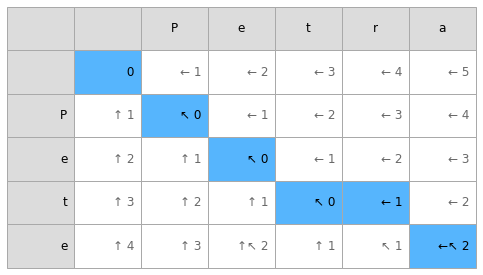

In [ ]:
# AB04.2

#@title Input strings for Levensthein distance { display-mode: "both" }
a = "Pete" #@param {type:"string"}
b = "Petra" #@param {type:"string"}
m = len(a)
n = len(b)
d={}  # we store the dynamic programming matrix in a dictionary
db={} # and the backtracking matrix, too.


def min_dir(dN,dW,dNW):
  """Returns the minimum of dN, dW, dNW and a set with the directions N, W, NW, which held the minimal value.
  min_dir(2,2,3) return {"N","W"} and min_dir(3,2,1) {"NW"}.
  """
  direction = set([]) # empty set
  if dN == min(dN,dW,dNW):
    direction.add("N")
  if dW == min(dN,dW,dNW):
    direction.add("W")
  if dNW == min(dN,dW,dNW):
    direction.add("NW")
  return (min(dN,dW,dNW), direction)



def lev(a,b):
  """Computes the Levenshtein distance (and backtracking matrix) between strings a and b."""
  d[0,0] = 0
  db[0,0] = set([]) # empty set

  # Initialise the first column
  for i in range(1,m+1):
    d[i,0] = i
    db[i,0] = {"N"}

  # Initialise the first row
  for j in range(1,n+1):
    d[0,j] = j
    db[0,j] = {"W"}

  # Fill all cells of the matrix
  for i in range(1,m+1):
    for j in range(1,n+1):
      # if letters are the same, no edit operation is used, otherwise it is one (replace operation)
      if a[i-1] == b[j-1]:
        s = 0
      else:
        s = 1
      # Get the minimum of the scores N, W, and NW and remember the direction.
      (d[i,j], db[i,j]) = min_dir(d[i-1,j  ]+1,
                                  d[i  ,j-1]+1,
                                  d[i-1,j-1]+s)
  return d[m,n]



def print_lev(a,b, i,j, line1, line2):
  if "N" in db[i,j]:
    print_lev(a,b,i-1,j,   a[i-1]+line1,    "-"+line2)
  if "W" in db[i,j]:
    print_lev(a,b,i  ,j-1,    "-"+line1, b[j-1]+line2)
  if "NW" in db[i,j]:
    print_lev(a,b,i-1,j-1, a[i-1]+line1, b[j-1]+line2)
  if db[i,j]==set([]): # empty set. we have reached the top left corner of db
    print()
    print(line1)       # and have collected the full alignment
    print(line2)

print("Dynamic programming to compute the Levenshtein distance of two strings.\n")

print("%s and %s have the Levenshtein distance %d."%(a,b,lev(a,b)))
print("All alignments:")
print_lev(a,b,len(a),len(b), "", "")

try:
  print_d(path="all")
except:
  print("\nError: You have to run the print_d script at the top of the notebook to print the matrix nicely.")



#AB05 Needleman-Wunsch algorithm

This algorithm implements global sequence comparison with a scoring scheme for matches, mismatches, and gaps.
It also prints out all alignments. Adapt the scoring scheme to output your favorite alignment.

In [ ]:
#AB05

#@title Input strings and scoring scheme { display-mode: "both" }
a = "Peter" #@param {type:"string"}
b = "Petra" #@param {type:"string"}
sm = 1 #@param {type:"integer"}
sr = 0 #@param {type:"integer"}
sg =  0#@param {type:"integer"}

m = len(a)
n = len(b)
d={}  # we store the dynamic programming matrix in a dictionary
db={} # and the backtracking matrix, too.


def max_dir(dN,dW,dNW):
  """Returns the maximum of dN, dW, dNW and a set with the directions N, W, NW, which held the maximum value.
  max_dir(4,4,3) return {"N","W"} and miax_dir(3,2,4) {"NW"}.
  """
  direction = set([]) # empty set
  if dN == max(dN,dW,dNW):
    direction.add("N")
  if dW == max(dN,dW,dNW):
    direction.add("W")
  if dNW == max(dN,dW,dNW):
    direction.add("NW")
  return (max(dN,dW,dNW), direction)

def needle(a,b):
  """Computes the Levenshtein distance (and backtracking matrix) between strings a and b."""

  d[0,0] = 0
  db[0,0] = set([]) # empty set

  # Initialise the first column
  for i in range(1,m+1):
    d[i,0] = i*sg
    db[i,0] = {"N"}

  # Initialise the first row
  for j in range(1,n+1):
    d[0,j] = j*sg
    db[0,j] = {"W"}

  # Fill all cells of the matrix
  for i in range(1,m+1):
    for j in range(1,n+1):
      # if letters are the same, no edit operation is used, otherwise it is one (replace operation)
      if a[i-1] == b[j-1]:
        s = sm
      else:
        s = sr
      # Get the maximum of the scores N, W, and NW and remember the direction.
      (d[i,j], db[i,j]) = max_dir(d[i-1,j  ]+sg,
                                  d[i  ,j-1]+sg,
                                  d[i-1,j-1]+s)

  return d[m,n]

def align(a,b, i,j, line1, line2):
  """prints all aligments for strings a and b.
  Requires that needle was run
  (for the db matrix with the direction information)."""
  if "N" in db[i,j]:
    align(a,b,i-1,j,   a[i-1]+line1,    "-"+line2)
  if "W" in db[i,j]:
    align(a,b,i  ,j-1,    "-"+line1, b[j-1]+line2)
  if "NW" in db[i,j]:
    align(a,b,i-1,j-1, a[i-1]+line1, b[j-1]+line2)
  if db[i,j]==set([]): # empty set. we have reached the top left corner of db
    print()
    print(line1)       # and have collected the full alignment
    print(line2)

def align1(a,b, i,j, line1, line2):
  """prints one aligment for strings a and b.
  Requires that needle was run
  (for the db matrix with the direction information)."""
  if "N" in db[i,j]:
    align1(a,b,i-1,j,   a[i-1]+line1,    "-"+line2)
  elif "W" in db[i,j]:
    align1(a,b,i  ,j-1,    "-"+line1, b[j-1]+line2)
  elif "NW" in db[i,j]:
    align1(a,b,i-1,j-1, a[i-1]+line1, b[j-1]+line2)
  elif db[i,j]==set([]): # empty set. we have reached the top left corner of db
    print()
    print(line1)       # and have collected the full alignment
    print(line2)


print("Dynamic programming matrices for Needleman-Wunsch algorithm.\n")

print("Score=%d"%(needle(a,b)))

print("\n\nAll alignments (match score=%d, mismatch score=%d, gap score=%d):"%(sm,sr,sg))
align(a,b,len(a),len(b), "", "")

try:
  print_d(path="all")
except:
  print("\nError: You have to run the print_d script at the top of the notebook to print the matrix nicely.")


Dynamic programming matrices for Needleman-Wunsch algorithm.

Score=4


All alignments (match score=1, mismatch score=0, gap score=0):

Peter-
Pet-ra

Error: You have to run the print_d script at the top of the notebook to print the matrix nicely.


#AB06.1 Generating a substitution matrix

Substitution matrices capture who likely or unlikely a replacement of characters in the string is. The are built on the principle of a log odds ratio, i.e. a ratio that related the absolute amount of substitions in the data to the individual frequencies of the two amino acids. You can easily create your own substition matrix. Use e.g. PFAM to download sequence alignments and then feed them into the log odds calculation. Below, I have copied some random sequences from a PFAM alignment. When you do this yourself, make sure you export gaps as - (an option in PFAM) or adjust the code if you don't. We just cuoff the sequence IDs at the beginning and then go column by column through the data and check all pairwise substitions. We use seaborn to print a heatmap of Blosum and of our own matrix.

BLOSUM45 BLOSUM50 BLOSUM62 BLOSUM80 BLOSUM90 PAM250 PAM30 PAM70 


Substitution matrix MyLogOddsSubsMatrix


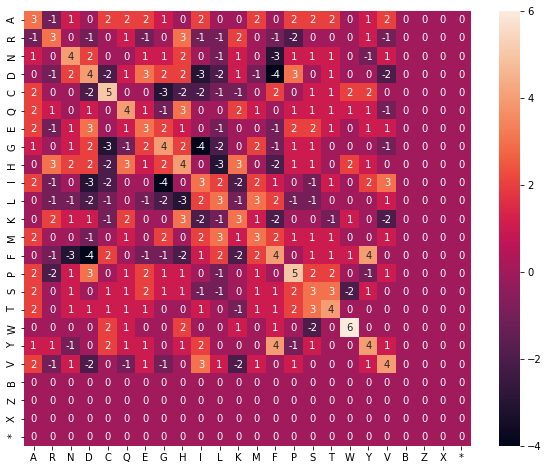



Substitution matrix SubMatrixComputedFromPfam


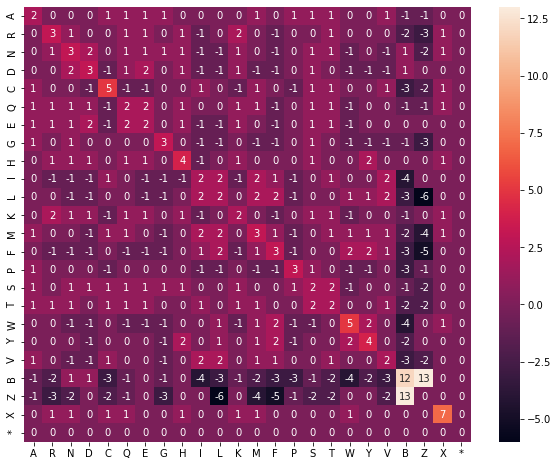



Substitution matrix BLOSUM45


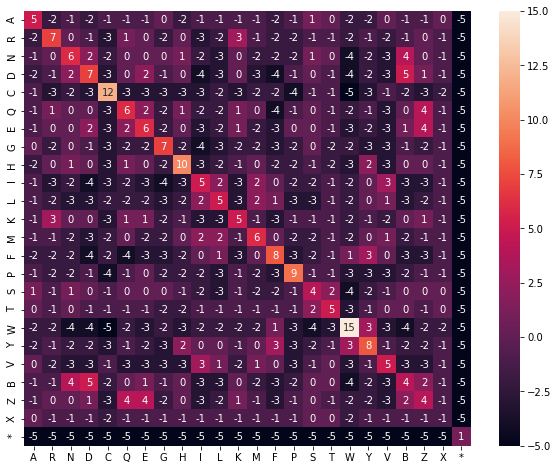



Substitution matrix BLOSUM50


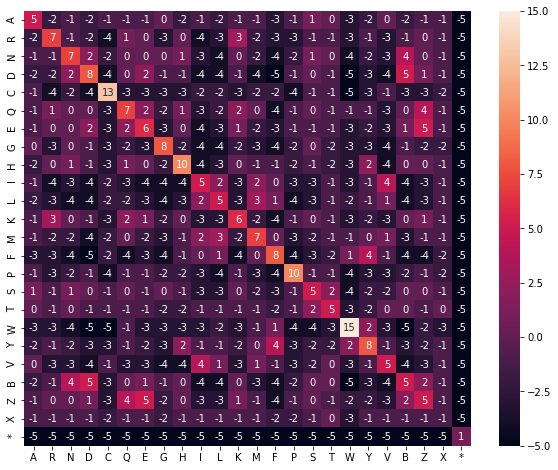



Substitution matrix BLOSUM62


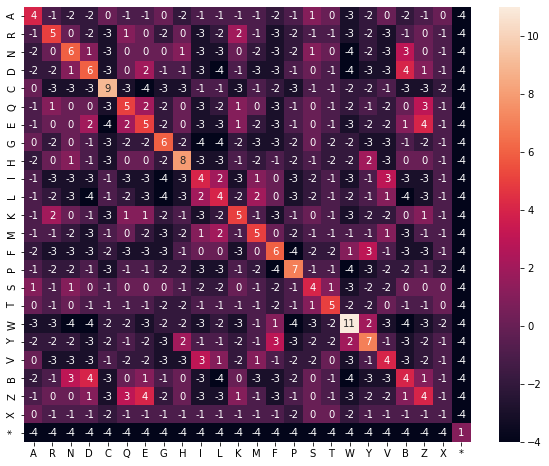



Substitution matrix BLOSUM80


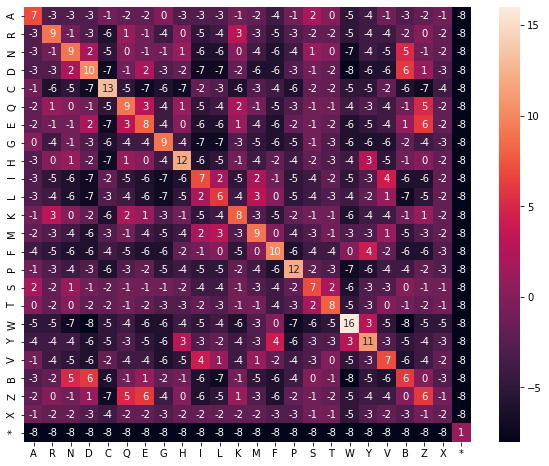



Substitution matrix BLOSUM90


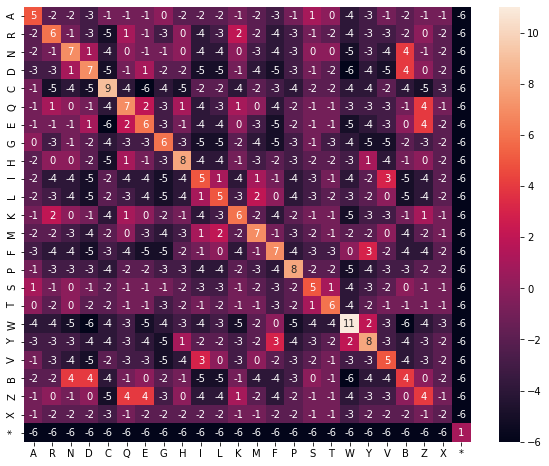



Substitution matrix PAM250


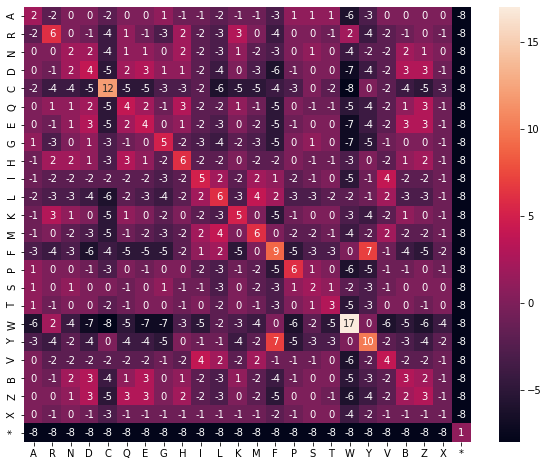



Substitution matrix PAM30


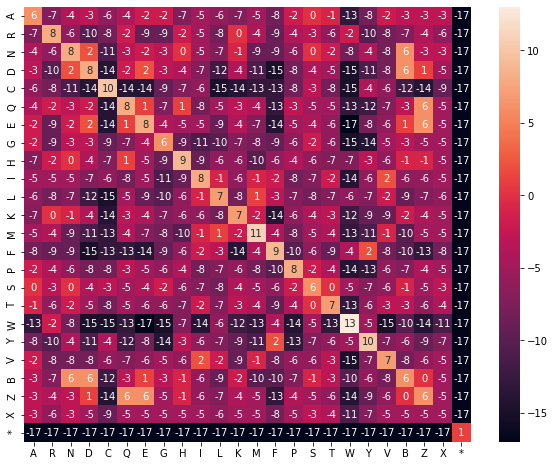



Substitution matrix PAM70


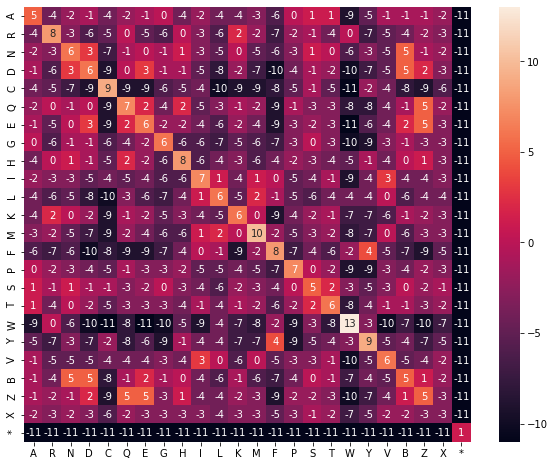

In [ ]:
#AB06.1

from collections import defaultdict
import math
import seaborn as sns
import matplotlib.pyplot as plt
import requests

##########################################
#
# DATA
#
# I got some sample alignments from PFAM.
# To do this properly you need more data
# and it should cover various protein families etc.
#
# http://pfam.xfam.org/family/PF10416/alignment/seed/format?format=pfam&alnType=seed&order=t&case=u&gaps=dashes&download=0
#
#
##########################################


pfam = [
"A2FX79_TRIVA/20-146       YYD-KQ-QFLQLRATLCQMSSKIKR-------------NKKISKFAEALEIIKRWAIRGDYEDHKRCLACGVLWFDQE---IAINTQQLKFLLFKCKSS-----INSTLHDSGLQPAPREAL--QKLLMERYP----YLKN--NMGEIR-KWTLRTYQP",
"A2EL50_TRIVA/14-141       ESD-QR-MYRKIQEVLSQLSTKNKR-------------NTKIDDFRELVDAIDIFENYDKESKWRRCLACGLVKFDGG---IAVNTSQLSILALRCKTS-----INTSLKGMGYTIISGNSSE-SEEFLKEIP----YISG--NPSEMR-QWTVRYLEE",
"A2DCS1_TRIVA/23-150       EAD-KQ-TYDRICAALTAPSNKNKK-------------NKRADEFREILEAISLFENHDEVDKWKRCLVCGVYQFEGG---IAVNISALKRLVFKCKSS-----INGSLKAIGYPNVTYKSST-CEELLKGIP----ILRG--NTAELR-QWTVRYQAP",
"A2F449_TRIVA/18-145       DTD-KM-TYDRIRQAITAPSNKNKK-------------NKRADEFREILEAIELYENHDQADKWKRCLVCGVFIFDKG---IAIKISALKQLIYKCKSS-----INGSLKAIGYPNVDYKSSM-CDELLNGIP----FLRG--NLVELR-QWTVRFRDR",
"A2EU97_TRIVA/13-140       ETD-KE-KYNELHQEFSSGVMKRAR-------------NGRAESFEEMLENIKKYCIRNDEDDWKRYLVCGVCWMDEA---IAINTRQLRLLVCKCKSS-----INGSLQKMGFSTNMAHSES-WKILFPKIP----LLKD--HFSELR-KWTIRYKPK",
"A2DGT4_TRIVA/24-151       PRD-KE-EYLSLKSLLDESSTKRNR-------------GHRMEAFDGILEAIHRYAERHDDDDWRRFLVCGVCWMDNM---IAINTRQLRLLISKCKSS-----INGSFQKMGYTTSQSHTES-RKFLFGKIP----LLKG--NFNELR-QWTIRSRAP",
"A2FBZ9_TRIVA/24-151       ETD-KN-SYKTLKLALDASISKRNR-------------GHRMEAFDSVLNAIHRFAERHDENDWRRFLVCGLCWMDNM---IAINTRQLRLLISKCKSS-----INGSLHKLGYTTNQSHTES-WKYLFDRIP----YLKD--NFPELR-QWTLRSRAS",
"A2DX95_TRIVA/16-143       DAD-KY-QYNCLRYSIATTASKNQR-------------NKRISTFNEAMDAIKMFAIRGDANDKLRSLVCGICWLNEG---IAINTHQLKTLLGKCKSS-----INGSLQKIGFSSNISRAET-TNAMTRFFP----FLNE--NSSELR-KWSVRNYPQ",
"A2E640_TRIVA/20-147       PID-MQ-RYNYLRLALSSSETKNQR-------------NRRIATFTEAMEAVRGFAIRGDSNDKLRCLVCGIAWLPEG---IAINTHQLKLLISRCKSS-----INGSLQKLGFTENLGRTAA-ANAMIAQYS----FLKE--NSTELR-KWSVRRKPS",
"A2DX21_TRIVA/22-149       KAD-LH-QYNCLRLALTSSESKNQR-------------NRRIATFTEAIEAVRVFAVRGDQYDRIRCLVCGIAWLPEG---LAINTHQLKLLISRCKSS-----INGSFQKLGFTEKLRRLAA-ANALISVYP----FLNE--NTSELR-KWSVRKRPA",
"A2EQ67_TRIVA/19-146       DMD-KY-HYNCLRMSISSQYSKNIR-------------NKRVENFTEIIDIIKRYCIRGQPDDWRRCLVCGVAWLHEG---IAINTRQLRLLIFKCKSS-----INGSLHKMGFTVNIGRTEA-ANALVMAIP----ILKD--NTNELR-QWTVRQTGN",
"A2FFZ1_TRIVA/19-146       DFD-KY-QYNCLRANLSANYSKNQR-------------NKRIENFTEILEIIRRFCVRGDGDDWRRFLVCGYCCFPDG---IAINTRQLKLLIFKCKSS-----INGSLHKMGLSSNIAKNEA-TNSLIMAIP----ILRD--NINEMR-QWTVRKFIK",
"A2DT03_TRIVA/19-146       DFD-KF-QYGILRVSLSTHYAKNQR-------------NKRVGNFTEILELIKRFCIRGDADDWRRCLVCGVCWLPNG---IAVNTRQLKLLIFKCKSS-----INGSLHKMGYSVNFGRAEP-TNSLVMAIP----ILKD--NINELR-QWTIRQCVG"
]


##########################################
#
# Data structures where we store our data
#
##########################################


sub = defaultdict(int)
freq = defaultdict(int)
aminoacids = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V', 'B', 'Z', 'X', '*']
subMatrixNames = ["BLOSUM45","BLOSUM50","BLOSUM62","BLOSUM80","BLOSUM90","PAM250","PAM30","PAM70"]
subMatrices = {}

# The script "Substitution matrices 2" computes a matrix from alignments in Pfam.
# Here is the result for 1000 alignments each with up to 500 sequences.
# (Overall, there are 15190 aligments and the largest has 2400 sequences.
# The calculation took 1h 10min and analysed 9 billion substitutions and 100 mio. amino acids.
pfamSubMatrix = [
[2, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, -1, -1, 0, 0],
[0, 3, 1, 0, 0, 1, 1, 0, 1, -1, 0, 2, 0, -1, 0, 0, 1, 0, 0, 0, -2, -3, 1, 0],
[0, 1, 3, 2, 0, 1, 1, 1, 1, -1, -1, 1, 0, -1, 0, 1, 1, -1, 0, -1, 1, -2, 1, 0],
[0, 0, 2, 3, -1, 1, 2, 0, 1, -1, -1, 1, -1, -1, 0, 1, 0, -1, -1, -1, 1, 0, 0, 0],
[1, 0, 0, -1, 5, -1, -1, 0, 0, 1, 0, -1, 1, 0, -1, 1, 1, 0, 0, 1, -3, -2, 1, 0],
[1, 1, 1, 1, -1, 2, 2, 0, 1, 0, 0, 1, 1, -1, 0, 1, 1, -1, 0, 0, -1, -1, 1, 0],
[1, 1, 1, 2, -1, 2, 2, 0, 1, -1, -1, 1, 0, -1, 0, 1, 1, -1, 0, 0, 0, 0, 0, 0],
[1, 0, 1, 0, 0, 0, 0, 3, 0, -1, -1, 0, -1, -1, 0, 1, 0, -1, -1, -1, -1, -3, 0, 0],
[0, 1, 1, 1, 0, 1, 1, 0, 4, -1, 0, 1, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 1, 0],
[0, -1, -1, -1, 1, 0, -1, -1, -1, 2, 2, -1, 2, 1, -1, 0, 1, 0, 0, 2, -4, 0, 0, 0],
[0, 0, -1, -1, 0, 0, -1, -1, 0, 2, 2, 0, 2, 2, -1, 0, 0, 1, 1, 2, -3, -6, 0, 0],
[0, 2, 1, 1, -1, 1, 1, 0, 1, -1, 0, 2, 0, -1, 0, 1, 1, -1, 0, 0, -1, 0, 1, 0],
[1, 0, 0, -1, 1, 1, 0, -1, 0, 2, 2, 0, 3, 1, -1, 0, 1, 1, 1, 1, -2, -4, 1, 0],
[0, -1, -1, -1, 0, -1, -1, -1, 0, 1, 2, -1, 1, 3, -1, 0, 0, 2, 2, 1, -3, -5, 0, 0],
[1, 0, 0, 0, -1, 0, 0, 0, 0, -1, -1, 0, -1, -1, 3, 1, 0, -1, -1, 0, -3, -1, 0, 0],
[1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 2, 2, -1, 0, 0, -1, -2, 0, 0],
[1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 2, 2, 0, 0, 1, -2, -2, 0, 0],
[0, 0, -1, -1, 0, -1, -1, -1, 0, 0, 1, -1, 1, 2, -1, -1, 0, 5, 2, 0, -4, 0, 1, 0],
[0, 0, 0, -1, 0, 0, 0, -1, 2, 0, 1, 0, 1, 2, -1, 0, 0, 2, 4, 0, -2, 0, 0, 0],
[1, 0, -1, -1, 1, 0, 0, -1, 0, 2, 2, 0, 1, 1, 0, 0, 1, 0, 0, 2, -3, -2, 0, 0],
[-1, -2, 1, 1, -3, -1, 0, -1, 0, -4, -3, -1, -2, -3, -3, -1, -2, -4, -2, -3, 12, 13, 0, 0],
[-1, -3, -2, 0, -2, -1, 0, -3, 0, 0, -6, 0, -4, -5, -1, -2, -2, 0, 0, -2, 13, 0, 0, 0],
[0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 7, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
]


##########################################
#
# At biopython on github, there is a directory
# with many subsitution matrices. We download
# these. If you want more, chck it out
# and extend the list subMatrixNames to analyse
# more matrices.
#
# https://github.com/biopython/biopython/tree/master/Bio/Align/substitution_matrices/data
#
##########################################


def url(sm):
  return "https://raw.githubusercontent.com/biopython/biopython/master/Bio/Align/substitution_matrices/data/"+sm

def getMatrix(sm):
  rows=[]
  r = requests.get( url(sm) )
  data = str(r.content, encoding = 'utf-8')
  for line in data.split("\n"):
    if line!="" and line[0] in aminoacids:
      row = [int(s) for s in line[2:].split()]
      rows.append(row)
  return rows





##########################################
#
# Main code to generate our own sub matrix
#
##########################################


def getCol(pfam, i):
  """returns the ith column from the list of aligned sequences"""
  return [p[i] for p in pfam]

def ordered(ci,cj):
  if ci<cj: return (ci,cj)
  return (cj,ci)

def cnt(col):
  for c in col:
    freq[c]+=1
  for i in range(len(col)):
    for j in range(i+1,len(col)):
      if col[i]!="-" and col[j]!="-":
        sub[ordered(col[i],col[j])]+=1

def align2sub(pfam):
  pfam = [s.split()[1] for s in pfam]
  noCol = len(pfam[0])
  for i in range(noCol):
    col = getCol(pfam, i)
    cnt(col)
  totalSub = sum(sub.values())
  totalFreq = sum(freq.values())
  rows = []
  for ci in aminoacids:
    row = []
    for cj in aminoacids:
      if ordered(ci,cj) in sub:
        logoddsratio = round(math.log2(  (sub[ordered(ci,cj)] / totalSub) / ( (freq[ci] / totalFreq) * (freq[cj] / totalFreq) ) ))
      else:
        logoddsratio = 0
      row.append(logoddsratio)
    rows.append(row)
  return rows


##########################################
#
# Main programme to download the matrices
# compute our own and display all of them
# in a nice heatmap
#
###########################################

# Enlarge figure to get a more legible heatmap of the sub matrices
plt.rcParams["figure.figsize"] = (10,8)

# Compute a logodds substitution matrix from our own data
subMatrices["MyLogOddsSubsMatrix"] = align2sub(pfam)

# Similar to the above, but computed from larger data (in a separate script)
subMatrices["SubMatrixComputedFromPfam"] = pfamSubMatrix

# Download Blosum and Pam matrices from Biopython on github
print("Downloading ")
for sm in subMatrixNames:
  print(sm+" ", end="")
  subMatrices[sm] = getMatrix(sm)
print()

# Print heatmaps for all substitution matrices
for sm in subMatrices:
  print("\n\nSubstitution matrix %s"%(sm))
  ax = sns.heatmap(subMatrices[sm], annot=True, xticklabels=aminoacids, yticklabels=aminoacids)
  plt.show()


#AB06.2 Generating a substitution matrix 2

If you want to generate a substitution matrix from more data, then you can do the following. At ftp://ftp.ebi.ac.uk/pub/databases/Pfam/current_release you find the whole PFAM data. E.g. Pfam-A.seed.gz. The smallest file. Download and unzip it. It is half a Gigabyte! This script analysis this data. With maxNo and maxSize you can control how much of the data is generated.

For example, for maxNo=10000 alignments and maxSize=500 sequences per alignment my desktop takes 2h.

To run this script, either download the data to your desktop and run the code directly on your desktop or upload the data to collaboratory and execute it there. You probably have to adjust the path to the file.



In [ ]:
# AB06.2

from collections import defaultdict
import math
import seaborn as sns
import matplotlib.pyplot as plt
import time

##########################################
#
# Let's do a large scale computation on PFAM
# At ftp://ftp.ebi.ac.uk/pub/databases/Pfam/current_release
# you can download Pfam data. Download
# Pfam-A.seed.gz and unzip it. Then you
# can run this script and generate a
# substitution matrix on very large data.
#
# Use maxSize and maxNo to decide how much data
# you want to process.
##########################################


sub = defaultdict(int)
freq = defaultdict(int)
aminoacids = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V', 'B', 'Z', 'X', '*']

def readPfam():
    start=time.time()
    maxSize=500 # must be greater 10
    maxNo=10000
    Print("\n\nWill process %d sequence groups. Each maximally %d sequences."%(maxNo, maxSize))
    i=0
    hash = True
    all=[]
    for line in open("Pfam-A.seed",encoding='latin-1'):
        if not line.startswith("#"):
            if hash:
                hash=False
                seqs=[]
            l = line.split()
            if len(l)>1:
                seq = l[1]
                seqs.append(seq)
        else:
            if not hash:
                hash=True
                if len(seqs)>10:
                    all.append(len(seqs))
                if len(seqs)>10 and i<maxNo:
                    i+=1
                    align2sub(seqs[:maxSize])
                    print(".",end="", flush=True)
                    if i % int(maxNo/100)==0: print("%d%s (%ds)"%(int(100*i/maxNo), "%", time.time()-start), end="", flush=True)
    took = time.time()-start
    print("\n\nThere are %d sequence groups. The largest has %d sequences. %d groups processed. Each maximally %d sequences. Took %d sec. On avg. %.2fs"%(len(all), max(all), maxNo, maxSize, took, took/maxNo))



##########################################
#
# Main code to generate our own sub matrix
#
##########################################


def getCol(pfam, i):
  """returns the ith column from the list of aligned sequences"""
  return [p[i] for p in pfam if p[i] != "-" and p[i] != "."]

def ordered(ci,cj):
  if ci<cj: return (ci,cj)
  return (cj,ci)

def cnt(col):
  for c in col:
    freq[c]+=1
  for i in range(len(col)):
    for j in range(i+1,len(col)):
      if col[i]!="-" and col[j]!="-":
        sub[ordered(col[i],col[j])]+=1

def align2sub(pfam):
  noCol = len(pfam[0])
  for i in range(noCol):
    col = getCol(pfam, i)
    cnt(col)

def sub2heat():
  totalSub = sum(sub.values())
  totalFreq = sum(freq.values())
  print("Overall, %d substitutions and %s amino acids processed"%(totalSub, totalFreq))
  rows = []
  for ci in aminoacids:
    row = []
    for cj in aminoacids:
      if ordered(ci,cj) in sub:
        logoddsratio = round(math.log2(  (sub[ordered(ci,cj)] / totalSub) / ( (freq[ci] / totalFreq) * (freq[cj] / totalFreq) ) ))
      else:
        logoddsratio = 0
      row.append(logoddsratio)
    rows.append(row)
  return rows

readPfam()
h=sub2heat()

print("Here is a print out of the computed matrix. Cut and paste it for any fancy visualisation beyond this heatmap.")

print(aminoacids)

for row in h:
    print(row, end="")
    print(",")


ax = sns.heatmap(h, annot=True, xticklabels=aminoacids, yticklabels=aminoacids)
plt.show()


#AB07 Smith-Waterman Algorithm

Create local alignment by allowing the algorithm to chop off the left and right side of an alignment, if it increases the score overall. Chopping off to the left is achieved by taking the maximum of the three directions as well as zero. This means that the score can never drop below zero. Important: if all directions would be negative and zero is chosen, then the direction set is empty. In backtracking this is used, as the backtracking stops if it comes to a cell with empty direction. Max_pos stores the maximal value across the entire matrix. The position where the maximum is, is the right side of the alignment. So ending the alignment at the maximum corresponds to chopping of the right side. Although there may be multiple alignments with the same max score, we pick only one. Namely, the first one, as d[i,j]>max_pos[0] uses the greater symbol and so max_pos only changes if higher value is found. If it was greater equal then the last max would be chosen. Really cool: the align code is not changed in comparison to the implementations above.

In [ ]:
#AB07

#@title Input strings and scoring scheme { display-mode: "both" }
a = "MDVKERKPYRSLTRRRDAERRYTSSSADSEEGKGPQKSYSSSETLKAYDQDARLAYGSRVKDMVPQEAEEFCRTGTNFTLRELGLGEMTPPHGTLYRTDIGLPHCGYSMGASSDADLEADTVLSPEHPVRLWGRSTRSGRSSCLSSRANSNLTLTDTEHENTETDHPSSLQNHPRLRTPPPPLPHAHTPNQHHAASINSLNRGNFTPRSNPSPAPTDHSLSGEPPAGSAQEPTHAQDNWLLNSNIPLETRNLGKQPFLGTLQDNLIEMDILSASRHDGAYSDGHFLFKPGGTSPLFCTTSPGYPLTSSTVYSPPPRPLPRSTFSRPAFNLKKPSKYCNWKCAALSAILISATLVILLAYFVGKPSSLFPEDSFIDSGEIDVGRRASQKIPPGTFWRSQVFIDHPVHLKFNVSLGKAALVGIYGRKGLPPSHTQFDFVELLDGRRLLTQEARSLEGPQRQSRGPVPPSSHETGFIQYLDSGIWHLAFYNDGKESEVVSFLTTAIGKQLPSLLVSLGNRKVVWTKLVLTRD" #@param {type:"string"}
b = "MEPDHSALSAARAQFVDVEEREPEAMDVKERKPYRSLTRRRDAERRYTSSSADSEEGKGPQKSYSSSETLKAYDQDARLAYGSRVKDMVPQEAEEFCRTGTNFTLRELGLGEMTPPHGTLYRTDIGLPHCGYSMGASSDADLEADTVLSPEHPVRLWGRSTRSGRSSCLSSRANSNLTLTDTEHENTETGAPLHCSSASSTPIEQSPSPPPSPPANESQRRLLGNGVAQPTPDSDSEEEFVPNSFLVKSGSASLGVAANDHPSSLQNHPRLRTPPPPLPHAHTPNQHHAASINSLNRGNFTPRSNPSPAPTDHSLSGEPPAGSAQEPTHAQDNWLLNSNIPLETRNLGKQPFLGTLQDNLIEMDILSASRHDGAYSDGHFLFKPGGTSPLFCTTSPGYPLTSSTVYSPPPRPLPRSTFSRPAFNLKKPSKYCNWKCAALSAILISATLVILLAYFVAMHLFGLNWHLQPMEGQMQMYEITEDTASSWPVPTDVSLYPSGGTGLETPDRKGKGAAEGKPSSLFPEDSFIDSGEIDVGRRASQKIPPGTFWRSQVFIDHPVHLKFNVSLGKAALVGIYGRKGLPPSHTQFDFVELLDGRRLLTQEARSLEGPQRQSRGPVPPSSHETGFIQYLDSGIWHLAFYNDGKESEVVSFLTTAIESVDNCPSNCYGNGDCISGTCHCFLGFLGPDCGRASCPVLCSGNGQYMKGRCLCHSGWKGAECDVPTNQCIDVACSSHGTCIMGTCICNPGYKGESCEEVDCMDPTCSSRGVCVRGECHCSVGWGGTNCETPRATCLDQCSGHGTFLPDTGLCNCDPSWTGHDCSIEICAADCGGHGVCVGGTCRCEDGWMGAACDQRACHPRCAEHGTCRDGKCECSPGWNGEHCTIEGCPGLCNGNGRCTLDLNGWHCVCQLGWRGTGCDTSMETGCGDGKDNDGDGLVDCMDPDCCLQPLCHVNPLCLGSPDPLDIIQETQAPVSQQNLNSFYDRIKFLVGRDSTHSIPGENPFDGGHACVIRGQVMTSDGTPLVGVNISFINNPLFGYTISRQDGSFDLVTNGGISIILRFERAPFITQEHTLWLPWDRFFVMETIVMRHEENEIPSCDLSNFARPNPVVSPSPLTSFASSCAEKGPIVPEIQALQEEIVIAGCKMRLSYLSSRTPGYKSVLRISLTHPTIPFNLMKVHLMVAVEGRLFRKWFAAAPDLSYYFIWDKTDVYNQKVFGLSEAFVSVGYEYESCPDLILWEKRTAVLQGYEIDASKLGGWSLDKHHALNIQSGILHKGNGENQFVSQQPPVIGSIMGNGRRRSISCPSCNGLADGNKLLAPVALTCGSDGSLYVGDFNYIRRIFPSGNVTNILEMRNKDFRHSHSPAHKYYLATDPMSGAVFLSDTNSRRVFKVKSTTVVKDLVKNSEVVAGTGDQCLPFDDTRCGDGGKATEATLTNPRGITVDKFGLIYFVDGTMIRRVDQNGIISTLLGSNDLTSARPLSCDSVMEISQVRLEWPTDLAINPMDNSLYVLDNNVVLQISENHQVRIVAGRPMHCQVPGIDHFLLSKVAIHATLESATALAVSHNGVLYIAETDEKKINRIRQVTTSGEISLVAGAPSGCDCKNDANCDCFSGDDGYAKDAKLNTPSSLAVCADGELYVADLGNIRIRFIRKNKPFLNTQNMYELSSPIDQELYLFDTSGKHLYTQSLPTGDYLYNFTYTGDGDITHITDNNGNMVNVRRDSTGMPLWLVVPDGQVYWVTMGTNSALRSVTTQGHELAMMTYHGNSGLLATKSNENGWTTFYEYDSFGRLTNVTFPTGQVSSFRSDTDSSVHVQVETSSKDDVTITTNLSASGAFYTLLQDQVRNSYYIGADGSLRLLLANGMEVALQTEPHLLAGTVNPTVGKRNVTLPIDNGLNLVEWRQRKEQARGQVTVFGRRLRVHNRNLLSLDFDRVTRTEKIYDDHRKFTLRILYDQAGRPSLWSPSSRLNGVNVTYSPGGHIAGIQRGIMSERMEYDQAGRITSRIFADGKMWSYTYLEKSMVLHLHSQRQYIFEFDKNDRLSSVTMPNVARQTLETIRSVGYYRNIYQPPEGNASVIQDFTEDGHLLHTFYLGTGRRVIYKYGKLSKLAETLYDTTKVSFTYDETAGMLKTVNLQNEGFTCTIRYRQIGPLIDRQIFRFTEEGMVNARFDYNYDNSFRVTSMQAVINETPLPIDLYRYDDVSGKTEQFGKFGVIYYDINQIITTAVMTHTKHFDAYGRMKEVQYEIFRSLMYWMTVQYDNMGRVVKKELKVGPYANTTRYSYEYDADGQLQTVSINDKPLWRYSYDLNGNLHLLSPGNSARLTPLRYDLRDRITRLGDVQYKMDEDGFLRQRGGDVFEYNSAGLLIKAYNRASGWSVRYRYDGLGRRVSSKSSHSHHLQFFYADLTNPTKVTHLYNHSSSEITSLYYDLQGHLFAMELSSGDEFYIACDNIGTPLAVFSGTGLMIKQILYTAYGEIYMDTNPNFQIIIGYHGGLYDPLTKLVHMGRRDYDVLAGRWTSPDHELWKRLSSNSIVPFHLYMFKNNNPISNSQDIKCFMTDVNSWLLTFGFQLHNVIPGYPKPDTDAMEPSYELVHTQMKTQEWDNSKSILGVQCEVQKQLKAFVTLERFDQLYGSTITSCQQAPETKKFASSGSIFGKGVKFALKDGRVTTDIISVANEDGRRIAAILNNAHYLENLHFTIDGVDTHYFVKPGPSEGDLAILGLSGGRRTLENGVNVTVSQINTVLSGRTRRYTDIQLQYRALCLNTRYGTTVDEEKVRVLELARQRAVRQAWAREQQRLREGEEGLRAWTDGEKQQVLNTGRVQGYDGFFVTSVEQYPELSDSANNIHFMRQSEMGRR" #@param {type:"string"}
sm =  2#@param {type:"integer"}
sr =  -1#@param {type:"integer"}
sg =  -1#@param {type:"integer"}
m = len(a)
n = len(b)
d={}  # we store the dynamic programming matrix in a dictionary
db={} # and the backtracking matrix, too.


def max_dir(zero,dN,dW,dNW):
  """Returns the maximum of dN, dW, dNW and a set with the directions N, W, NW, which held the maximum value.
  max_dir(4,4,3) return {"N","W"} and miax_dir(3,2,4) {"NW"}.
  """
  direction = set([]) # empty set
  if dN == max(zero,dN,dW,dNW):
    direction.add("N")
  if dW == max(zero,dN,dW,dNW):
    direction.add("W")
  if dNW == max(zero,dN,dW,dNW):
    direction.add("NW")
  return (max(zero,dN,dW,dNW), direction)


def water(a,b):
  """Computes the Smith-Waterman score (and backtracking matrix) between strings a and b."""

  d[0,0] = 0
  db[0,0] = set([]) # empty set

  # Initialise the first column
  for i in range(1,m+1):
    d[i,0] = 0
    db[i,0] = set([])

  # Initialise the first row
  for j in range(1,n+1):
    d[0,j] = 0
    db[0,j] = set([])

  max_pos = (0,0,0) # max value and position
  # Fill all cells of the matrix
  for i in range(1,m+1):
    for j in range(1,n+1):
      # if letters are the same, no edit operation is used, otherwise it is one (replace operation)
      if a[i-1] == b[j-1]:
        s = sm
      else:
        s = sr
      # Get the maximum of 0 and the scores N, W, and NW and remember the direction.
      (d[i,j], db[i,j]) = max_dir(0,
                                  d[i-1,j  ]+sg,
                                  d[i  ,j-1]+sg,
                                  d[i-1,j-1]+s)
      if d[i,j]>=max_pos[0]:
        max_pos = (d[i,j],i,j)
  return max_pos

def align(a,b, i,j, line1, line2):
  """prints all aligments for strings a and b.
  Requires that needle was run
  (for the db matrix with the direction information)."""
  if "N" in db[i,j]:
    align(a,b,i-1,j,   a[i-1]+line1,    "-"+line2)
  if "W" in db[i,j]:
    align(a,b,i  ,j-1,    "-"+line1, b[j-1]+line2)
  if "NW" in db[i,j]:
    align(a,b,i-1,j-1, a[i-1]+line1, b[j-1]+line2)
  if db[i,j]==set([]): # empty set. we have reached the top left corner of db
    print()
    print(line1)       # and have collected the full alignment
    print(line2)



print("Dynamic programming matrices for Smith-Waterman algorithm.\n")

(s,i,j) = water(a,b)

print("\n\nAlignment (match score=%d, mismatch score=%d, gap score=%d):"%(sm,sr,sg))
align(a,b,i,j, "", "")

try:
  print_d(path="local", local = (i,j))
except:
  print("\nError: You have to run the print_d script at the top of the notebook to print the matrix nicely.")


#AB07.2 Affine gap penalties



Dynamic programming matrices for Needleman-Wunsch algorithm and affine gap penalties.

Score=17


All alignments (match score=10, mismatch score=-10, gap opening=-3, gap extension=-1):

apied--
-p-edro


Matrix d



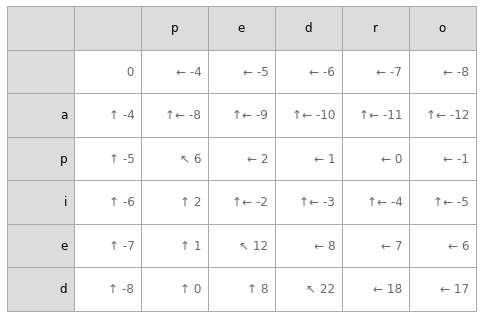



Matrix d_del



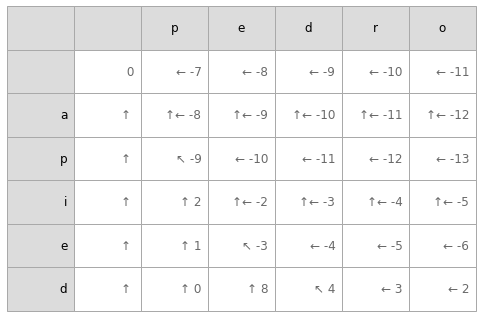



Matrix d_ins



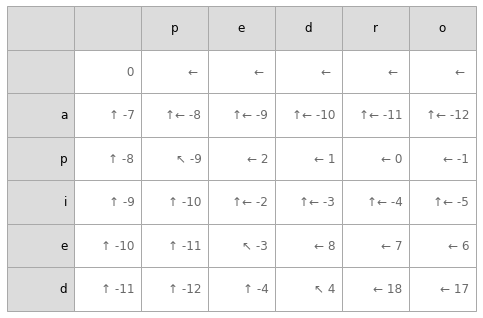

In [ ]:
#AB07.2

#@title Input strings and scoring scheme { display-mode: "both" }
a = "apied" #@param {type:"string"}
b = "pedro" #@param {type:"string"}
sm = 10 #@param {type:"integer"}
sr =  -10#@param {type:"integer"}
s_open =  -3#@param {type:"integer"}
s_ext =  -1#@param {type:"integer"}

d={}  # we store the dynamic programming matrix in a dictionary
db={} # and the backtracking matrix, too.
d_del={}
d_ins={}
m = len(a)
n = len(b)

from tabulate import tabulate

def max_dir(dN,dW,dNW):
  """Returns the maximum of dN, dW, dNW and a set with the directions N, W, NW, which held the maximum value.
  max_dir(4,4,3) return {"N","W"} and miax_dir(3,2,4) {"NW"}.
  """
  direction = set([]) # empty set
  if dN == max(dN,dW,dNW):
    direction.add("N")
  if dW == max(dN,dW,dNW):
    direction.add("W")
  if dNW == max(dN,dW,dNW):
    direction.add("NW")
  return (max(dN,dW,dNW), direction)




def needle(a,b):
  """Computes the Levenshtein distance (and backtracking matrix) between strings a and b."""

  d[0,0] = 0
  db[0,0] = set([]) # empty set
  d_del[0,0]=0
  d_ins[0,0]=0

  # Initialise the first column and d_ins
  for i in range(1,m+1):
    d[i,0] = s_open + i*s_ext
    db[i,0] = {"N"}
    d_ins[i,0] = d[i,0] + s_open # init of d_ins

  # Initialise the first row and d_del
  for j in range(1,n+1):
    d[0,j] = s_open + j*s_ext
    db[0,j] = {"W"}
    d_del[0,j] = d[0,j] + s_open # init of d_del

  # Fill all cells of the matrix
  for i in range(1,m+1):
    for j in range(1,n+1):
      # if letters are the same, no edit operation is used, otherwise it is one (replace operation)
      if a[i-1] == b[j-1]:
        s = sm
      else:
        s = sr
      # Get the maximum of the scores N, W, and NW and remember the direction.
      d_del[i,j]= max(d_del[i-1,j] + s_ext,       # extend an existing gap
                      d[i-1,j] + s_open + s_ext)  # start a new gap
      d_ins[i,j]= max(d_ins[i,j-1] + s_ext,       # extend an existing gap
                      d[i,j-1] + s_open + s_ext)  # start a new gap
      (d[i,j], db[i,j]) = max_dir(d_del[i,j],
                                  d_ins[i,j],
                                  d[i-1,j-1]+s)
  return d[m,n]

def align(a,b, i,j, line1, line2):
  """prints all aligments for strings a and b.
  Requires that needle was run
  (for the db matrix with the direction information)."""
  if "N" in db[i,j]:
    align(a,b,i-1,j,   a[i-1]+line1,    "-"+line2)
  if "W" in db[i,j]:
    align(a,b,i  ,j-1,    "-"+line1, b[j-1]+line2)
  if "NW" in db[i,j]:
    align(a,b,i-1,j-1, a[i-1]+line1, b[j-1]+line2)
  if db[i,j]==set([]): # empty set. we have reached the top left corner of db
    print()
    print(line1)       # and have collected the full alignment
    print(line2)



print("Dynamic programming matrices for Needleman-Wunsch algorithm and affine gap penalties.\n")
l=needle(a,b)
print("Score=%d"%(l))
print("\n\nAll alignments (match score=%d, mismatch score=%d, gap opening=%d, gap extension=%d):"%(sm,sr,s_open, s_ext))
align(a,b,len(a),len(b), "", "")



try:
  print_d()
  print_d(d_del_ins="d_del")
  print_d(d_del_ins="d_ins")
except:
  print("\nError: You have to run the print_d script at the top of the notebook to print the matrix nicely.")


#AB08 Levensthein distance in linear time

Most cells in the matrix do not contribute to the final score and alignment. We can reduce the computational time from quadratic to linear by considering only the main diagonals. We set a cut-off s for the Levensthein distance and only consider results better than s. The cut-off helps us to reduce the computation, as we only consider the s/2 diagonals above and below the main matrix. Run the code and check out the number of operations and speed of computation.


Dynamic programming to compute the Levenshtein distance of two strings.

The Levenshtein distance is 13.


Note, the algorithm is linear, but visualising the matrix is quadratic and hence costly for large strings.



Matrix d for alignment
  Peter sass im Garten und ass eine--------
  Peter sass im Au-to- und ass einen Marsri




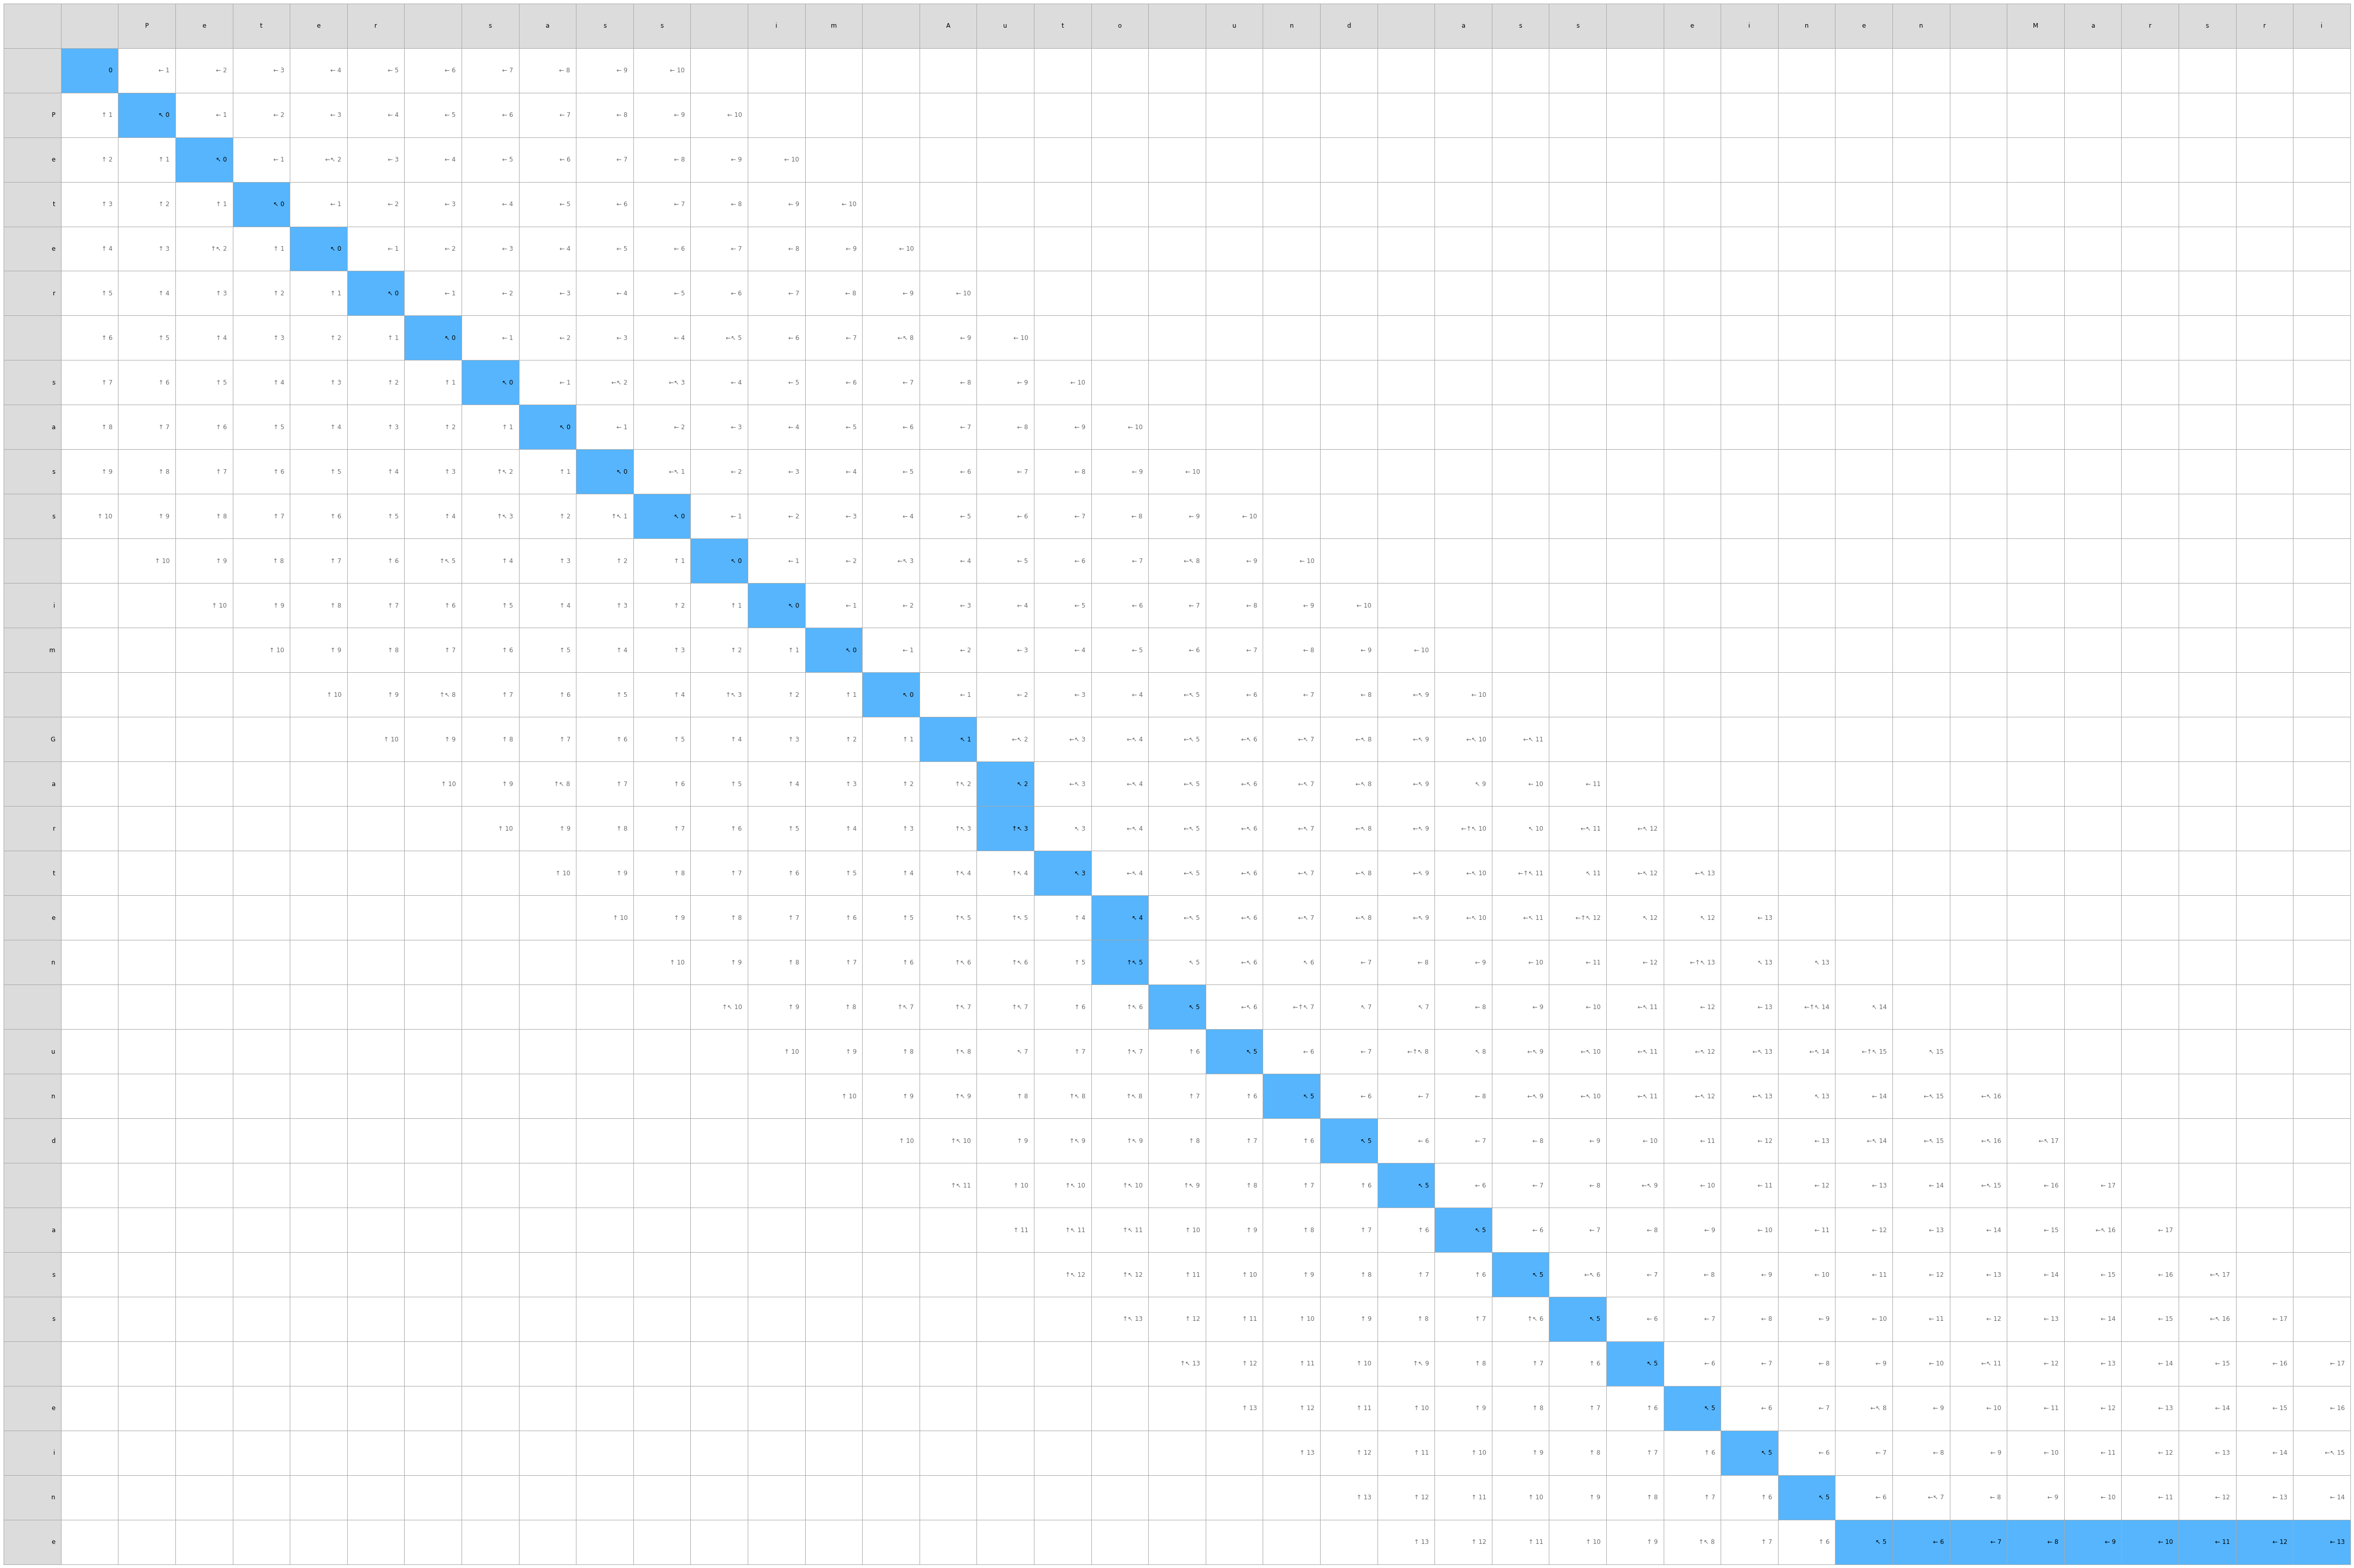

In [ ]:
#AB08

#@title Input strings for Levensthein distance { display-mode: "both" }
a = "Peter sass im Garten und ass eine" #@param {type:"string"}
b = "Peter sass im Auto und ass einen Marsri" #@param {type:"string"}
s = 20 #@param {type:"integer"}
print_matrix = True #@param {type:"boolean"}

m = len(a)
n = len(b)
d={}  # we store the dynamic programming matrix in a dictionary
db={} # and the backtracking matrix, too.

from tabulate import tabulate

# how many diagonals off the main diagonal are we considering
off = round(s/2)


def min_dir(dN, dW, dNW):
  """Returns the minimum of dN, dW, dNW and a set with the directions N, W, NW, which held the minimal value.
  dN, dW, and dNW can also be None, but at least one must be not None.
  min_dir(2,2,3) return {"N","W"} and min_dir(3,2,1) {"NW"}.
  """
  minimum = min(filter(lambda x: not x is None, [dN,dW,dNW]))
  direction = set([]) # empty set
  if not dN is None and dN == minimum:
    direction.add("N")
  if not dW is None and dW == minimum:
    direction.add("W")
  if not dNW is None and dNW == minimum:
    direcrtion.add("NW")
  return (minimum, direction)


def lev(a,b):
  """Computes the Levenshtein distance (and backtracking matrix) between strings a and b."""

  d[0,0] = 0
  db[0,0] = set([]) # empty set
  ops = 0

  # Initialise the first column
  for i in range(1,off+1):
    d[i,0] = i
    db[i,0] = {"N"}
    ops += 1

  # Initialise the first row
  for j in range(1,off+1):
    d[0,j] = j
    db[0,j] = {"W"}
    ops += 1

  # Fill all cells of the matrix
  for i in range(1,m+1):
    for j in range(max(1,i-off),  min(i+off+1,n+1)):
      # if letters are the same, no edit operation is used, otherwise it is one (replace operation)
      if a[i-1] == b[j-1]:
        s = 0
      else:
        s = 1
      if (i-1,j) in d:
        dN = d[i-1,j]+1
      else:
        dN = None
      if (i,j-1) in d:
        dW = d[i  ,j-1]+1
      else:
        dW = None
      if (i-1,j-1) in d:
        dNW = d[i-1,j-1]+s
      else:
        dNW = None
      # Get the minimum of the scores N, W, and NW and remember the direction.
      (d[i,j], db[i,j]) = min_dir(dN, dW, dNW)
      ops += 3

  #print("The algorithm used %d plus operations.\n"%(ops))
  if (m,n) in d:
    return d[m,n]
  else:
    return None


print("Dynamic programming to compute the Levenshtein distance of two strings.\n")

ld = lev(a,b)

if ld:
  print("The Levenshtein distance is %d."%(ld))
  print()
else:
  print("Levensthein distance is above required cut-off")

try:
  if print_matrix:
    print("\nNote, the algorithm is linear, but visualising the matrix is quadratic and hence costly for large strings.\n")
    print_d(path="one")
except:
  print("\nError: You have to run the print_d script at the top of the notebook to print the matrix nicely.")



#AB08.2 Levenshtein distance in Exponential, quadratic, and linear time**
The code shows three implementations.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


----------------------------
0.00s, lev=0, n=0, Lin
0.00s, lev=0, n=0, Quad
0.00s, lev=0, n=0, Exp
----------------------------
0.00s, lev=0, n=2, Lin
0.00s, lev=0, n=2, Quad
0.00s, lev=0, n=2, Exp
----------------------------
0.00s, lev=0, n=4, Lin
0.00s, lev=0, n=4, Quad
0.00s, lev=0, n=4, Exp
----------------------------
0.00s, lev=0, n=6, Lin
0.00s, lev=0, n=6, Quad
0.01s, lev=0, n=6, Exp
----------------------------
0.00s, lev=0, n=8, Lin
0.00s, lev=0, n=8, Quad
0.17s, lev=0, n=8, Exp
----------------------------
0.00s, lev=1, n=10, Lin
0.00s, lev=1, n=10, Quad
4.94s, lev=1, n=10, Exp
----------------------------
0.00s, lev=2, n=30, Lin
0.00s, lev=2, n=30, Quad
----------------------------
0.00s, lev=3, n=50, Lin
0.00s, lev=3, n=50, Quad
----------------------------
0.00s, lev=3, n=70, Lin
0.00s, lev=3, n=70, Quad
----------------------------
0.00s, lev=7, n=90, Lin
0.06s, lev=7, n=90, Quad
----------------------------
0.00s, lev=10, n=100, Lin
0.01s, lev=10, n=100, Quad
---------

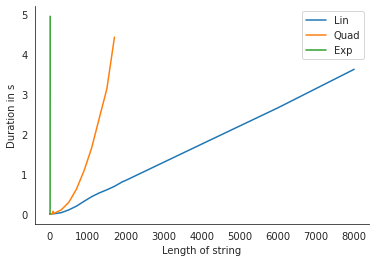

In [ ]:
# AB08.2
from tabulate import tabulate
from collections import defaultdict
import time
import random
import matplotlib.pyplot as plt
import seaborn as sns


def mismatch(c,d):
  """Returns 1, if characters c and d mismatch"""
  return int(c!=d)

def minimum(a,b,c):
  """Returns the minimum of a, b, and c. Variables may
  be None, but at least one has to be a number.
  The function is needed as the built-in min function
  cannot handle None values. Handling None is needed
  for levLin."""
  return min([x for x in [a,b,c] if not x is None])

def d2str(d,a,b,m,n):
  """Turns the matrix d into a string using tabulate"""
  rows = [list("  "+b)]
  for i in range(0,m+1):
    row = [(" "+a)[i]]
    for j in range(0,n+1):
      if not (i,j) in d: row.append("")
      else: row.append(str(d[i,j]))
    rows.append(row)
  print("\nd=\n"+tabulate(rows, tablefmt="plain"))

def randomDNA(n,m):
  """Returns a random string of length n
  and a second which may differ in up to m positions."""
  a = [random.choice(list("acgt")) for x in range(n)]
  b = a.copy()
  for i in random.sample(range(n), m):
    b[i] = random.choice(list("acgt"))
  return ("".join(a), "".join(b))

def levExp(a,b):
  """Levenshtein distance of a and b using recursion."""
  m = len(a)
  n = len(b)
  if m==0: return n
  elif n==0: return m
  return min(levExp(a[:-1], b)      + 1,
             levExp(a,      b[:-1]) + 1,
             levExp(a[:-1], b[:-1]) + mismatch(a[-1], b[-1])
            )

def levQuad(a,b):
  """Levenshtein distance of a and b using dynamic programming."""
  m = len(a)
  n = len(b)
  d = {}
  d[0,0] = 0
  for i in range(1,m+1): d[i,0] = i
  for j in range(1,n+1): d[0,j] = j
  for i in range(1,m+1):
    for j in range(1,n+1):
      d[i,j] = min(d[i-1,j  ] + 1,
                   d[i  ,j-1] + 1,
                   d[i-1,j-1] + mismatch(a[i-1], b[j-1]))
  #d2str(d,a,b,m,n)
  return d[m,n]

def levLin(a,b):
  """Levenshtein distance of a and b using dynamic programming only
  along the diagonal plus/minus off diagonals."""
  m = len(a)
  n = len(b)
  d={}
  d[0,0] = 0
  off = min(100, max(int(max(m,n)*0.1),2))
  #print(off)
  for i in range(1,off+1):
    d[i,0] = i
  for j in range(1,off+1):
    d[0,j] = j
  for i in range(1,m+1):
    for j in range(max(1,i-off),  min(i+off+1,n+1)):
      dN, dW, dNW = None, None, None
      if (i-1,j  ) in d: dN  = d[i-1,j  ] + 1
      if (i  ,j-1) in d: dW  = d[i,  j-1] + 1
      if (i-1,j-1) in d: dNW = d[i-1,j-1] + mismatch(a[i-1], b[j-1])
      d[i,j] = minimum(dN, dW, dNW)
  #d2str(d,a,b,m,n)
  if (m,n) in d: return d[m,n]
  return -1

def lev(a,b,alg):
  """Runs all algorithms and prints out durations and Levenshtein distance."""
  start = time.time()
  if alg=="Exp": l=levExp(a,b)
  if alg=="Quad": l=levQuad(a,b)
  if alg=="Lin": l=levLin(a,b)
  duration = time.time()-start
  print("%.2fs, lev=%d, n=%d, %s"%(duration, l, len(a),alg))
  return duration

# we have three algorithms with different runtime behaviour.
# Durations stores the time they take to execute and the list l
# has the lengths of strings we will test
algs = ["Lin","Quad","Exp"]
durations = defaultdict(list)
ls = list(range(0,10,2))+list(range(10,100,20))+list(range(100,2000,200))+list(range(2000,10000,2000))

# For each length and for each algorithm run it and keep it execution time in durations.
for l in ls:
  if algs != []:
    durations["Len"].append(l)
    (a,b) = randomDNA(l, int(0.1*l))
    print("----------------------------")
    for alg in algs:
      duration = lev(a,b,alg)
      durations[alg].append(duration)
      if duration > 4:
        algs.remove(alg)


# Plot the execution times in a graph.
# Mathplotlib has commands for plotting graphs
# Seaborn (sns) is a nice add on to make graphs more beautiful.
algs = ["Lin","Quad","Exp"]
sns.set_style("white")
for alg in algs:
  plt.plot(durations["Len"][:len(durations[alg])],durations[alg],label=alg)
sns.despine()
plt.ylabel('Duration in s')
plt.xlabel('Length of string')
plt.legend()
plt.show()

#AB09 Stats

Starting from a query sequence we compare it to many sequences and compute a Z-score.





Loading Pfam alignment PF00693
Sequence comparison
Query sequence from PDB 1OSN
Database sequences from Pfam PF00693 (808 sequences)


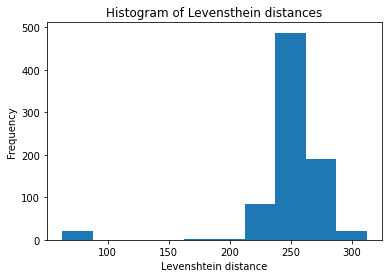

Best score of 63 (Z-score of 5.47)

GAYGIGKTTAAEEFLHHFAITpNRILLIGEPLSYWRNLAGEDAICGIYGTQTRRLNGDVSPEDAQRLTAHFQSLFCSPHAIMHAKISALMDTSTSDLVQVNKEPYKIMLSDRHPIASTICFPLSRYLVGDMSPAALPGLLFTLPAEPPGTNLVVCTVSLPSHLSRVSKRARPGETVNLPFVMVLRNVYIMLINTIIFLKTNNWHAGWNTLSFCNDVFKQKLQKSECIKLREVPGIEDTLFAVLKLPELCGEFGNILPLWAWGMETLSNCLRSMSPFVLS



In [ ]:
#AB09 Statistics

from statistics import stdev, mean
import matplotlib.pyplot as plt

pfam_id = "PF00693" # Herpes thymidine kinase
pdb_id = "1OSN" # The structure of a herpes thymidine kinase

try:
  seq1 = getPDBSeq(pdb_id).split("\n")[1] # get seq and remove header
  pfam = getPfam(pfam_id)
except:
  print("Error: First run AB02.4 (Downloading data), which implements getPDBSeq and getPfam.")
  raise

def lev(a,b):
  d={}
  m, n, d[0,0] = len(a), len(b), 0
  for i in range(1,m+1): d[i,0] = i
  for j in range(1,n+1): d[0,j] = j
  for i in range(1,m+1):
    for j in range(1,n+1):
      if a[i-1] == b[j-1]: s = 0
      else: s = 1
      d[i,j] = min(d[i-1,j  ]+1,
                   d[i  ,j-1]+1,
                   d[i-1,j-1]+s)
  return d[m,n]

def Zscore(s,avg,std):
  return abs(s-avg)/std

scores=[]
bestseq, bestScore = "", 10000
i = 0
print("Sequence comparison")
for p in pfam:
  i+=1
  #if i>10: break
  if p!="":
    seq2 = "".join([aa for aa in p if aa != "-"])
    score = lev(seq1,seq2)
    scores.append(score)
    if score < bestScore:
      bestScore = score
      bestSeq = seq2

print("Query sequence from PDB %s"%pdb_id)
print("Database sequences from Pfam %s (%d sequences)"%(pfam_id, len(pfam)))

plt.hist(levs)
plt.xlabel("Levenshtein distance")
plt.ylabel("Frequency")
plt.title("Histogram of Levensthein distances")
plt.show()

print("Best score of %d (Z-score of %.2f)"%(bestScore, Zscore(bestScore, mean(levs), stdev(levs))))
print("\n%s\n"%bestSeq)